In [ ]:
### Sección 1 — Setup y verificación del entorno

In [ ]:
!pip install --upgrade pip

In [ ]:
# Instala PyTorch + TorchVision para CPU
!pip install torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cpu



In [ ]:
# Instala las demás librerías necesarias del proyecto
!pip install ultralytics opencv-python==4.8.1.78 numpy==1.24.4 pandas==2.0.3 matplotlib==3.7.5 seaborn==0.12.2 openpyxl==3.1.2 psutil==5.9.8

In [ ]:
!python -m pip install supervision

# LIBRERIAS

In [106]:
import cv2
import supervision as sv
from ultralytics import YOLO
import numpy as np
from PIL import Image

# FUNCIONES

In [107]:
# GENERAR BATCHES
def obtener_batches(video_path, batch_size=32):
    """
    Lee un video y entrega listas de 'batch_size' frames.
    Si el video termina y el último batch tiene menos frames, igual se entrega.
    """
    cap = cv2.VideoCapture(video_path)
    batch = []

    while True:
        ret, frame = cap.read()
        if not ret:
            if len(batch) > 0:
                yield batch
            break

        batch.append(frame)

        if len(batch) == batch_size:
            yield batch
            batch = []

    cap.release()

In [108]:
### nueva funcion Orientacion Perosnas 
import numpy as np

def detectar_orientacion_persona(xy, conf, umbrales={'frontal':0.65,
                                                     'lateral':0.35,
                                                     'ratio_rot':1.25, # se cambia estaba en  1.25 
                                                     },
                                                     keypoint_id={'OREJA_IZQ':3,
                                                                  'OREJA_DER':4,
                                                                  'HOMBRO_IZQ':5,
                                                                  'HOMBRO_DER':6,
                                                                  'CADERA_IZQ':11,
                                                                  'CADERA_DER':12,
                                                                  },
                                                    confianza_keypoints={'HOMBRO_IZQ':0.5,
                                                                         'HOMBRO_DER':0.5,
                                                                         'OREJA_IZQ':0.4,
                                                                         'OREJA_DER':0.4,
                                                                         }
                                                    ):
    """
    🔥 FUNCIÓN CORE: ORIENTACIÓN PERSONA (frontal vs lateral)
    ✅ SCORING MULTI-CRITERIO - Pesos ajustados para casos extremos
    
    CORRECCIONES FINALES:
    - dist_norm peso 3 (no 4) - menos dominante
    - Orejas peso 4 (no 3) - más confiable siempre
    - Validado con casos: frontal bajo, frontal brazos >90°, lateral real
    
    Args:
        xy: np.array (17, 2) - coordenadas keypoints 1 persona
        conf: np.array (17,) - confianza keypoints 1 persona
        umbrales: dict - umbrales configurables
        keypoint_id: dict - índices keypoints YOLO
        confianza_keypoints: dict - umbrales confianza mínima
    
    Returns:
        str: 'frontal', 'lateral' o 'ND'
    """
    print(50*'*')
    
    # ------------------------------
    # ÍNDICES YOLO POSE
    # ------------------------------
    OREJA_IZQ, OREJA_DER = keypoint_id['OREJA_IZQ'], keypoint_id['OREJA_DER']
    HOMBRO_IZQ, HOMBRO_DER = keypoint_id['HOMBRO_IZQ'], keypoint_id['HOMBRO_DER']
    CADERA_IZQ, CADERA_DER = keypoint_id['CADERA_IZQ'], keypoint_id['CADERA_DER']

    # ------------------------------
    # EXTRAER DATOS NECESARIOS
    # ------------------------------
    hombro_i, hombro_d = xy[HOMBRO_IZQ], xy[HOMBRO_DER]
    cadera_i, cadera_d = xy[CADERA_IZQ], xy[CADERA_DER]

    # Validación confianza hombros
    if conf[HOMBRO_IZQ] < confianza_keypoints['HOMBRO_IZQ'] or conf[HOMBRO_DER] < confianza_keypoints['HOMBRO_DER']:
        return 'ND'

    # ------------------------------
    # MÉTRICAS ANATÓMICAS
    # ------------------------------
    dist_hombros = np.linalg.norm(hombro_d - hombro_i)
        
    # Centros anatómicos
    centro_h = (hombro_i + hombro_d) / 2
    centro_c = (cadera_i + cadera_d) / 2
    altura_tronco = np.linalg.norm(centro_h - centro_c) ### abs(centro_c[1] - centro_h[1])## corregir esta en aboluto 
    
    # Validación altura tronco
    if altura_tronco < 1e-6:
        return 'ND'
    
    # Normalización
    dist_norm = dist_hombros / altura_tronco
    dist_norm = abs(dist_norm)
    
    print(f'Métricas: dist_norm={dist_norm:.3f}, altura_tronco={altura_tronco:.2f}')

    # =========================================================================
    # ✅ SCORING MULTI-CRITERIO (PESOS AJUSTADOS)
    # =========================================================================
    
    votos_frontal = 0
    votos_lateral = 0
    
    # ------------------------------
    # CRITERIO 1: dist_norm (peso 3) ← REDUCIDO de 4
    # ------------------------------
    if dist_norm > umbrales['frontal']:
        votos_frontal += 3
        print(f'  [Criterio 1] dist_norm={dist_norm:.3f} > {umbrales["frontal"]} → +3 frontal')
    elif dist_norm < umbrales['lateral']:
        votos_lateral += 3
        print(f'  [Criterio 1] dist_norm={dist_norm:.3f} < {umbrales["lateral"]} → +3 lateral')
    else:
        print(f'  [Criterio 1] dist_norm={dist_norm:.3f} en zona ambigua → +0')
    
    # ------------------------------
    # CRITERIO 2: Orejas visibles (peso 4) ← AUMENTADO de 3
    # ------------------------------
    orejas_visibles = (
        conf[OREJA_IZQ] > confianza_keypoints['OREJA_IZQ'] and 
        conf[OREJA_DER] > confianza_keypoints['OREJA_DER']
    )
    
    if orejas_visibles:
        votos_frontal += 4
        print(f'  [Criterio 2] Ambas orejas visibles (conf={conf[OREJA_IZQ]:.2f}, {conf[OREJA_DER]:.2f}) → +4 frontal')
    else:
        print(f'  [Criterio 2] Orejas NO visibles → +0')
    
    # ------------------------------
    # CRITERIO 3: Ratio rotación (peso 2) ← MANTIENE
    # ------------------------------
    dist_hi_ci = np.linalg.norm(hombro_i - cadera_i)
    dist_hd_cd = np.linalg.norm(hombro_d - cadera_d)
    ratio_rot = max(dist_hi_ci, dist_hd_cd) / max(1, min(dist_hi_ci, dist_hd_cd))
    
    if ratio_rot > umbrales['ratio_rot']:
        votos_frontal += 2
        print(f'  [Criterio 3] Ratio rotación={ratio_rot:.2f} > {umbrales["ratio_rot"]} → +2 frontal')
    else:
        print(f'  [Criterio 3] Ratio rotación={ratio_rot:.2f} → +0')
    
    # ------------------------------
    # DECISIÓN FINAL POR VOTACIÓN
    # ------------------------------
    print(f'\n  📊 VOTOS FINALES: Frontal={votos_frontal}, Lateral={votos_lateral}')
    
    if votos_frontal > votos_lateral:
        print(f'  ✅ DECISIÓN: FRONTAL (ganó {votos_frontal} vs {votos_lateral})\n')
        return 'frontal'
    
    elif votos_lateral > votos_frontal:
        print(f'  ✅ DECISIÓN: LATERAL (ganó {votos_lateral} vs {votos_lateral})\n')
        return 'lateral'
    
    else:
        # Empate → criterio de desempate
        if orejas_visibles:
            print(f'  ⚖️ EMPATE ({votos_frontal} vs {votos_lateral}) → Desempate por orejas → FRONTAL\n')
            return 'frontal'
        else:
            # Empate sin orejas → revisar asimetría extrema (rotación)
            # Usar ratio_rot ya calculado arriba (líneas 112-114)
            
            if ratio_rot > 1.35:  # Umbral MÁS ALTO que el normal (1.25) ## ANALZIAR CAMBIOS IR BAJANDO ESTA EN 1.35
                # Rotación extrema detectada sin necesitar orejas
                print(f'  🔄 EMPATE → Rotación detectada por asimetría ({ratio_rot:.2f} > 1.35) → FRONTAL\n')## se cambio estaba en 1.35
                return 'frontal'
            else:
                # Empate sin criterio claro
                print(f'  ⚖️ EMPATE ({votos_frontal} vs {votos_lateral}) → Sin criterio claro → ND\n')
                return 'ND'    

In [ ]:
# #ORIENTACION PERSONA
# def detectar_orientacion_persona(xy, conf, umbrales={'frontal':0.65,
#                                                      'lateral':0.35,#'lateral':0.15,
#                                                      'ratio_rot':1.35,
#                                                      },
#                                                      keypoint_id={'OREJA_IZQ':3,
#                                                                   'OREJA_DER':4,
#                                                                   'HOMBRO_IZQ':5,
#                                                                   'HOMBRO_DER':6,
#                                                                   'CADERA_IZQ':11,
#                                                                   'CADERA_DER':12,
#                                                                   },
#                                                     confianza_keypoints={'HOMBRO_IZQ':0.5,
#                                                                          'HOMBRO_DER':0.5,
#                                                                          'OREJA_IZQ':0.4,
#                                                                          'OREJA_DER':0.4,
#                                                                          }
#                                                     ):
#     """
#     🔥 FUNCIÓN CORE: ORIENTACIÓN PERSONA (frontal vs lateral)
#     Compatible con objetos Supervision (sv.KeyPoints) empaquetados.

#     Parámetros:
#         kp : sv.KeyPoints para un frame (varias personas)
#         persona_id : índice de la persona a analizar

#     Retorna:
#         {
#             'orientacion': 'frontal' / 'lateral',
#             'confianza': float,
#             'metodo': 'principal' / 'fallback',
#             'metricas': {dist_norm, ratio_rotacion, orejas_visibles}
#         }
#     """
#     print(50*'*')
#     # ------------------------------
#     # ÍNDICES YOLO POSE
#     # ------------------------------
#     OREJA_IZQ, OREJA_DER = keypoint_id['OREJA_IZQ'], keypoint_id['OREJA_DER']
#     HOMBRO_IZQ, HOMBRO_DER = keypoint_id['HOMBRO_IZQ'], keypoint_id['HOMBRO_DER']
#     CADERA_IZQ, CADERA_DER = keypoint_id['CADERA_IZQ'], keypoint_id['CADERA_DER']

#     # ------------------------------
#     # EXTRAER DATOS NECESARIOS
#     # ------------------------------
#     # xy  = kp.xy[persona_id]             # (17,2)
#     # conf = kp.confidence[persona_id]    # (17,)

#     hombro_i, hombro_d = xy[HOMBRO_IZQ], xy[HOMBRO_DER]
#     cadera_i,  cadera_d  = xy[CADERA_IZQ], xy[CADERA_DER]

#     # si hombros tienen baja confianza → no analizar
#     if conf[HOMBRO_IZQ] < confianza_keypoints['HOMBRO_IZQ'] or conf[HOMBRO_DER] < confianza_keypoints['HOMBRO_DER']:
#         return 'ND'
#         # return {'orientacion': 'no_detectado', 'confianza': 0.0, 'metodo': 'sin_hombros'}

#     # ------------------------------
#     # DISTANCIA HOMBROS Y ALTURA TRONCO
#     # ------------------------------
#     dist_hombros = np.linalg.norm(hombro_d - hombro_i)

#     # altura tronco vertical entre centros hombros–caderas
#     centro_h = (hombro_i + hombro_d) / 2
#     centro_c = (cadera_i + cadera_d) / 2
#     altura_tronco = abs(centro_c[1] - centro_h[1])

#     print(altura_tronco)

#     # Normalización
#     dist_norm = dist_hombros / altura_tronco

#     # ------------------------------
#     # CLASIFICACIÓN BINARIA PRINCIPAL
#     # ------------------------------
#     # Regla 1: umbrales principales
#     if dist_norm > umbrales['frontal']:
#         print('Se decidio por frontal con una dist_norm: ',dist_norm)
#         return 'frontal'
#     if dist_norm < umbrales['lateral']:
#         print('Se decidio por lateral con una dist_norm: ',dist_norm)        
#         return 'lateral'

#     # ------------------------------
#     # FALLBACK (ZONA AMBIGUA)
#     # ------------------------------

#     # 1️⃣ Orejas → frontal
#     orejas_visibles = (
#         conf[OREJA_IZQ] > confianza_keypoints['OREJA_IZQ'] and conf[OREJA_DER] > confianza_keypoints['OREJA_DER']
#     )
#     if orejas_visibles:
#         return 'frontal'

#     # 2️⃣ Simetría hombro–cadera → rotación → frontal
#     dist_hi_ci = np.linalg.norm(hombro_i - cadera_i)
#     dist_hd_cd = np.linalg.norm(hombro_d - cadera_d)
#     ratio_rot = max(dist_hi_ci, dist_hd_cd) / max(1, min(dist_hi_ci, dist_hd_cd))

#     if ratio_rot > umbrales['ratio_rot']:
#         return 'frontal'


#     # 3️⃣ Si nada de lo anterior → lateral por seguridad ergonómica
#     print('No entro an ningun condicional')
#     return 'ND'


In [26]:
#ANOTAR IMAGEN
def anotar(img,annotations):
    labels=[]

    if 'xy' and 'keypoints_confidence' in annotations.data.keys():
        kp=sv.KeyPoints(xy=annotations['xy'],confidence=annotations['keypoints_confidence'],class_id=annotations.class_id)

    for i,class_id in enumerate(annotations.class_id):
        label=''
        if 'orientacion' in annotations.data.keys():
            label+=str(annotations['orientacion'][i])
            labels.append(label)
    
    bounding_box_annotator=sv.BoxAnnotator()
    label_annotator=sv.LabelAnnotator(text_scale=1,text_thickness=2)
    edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN,thickness=4)

    annotated_image=img.copy()
    annotated_image=bounding_box_annotator.annotate(annotated_image,annotations)
    annotated_image=label_annotator.annotate(annotated_image,annotations,labels)
    if 'xy' and 'keypoints_confidence' in annotations.data.keys():
        annotated_image=edge_annotator.annotate(annotated_image,key_points=kp)
    return annotated_image

#### ANOTAR V2

In [109]:
import cv2
import supervision as sv

# -------------------------------------------------
# Utilidad color por score RULA
# -------------------------------------------------
def color_por_score(score):
    if score == 1:
        return (0, 255, 0)      # Verde
    elif score == 2:
        return (0, 255, 255)    # Amarillo
    elif score == 3:
        return (0, 165, 255)    # Naranja
    else:
        return (0, 0, 255)      # Rojo


# -------------------------------------------------
# FUNCIÓN ANOTAR (VERSIÓN MEJORADA)
# -------------------------------------------------
def anotar(img, annotations):

    annotated_image = img.copy()

    # -----------------------------
    # Reconstruir KeyPoints
    # -----------------------------
    if 'xy' in annotations.data and 'keypoints_confidence' in annotations.data:
        kp = sv.KeyPoints(
            xy=annotations['xy'],
            confidence=annotations['keypoints_confidence'],
            class_id=annotations.class_id
        )
    else:
        kp = None

    # -----------------------------
    # Dibujar bounding box y esqueleto
    # -----------------------------
    bounding_box_annotator = sv.BoxAnnotator(thickness=2)
    edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=4)

    annotated_image = bounding_box_annotator.annotate(
        annotated_image, annotations
    )

    if kp is not None:
        annotated_image = edge_annotator.annotate(
            annotated_image, key_points=kp
        )

    # -----------------------------
    # 🆕 ANOTACIONES RULA (LEGIBLES)
    # -----------------------------
    for i, box in enumerate(annotations.xyxy):
        x1, y1, x2, y2 = map(int, box)

        # Posición inicial del texto
        y_text = y1 - 10

        # -------------------------
        # ORIENTACIÓN
        # -------------------------
        orientacion = annotations['orientacion'][i]
        texto = f"Orientacion: {orientacion}"

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.9
        thickness = 3

        (w, h), _ = cv2.getTextSize(texto, font, font_scale, thickness)

        cv2.rectangle(
            annotated_image,
            (x1, y_text - h - 6),
            (x1 + w + 6, y_text + 4),
            (0, 0, 0),
            -1
        )

        cv2.putText(
            annotated_image,
            texto,
            (x1 + 3, y_text),
            font,
            font_scale,
            (255, 255, 255),
            thickness,
            cv2.LINE_AA
        )

        y_text -= (h + 12)

        # -------------------------
        # HOMBRO Y CODO
        # -------------------------
        hc = annotations['hombro_codo_rula'][i]

        for lado in ['izquierdo', 'derecho']:
            res = hc[lado]
            if not res.valido:
                continue

            # ---------- HOMBRO ----------
            if res.elevacion_grados is not None:
                texto_h = (
                    f"Hombro {lado[:3]}: "
                    f"{res.elevacion_grados:.0f}° (S{res.score_hombro})"
                )
            else:
                texto_h = (
                    f"Hombro {lado[:3]}: "
                    f"Abd {res.abduccion_grados:.0f}° (S{res.score_hombro})"
                )

            color_h = color_por_score(res.score_hombro)

            (w, h), _ = cv2.getTextSize(
                texto_h, font, font_scale, thickness
            )

            cv2.rectangle(
                annotated_image,
                (x1, y_text - h - 6),
                (x1 + w + 6, y_text + 4),
                (0, 0, 0),
                -1
            )

            cv2.putText(
                annotated_image,
                texto_h,
                (x1 + 3, y_text),
                font,
                font_scale,
                color_h,
                thickness,
                cv2.LINE_AA
            )

            y_text -= (h + 10)

            # ---------- CODO ----------
            texto_c = (
                f"Codo {lado[:3]}: "
                f"{res.flexion_codo_grados:.0f}° (S{res.score_codo})"
            )

            color_c = color_por_score(res.score_codo)

            (w, h), _ = cv2.getTextSize(
                texto_c, font, font_scale, thickness
            )

            cv2.rectangle(
                annotated_image,
                (x1, y_text - h - 6),
                (x1 + w + 6, y_text + 4),
                (0, 0, 0),
                -1
            )

            cv2.putText(
                annotated_image,
                texto_c,
                (x1 + 3, y_text),
                font,
                font_scale,
                color_c,
                thickness,
                cv2.LINE_AA
            )

            y_text -= (h + 14)

    return annotated_image

EVALUACIÓN TRONCO RULA - REFACTORIZACIÓN OOP

In [110]:
# Compatible con: YOLO Pose v11 + Supervision + Pipeline existente
# Corrección flexión lateral (dy invertido)
# 100% OOP, sin prints, empaquetado en objetos


import numpy as np
from dataclasses import dataclass, field
from enum import Enum
from typing import Optional, Tuple, Dict, Any
import logging

# Configurar logging (opcional, se puede desactivar)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)  # Cambiar a DEBUG para ver detalles

# ============================================================================
# 📐 CONFIGURACIONES
# ============================================================================

@dataclass
class ConfigTronco:
    """Configuración de umbrales para evaluación de tronco RULA"""
    
    # Confianza mínima keypoints
    MIN_CONF_HOMBROS: float = 0.5
    MIN_CONF_CADERAS: float = 0.5
    
    # Umbrales FRONTAL (relativizados)
    UMBRAL_INCLINACION_LATERAL: float = 0.15  # ratio desviación horizontal
    UMBRAL_ROTACION_TRONCO: float = 1.25       # ratio asimetría dist hombro-cadera #### ANALZIAR CAMBIOS DE RATIO ESTA EN1.25 IR BAJANDO 
    
    # Umbrales LATERAL (grados para clasificación RULA)
    UMBRAL_FLEXION_SCORE_1: float = 20.0   # ≤20° → Score 1
    UMBRAL_FLEXION_SCORE_2: float = 60.0   # >20° y ≤60° → Score 2
    UMBRAL_FLEXION_SCORE_3: float = 90.0   # >60° y ≤90° → Score 3
    # >90° → Score 4
    
    # Límite físico flexión (90° promedio humano)
    MAX_FLEXION_FISICA: float = 90.0
    
    # Tolerancia cálculos
    MIN_DIST_SEGMENTO: float = 1e-6


class Orientacion(Enum):
    """Orientación de la persona detectada"""
    LATERAL = "lateral"
    FRONTAL = "frontal"
    ND = "ND"  # No Determinada


# ============================================================================
# 📊 MODELO DE DATOS - RESULTADO TRONCO
# ============================================================================

@dataclass
class TroncoRULA:
    """
    Resultado de evaluación RULA del tronco.
    Diseñado para empaquetamiento en sv.KeyPoints o sv.Detections
    """
    
    # IDENTIFICACIÓN
    orientacion_persona: Orientacion
    tronco_valido: bool = False
    
    # VISTA LATERAL - Flexión
    flexion_grados: Optional[float] = None
    score_rula_flexion: int = 0
    
    # VISTA FRONTAL - Modificadores
    inclinacion_lateral: bool = False
    rotacion_tronco: bool = False
    
    # SCORE TOTAL RULA
    score_rula_total: int = 0
    
    # MÉTRICAS ANATÓMICAS (para debugging/análisis)
    altura_tronco: Optional[float] = None
    centro_hombros: Optional[Tuple[float, float]] = None
    centro_caderas: Optional[Tuple[float, float]] = None
    
    # DIAGNÓSTICO
    error: Optional[str] = None
    
    def es_critico(self) -> bool:
        """Retorna True si el score indica riesgo ergonómico alto (≥3)"""
        return self.score_rula_total >= 3
    
    def es_moderado(self) -> bool:
        """Retorna True si el score indica riesgo ergonómico moderado (2)"""
        return self.score_rula_total == 2
    
    def es_aceptable(self) -> bool:
        """Retorna True si el score indica postura aceptable (1)"""
        return self.score_rula_total == 1
    
    def __repr__(self) -> str:
        if not self.tronco_valido:
            return f"TroncoRULA(válido=False, error={self.error})"
        
        if self.orientacion_persona == Orientacion.LATERAL:
            return (f"TroncoRULA(LATERAL, flexión={self.flexion_grados}°, "
                   f"score={self.score_rula_total})")
        else:
            return (f"TroncoRULA(FRONTAL, inclin={self.inclinacion_lateral}, "
                   f"rot={self.rotacion_tronco}, score={self.score_rula_total})")


# ============================================================================
# 🛡️ VALIDADOR DE KEYPOINTS
# ============================================================================

class KeypointValidator:
    """Validaciones reutilizables para keypoints YOLO Pose"""
    
    @staticmethod
    def validar_confianza(conf: np.ndarray, 
                         indices: list, 
                         umbrales: dict,
                         nombres: list) -> Tuple[bool, Optional[str]]:
        """
        Valida que los keypoints tengan confianza mínima
        
        Returns:
            (válido, mensaje_error)
        """
        try:
            for idx, nombre in zip(indices, nombres):
                if conf[idx] < umbrales.get(nombre, 0.5):
                    return False, f"confianza_{nombre}_insuficiente"
            return True, None
        except (IndexError, TypeError):
            return False, "confianza_no_accesible"
    
    @staticmethod
    def extraer_keypoints(xy: np.ndarray, indices: list) -> Tuple[bool, Optional[list], Optional[str]]:
        """
        Extrae keypoints de forma segura
        
        Returns:
            (válido, [keypoints], mensaje_error)
        """
        try:
            keypoints = [np.array(xy[idx]) for idx in indices]
            return True, keypoints, None
        except (IndexError, TypeError):
            return False, None, "keypoints_no_accesibles"
    
    @staticmethod
    def calcular_centro(punto1: np.ndarray, punto2: np.ndarray) -> Tuple[bool, Optional[np.ndarray], Optional[str]]:
        """
        Calcula centro entre dos puntos con validación
        
        Returns:
            (válido, centro, mensaje_error)
        """
        try:
            if punto1 is None or punto2 is None:
                return False, None, "punto_es_none"
            
            if len(punto1) < 2 or len(punto2) < 2:
                return False, None, "dimensiones_insuficientes"
            
            centro = (punto1 + punto2) / 2.0
            
            if np.any(np.isnan(centro)) or np.any(np.isinf(centro)):
                return False, None, "centro_invalido_nan_inf"
            
            return True, centro, None
            
        except (TypeError, ValueError):
            return False, None, "excepcion_calculo_centro"


# ============================================================================
# 🎯 EVALUADOR TRONCO RULA
# ============================================================================

class EvaluadorTronco:
    """
    Evaluador principal de tronco según metodología RULA.
    100% relativizado, sin prints, empaquetado en objetos.
    """
    
    def __init__(self, config: Optional[ConfigTronco] = None):
        self.config = config or ConfigTronco()
        
        # Índices YOLO Pose
        self.IDX_HOMBRO_IZQ = 5
        self.IDX_HOMBRO_DER = 6
        self.IDX_CADERA_IZQ = 11
        self.IDX_CADERA_DER = 12
    
    def evaluar(self, 
                xy: np.ndarray, 
                conf: np.ndarray, 
                orientacion: str) -> TroncoRULA:
        """
        Evalúa tronco según RULA para una persona.
        
        Args:
            xy: np.array (17, 2) - coordenadas keypoints
            conf: np.array (17,) - confianza keypoints
            orientacion: str - 'lateral', 'frontal' o 'ND'
        
        Returns:
            TroncoRULA object con resultados
        """
        
        # Convertir orientación a Enum
        try:
            orientacion_enum = Orientacion(orientacion.lower())
        except ValueError:
            return TroncoRULA(
                orientacion_persona=Orientacion.ND,
                error=f"orientacion_invalida_{orientacion}"
            )
        
        # Validar orientación útil
        if orientacion_enum == Orientacion.ND:
            return TroncoRULA(
                orientacion_persona=orientacion_enum,
                error="orientacion_no_determinada"
            )
        
        # Paso 1: Validar confianza keypoints
        valido, error = KeypointValidator.validar_confianza(
            conf=conf,
            indices=[self.IDX_HOMBRO_IZQ, self.IDX_HOMBRO_DER, 
                    self.IDX_CADERA_IZQ, self.IDX_CADERA_DER],
            umbrales={
                'hombro_izq': self.config.MIN_CONF_HOMBROS,
                'hombro_der': self.config.MIN_CONF_HOMBROS,
                'cadera_izq': self.config.MIN_CONF_CADERAS,
                'cadera_der': self.config.MIN_CONF_CADERAS
            },
            nombres=['hombro_izq', 'hombro_der', 'cadera_izq', 'cadera_der']
        )
        
        if not valido:
            return TroncoRULA(orientacion_persona=orientacion_enum, error=error)
        
        # Paso 2: Extraer keypoints
        valido, keypoints, error = KeypointValidator.extraer_keypoints(
            xy=xy,
            indices=[self.IDX_HOMBRO_IZQ, self.IDX_HOMBRO_DER,
                    self.IDX_CADERA_IZQ, self.IDX_CADERA_DER]
        )
        
        if not valido:
            return TroncoRULA(orientacion_persona=orientacion_enum, error=error)
        
        hombro_izq, hombro_der, cadera_izq, cadera_der = keypoints
        
        # Paso 3: Calcular centros anatómicos
        valido, centro_hombros, error = KeypointValidator.calcular_centro(hombro_izq, hombro_der)
        if not valido:
            return TroncoRULA(orientacion_persona=orientacion_enum, error=error)
        
        valido, centro_caderas, error = KeypointValidator.calcular_centro(cadera_izq, cadera_der)
        if not valido:
            return TroncoRULA(orientacion_persona=orientacion_enum, error=error)
        
        # Paso 4: Calcular vector tronco (caderas → hombros)
        vector_tronco = centro_hombros - centro_caderas
        altura_tronco = np.linalg.norm(vector_tronco)
        
        if altura_tronco < self.config.MIN_DIST_SEGMENTO:
            return TroncoRULA(
                orientacion_persona=orientacion_enum,
                error="altura_tronco_cero"
            )
        
        logger.debug(f"Altura tronco: {altura_tronco:.2f}px")
        
        # Paso 5: Evaluar según orientación
        if orientacion_enum == Orientacion.LATERAL:
            return self._evaluar_lateral(
                vector_tronco=vector_tronco,
                altura_tronco=altura_tronco,
                centro_hombros=centro_hombros,
                centro_caderas=centro_caderas
            )
        else:  # FRONTAL
            return self._evaluar_frontal(
                hombro_izq=hombro_izq,
                hombro_der=hombro_der,
                cadera_izq=cadera_izq,
                cadera_der=cadera_der,
                centro_hombros=centro_hombros,
                centro_caderas=centro_caderas,
                altura_tronco=altura_tronco
            )
    
    def _evaluar_lateral(self,
                        vector_tronco: np.ndarray,
                        altura_tronco: float,
                        centro_hombros: np.ndarray,
                        centro_caderas: np.ndarray) -> TroncoRULA:
        """
        Evalúa tronco en vista LATERAL (Tabla 10 RULA)
        Calcula flexión del tronco en grados - VERSIÓN CORREGIDA
        """
        
        # ========================================
        # CÁLCULO COMPONENTES
        # ========================================
        dx = vector_tronco[0]  # Desplazamiento horizontal
        
        # ✅ CORRECCIÓN: dy positivo cuando persona erecta
        dy_imagen = vector_tronco[1]  # Negativo cuando erecta
        dy_correcto = abs(dy_imagen)   # Convertir a positivo
        
        # Validación: evitar división por cero
        if dy_correcto < self.config.MIN_DIST_SEGMENTO:
            logger.warning("Persona casi horizontal (dy ≈ 0)")
            dy_correcto = 1.0
        
        # ========================================
        # CÁLCULO ÁNGULO DE FLEXIÓN
        # ========================================
        angulo_rad = np.arctan2(abs(dx), dy_correcto)
        angulo_deg = float(np.degrees(angulo_rad))
        
        # Limitar a rango físico humano
        angulo_deg = min(angulo_deg, self.config.MAX_FLEXION_FISICA)
        angulo_deg = max(angulo_deg, 0.0)
        
        logger.debug(f"Flexión: dx={dx:.1f}, dy={dy_correcto:.1f}, ángulo={angulo_deg:.1f}°")
        
        # ========================================
        # CLASIFICACIÓN RULA (Tabla 10)
        # ========================================
        if angulo_deg <= self.config.UMBRAL_FLEXION_SCORE_1:
            score = 1
        elif angulo_deg <= self.config.UMBRAL_FLEXION_SCORE_2:
            score = 2
        elif angulo_deg <= self.config.UMBRAL_FLEXION_SCORE_3:
            score = 3
        else:
            score = 4
        
        return TroncoRULA(
            orientacion_persona=Orientacion.LATERAL,
            tronco_valido=True,
            flexion_grados=round(angulo_deg, 1),
            score_rula_flexion=score,
            score_rula_total=score,
            altura_tronco=round(altura_tronco, 2),
            centro_hombros=tuple(centro_hombros.tolist()),
            centro_caderas=tuple(centro_caderas.tolist())
        )
    
    def _evaluar_frontal(self,
                        hombro_izq: np.ndarray,
                        hombro_der: np.ndarray,
                        cadera_izq: np.ndarray,
                        cadera_der: np.ndarray,
                        centro_hombros: np.ndarray,
                        centro_caderas: np.ndarray,
                        altura_tronco: float) -> TroncoRULA:
        """
        Evalúa tronco en vista FRONTAL (Tabla 11 RULA)
        Detecta inclinación lateral y rotación
        """
        
        score_base = 1
        inclinacion_detectada = False
        rotacion_detectada = False
        
        # ========================================
        # CRITERIO 1: Inclinación Lateral
        # ========================================
        delta_x = abs(centro_hombros[0] - centro_caderas[0])
        dist_total = np.linalg.norm(centro_hombros - centro_caderas)
        
        if dist_total > 0:
            ratio_inclinacion = delta_x / dist_total
        else:
            ratio_inclinacion = 0.0
        
        if ratio_inclinacion > self.config.UMBRAL_INCLINACION_LATERAL:
            inclinacion_detectada = True
            logger.debug(f"Inclinación lateral detectada: ratio={ratio_inclinacion:.3f}")
        
        # ========================================
        # CRITERIO 2: Rotación Tronco
        # ========================================
        dist_hombro_cadera_izq = np.linalg.norm(hombro_izq - cadera_izq)
        dist_hombro_cadera_der = np.linalg.norm(hombro_der - cadera_der)
        
        if dist_hombro_cadera_izq > 0 and dist_hombro_cadera_der > 0:
            min_dist = min(dist_hombro_cadera_izq, dist_hombro_cadera_der)
            max_dist = max(dist_hombro_cadera_izq, dist_hombro_cadera_der)
            ratio_rotacion = max_dist / min_dist
        else:
            ratio_rotacion = 1.0 #### analziar cambio ratio a 1.15
        
        if ratio_rotacion > self.config.UMBRAL_ROTACION_TRONCO:
            rotacion_detectada = True
            logger.debug(f"Rotación tronco detectada: ratio={ratio_rotacion:.2f}")
        
        # ========================================
        # SCORE TOTAL (Tabla 11)
        # ========================================
        score_total = score_base
        if inclinacion_detectada:
            score_total += 1
        if rotacion_detectada:
            score_total += 1
        
        return TroncoRULA(
            orientacion_persona=Orientacion.FRONTAL,
            tronco_valido=True,
            inclinacion_lateral=inclinacion_detectada,
            rotacion_tronco=rotacion_detectada,
            score_rula_total=score_total,
            altura_tronco=round(altura_tronco, 2),
            centro_hombros=tuple(centro_hombros.tolist()),
            centro_caderas=tuple(centro_caderas.tolist())
        )


# ============================================================================
# 🔧 FUNCIÓN WRAPPER (Compatible con código legacy)
# ============================================================================

def calcular_tronco_rula(xy: np.ndarray, 
                         conf: np.ndarray, 
                         orientacion: str,
                         config: Optional[ConfigTronco] = None) -> TroncoRULA:
    """
    Wrapper para compatibilidad con código existente.
    
    Uso:
        resultado = calcular_tronco_rula(xy, conf, 'lateral')
        print(resultado.flexion_grados)
        print(resultado.score_rula_total)
    """
    evaluador = EvaluadorTronco(config=config)
    return evaluador.evaluar(xy, conf, orientacion)


# ============================================================================
# ✅ LISTO PARA USAR
# ============================================================================
print("✅ Módulo TroncoRULA cargado correctamente")
print("   - ConfigTronco: Configuración de umbrales")
print("   - Orientacion: Enum (LATERAL, FRONTAL, ND)")
print("   - TroncoRULA: Dataclass con resultados")
print("   - EvaluadorTronco: Clase principal OOP")
print("   - calcular_tronco_rula(): Función wrapper")

✅ Módulo TroncoRULA cargado correctamente
   - ConfigTronco: Configuración de umbrales
   - Orientacion: Enum (LATERAL, FRONTAL, ND)
   - TroncoRULA: Dataclass con resultados
   - EvaluadorTronco: Clase principal OOP
   - calcular_tronco_rula(): Función wrapper


In [94]:
# Test rápido
evaluador = EvaluadorTronco()
print(f"✅ EvaluadorTronco creado: {evaluador}")
print(f"✅ Config: MAX_FLEXION_FISICA={evaluador.config.MAX_FLEXION_FISICA}°")

✅ EvaluadorTronco creado: <__main__.EvaluadorTronco object at 0x0000027A2BE96040>
✅ Config: MAX_FLEXION_FISICA=90.0°


 BLOQUE Relativizado y empaquetado - TRONCO RULA 

In [ ]:
# import numpy as np
# import logging

# logger = logging.getLogger(__name__)

# # 🔧 FUNCIONES BASE ROBUSTAS (Core matemático seguro)
# # =========================================================================

# def calcular_centro_seguro(punto1, punto2, nombre_calculo="centro"):
#     """
#     Calcula el centro entre dos puntos con validación exhaustiva.
#     Compatible con arquitectura de empaquetamiento.
    
#     Args:
#         punto1: array-like [x, y]
#         punto2: array-like [x, y]
#         nombre_calculo: str para logging
    
#     Returns:
#         dict: {
#             'exito': bool,
#             'centro': [x, y] or None,
#             'error': str or None,
#             'es_origen': bool
#         }
#     """
#     resultado = {
#         'exito': False,
#         'centro': None,
#         'error': None,
#         'es_origen': False
#     }
    
#     try:
#         # Validación existencia
#         if punto1 is None or punto2 is None:
#             resultado['error'] = f"{nombre_calculo}: punto es None"
#             return resultado
        
#         # Validación dimensiones
#         if len(punto1) < 2 or len(punto2) < 2:
#             resultado['error'] = f"{nombre_calculo}: dimensiones insuficientes"
#             return resultado
        
#         # Cálculo centro
#         centro_x = float(punto1[0] + punto2[0]) / 2.0
#         centro_y = float(punto1[1] + punto2[1]) / 2.0
        
#         # Validación NaN
#         if np.isnan(centro_x) or np.isnan(centro_y):
#             resultado['error'] = f"{nombre_calculo}: resultado contiene NaN"
#             return resultado
        
#         # Validación infinito
#         if np.isinf(centro_x) or np.isinf(centro_y):
#             resultado['error'] = f"{nombre_calculo}: resultado contiene Inf"
#             return resultado
        
#         # Detección origen (válido pero notable)
#         if abs(centro_x) < 1e-6 and abs(centro_y) < 1e-6:
#             resultado['es_origen'] = True
        
#         resultado['exito'] = True
#         resultado['centro'] = [centro_x, centro_y]
        
#     except (TypeError, ValueError, IndexError) as e:
#         resultado['error'] = f"{nombre_calculo}: excepción {type(e).__name__}"
    
#     return resultado


# def distancia_euclidiana(punto1, punto2):
#     """
#     Calcula distancia euclidiana entre dos puntos con validación.
    
#     Args:
#         punto1: array-like [x, y]
#         punto2: array-like [x, y]
    
#     Returns:
#         float: distancia (0.0 si error)
#     """
#     try:
#         if punto1 is None or punto2 is None:
#             return 0.0
#         if len(punto1) < 2 or len(punto2) < 2:
#             return 0.0
        
#         dx = float(punto1[0] - punto2[0])
#         dy = float(punto1[1] - punto2[1])
#         dist = np.sqrt(dx * dx + dy * dy)
        
#         if np.isnan(dist) or np.isinf(dist):
#             return 0.0
        
#         return dist
        
#     except (TypeError, ValueError, IndexError):
#         return 0.0


# # =========================================================================
# # 🟦 BLOQUE 3.1 - TRONCO RULA OFICIAL (100% RELATIVIZADO)
# # =========================================================================

# def calcular_tronco_rula(xy, conf, orientacion, config=None):
#     """
#     🔥 BLOQUE OFICIAL 3.1 - EVALUACIÓN TRONCO SEGÚN RULA
    
#     ✅ VERSIÓN FINAL - CORRECCIONES COMPLETAS:
#     - Usa np.linalg.norm() directo (consistente con orientación)
#     - Eliminado dist_vertical redundante
#     - arctan2 con componentes directos (sin abs() innecesario)
#     - abs() solo donde necesario (separación 1D, magnitud final)
#     - 100% relativizado con norm() en todas las longitudes
    
#     Calcula flexión (lateral), inclinación y rotación (frontal) según 
#     metodología RULA con relativización de medidas.
    
#     Args:
#         xy: np.array (17, 2) - coordenadas keypoints de 1 persona
#         conf: np.array (17,) - confianza keypoints de 1 persona
#         orientacion: str - 'lateral', 'frontal' o 'ND'
#         config: dict - umbrales configurables (opcional)
    
#     Returns:
#         dict: {
#             'tronco_valido': bool,
#             'orientacion_persona': str,
            
#             # Vista LATERAL
#             'flexion_tronco_grados': float or np.nan,
#             'score_rula_flexion': int (1-4),
            
#             # Vista FRONTAL
#             'inclinacion_lateral': int (0 o 1),
#             'rotacion_tronco': int (0 o 1),
            
#             # Score total RULA
#             'score_rula_tronco_total': int,
            
#             # Datos intermedios (para Bloque 4 visualización)
#             'centro_hombros': [x,y] or None,
#             'centro_caderas': [x,y] or None,
#             'vector_tronco': [dx,dy] or None,
            
#             # Validaciones
#             'confianza_keypoints_ok': bool,
#             'error': str or None
#         }
#     """
    
#     # -------------------------------------------------------------------------
#     # 1. CONFIGURACIÓN DE UMBRALES (configurable, no hardcoded)
#     # -------------------------------------------------------------------------
    
#     if config is None:
#         config = {
#             # Confianza mínima keypoints
#             'MIN_CONF_HOMBROS': 0.5,
#             'MIN_CONF_CADERAS': 0.5,
            
#             # Umbrales FRONTAL
#             'UMBRAL_INCLINACION_LATERAL': 0.15,  # ratio desviación horizontal
#             'UMBRAL_ROTACION_TRONCO': 1.25,       # ratio asimetría dist hombro-cadera
            
#             # Tolerancia cálculos
#             'MIN_DIST_SEGMENTO': 1e-6
#         }
    
#     # -------------------------------------------------------------------------
#     # 2. INICIALIZACIÓN RESULTADO ESTÁNDAR
#     # -------------------------------------------------------------------------
    
#     resultado = {
#         'tronco_valido': False,
#         'orientacion_persona': orientacion,
        
#         # LATERAL
#         'flexion_tronco_grados': np.nan,
#         'score_rula_flexion': 0,
        
#         # FRONTAL
#         'inclinacion_lateral': 0,
#         'rotacion_tronco': 0,
        
#         # TOTAL
#         'score_rula_tronco_total': 0,
        
#         # Datos intermedios
#         'centro_hombros': None,
#         'centro_caderas': None,
#         'vector_tronco': None,
        
#         # Validaciones
#         'confianza_keypoints_ok': False,
#         'error': None
#     }
    
#     # -------------------------------------------------------------------------
#     # 3. VALIDACIÓN ORIENTACIÓN
#     # -------------------------------------------------------------------------
    
#     if orientacion not in ['lateral', 'frontal']:
#         resultado['error'] = f"orientacion_invalida: {orientacion}"
#         return resultado
    
#     # -------------------------------------------------------------------------
#     # 4. ÍNDICES KEYPOINTS YOLO POSE
#     # -------------------------------------------------------------------------
    
#     IDX_HOMBRO_IZQ = 5
#     IDX_HOMBRO_DER = 6
#     IDX_CADERA_IZQ = 11
#     IDX_CADERA_DER = 12
    
#     # -------------------------------------------------------------------------
#     # 5. VALIDACIÓN CONFIANZA KEYPOINTS (CRÍTICO)
#     # -------------------------------------------------------------------------
    
#     try:
#         conf_hombro_izq = conf[IDX_HOMBRO_IZQ]
#         conf_hombro_der = conf[IDX_HOMBRO_DER]
#         conf_cadera_izq = conf[IDX_CADERA_IZQ]
#         conf_cadera_der = conf[IDX_CADERA_DER]
#     except (IndexError, TypeError):
#         resultado['error'] = "confianza_no_accesible"
#         return resultado
    
#     # Verificar confianza mínima
#     if (conf_hombro_izq < config['MIN_CONF_HOMBROS'] or 
#         conf_hombro_der < config['MIN_CONF_HOMBROS'] or
#         conf_cadera_izq < config['MIN_CONF_CADERAS'] or 
#         conf_cadera_der < config['MIN_CONF_CADERAS']):
        
#         resultado['error'] = "confianza_keypoints_insuficiente"
#         return resultado
    
#     resultado['confianza_keypoints_ok'] = True
    
#     # -------------------------------------------------------------------------
#     # 6. EXTRACCIÓN KEYPOINTS
#     # -------------------------------------------------------------------------
    
#     try:
#         hombro_izq = xy[IDX_HOMBRO_IZQ]
#         hombro_der = xy[IDX_HOMBRO_DER]
#         cadera_izq = xy[IDX_CADERA_IZQ]
#         cadera_der = xy[IDX_CADERA_DER]
#     except (IndexError, TypeError):
#         resultado['error'] = "keypoints_no_accesibles"
#         return resultado
    
#     # -------------------------------------------------------------------------
#     # 7. CÁLCULO CENTROS SEGUROS
#     # -------------------------------------------------------------------------
    
#     calc_hombros = calcular_centro_seguro(hombro_izq, hombro_der, "centro_hombros")
#     calc_caderas = calcular_centro_seguro(cadera_izq, cadera_der, "centro_caderas")
    
#     if not calc_hombros['exito']:
#         resultado['error'] = calc_hombros['error']
#         return resultado
    
#     if not calc_caderas['exito']:
#         resultado['error'] = calc_caderas['error']
#         return resultado
    
#     centro_hombros = np.array(calc_hombros['centro'])
#     centro_caderas = np.array(calc_caderas['centro'])
    
#     resultado['centro_hombros'] = centro_hombros.tolist()
#     resultado['centro_caderas'] = centro_caderas.tolist()
    
#     # -------------------------------------------------------------------------
#     # 8. VECTOR TRONCO (caderas → hombros) - USANDO norm() DIRECTO
#     # -------------------------------------------------------------------------
    
#     vector_tronco = centro_hombros - centro_caderas
    
#     # ✅ Usa norm() directo (consistente con función orientación)
#     magnitud_vector = np.linalg.norm(vector_tronco)
    
#     if magnitud_vector < config['MIN_DIST_SEGMENTO']:
#         resultado['error'] = "vector_tronco_magnitud_cero"
#         return resultado
    
#     resultado['vector_tronco'] = vector_tronco.tolist()
#     resultado['tronco_valido'] = True
    
#     # =========================================================================
#     # 🟥 CASO 1: VISTA LATERAL → FLEXIÓN DEL TRONCO (RULA Tabla 10)
#     # =========================================================================
    
#     if orientacion == 'lateral':
        
#         # ✅ arctan2 con componentes directos (NO abs() en componentes)
#         # arctan2 maneja signos correctamente para determinar cuadrante
#         angulo_rad = np.arctan2(vector_tronco[0], vector_tronco[1])
        
#         # ✅ abs() solo en resultado final para obtener magnitud
#         angulo_deg = abs(float(np.degrees(angulo_rad)))
        
#         resultado['flexion_tronco_grados'] = round(angulo_deg, 2)
        
#         # Clasificación RULA (Tabla 10)
#         if angulo_deg <= 20:
#             score_base = 1
#         elif angulo_deg <= 60:
#             score_base = 2
#         elif angulo_deg <= 90:
#             score_base = 3
#         else:  # >90° (extensión)
#             score_base = 4
        
#         resultado['score_rula_flexion'] = score_base
#         resultado['score_rula_tronco_total'] = score_base
        
#         return resultado
    
#     # =========================================================================
#     # 🟦 CASO 2: VISTA FRONTAL → INCLINACIÓN + ROTACIÓN (RULA Tabla 11)
#     # =========================================================================
    
#     if orientacion == 'frontal':
        
#         # Score base en frontal = 1 (posición neutra)
#         score_base = 1
        
#         # ---------------------------------------------------------------------
#         # 🔸 INCLINACIÓN LATERAL (relativizada)
#         # ---------------------------------------------------------------------
        
#         # ✅ abs() correcto aquí - mide separación horizontal (1 dimensión)
#         delta_x = abs(centro_hombros[0] - centro_caderas[0])
        
#         # ✅ CORREGIDO: Usa norm() directo (consistente con orientación)
#         dist_total = np.linalg.norm(centro_hombros - centro_caderas)
        
#         if dist_total > 0:
#             ratio_inclinacion = delta_x / dist_total
#         else:
#             ratio_inclinacion = 0.0
        
#         if ratio_inclinacion > config['UMBRAL_INCLINACION_LATERAL']:
#             resultado['inclinacion_lateral'] = 1
        
#         # ---------------------------------------------------------------------
#         # 🔸 ROTACIÓN TRONCO (relativizada por asimetría)
#         # ---------------------------------------------------------------------
        
#         # ✅ CORREGIDO: Usa norm() directo (consistente con orientación)
#         dist_hombro_cadera_izq = np.linalg.norm(hombro_izq - cadera_izq)
#         dist_hombro_cadera_der = np.linalg.norm(hombro_der - cadera_der)
        
#         if dist_hombro_cadera_izq > 0 and dist_hombro_cadera_der > 0:
#             min_dist = min(dist_hombro_cadera_izq, dist_hombro_cadera_der)
#             max_dist = max(dist_hombro_cadera_izq, dist_hombro_cadera_der)
#             ratio_rotacion = max_dist / min_dist
#         else:
#             ratio_rotacion = 1.0
        
#         if ratio_rotacion > config['UMBRAL_ROTACION_TRONCO']:
#             resultado['rotacion_tronco'] = 1
        
#         # ---------------------------------------------------------------------
#         # 🔸 SCORE RULA TOTAL (Tabla 11: base + modificadores)
#         # ---------------------------------------------------------------------
        
#         score_total = score_base + resultado['inclinacion_lateral'] + resultado['rotacion_tronco']
#         resultado['score_rula_tronco_total'] = score_total
        
#         return resultado
    
#     # No debería llegar aquí
#     return resultado

In [ ]:
# import numpy as np
# import logging

# logger = logging.getLogger(__name__)
# # 🔧 FUNCIONES BASE ROBUSTAS (Core matemático seguro)
# # =========================================================================

# def calcular_centro_seguro(punto1, punto2, nombre_calculo="centro"):
#     """
#     Calcula el centro entre dos puntos con validación exhaustiva.
#     Compatible con arquitectura de empaquetamiento.
    
#     Args:
#         punto1: array-like [x, y]
#         punto2: array-like [x, y]
#         nombre_calculo: str para logging
    
#     Returns:
#         dict: {
#             'exito': bool,
#             'centro': [x, y] or None,
#             'error': str or None,
#             'es_origen': bool
#         }
#     """
#     resultado = {
#         'exito': False,
#         'centro': None,
#         'error': None,
#         'es_origen': False
#     }
    
#     try:
#         # Validación existencia
#         if punto1 is None or punto2 is None:
#             resultado['error'] = f"{nombre_calculo}: punto es None"
#             return resultado
        
#         # Validación dimensiones
#         if len(punto1) < 2 or len(punto2) < 2:
#             resultado['error'] = f"{nombre_calculo}: dimensiones insuficientes"
#             return resultado
        
#         # Cálculo centro
#         centro_x = float(punto1[0] + punto2[0]) / 2.0
#         centro_y = float(punto1[1] + punto2[1]) / 2.0
        
#         # Validación NaN
#         if np.isnan(centro_x) or np.isnan(centro_y):
#             resultado['error'] = f"{nombre_calculo}: resultado contiene NaN"
#             return resultado
        
#         # Validación infinito
#         if np.isinf(centro_x) or np.isinf(centro_y):
#             resultado['error'] = f"{nombre_calculo}: resultado contiene Inf"
#             return resultado
        
#         # Detección origen (válido pero notable)
#         if abs(centro_x) < 1e-6 and abs(centro_y) < 1e-6:
#             resultado['es_origen'] = True
        
#         resultado['exito'] = True
#         resultado['centro'] = [centro_x, centro_y]
        
#     except (TypeError, ValueError, IndexError) as e:
#         resultado['error'] = f"{nombre_calculo}: excepción {type(e).__name__}"
    
#     return resultado


# def distancia_euclidiana(punto1, punto2):
#     """
#     Calcula distancia euclidiana entre dos puntos con validación.
    
#     Args:
#         punto1: array-like [x, y]
#         punto2: array-like [x, y]
    
#     Returns:
#         float: distancia (0.0 si error)
#     """
#     try:
#         if punto1 is None or punto2 is None:
#             return 0.0
#         if len(punto1) < 2 or len(punto2) < 2:
#             return 0.0
        
#         dx = float(punto1[0] - punto2[0])
#         dy = float(punto1[1] - punto2[1])
#         dist = np.sqrt(dx * dx + dy * dy)
        
#         if np.isnan(dist) or np.isinf(dist):
#             return 0.0
        
#         return dist
        
#     except (TypeError, ValueError, IndexError):
#         return 0.0


# # =========================================================================
# # 🟦 BLOQUE 3.1 - TRONCO RULA OFICIAL
# # =========================================================================

# def calcular_tronco_rula(xy, conf, orientacion, config=None):
#     """
#     🔥 BLOQUE OFICIAL 3.1 - EVALUACIÓN TRONCO SEGÚN RULA
    
#     Calcula flexión (lateral), inclinación y rotación (frontal) según 
#     metodología RULA con relativización de medidas.
    
#     Args:
#         xy: np.array (17, 2) - coordenadas keypoints de 1 persona
#         conf: np.array (17,) - confianza keypoints de 1 persona
#         orientacion: str - 'lateral', 'frontal' o 'ND'
#         config: dict - umbrales configurables (opcional)
    
#     Returns:
#         dict: {
#             'tronco_valido': bool,
#             'orientacion_persona': str,
            
#             # Vista LATERAL
#             'flexion_tronco_grados': float or np.nan,
#             'score_rula_flexion': int (1-4),
            
#             # Vista FRONTAL
#             'inclinacion_lateral': int (0 o 1),
#             'rotacion_tronco': int (0 o 1),
            
#             # Score total RULA
#             'score_rula_tronco_total': int,
            
#             # Datos intermedios (para Bloque 4 visualización)
#             'centro_hombros': [x,y] or None,
#             'centro_caderas': [x,y] or None,
#             'vector_tronco': [dx,dy] or None,
            
#             # Validaciones
#             'confianza_keypoints_ok': bool,
#             'error': str or None
#         }
#     """
    
#     # -------------------------------------------------------------------------
#     # 1. CONFIGURACIÓN DE UMBRALES (configurable, no hardcoded)
#     # -------------------------------------------------------------------------
    
#     if config is None:
#         config = {
#             # Confianza mínima keypoints
#             'MIN_CONF_HOMBROS': 0.5,
#             'MIN_CONF_CADERAS': 0.5,
            
#             # Umbrales FRONTAL
#             'UMBRAL_INCLINACION_LATERAL': 0.15,  # ratio desviación horizontal
#             'UMBRAL_ROTACION_TRONCO': 1.25,       # ratio asimetría dist hombro-cadera
            
#             # Tolerancia cálculos
#             'MIN_DIST_VERTICAL': 1e-6
#         }
    
#     # -------------------------------------------------------------------------
#     # 2. INICIALIZACIÓN RESULTADO ESTÁNDAR
#     # -------------------------------------------------------------------------
    
#     resultado = {
#         'tronco_valido': False,
#         'orientacion_persona': orientacion,
        
#         # LATERAL
#         'flexion_tronco_grados': np.nan,
#         'score_rula_flexion': 0,
        
#         # FRONTAL
#         'inclinacion_lateral': 0,
#         'rotacion_tronco': 0,
        
#         # TOTAL
#         'score_rula_tronco_total': 0,
        
#         # Datos intermedios
#         'centro_hombros': None,
#         'centro_caderas': None,
#         'vector_tronco': None,
        
#         # Validaciones
#         'confianza_keypoints_ok': False,
#         'error': None
#     }
    
#     # -------------------------------------------------------------------------
#     # 3. VALIDACIÓN ORIENTACIÓN
#     # -------------------------------------------------------------------------
    
#     if orientacion not in ['lateral', 'frontal']:
#         resultado['error'] = f"orientacion_invalida: {orientacion}"
#         return resultado
    
#     # -------------------------------------------------------------------------
#     # 4. ÍNDICES KEYPOINTS YOLO POSE
#     # -------------------------------------------------------------------------
    
#     IDX_HOMBRO_IZQ = 5
#     IDX_HOMBRO_DER = 6
#     IDX_CADERA_IZQ = 11
#     IDX_CADERA_DER = 12
    
#     # -------------------------------------------------------------------------
#     # 5. VALIDACIÓN CONFIANZA KEYPOINTS (CRÍTICO)
#     # -------------------------------------------------------------------------
    
#     try:
#         conf_hombro_izq = conf[IDX_HOMBRO_IZQ]
#         conf_hombro_der = conf[IDX_HOMBRO_DER]
#         conf_cadera_izq = conf[IDX_CADERA_IZQ]
#         conf_cadera_der = conf[IDX_CADERA_DER]
#     except (IndexError, TypeError):
#         resultado['error'] = "confianza_no_accesible"
#         return resultado
    
#     # Verificar confianza mínima
#     if (conf_hombro_izq < config['MIN_CONF_HOMBROS'] or 
#         conf_hombro_der < config['MIN_CONF_HOMBROS'] or
#         conf_cadera_izq < config['MIN_CONF_CADERAS'] or 
#         conf_cadera_der < config['MIN_CONF_CADERAS']):
        
#         resultado['error'] = "confianza_keypoints_insuficiente"
#         return resultado
    
#     resultado['confianza_keypoints_ok'] = True
    
#     # -------------------------------------------------------------------------
#     # 6. EXTRACCIÓN KEYPOINTS
#     # -------------------------------------------------------------------------
    
#     try:
#         hombro_izq = xy[IDX_HOMBRO_IZQ]
#         hombro_der = xy[IDX_HOMBRO_DER]
#         cadera_izq = xy[IDX_CADERA_IZQ]
#         cadera_der = xy[IDX_CADERA_DER]
#     except (IndexError, TypeError):
#         resultado['error'] = "keypoints_no_accesibles"
#         return resultado
    
#     # -------------------------------------------------------------------------
#     # 7. CÁLCULO CENTROS SEGUROS
#     # -------------------------------------------------------------------------
    
#     calc_hombros = calcular_centro_seguro(hombro_izq, hombro_der, "centro_hombros")
#     calc_caderas = calcular_centro_seguro(cadera_izq, cadera_der, "centro_caderas")
    
#     if not calc_hombros['exito']:
#         resultado['error'] = calc_hombros['error']
#         return resultado
    
#     if not calc_caderas['exito']:
#         resultado['error'] = calc_caderas['error']
#         return resultado
    
#     centro_hombros = calc_hombros['centro']
#     centro_caderas = calc_caderas['centro']
    
#     resultado['centro_hombros'] = centro_hombros
#     resultado['centro_caderas'] = centro_caderas
    
#     # -------------------------------------------------------------------------
#     # 8. VECTOR TRONCO (caderas → hombros)  
#     # -------------------------------------------------------------------------
    
#     # vector_tronco = [
#     #     centro_hombros[0] - centro_caderas[0],  # componente horizontal
#     #     centro_hombros[1] - centro_caderas[1]   # componente vertical
#     # ]
    
#     # # Validar magnitud no cero
#     # magnitud_vector = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
#     # if magnitud_vector < config['MIN_DIST_VERTICAL']:
#     #     resultado['error'] = "vector_tronco_magnitud_cero"
#     #     return resultado
    
#     # resultado['vector_tronco'] = vector_tronco
#     # resultado['tronco_valido'] = True
    
#     # 8. VECTOR TRONCO (caderas → hombros) - USANDO norm()
#     # -------------------------------------------------------------------------
    
#     vector_tronco = centro_hombros - centro_caderas
    
#     # ✅ CORREGIDO: Usar norm() completo (NO abs(Y) solo)
#     magnitud_vector = np.linalg.norm(vector_tronco)
    
#     if magnitud_vector < config['MIN_DIST_SEGMENTO']:
#         resultado['error'] = "vector_tronco_magnitud_cero"
#         return resultado
    
#     resultado['vector_tronco'] = vector_tronco.tolist()
#     resultado['tronco_valido'] = True

#     # =========================================================================
#     # 🟥 CASO 1: VISTA LATERAL → FLEXIÓN DEL TRONCO (RULA Tabla 10)
#     # =========================================================================
    
#     if orientacion == 'lateral':
        
#         # # Distancia vertical (referencia relativizada)
#         # dist_vertical = abs(centro_caderas[1] - centro_hombros[1])
        
#         # if dist_vertical < config['MIN_DIST_VERTICAL']:
#         #     resultado['error'] = "dist_vertical_insuficiente"
#         #     return resultado
        
#         # # Ángulo relativizado: arctan2(componente_horizontal, componente_vertical)
#         # # Esto da el ángulo de inclinación respecto a la vertical
#         # angulo_rad = np.arctan2(abs(vector_tronco[0]), dist_vertical)
#         # angulo_deg = float(np.degrees(angulo_rad))

#         # ✅ CORREGIDO: arctan2 con componentes directos (NO abs() en componentes)
#         # arctan2 maneja signos correctamente
#         angulo_rad = np.arctan2(vector_tronco[0], vector_tronco[1])
        
#         # abs() del resultado final para obtener magnitud
#         angulo_deg = abs(float(np.degrees(angulo_rad)))
        
#         resultado['flexion_tronco_grados'] = round(angulo_deg, 2)
        
#         # Clasificación RULA (Tabla 10)
#         if angulo_deg <= 20:
#             score_base = 1
#         elif angulo_deg <= 60:
#             score_base = 2
#         elif angulo_deg <= 90:
#             score_base = 3
#         else:  # >90° (extensión)
#             score_base = 4
        
#         resultado['score_rula_flexion'] = score_base
#         resultado['score_rula_tronco_total'] = score_base
        
#         return resultado
    
#     # =========================================================================
#     # 🟦 CASO 2: VISTA FRONTAL → INCLINACIÓN + ROTACIÓN (RULA Tabla 11)
#     # =========================================================================
    
#     if orientacion == 'frontal':
        
#         # Score base en frontal = 1 (posición neutra)
#         score_base = 1
        
#         # ---------------------------------------------------------------------
#         # 🔸 INCLINACIÓN LATERAL (relativizada)
#         # ---------------------------------------------------------------------
#         # abs() aquí está bien - mide separación horizontal (1 dimensión)
#         delta_x = abs(centro_hombros[0] - centro_caderas[0])
#         # distancia_euclidiana ya usa norm() internamente
#         dist_total = distancia_euclidiana(centro_hombros, centro_caderas)
        
#         if dist_total > 0:
#             ratio_inclinacion = delta_x / dist_total
#         else:
#             ratio_inclinacion = 0.0
        
#         if ratio_inclinacion > config['UMBRAL_INCLINACION_LATERAL']:
#             resultado['inclinacion_lateral'] = 1
        
#         # ---------------------------------------------------------------------
#         # 🔸 ROTACIÓN TRONCO (relativizada por asimetría)
#         # ---------------------------------------------------------------------
        
#         dist_hombro_cadera_izq = distancia_euclidiana(hombro_izq, cadera_izq)
#         dist_hombro_cadera_der = distancia_euclidiana(hombro_der, cadera_der)
        
#         if dist_hombro_cadera_izq > 0 and dist_hombro_cadera_der > 0:
#             min_dist = min(dist_hombro_cadera_izq, dist_hombro_cadera_der)
#             max_dist = max(dist_hombro_cadera_izq, dist_hombro_cadera_der)
#             ratio_rotacion = max_dist / min_dist
#         else:
#             ratio_rotacion = 1.0
        
#         if ratio_rotacion > config['UMBRAL_ROTACION_TRONCO']:
#             resultado['rotacion_tronco'] = 1
        
#         # ---------------------------------------------------------------------
#         # 🔸 SCORE RULA TOTAL (Tabla 11: base + modificadores)
#         # ---------------------------------------------------------------------
        
#         score_total = score_base + resultado['inclinacion_lateral'] + resultado['rotacion_tronco']
#         resultado['score_rula_tronco_total'] = score_total
        
#         return resultado
    
#     # No debería llegar aquí
#     return resultado



HOMBRO CODO

In [111]:
# 🦾 EVALUACIÓN HOMBRO Y CODO RULA - VERSIÓN CORREGIDA
# ============================================================================
# Compatible con: YOLO Pose v11 + Supervision + Pipeline existente
# ✅ CORRECCIÓN: Referencia desde posición NEUTRAL (brazo colgando = 0°)
# ✅ Arquitectura OOP (ConfigHombroCodo, HombroCodoRULA, EvaluadorHombroCodo)
# ✅ Ángulos en grados (0-180°) según metodología RULA
# ✅ Auto-relativizado con vectores normalizados
# ✅ Sin prints, logging opcional
# ============================================================================

import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple
import logging

# Configurar logging (opcional, desactivado por defecto)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)


# ============================================================================
# 📐 CONFIGURACIÓN
# ============================================================================

@dataclass
class ConfigHombroCodo:
    """Configuración de umbrales para evaluación RULA de hombro y codo"""
    
    # Confianza mínima keypoints
    MIN_CONF_HOMBRO: float = 0.5
    MIN_CONF_CODO: float = 0.5
    MIN_CONF_MUNECA: float = 0.4
    
    # Umbrales RULA HOMBRO (grados) - Tabla 14
    HOMBRO_SCORE_1_MAX: float = 20.0    # ≤20° → Score 1
    HOMBRO_SCORE_2_MAX: float = 45.0    # >20° y ≤45° → Score 2
    HOMBRO_SCORE_3_MAX: float = 90.0    # >45° y ≤90° → Score 3
    # >90° → Score 4
    
    # Umbrales RULA CODO (grados) - Tabla 3
    CODO_CONFORT_MIN: float = 60.0      # Zona confort inicio
    CODO_CONFORT_MAX: float = 100.0     # Zona confort fin
    
    # Tolerancia cálculos
    MIN_DIST_SEGMENTO: float = 1e-6


# ============================================================================
# 📊 MODELO DE DATOS - RESULTADO HOMBRO/CODO
# ============================================================================

@dataclass
class HombroCodoRULA:
    """
    Resultado de evaluación RULA de hombro y codo.
    Diseñado para empaquetamiento en sv.KeyPoints o sv.Detections
    """
    
    # IDENTIFICACIÓN
    lado: str                           # 'izquierdo' o 'derecho'
    orientacion_persona: str            # 'lateral', 'frontal' o 'ND'
    valido: bool = False
    
    # HOMBRO
    elevacion_grados: Optional[float] = None      # Vista lateral: 0-180°
    abduccion_grados: Optional[float] = None      # Vista frontal: 0-180°
    score_hombro: int = 1
    
    # CODO
    flexion_codo_grados: Optional[float] = None   # 0-180° (ángulo interior)
    score_codo: int = 1
    
    # TOTAL
    score_total: int = 2
    
    # DIAGNÓSTICO
    error: Optional[str] = None
    
    def es_critico(self) -> bool:
        """Retorna True si score hombro es ≥3 (riesgo alto)"""
        return self.score_hombro >= 3
    
    def __repr__(self) -> str:
        if not self.valido:
            return f"HombroCodoRULA({self.lado}, válido=False, error={self.error})"
        
        angulo = self.elevacion_grados if self.elevacion_grados is not None else self.abduccion_grados
        tipo = "Elev" if self.elevacion_grados is not None else "Abd"
        return (f"HombroCodoRULA({self.lado}, {tipo}={angulo}°/S{self.score_hombro}, "
               f"Codo={self.flexion_codo_grados}°/S{self.score_codo})")


# ============================================================================
# 🎯 EVALUADOR HOMBRO Y CODO
# ============================================================================

class EvaluadorHombroCodo:
    """
    Evaluador de hombro y codo según metodología RULA.
    
    CORRECCIÓN CRÍTICA:
    - Referencia desde posición NEUTRAL (brazo colgando hacia abajo = 0°)
    - Vector de referencia: [0, 1] (apunta hacia abajo en coordenadas imagen)
    - Brazo colgando ≈ 0°, horizontal ≈ 90°, arriba ≈ 180°
    """
    
    def __init__(self, config: Optional[ConfigHombroCodo] = None):
        self.config = config or ConfigHombroCodo()
        
        # Índices YOLO Pose
        self.IDX = {
            'izquierdo': {'hombro': 5, 'codo': 7, 'muneca': 9},
            'derecho': {'hombro': 6, 'codo': 8, 'muneca': 10}
        }
    
    def evaluar(self,
                xy: np.ndarray,
                conf: np.ndarray,
                orientacion: str,
                lado: str) -> HombroCodoRULA:
        """
        Evalúa hombro y codo según RULA para un lado específico.
        
        Args:
            xy: np.array (17, 2) - coordenadas keypoints
            conf: np.array (17,) - confianza keypoints
            orientacion: str - 'lateral', 'frontal' o 'ND'
            lado: str - 'izquierdo' o 'derecho'
        
        Returns:
            HombroCodoRULA object con resultados
        """
        
        # Validar lado
        if lado not in self.IDX:
            return HombroCodoRULA(
                lado=lado,
                orientacion_persona=orientacion,
                error="lado_invalido"
            )
        
        # Validar orientación
        if orientacion not in ['lateral', 'frontal']:
            return HombroCodoRULA(
                lado=lado,
                orientacion_persona=orientacion,
                error="orientacion_no_evaluable"
            )
        
        # Obtener índices
        idx = self.IDX[lado]
        
        # Validar confianza keypoints
        try:
            if (conf[idx['hombro']] < self.config.MIN_CONF_HOMBRO or
                conf[idx['codo']] < self.config.MIN_CONF_CODO):
                return HombroCodoRULA(
                    lado=lado,
                    orientacion_persona=orientacion,
                    error="confianza_hombro_codo_insuficiente"
                )
        except (IndexError, TypeError):
            return HombroCodoRULA(
                lado=lado,
                orientacion_persona=orientacion,
                error="keypoints_no_accesibles"
            )
        
        # Extraer keypoints
        try:
            hombro = np.array(xy[idx['hombro']])
            codo = np.array(xy[idx['codo']])
            muneca = np.array(xy[idx['muneca']])
        except (IndexError, TypeError):
            return HombroCodoRULA(
                lado=lado,
                orientacion_persona=orientacion,
                error="keypoints_no_accesibles"
            )
        
        # Evaluar según orientación
        if orientacion == 'lateral':
            return self._evaluar_lateral(hombro, codo, muneca, lado, conf[idx['muneca']])
        else:
            return self._evaluar_frontal(hombro, codo, muneca, lado, conf[idx['muneca']])
    
    def _evaluar_lateral(self,
                        hombro: np.ndarray,
                        codo: np.ndarray,
                        muneca: np.ndarray,
                        lado: str,
                        conf_muneca: float) -> HombroCodoRULA:
        """
        Evalúa en vista LATERAL: ELEVACIÓN del hombro
        
        REFERENCIA CORRECTA:
        - Vector neutral = [0, 1] (brazo colgando hacia abajo)
        - Ángulo 0° = brazo colgando
        - Ángulo 90° = brazo horizontal
        - Ángulo 180° = brazo arriba
        """
        
        # ========================================
        # HOMBRO - ELEVACIÓN (desde posición neutral)
        # ========================================
        
        # Vector del brazo (desde hombro hacia codo)
        vector_brazo = codo - hombro
        norm_brazo = np.linalg.norm(vector_brazo)
        
        if norm_brazo < self.config.MIN_DIST_SEGMENTO:
            return HombroCodoRULA(
                lado=lado,
                orientacion_persona='lateral',
                error="brazo_magnitud_cero"
            )
        
        # Vector de REFERENCIA: posición neutral (brazo colgando)
        # En coordenadas imagen: Y+ es hacia ABAJO
        vector_neutral = np.array([0.0, 1.0])  # Apunta hacia abajo
        
        # Normalizar vector brazo
        v_brazo_n = vector_brazo / norm_brazo
        
        # Ángulo entre vector brazo y posición neutral
        cos_angulo = np.dot(v_brazo_n, vector_neutral)
        cos_angulo = np.clip(cos_angulo, -1.0, 1.0)
        
        elevacion_rad = np.arccos(cos_angulo)
        elevacion_deg = float(np.degrees(elevacion_rad))
        
        # Clasificación RULA hombro
        score_hombro = self._clasificar_hombro(elevacion_deg)
        
        logger.debug(f"Lateral {lado}: elevación={elevacion_deg:.1f}°, score={score_hombro}")
        
        # ========================================
        # CODO - FLEXIÓN (ángulo interior)
        # ========================================
        
        flexion_codo, score_codo = self._evaluar_codo(hombro, codo, muneca, conf_muneca)
        
        return HombroCodoRULA(
            lado=lado,
            orientacion_persona='lateral',
            valido=True,
            elevacion_grados=round(elevacion_deg, 1),
            abduccion_grados=None,
            score_hombro=score_hombro,
            flexion_codo_grados=flexion_codo,
            score_codo=score_codo,
            score_total=score_hombro + score_codo
        )
    
    def _evaluar_frontal(self,
                        hombro: np.ndarray,
                        codo: np.ndarray,
                        muneca: np.ndarray,
                        lado: str,
                        conf_muneca: float) -> HombroCodoRULA:
        """
        Evalúa en vista FRONTAL: ABDUCCIÓN del hombro
        
        REFERENCIA CORRECTA:
        - Vector neutral = [0, 1] (brazo colgando hacia abajo)
        - Ángulo 0° = brazo pegado al cuerpo
        - Ángulo 90° = brazo horizontal (abducción completa)
        - Ángulo >90° = brazo elevado por encima del hombro
        """
        
        # ========================================
        # HOMBRO - ABDUCCIÓN (separación del cuerpo)
        # ========================================
        
        # Vector del brazo (desde hombro hacia codo)
        vector_brazo = codo - hombro
        norm_brazo = np.linalg.norm(vector_brazo)
        
        if norm_brazo < self.config.MIN_DIST_SEGMENTO:
            return HombroCodoRULA(
                lado=lado,
                orientacion_persona='frontal',
                error="brazo_magnitud_cero"
            )
        
        # Vector de REFERENCIA: posición neutral (brazo colgando)
        vector_neutral = np.array([0.0, 1.0])  # Apunta hacia abajo
        
        # Normalizar vector brazo
        v_brazo_n = vector_brazo / norm_brazo
        
        # Ángulo entre vector brazo y posición neutral
        cos_angulo = np.dot(v_brazo_n, vector_neutral)
        cos_angulo = np.clip(cos_angulo, -1.0, 1.0)
        
        abduccion_rad = np.arccos(cos_angulo)
        abduccion_deg = float(np.degrees(abduccion_rad))
        
        # Clasificación RULA hombro
        score_hombro = self._clasificar_hombro(abduccion_deg)
        
        logger.debug(f"Frontal {lado}: abducción={abduccion_deg:.1f}°, score={score_hombro}")
        
        # ========================================
        # CODO - FLEXIÓN (ángulo interior)
        # ========================================
        
        flexion_codo, score_codo = self._evaluar_codo(hombro, codo, muneca, conf_muneca)
        
        return HombroCodoRULA(
            lado=lado,
            orientacion_persona='frontal',
            valido=True,
            elevacion_grados=None,
            abduccion_grados=round(abduccion_deg, 1),
            score_hombro=score_hombro,
            flexion_codo_grados=flexion_codo,
            score_codo=score_codo,
            score_total=score_hombro + score_codo
        )
    
    def _evaluar_codo(self,
                     hombro: np.ndarray,
                     codo: np.ndarray,
                     muneca: np.ndarray,
                     conf_muneca: float) -> Tuple[Optional[float], int]:
        """
        Evalúa flexión del codo usando ángulo vectorial interior.
        
        MÉTODO: arccos(dot(v1, v2) / (norm1 * norm2))
        - v1 = vector desde codo hacia hombro
        - v2 = vector desde codo hacia muñeca
        - Resultado: ángulo interior de la articulación
        
        Returns:
            (flexion_grados, score_codo)
        """
        
        # Verificar confianza muñeca
        if conf_muneca < self.config.MIN_CONF_MUNECA:
            return None, 1  # Score base si no hay dato
        
        # Vectores desde el codo
        v1 = hombro - codo   # Vector hacia el hombro
        v2 = muneca - codo   # Vector hacia la muñeca
        
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        
        if norm1 < self.config.MIN_DIST_SEGMENTO or norm2 < self.config.MIN_DIST_SEGMENTO:
            return None, 1
        
        # Ángulo interior (producto punto)
        cos_angulo = np.dot(v1, v2) / (norm1 * norm2)
        cos_angulo = np.clip(cos_angulo, -1.0, 1.0)
        
        flexion_rad = np.arccos(cos_angulo)
        flexion_deg = float(np.degrees(flexion_rad))
        
        # Clasificación RULA codo (Tabla 3)
        if self.config.CODO_CONFORT_MIN <= flexion_deg <= self.config.CODO_CONFORT_MAX:
            score = 1  # Zona confort (60°-100°)
        else:
            score = 2  # Fuera de zona confort
        
        logger.debug(f"Codo: flexión={flexion_deg:.1f}°, score={score}")
        
        return round(flexion_deg, 1), score
    
    def _clasificar_hombro(self, angulo: float) -> int:
        """
        Clasifica score RULA de hombro según ángulo (Tabla 14)
        
        ≤20° → Score 1
        >20° y ≤45° → Score 2
        >45° y ≤90° → Score 3
        >90° → Score 4
        """
        if angulo <= self.config.HOMBRO_SCORE_1_MAX:
            return 1
        elif angulo <= self.config.HOMBRO_SCORE_2_MAX:
            return 2
        elif angulo <= self.config.HOMBRO_SCORE_3_MAX:
            return 3
        else:
            return 4


# ============================================================================
# 🔧 FUNCIÓN WRAPPER (Compatible con código legacy)
# ============================================================================

def calcular_hombro_codo_rula(xy: np.ndarray,
                              conf: np.ndarray,
                              orientacion: str,
                              lado: str,
                              config: Optional[ConfigHombroCodo] = None) -> HombroCodoRULA:
    """
    Wrapper para compatibilidad con código existente.
    
    Uso:
        resultado = calcular_hombro_codo_rula(xy, conf, 'lateral', 'izquierdo')
        print(resultado.elevacion_grados)
        print(resultado.score_hombro)
    """
    evaluador = EvaluadorHombroCodo(config=config)
    return evaluador.evaluar(xy, conf, orientacion, lado)


# ============================================================================
# ✅ VERIFICACIÓN DE CARGA
# ============================================================================

print("✅ Módulo HombroCodoRULA CORREGIDO cargado correctamente")
print("   - Referencia: posición neutral (brazo colgando = 0°)")
print("   - ConfigHombroCodo: Configuración de umbrales")
print("   - HombroCodoRULA: Dataclass con resultados")
print("   - EvaluadorHombroCodo: Clase principal OOP")
print("   - calcular_hombro_codo_rula(): Función wrapper")

✅ Módulo HombroCodoRULA CORREGIDO cargado correctamente
   - Referencia: posición neutral (brazo colgando = 0°)
   - ConfigHombroCodo: Configuración de umbrales
   - HombroCodoRULA: Dataclass con resultados
   - EvaluadorHombroCodo: Clase principal OOP
   - calcular_hombro_codo_rula(): Función wrapper


In [112]:
# Test rápido
evaluador = EvaluadorHombroCodo()
print(f"✅ EvaluadorHombroCodo creado")
print(f"✅ Umbrales hombro: ≤{evaluador.config.HOMBRO_SCORE_1_MAX}°→S1, ≤{evaluador.config.HOMBRO_SCORE_2_MAX}°→S2, ≤{evaluador.config.HOMBRO_SCORE_3_MAX}°→S3")
print(f"✅ Zona confort codo: {evaluador.config.CODO_CONFORT_MIN}°-{evaluador.config.CODO_CONFORT_MAX}°")

✅ EvaluadorHombroCodo creado
✅ Umbrales hombro: ≤20.0°→S1, ≤45.0°→S2, ≤90.0°→S3
✅ Zona confort codo: 60.0°-100.0°


In [ ]:
# import numpy as np
# import logging

# logger = logging.getLogger(__name__) #Diagnóstico, depuración, fallos de datos, mensajes internos del pipeline

# def calcular_hombro_codo_rula(xy, conf, orientacion, lado='izquierdo', config=None): #Permite evaluar brazo izquierdo y derecho por separado
#     """
#     🔥 BLOQUE 3.2 - EVALUACIÓN HOMBRO Y CODO SEGÚN RULA
    
#     Calcula elevación hombro y flexión codo con relativización.
#     Patrón idéntico a calcular_tronco_rula().
    
#     Args:
#         xy: np.array (17, 2) - coordenadas keypoints de 1 persona
#         conf: np.array (17,) - confianza keypoints de 1 persona
#         orientacion: str - 'lateral', 'frontal' o 'ND'
#         lado: str - 'izquierdo', 'derecho' o 'ambos'
#         config: dict - umbrales configurables (opcional)
    
#     Returns:
#         dict: {
#             'hombro_valido': bool,
#             'codo_valido': bool,
            
#             # HOMBRO (depende orientación)
#             'elevacion_hombro_grados': float or np.nan,
#             'abduccion_detectada': bool,
#             'score_rula_hombro': int,
            
#             # CODO (independiente orientación)
#             'flexion_codo_grados': float or np.nan,
#             'score_rula_codo': int,
            
#             # TOTAL
#             'score_rula_miembro_superior': int,
            
#             # Intermedios
#             'vector_brazo': [dx, dy] or None,
#             'confianza_keypoints_ok': bool,
#             'error': str or None
#         }
#     """
    
#     # -------------------------------------------------------------------------
#     # 1. CONFIGURACIÓN
#     # -------------------------------------------------------------------------
    
#     if config is None:
#         config = {
#             'MIN_CONF_HOMBROS': 0.5,
#             'MIN_CONF_CODOS': 0.5,
#             'MIN_CONF_MUNECAS': 0.4,
#             'MIN_CONF_CADERAS': 0.5,
#             'UMBRAL_ABDUCCION_FRONTAL': 0.3,  # ratio dist_horizontal / longitud_brazo
#             'MIN_DIST_SEGMENTO': 1e-6
#         }
    
#     # -------------------------------------------------------------------------
#     # 2. RESULTADO INICIAL
#     # -------------------------------------------------------------------------
    
#     resultado = {
#         'hombro_valido': False,
#         'codo_valido': False,
#         'lado': lado,
#         'orientacion_persona': orientacion,
        
#         # HOMBRO
#         'elevacion_hombro_grados': np.nan,
#         'abduccion_detectada': False,
#         'score_rula_hombro': 1,  # Base neutro
        
#         # CODO
#         'flexion_codo_grados': np.nan,
#         'score_rula_codo': 1,  # Base neutro
        
#         # TOTAL
#         'score_rula_miembro_superior': 2,  # 1+1
        
#         # Intermedios
#         'vector_brazo': None,
#         'vector_antebrazo': None,
#         'confianza_keypoints_ok': False,
#         'error': None
#     }
    
#     # -------------------------------------------------------------------------
#     # 3. ÍNDICES KEYPOINTS SEGÚN LADO
#     # -------------------------------------------------------------------------
    
#     if lado == 'izquierdo':
#         IDX_HOMBRO = 5
#         IDX_CODO = 7
#         IDX_MUNECA = 9
#         IDX_CADERA = 11
#     elif lado == 'derecho':
#         IDX_HOMBRO = 6
#         IDX_CODO = 8
#         IDX_MUNECA = 10
#         IDX_CADERA = 12
#     else:
#         resultado['error'] = f"lado_invalido: {lado}"
#         return resultado
    
#     # -------------------------------------------------------------------------
#     # 4. VALIDACIÓN CONFIANZA KEYPOINTS
#     # -------------------------------------------------------------------------
    
#     try:
#         conf_hombro = conf[IDX_HOMBRO]
#         conf_codo = conf[IDX_CODO]
#         conf_muneca = conf[IDX_MUNECA]
#         conf_cadera = conf[IDX_CADERA]
#     except (IndexError, TypeError):
#         resultado['error'] = "confianza_no_accesible"
#         return resultado
    
#     # Validar confianza mínima para hombro
#     if conf_hombro < config['MIN_CONF_HOMBROS']:
#         resultado['error'] = "confianza_hombro_insuficiente"
#         return resultado
    
#     resultado['confianza_keypoints_ok'] = True
    
#     # -------------------------------------------------------------------------
#     # 5. EXTRACCIÓN KEYPOINTS
#     # -------------------------------------------------------------------------
    
#     try:
#         hombro = xy[IDX_HOMBRO]
#         codo = xy[IDX_CODO]
#         muneca = xy[IDX_MUNECA]
#         cadera = xy[IDX_CADERA]
#     except (IndexError, TypeError):
#         resultado['error'] = "keypoints_no_accesibles"
#         return resultado
    
#     # -------------------------------------------------------------------------
#     # 6. CALCULAR CENTRO CADERAS (referencia tronco)
#     # -------------------------------------------------------------------------
    
#     # Necesitamos ambas caderas para el centro
#     IDX_CADERA_IZQ = 11
#     IDX_CADERA_DER = 12
    
#     try:
#         cadera_izq = xy[IDX_CADERA_IZQ]
#         cadera_der = xy[IDX_CADERA_DER]
        
#         if conf[IDX_CADERA_IZQ] < config['MIN_CONF_CADERAS'] or conf[IDX_CADERA_DER] < config['MIN_CONF_CADERAS']:
#             resultado['error'] = "confianza_caderas_insuficiente"
#             return resultado
        
#         centro_caderas = [(cadera_izq[0] + cadera_der[0]) / 2.0,
#                           (cadera_izq[1] + cadera_der[1]) / 2.0]
#     except:
#         resultado['error'] = "calculo_centro_caderas_fallo"
#         return resultado
    
#     # =========================================================================
#     # 7. EVALUACIÓN HOMBRO (depende de orientación)
#     # =========================================================================
    
#     if conf_codo >= config['MIN_CONF_CODOS']:
        
#         # Vector brazo superior
#         vector_brazo = [codo[0] - hombro[0], codo[1] - hombro[1]]
#         magnitud_brazo = np.sqrt(vector_brazo[0]**2 + vector_brazo[1]**2)
        
#         if magnitud_brazo < config['MIN_DIST_SEGMENTO']:
#             resultado['error'] = "brazo_magnitud_cero"
#             return resultado
        
#         resultado['vector_brazo'] = vector_brazo
#         resultado['hombro_valido'] = True
        
#         # -----------------------------------------------------------------------
#         # 🔴 CASO LATERAL: Elevación con ángulo real
#         # -----------------------------------------------------------------------
        
#         if orientacion == 'lateral':
            
#             # Vector tronco (referencia)
#             vector_tronco = [hombro[0] - centro_caderas[0],
#                             hombro[1] - centro_caderas[1]]
            
#             magnitud_tronco = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
            
#             if magnitud_tronco < config['MIN_DIST_SEGMENTO']:
#                 resultado['error'] = "tronco_magnitud_cero"
#                 return resultado
            
#             # Producto punto normalizado
#             producto = (vector_tronco[0] * vector_brazo[0] + 
#                        vector_tronco[1] * vector_brazo[1])
            
#             cos_angulo = producto / (magnitud_tronco * magnitud_brazo)
#             cos_angulo = np.clip(cos_angulo, -1.0, 1.0)  # Evitar errores numéricos
            
#             angulo_rad = np.arccos(cos_angulo)
#             angulo_deg = float(np.degrees(angulo_rad))
            
#             resultado['elevacion_hombro_grados'] = round(angulo_deg, 2)
            
#             # Clasificación RULA hombro (lateral)
#             if angulo_deg <= 20:
#                 score_hombro = 1
#             elif angulo_deg <= 45:
#                 score_hombro = 2
#             elif angulo_deg <= 90:
#                 score_hombro = 3
#             else:
#                 score_hombro = 4
            
#             resultado['score_rula_hombro'] = score_hombro
        
#         # -----------------------------------------------------------------------
#         # 🔵 CASO FRONTAL: Abducción (separación horizontal)
#         # -----------------------------------------------------------------------
        
#         elif orientacion == 'frontal':
            
#             # Distancia horizontal del codo respecto al hombro
#             dist_horizontal = abs(codo[0] - hombro[0])
            
#             # Relativizar por longitud del brazo
#             if magnitud_brazo > 0:
#                 ratio_abduccion = dist_horizontal / magnitud_brazo
#             else:
#                 ratio_abduccion = 0.0
            
#             # Detectar abducción
#             if ratio_abduccion > config['UMBRAL_ABDUCCION_FRONTAL']:
#                 resultado['abduccion_detectada'] = True
#                 resultado['score_rula_hombro'] = 2  # Base 1 + abducción +1
#             else:
#                 resultado['score_rula_hombro'] = 1  # Neutro
        
#         # -----------------------------------------------------------------------
#         # ⚪ CASO ND: Score base
#         # -----------------------------------------------------------------------
        
#         else:
#             resultado['score_rula_hombro'] = 1  # Neutro
    
#     # =========================================================================
#     # 8. EVALUACIÓN CODO (independiente de orientación)
#     # =========================================================================
    
#     if (conf_codo >= config['MIN_CONF_CODOS'] and 
#         conf_muneca >= config['MIN_CONF_MUNECAS']):
        
#         # Segmento brazo superior (ya calculado)
#         seg_brazo = [codo[0] - hombro[0], codo[1] - hombro[1]]
#         mag_brazo = np.sqrt(seg_brazo[0]**2 + seg_brazo[1]**2)
        
#         # Segmento antebrazo
#         seg_antebrazo = [muneca[0] - codo[0], muneca[1] - codo[1]]
#         mag_antebrazo = np.sqrt(seg_antebrazo[0]**2 + seg_antebrazo[1]**2)
        
#         if mag_brazo < config['MIN_DIST_SEGMENTO'] or mag_antebrazo < config['MIN_DIST_SEGMENTO']:
#             resultado['codo_valido'] = False
#         else:
#             resultado['vector_antebrazo'] = seg_antebrazo
#             resultado['codo_valido'] = True
            
#             # Producto punto normalizado
#             producto = (seg_brazo[0] * seg_antebrazo[0] + 
#                        seg_brazo[1] * seg_antebrazo[1])
            
#             cos_angulo = producto / (mag_brazo * mag_antebrazo)
#             cos_angulo = np.clip(cos_angulo, -1.0, 1.0)
            
#             # Ángulo interno
#             angulo_interno_rad = np.arccos(cos_angulo)
#             angulo_interno_deg = np.degrees(angulo_interno_rad)
            
#             # Flexión = 180° - ángulo interno
#             flexion_deg = 180.0 - angulo_interno_deg
            
#             resultado['flexion_codo_grados'] = round(flexion_deg, 2)
            
#             # Clasificación RULA codo
#             if 60 <= flexion_deg <= 100:
#                 score_codo = 1
#             else:
#                 score_codo = 2
            
#             resultado['score_rula_codo'] = score_codo
    
#     # =========================================================================
#     # 9. SCORE TOTAL
#     # =========================================================================
    
#     resultado['score_rula_miembro_superior'] = (resultado['score_rula_hombro'] + 
#                                                  resultado['score_rula_codo'])
    
#     return resultado


# PRUEBAS

In [113]:
model = YOLO("yolo11n-pose.pt")

In [117]:
## PRUEBAS
#video_path = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\Videos_pruena_YOLO_V11\elevacion de hombro .mp4"
#video_path = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\Videos_pruena_YOLO_V11\Rentaequipos.mp4"
# video_path = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\todo BioRisk\videos_reentrenamiento\MAQUISOL\maquisol_junio_24\1750778481807.mp4"
#video_path = r"C:\Users\wilsfrji\Downloads\MicrosoftTeams-video (9).mp4"
#video_path = r"C:\Users\wilsfrji\Downloads\VID_20251215_090522~2.mp4"
#video_path = r"C:\Users\wilsfrji\Downloads\VID_20251215_092117~2.mp4"
video_path = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\repo_yolo_pose\yolopose\VID_20251215_100048~2.mp4"
annotated_images=[]
contador=0
for i, frames in enumerate(obtener_batches(video_path, batch_size=32)):
    detecciones=[]
    print(f"\n🟩 Batch #{i+1} — Frames cargados: {len(frames)}")
    # YOLO procesa todos los frames a la vez
    results = model(frames)

    for result in results:
        # Convertir cada frame a estructura Supervision KeyPoints
        kp = sv.KeyPoints.from_ultralytics(result)

        # Añadir campos extra (compatibles con tu pipeline actual)
        kp["xyxy"] = result.boxes.xyxy.cpu().numpy()
        kp["conf_cls"] = result.boxes.conf.cpu().numpy()
        #que mas incluimos ratios, orientacion, etc. Lo dejamos listo
        kp['orientacion']=[detectar_orientacion_persona(kp.xy[i], kp.confidence[i], umbrales={'frontal':0.5,'lateral':0.5,'ratio_rot':1.25,'orejas_visibles':0.4
                                                        },keypoint_id={'OREJA_IZQ':3,'OREJA_DER':4,'HOMBRO_IZQ':5,'HOMBRO_DER':6,'CADERA_IZQ':11,'CADERA_DER':12,},
                                                        confianza_keypoints={'HOMBRO_IZQ':0.5,'HOMBRO_DER':0.5,'OREJA_IZQ':0.4,'OREJA_DER':0.4,
                                                                            }
                                                                    ) 
                                                        for i in range(len(kp))
                                                        ]
        # 🆕 AGREGAR - Evaluación tronco RULA
        kp['tronco_rula'] = [
            calcular_tronco_rula(
                xy=kp.xy[i],                       # Coordenadas (17,2)
                conf=kp.confidence[i],             # Confianza (17,)
                orientacion=kp['orientacion'][i]   # 'lateral' / 'frontal' / 'ND'
            )
            for i in range(len(kp))

        ]
        kp['hombro_codo_rula'] = [
            {
                'izquierdo': calcular_hombro_codo_rula(
                    xy = kp.xy[i],
                    conf = kp.confidence[i],
                    orientacion = kp['orientacion'][i],
                    lado = 'izquierdo'
                ),
                'derecho': calcular_hombro_codo_rula(
                    xy = kp.xy[i],
                    conf = kp.confidence[i],
                    orientacion = kp['orientacion'][i],
                    lado = 'derecho'
                )
            }
            for i in range(len(kp))
        ]
                        
        # ...... aca va logica de tronco donde va el chequeo , consumir la funcion 
        # ejemplo para tronco empaquteado =  kp: tronco una lista correr la funcion y despues en objeto detecxtion ( ya lo tengo), en esta linea debe sacr el estado de tronco , utilizar la fucnion dentro de una lita kp['tronoc ']=[..........(kp.xy[i]



        #Genero Detections
        detection = sv.Detections.empty()
        detection.xyxy = kp['xyxy']
        detection.confidence = kp['conf_cls']
        detection.class_id = kp.class_id
        detection['xy'] = kp.xy
        detection['keypoints_confidence'] = kp.confidence
        detection['orientacion'] = kp['orientacion']
        detection['tronco_rula'] = kp['tronco_rula']
        detection['hombro_codo_rula'] = kp['hombro_codo_rula']
        

        # ........
        #Sigo con mi logica

        detecciones.append(detection)

    for frame,det in zip(frames,detecciones):
        annotated_img=anotar(frame,det) 
        annotated_images.append(annotated_img) 

    contador+=1

    if contador==30:
        break   


🟩 Batch #1 — Frames cargados: 32

0: 640x384 1 person, 51.5ms
1: 640x384 1 person, 51.5ms
2: 640x384 1 person, 51.5ms
3: 640x384 1 person, 51.5ms
4: 640x384 1 person, 51.5ms
5: 640x384 1 person, 51.5ms
6: 640x384 1 person, 51.5ms
7: 640x384 1 person, 51.5ms
8: 640x384 1 person, 51.5ms
9: 640x384 1 person, 51.5ms
10: 640x384 1 person, 51.5ms
11: 640x384 1 person, 51.5ms
12: 640x384 1 person, 51.5ms
13: 640x384 1 person, 51.5ms
14: 640x384 1 person, 51.5ms
15: 640x384 1 person, 51.5ms
16: 640x384 1 person, 51.5ms
17: 640x384 1 person, 51.5ms
18: 640x384 1 person, 51.5ms
19: 640x384 1 person, 51.5ms
20: 640x384 1 person, 51.5ms
21: 640x384 1 person, 51.5ms
22: 640x384 1 person, 51.5ms
23: 640x384 1 person, 51.5ms
24: 640x384 1 person, 51.5ms
25: 640x384 1 person, 51.5ms
26: 640x384 1 person, 51.5ms
27: 640x384 1 person, 51.5ms
28: 640x384 1 person, 51.5ms
29: 640x384 1 person, 51.5ms
30: 640x384 1 person, 51.5ms
31: 640x384 1 person, 51.5ms
Speed: 2.9ms preprocess, 51.5ms inference, 0.6m

In [100]:
# 🎬 TEST ACTUALIZADO - INCLUYE DETECCIÓN Y VISUALIZACIÓN DE ROTACIÓN
# ============================================================================

import cv2
import numpy as np
import pandas as pd
import supervision as sv
from pathlib import Path
from datetime import datetime

# ============================================================================
# 📁 CONFIGURACIÓN
# ============================================================================

video_path = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\repo_yolo_pose\yolopose\VID_20251215_100048~2.mp4"
EXCEL_OUTPUT_DIR = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel"
MAX_BATCHES = None  # None = procesar todo, 25 para limitar
MOSTRAR_VIDEO = True  # True para ver en tiempo real

# Crear directorio output si no existe
Path(EXCEL_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# ============================================================================
# 🔧 FUNCIÓN MEJORADA DE ANOTACIÓN - CON ROTACIÓN
# ============================================================================

def anotar_con_rula(frame, detection):
    """
    Versión mejorada con detección de ROTACIÓN visible
    """
    labels = []
    
    if 'orientacion' in detection.data.keys():
        for i, ori in enumerate(detection['orientacion']):
            label_parts = [ori]
            
            # Agregar info tronco si existe
            if 'tronco_rula' in detection.data.keys():
                tronco = detection['tronco_rula'][i]
                
                if tronco.tronco_valido:
                    if tronco.orientacion_persona.value == 'lateral':
                        # Vista lateral: mostrar flexión
                        label_parts.append(f"{tronco.flexion_grados}°")
                        # 🆕 Mostrar si hay rotación detectada también en lateral
                        if tronco.rotacion_tronco:
                            label_parts.append("ROT")
                    else:  # frontal
                        flags = []
                        if tronco.inclinacion_lateral:
                            flags.append("INC")
                        if tronco.rotacion_tronco:
                            flags.append("🔄ROT")  # Emoji para destacar
                        if flags:
                            label_parts.append("+".join(flags))
                    
                    label_parts.append(f"S:{tronco.score_rula_total}")
                    
                    # Destacar críticos
                    if tronco.es_critico():
                        label_parts.append("⚠️")
            
            labels.append(" | ".join(label_parts))
    
    # Annotators
    bounding_box_annotator = sv.BoxAnnotator(thickness=2)
    label_annotator = sv.LabelAnnotator(text_scale=0.6, text_thickness=2)
    
    annotated_image = frame.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, detection)
    annotated_image = label_annotator.annotate(annotated_image, detection, labels)
    
    # Dibujar keypoints si existen
    if 'xy' in detection.data.keys() and 'keypoints_confidence' in detection.data.keys():
        kp = sv.KeyPoints(
            xy=detection['xy'],
            confidence=detection['keypoints_confidence'],
            class_id=detection.class_id
        )
        edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=3)
        annotated_image = edge_annotator.annotate(annotated_image, key_points=kp)
    
    return annotated_image


# ============================================================================
# 📊 FUNCIÓN MEJORADA PARA EXTRAER DATOS - CON ROTACIÓN DETALLADA
# ============================================================================

def extraer_datos_excel(detection, frame_number: int, fps: float = 30.0):
    """
    Extrae datos con información completa de ROTACIÓN
    """
    datos = []
    
    if 'orientacion' not in detection.data.keys():
        return datos
    
    for persona_id in range(len(detection)):
        
        # Datos básicos
        fila = {
            'frame': frame_number,
            'tiempo_segundos': round(frame_number / fps, 2),
            'persona_id': persona_id,
            'orientacion': detection['orientacion'][persona_id] if 'orientacion' in detection.data else 'ND',
        }
        
        # Datos tronco RULA (objetos TroncoRULA)
        if 'tronco_rula' in detection.data.keys():
            tronco = detection['tronco_rula'][persona_id]
            
            fila['tronco_valido'] = tronco.tronco_valido
            
            if tronco.tronco_valido:
                if tronco.orientacion_persona.value == 'lateral':
                    fila['flexion_grados'] = tronco.flexion_grados
                    fila['score_flexion'] = tronco.score_rula_flexion
                    fila['inclinacion_lateral'] = None
                    fila['rotacion_tronco'] = tronco.rotacion_tronco  # 🆕 También en lateral si aplica
                else:  # frontal
                    fila['flexion_grados'] = None
                    fila['score_flexion'] = None
                    fila['inclinacion_lateral'] = tronco.inclinacion_lateral
                    fila['rotacion_tronco'] = tronco.rotacion_tronco  # ✅ Rotación en frontal
                
                fila['score_rula_tronco'] = tronco.score_rula_total
                fila['altura_tronco_px'] = tronco.altura_tronco
                fila['es_critico'] = tronco.es_critico()
                fila['error_tronco'] = None
                
                # 🆕 AGREGAR: Indicador si tiene rotación + inclinación (combinado)
                fila['postura_compleja'] = (tronco.inclinacion_lateral and tronco.rotacion_tronco)
                
            else:
                fila['flexion_grados'] = None
                fila['score_flexion'] = None
                fila['inclinacion_lateral'] = None
                fila['rotacion_tronco'] = None
                fila['score_rula_tronco'] = 0
                fila['altura_tronco_px'] = None
                fila['es_critico'] = False
                fila['error_tronco'] = tronco.error
                fila['postura_compleja'] = False
        else:
            # Sin datos de tronco
            fila['tronco_valido'] = False
            fila['flexion_grados'] = None
            fila['score_flexion'] = None
            fila['inclinacion_lateral'] = None
            fila['rotacion_tronco'] = None
            fila['score_rula_tronco'] = 0
            fila['altura_tronco_px'] = None
            fila['es_critico'] = False
            fila['error_tronco'] = 'sin_evaluacion'
            fila['postura_compleja'] = False
        
        # Datos miembros superiores (si existen)
        if 'hombro_codo_rula' in detection.data.keys():
            miembro_data = detection['hombro_codo_rula'][persona_id]
            
            # Miembro izquierdo
            izq = miembro_data['izquierdo']
            fila['hombro_izq_valido'] = izq['hombro_valido']
            fila['score_hombro_izq'] = izq['score_rula_hombro']
            fila['elevacion_ratio_izq'] = izq['elevacion_ratio']
            
            # Miembro derecho
            der = miembro_data['derecho']
            fila['hombro_der_valido'] = der['hombro_valido']
            fila['score_hombro_der'] = der['score_rula_hombro']
            fila['elevacion_ratio_der'] = der['elevacion_ratio']
        
        datos.append(fila)
    
    return datos


# ============================================================================
# 🚀 PROCESAMIENTO PRINCIPAL
# ============================================================================

print("🔥 Iniciando procesamiento...")
print(f"📹 Video: {video_path}")
print(f"📊 Output: {EXCEL_OUTPUT_DIR}")

# Obtener info del video para FPS
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"🎬 Video info: {total_frames_video} frames @ {fps} FPS\n")

# Almacenar datos para Excel
datos_excel = []

# Contadores
annotated_images = []
contador = 0
frame_global = 0

# ============================================================================
# PIPELINE
# ============================================================================

for i, frames in enumerate(obtener_batches(video_path, batch_size=32)):
    detecciones = []
    print(f"\n🟩 Batch #{i+1} — Frames cargados: {len(frames)}")
    
    # YOLO procesa todos los frames a la vez
    results = model(frames)

    for result in results:
        # Convertir cada frame a estructura Supervision KeyPoints
        kp = sv.KeyPoints.from_ultralytics(result)

        # Añadir campos extra
        kp["xyxy"] = result.boxes.xyxy.cpu().numpy()
        kp["conf_cls"] = result.boxes.conf.cpu().numpy()
        
        # Orientación (CON detección de rotación por asimetría)
        kp['orientacion'] = [
            detectar_orientacion_persona(
                kp.xy[i], 
                kp.confidence[i], 
                umbrales={'frontal': 0.65, 'lateral': 0.35, 'ratio_rot': 1.20},# se cambuio de 1.25 a 1.20
                keypoint_id={'OREJA_IZQ': 3, 'OREJA_DER': 4, 'HOMBRO_IZQ': 5, 
                            'HOMBRO_DER': 6, 'CADERA_IZQ': 11, 'CADERA_DER': 12},
                confianza_keypoints={'HOMBRO_IZQ': 0.5, 'HOMBRO_DER': 0.5,
                                    'OREJA_IZQ': 0.4, 'OREJA_DER': 0.4}
            ) 
            for i in range(len(kp))
        ]
        
        # Evaluación tronco RULA (detecta rotación en frontal)
        kp['tronco_rula'] = [
            calcular_tronco_rula(
                xy=kp.xy[i],
                conf=kp.confidence[i],
                orientacion=kp['orientacion'][i]
            )
            for i in range(len(kp))
        ]

        # Miembros superiores
        # kp['hombro_codo_rula'] = [
        #     {
        #         'izquierdo': calcular_hombro_codo_rula(
        #             xy=kp.xy[i],
        #             conf=kp.confidence[i],
        #             orientacion=kp['orientacion'][i],
        #             lado='izquierdo'
        #         ),
        #         'derecho': calcular_hombro_codo_rula(
        #             xy=kp.xy[i],
        #             conf=kp.confidence[i],
        #             orientacion=kp['orientacion'][i],
        #             lado='derecho'
        #         )
        #     }
        #     for i in range(len(kp))
        # ]
        
        # Generar Detections
        detection = sv.Detections.empty()
        detection.xyxy = kp['xyxy']
        detection.confidence = kp['conf_cls']
        detection.class_id = kp.class_id
        detection['xy'] = kp.xy
        detection['keypoints_confidence'] = kp.confidence
        detection['orientacion'] = kp['orientacion']
        detection['tronco_rula'] = kp['tronco_rula']
        detection['hombro_codo_rula'] = kp['hombro_codo_rula']
        
        detecciones.append(detection)

    # Anotar frames y recolectar datos para Excel
    for frame, det in zip(frames, detecciones):
        frame_global += 1
        
        # Recolectar datos para Excel
        datos_frame = extraer_datos_excel(det, frame_global, fps)
        datos_excel.extend(datos_frame)
        
        # Anotar frame CON rotación visible
        annotated_img = anotar_con_rula(frame, det)
        
        # Agregar info de frame en esquina
        cv2.putText(annotated_img, f"Frame: {frame_global}", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        cv2.putText(annotated_img, f"Personas: {len(det)}", 
                   (10, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        cv2.putText(annotated_img, f"Batch: {i+1}", 
                   (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        
        annotated_images.append(annotated_img)
        
        # Mostrar en tiempo real
        if MOSTRAR_VIDEO:
            display_frame = cv2.resize(annotated_img, None, fx=0.5, fy=0.5)
            cv2.imshow('YOLO Pose + RULA - Procesando', display_frame)
            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\n⏹️ Detenido por usuario (presionaste 'q')")
                break
    
    # Verificar si usuario detuvo
    if MOSTRAR_VIDEO and key == ord('q'):
        break

    contador += 1
    
    # Límite de batches
    if MAX_BATCHES and contador >= MAX_BATCHES:
        print(f"\n⏹️ Límite de {MAX_BATCHES} batches alcanzado")
        break

cv2.destroyAllWindows()

print(f"\n✅ Procesamiento completado")
print(f"   Frames procesados: {frame_global}")
print(f"   Batches procesados: {contador}")

# ============================================================================
# 📊 EXPORTAR DATOS A EXCEL CON ANÁLISIS DE ROTACIÓN
# ============================================================================

if datos_excel:
    print(f"\n📊 Exportando {len(datos_excel)} registros a Excel...")
    
    df = pd.DataFrame(datos_excel)
    
    # Crear nombre archivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    video_name = Path(video_path).stem
    excel_filename = f"analisis_rula_{video_name}_{timestamp}.xlsx"
    excel_path = Path(EXCEL_OUTPUT_DIR) / excel_filename
    
    # Exportar con formato
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='Datos_RULA', index=False)
        
        # 🆕 HOJA ADICIONAL: Resumen de rotaciones
        if df['rotacion_tronco'].notna().any():
            df_rotaciones = df[df['rotacion_tronco'] == True].copy()
            if len(df_rotaciones) > 0:
                df_rotaciones.to_excel(writer, sheet_name='Solo_Rotaciones', index=False)
        
        # Ajustar ancho columnas
        for sheet_name in writer.sheets:
            worksheet = writer.sheets[sheet_name]
            for column in worksheet.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = min(max_length + 2, 50)
                worksheet.column_dimensions[column_letter].width = adjusted_width
    
    print(f"✅ Excel exportado: {excel_path}")
    print(f"\n📈 RESUMEN GENERAL:")
    print(f"   Total registros: {len(df)}")
    print(f"   Frames únicos: {df['frame'].nunique()}")
    print(f"   Personas detectadas (total): {len(df)}")
    print(f"   Orientación LATERAL: {(df['orientacion'] == 'lateral').sum()}")
    print(f"   Orientación FRONTAL: {(df['orientacion'] == 'frontal').sum()}")
    print(f"   Troncos válidos: {df['tronco_valido'].sum()} ({df['tronco_valido'].sum()/len(df)*100:.1f}%)")
    
    # 🆕 ESTADÍSTICAS DE FLEXIÓN
    if df['flexion_grados'].notna().any():
        print(f"\n📐 FLEXIÓN LATERAL:")
        print(f"   Flexión promedio: {df['flexion_grados'].mean():.1f}°")
        print(f"   Flexión máxima: {df['flexion_grados'].max():.1f}°")
        print(f"   Flexión mínima: {df['flexion_grados'].min():.1f}°")
    
    # 🆕 ESTADÍSTICAS DE INCLINACIÓN
    if df['inclinacion_lateral'].notna().any():
        inclinaciones = df['inclinacion_lateral'].sum()
        print(f"\n↔️ INCLINACIÓN LATERAL:")
        print(f"   Inclinaciones detectadas: {inclinaciones} ({inclinaciones/len(df)*100:.1f}%)")
    
    # 🔥 ESTADÍSTICAS DE ROTACIÓN (DESTACADO)
    if df['rotacion_tronco'].notna().any():
        rotaciones = df['rotacion_tronco'].sum()
        print(f"\n🔄 ROTACIÓN TRONCO:")
        print(f"   Rotaciones detectadas: {rotaciones} ({rotaciones/len(df)*100:.1f}%)")
        
        # Detalles de rotaciones
        if rotaciones > 0:
            df_rot = df[df['rotacion_tronco'] == True]
            print(f"   Frames con rotación: {df_rot['frame'].nunique()}")
            print(f"   Score promedio con rotación: {df_rot['score_rula_tronco'].mean():.2f}")
            
            # 🆕 Posturas complejas (inclinación + rotación)
            if 'postura_compleja' in df.columns:
                complejas = df['postura_compleja'].sum()
                if complejas > 0:
                    print(f"   ⚠️ Posturas COMPLEJAS (INC+ROT): {complejas} ({complejas/len(df)*100:.1f}%)")
    
    # Scores RULA
    print(f"\n⚠️ RIESGO ERGONÓMICO:")
    print(f"   Score RULA promedio: {df['score_rula_tronco'].mean():.2f}")
    print(f"   Posturas CRÍTICAS (≥3): {df['es_critico'].sum()} ({df['es_critico'].sum()/len(df)*100:.1f}%)")
    print(f"   Posturas MODERADAS (=2): {(df['score_rula_tronco'] == 2).sum()} ({(df['score_rula_tronco'] == 2).sum()/len(df)*100:.1f}%)")
    print(f"   Posturas ACEPTABLES (=1): {(df['score_rula_tronco'] == 1).sum()} ({(df['score_rula_tronco'] == 1).sum()/len(df)*100:.1f}%)")

else:
    print("⚠️ No se recolectaron datos")

print("\n🎉 PROCESO FINALIZADO")

🔥 Iniciando procesamiento...
📹 Video: C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\repo_yolo_pose\yolopose\VID_20251215_100048~2.mp4
📊 Output: C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel
🎬 Video info: 892 frames @ 30.0 FPS


🟩 Batch #1 — Frames cargados: 32

0: 640x384 1 person, 53.4ms
1: 640x384 1 person, 53.4ms
2: 640x384 1 person, 53.4ms
3: 640x384 1 person, 53.4ms
4: 640x384 1 person, 53.4ms
5: 640x384 1 person, 53.4ms
6: 640x384 1 person, 53.4ms
7: 640x384 1 person, 53.4ms
8: 640x384 1 person, 53.4ms
9: 640x384 1 person, 53.4ms
10: 640x384 1 person, 53.4ms
11: 640x384 1 person, 53.4ms
12: 640x384 1 person, 53.4ms
13: 640x384 1 person, 53.4ms
14: 640x384 1 person, 53.4ms
15: 640x384 1 person, 53.4ms
16: 640x384 1 person, 53.4ms
17: 640x384 1 person, 53.4ms
18: 640x384 1 person, 53.4ms
19: 640x384 1 person, 53.4ms
20: 640x384 1 person, 53.4ms
21: 640x384 1 person, 53.4ms
22: 640x384 1 person, 53.4ms
23: 640x384 1 person

TypeError: Value must be a np.ndarray or a list

In [9]:
len(frames)

32

In [220]:
len(detecciones)

32

In [221]:
len(annotated_images)

800

In [ ]:
i.shape

In [116]:
for idx,i in enumerate(annotated_images):
    print(i.shape)
    print(idx)
    cv2.imshow('Frame',cv2.resize(i,None,fx=0.4,fy=0.4))
    key=cv2.waitKey(0) & 0xFF
    if key==ord('q'):
        break
cv2.destroyAllWindows()

(1920, 1088, 3)
0
(1920, 1088, 3)
1
(1920, 1088, 3)
2
(1920, 1088, 3)
3
(1920, 1088, 3)
4
(1920, 1088, 3)
5
(1920, 1088, 3)
6
(1920, 1088, 3)
7
(1920, 1088, 3)
8
(1920, 1088, 3)
9
(1920, 1088, 3)
10
(1920, 1088, 3)
11
(1920, 1088, 3)
12
(1920, 1088, 3)
13
(1920, 1088, 3)
14
(1920, 1088, 3)
15
(1920, 1088, 3)
16
(1920, 1088, 3)
17
(1920, 1088, 3)
18
(1920, 1088, 3)
19
(1920, 1088, 3)
20
(1920, 1088, 3)
21
(1920, 1088, 3)
22
(1920, 1088, 3)
23
(1920, 1088, 3)
24
(1920, 1088, 3)
25
(1920, 1088, 3)
26
(1920, 1088, 3)
27
(1920, 1088, 3)
28
(1920, 1088, 3)
29
(1920, 1088, 3)
30
(1920, 1088, 3)
31
(1920, 1088, 3)
32
(1920, 1088, 3)
33
(1920, 1088, 3)
34
(1920, 1088, 3)
35
(1920, 1088, 3)
36
(1920, 1088, 3)
37
(1920, 1088, 3)
38
(1920, 1088, 3)
39
(1920, 1088, 3)
40
(1920, 1088, 3)
41
(1920, 1088, 3)
42
(1920, 1088, 3)
43
(1920, 1088, 3)
44
(1920, 1088, 3)
45
(1920, 1088, 3)
46
(1920, 1088, 3)
47
(1920, 1088, 3)
48
(1920, 1088, 3)
49
(1920, 1088, 3)
50
(1920, 1088, 3)
51
(1920, 1088, 3)
52
(19

In [26]:
# PARA ANOTAR
kp = video_keypoints[0][0]

print("KeyPoints cargados para el frame seleccionado:")
print(" - xy shape:", kp.xy.shape)
print(" - conf shape:", kp.confidence.shape)
print(" - bounding box:", kp["xyxy"])
print(" - conf_cls:", kp["conf_cls"])

# ----------------------------------------------------------
# Construir detections — Igual que en tu pipeline original
# ----------------------------------------------------------

detection = sv.Detections.empty()
detection.xyxy = kp["xyxy"]
detection.class_id = kp.class_id
detection.confidence = kp["conf_cls"]
detection["xy"] = kp.xy
detection["keypoints_confidence"] = kp.confidence

print("\n✓ Detections creados correctamente")

# VISUALIZACIÓN COMPLETA (pose + cajas)
# ----------------------------------------------------------

# Obtener 1 frame real del video (solo para mostrarlo)
frame_ejemplo = next(obtener_batches(video_path, batch_size=1))[0]

# 1️⃣ Dibujar keypoints (pose)
edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=2)
annotated = edge_annotator.annotate(scene=frame_ejemplo.copy(), key_points=kp)

# 2️⃣ Dibujar bounding boxes (igual que siempre)
box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.BLUE)
annotated = box_annotator.annotate(annotated, detection)

sv.plot_image(annotated)

NameError: name 'video_keypoints' is not defined

KeyPoints cargados para el frame seleccionado:
 - xy shape: (1, 17, 2)
 - conf shape: (1, 17)
 - bounding box: [[     223.25      614.81      710.29      1913.9]]
 - conf_cls: [    0.87952]

=== ORIENTACIÓN ===
['lateral']

=== TRONCO RULA (por persona) ===
Persona 0: {'tronco_valido': True, 'orientacion_persona': 'lateral', 'flexion_tronco_grados': 178.29, 'score_rula_flexion': 4, 'inclinacion_lateral': 0, 'rotacion_tronco': 0, 'score_rula_tronco_total': 4, 'centro_hombros': [575.7313842773438, 963.74658203125], 'centro_caderas': [563.53955078125, 1373.0], 'vector_tronco': [12.19183349609375, -409.25341796875], 'confianza_keypoints_ok': True, 'error': None}

=== HOMBRO – CODO RULA (por persona) ===

Persona 0:
  - Izquierdo: {'hombro_valido': True, 'codo_valido': True, 'lado': 'izquierdo', 'orientacion_persona': 'lateral', 'elevacion_ratio': 0.209, 'abduccion_ratio': nan, 'hombro_elevado': False, 'abduccion_detectada': False, 'score_rula_hombro': 2, 'flexion_codo_ratio': 0.979, 'score

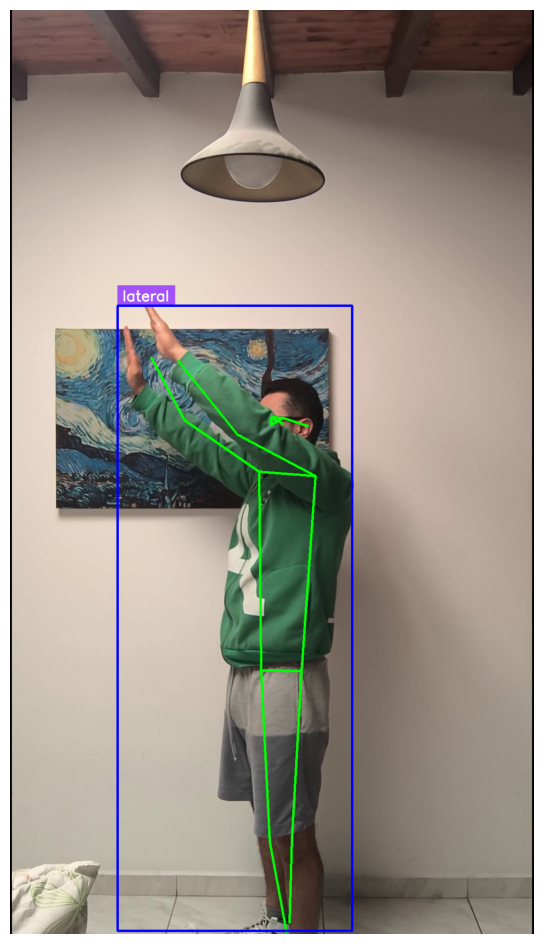

In [14]:
# ============================================================
# PARA ANOTAR (O.P.A. V4) — Incluye orientación, tronco y hombro–codo
# ============================================================

# Validar que exista un kp del último frame
try:
    kp_last = kp      # último kp procesado en la celda de pruebas
    det_last = detection
except NameError:
    raise RuntimeError("No hay un kp procesado. Ejecuta la celda de pruebas antes de usar PARA ANOTAR.")

print("KeyPoints cargados para el frame seleccionado:")
print(" - xy shape:", kp_last.xy.shape)
print(" - conf shape:", kp_last.confidence.shape)

# Mostrar campos adicionales si existen
if 'xyxy' in kp_last.data:
    print(" - bounding box:", kp_last['xyxy'])

if 'conf_cls' in kp_last.data:
    print(" - conf_cls:", kp_last['conf_cls'])

# ORIENTACIÓN
if 'orientacion' in kp_last.data:
    print("\n=== ORIENTACIÓN ===")
    print(kp_last['orientacion'])

# TRONCO
if 'tronco_rula' in kp_last.data:
    print("\n=== TRONCO RULA (por persona) ===")
    for idx, t in enumerate(kp_last['tronco_rula']):
        print(f"Persona {idx}: {t}")

# HOMBRO – CODO
if 'hombro_codo_rula' in kp_last.data:
    print("\n=== HOMBRO – CODO RULA (por persona) ===")
    for idx, hc in enumerate(kp_last['hombro_codo_rula']):
        print(f"\nPersona {idx}:")
        print("  - Izquierdo:", hc['izquierdo'])
        print("  - Derecho :", hc['derecho'])


# ===============================
# Visualización del frame - Keypoints + BBoxes
# ===============================

frame_ejemplo = annotated_images[-1]   # último frame anotado, igual que el kp_last

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=2)
annotated = edge_annotator.annotate(scene=frame_ejemplo.copy(), key_points=kp_last)

box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.BLUE)
annotated = box_annotator.annotate(annotated, det_last)

sv.plot_image(annotated)

In [15]:
import pandas as pd

# ================================================
# EXPORTACIÓN COMPLETA: TODOS LOS FRAMES + TODAS LAS PERSONAS
# ================================================

export_rows = []   # Lista donde se guardará cada registro

video_path = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\repo_yolo_pose\yolopose\VID_20251215_100048~2.mp4"

frame_index = 0
for batch_i, frames in enumerate(obtener_batches(video_path, batch_size=32)):
    print(f"\n🟦 Procesando Batch {batch_i+1} ({len(frames)} frames)…")

    results = model(frames)

    for result, frame in zip(results, frames):
        kp = sv.KeyPoints.from_ultralytics(result)

        # ---------------------
        # CAMPOS BASE YOLO/SV
        # ---------------------
        kp["xyxy"] = result.boxes.xyxy.cpu().numpy()
        kp["conf_cls"] = result.boxes.conf.cpu().numpy()

        # ---------------------
        # ORIENTACIÓN
        # ---------------------
        kp['orientacion'] = [
            detectar_orientacion_persona(
                kp.xy[i],
                kp.confidence[i]
            ) for i in range(len(kp))
        ]

        # ---------------------
        # TRONCO RULA
        # ---------------------
        kp['tronco_rula'] = [
            calcular_tronco_rula(
                xy = kp.xy[i],
                conf = kp.confidence[i],
                orientacion = kp['orientacion'][i]
            ) for i in range(len(kp))
        ]

        # ---------------------
        # HOMBRO – CODO RULA (Izq + Der)
        # ---------------------
        kp['hombro_codo_rula'] = [
            {
                "izquierdo": calcular_hombro_codo_rula(
                    xy = kp.xy[i],
                    conf = kp.confidence[i],
                    orientacion = kp['orientacion'][i],
                    lado = "izquierdo"
                ),
                "derecho": calcular_hombro_codo_rula(
                    xy = kp.xy[i],
                    conf = kp.confidence[i],
                    orientacion = kp['orientacion'][i],
                    lado = "derecho"
                )
            }
            for i in range(len(kp))
        ]

        # ================
        # EXPORTAR FILAS
        # ================
        for person_id in range(len(kp)):
            tronco = kp['tronco_rula'][person_id]
            hc = kp['hombro_codo_rula'][person_id]

            row = {
                "frame": frame_index,
                "persona_id": person_id,
                "orientacion": kp['orientacion'][person_id],

                # TRONCO
                "flexion_tronco_grados": tronco.get("flexion_tronco_grados"),
                "score_tronco_rula": tronco.get("score_rula_tronco_total"),

                # HOMBRO IZQ
                "hombro_izq_elevacion": hc["izquierdo"].get("elevacion_hombro_grados"),
                "hombro_izq_score": hc["izquierdo"].get("score_rula_hombro"),

                # CODO IZQ
                "codo_izq_flexion": hc["izquierdo"].get("flexion_codo_grados"),
                "codo_izq_score": hc["izquierdo"].get("score_rula_codo"),

                # HOMBRO DER
                "hombro_der_elevacion": hc["derecho"].get("elevacion_hombro_grados"),
                "hombro_der_score": hc["derecho"].get("score_rula_hombro"),

                # CODO DER
                "codo_der_flexion": hc["derecho"].get("flexion_codo_grados"),
                "codo_der_score": hc["derecho"].get("score_rula_codo"),
            }

            export_rows.append(row)

        frame_index += 1

# ================================================================
# Construir el DataFrame final
# ================================================================

df_export = pd.DataFrame(export_rows)
print("\n====================================")
print("EXPORTACIÓN COMPLETA GENERADA:")
print(df_export.head())
print("====================================")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_export)
print("\nTotal filas exportadas:", len(df_export))
print("Columnas:", df_export.columns.tolist())    

#Opcional: Exportar a Excel
df_export.to_excel("biorisk_export.xlsx", index=False)
print("Archivo exportado como biorisk_export.xlsx")


🟦 Procesando Batch 1 (32 frames)…

0: 640x384 1 person, 43.5ms
1: 640x384 1 person, 43.5ms
2: 640x384 1 person, 43.5ms
3: 640x384 1 person, 43.5ms
4: 640x384 1 person, 43.5ms
5: 640x384 1 person, 43.5ms
6: 640x384 1 person, 43.5ms
7: 640x384 1 person, 43.5ms
8: 640x384 1 person, 43.5ms
9: 640x384 1 person, 43.5ms
10: 640x384 1 person, 43.5ms
11: 640x384 1 person, 43.5ms
12: 640x384 1 person, 43.5ms
13: 640x384 1 person, 43.5ms
14: 640x384 1 person, 43.5ms
15: 640x384 1 person, 43.5ms
16: 640x384 1 person, 43.5ms
17: 640x384 1 person, 43.5ms
18: 640x384 1 person, 43.5ms
19: 640x384 1 person, 43.5ms
20: 640x384 1 person, 43.5ms
21: 640x384 1 person, 43.5ms
22: 640x384 1 person, 43.5ms
23: 640x384 1 person, 43.5ms
24: 640x384 1 person, 43.5ms
25: 640x384 1 person, 43.5ms
26: 640x384 1 person, 43.5ms
27: 640x384 1 person, 43.5ms
28: 640x384 1 person, 43.5ms
29: 640x384 1 person, 43.5ms
30: 640x384 1 person, 43.5ms
31: 640x384 1 person, 43.5ms
Speed: 2.5ms preprocess, 43.5ms inference, 0.4

In [101]:
#Validar que exista un kp del último frame
try:
    kp_last = kp      # último kp procesado en la celda de pruebas
    det_last = detection
except NameError:
    raise RuntimeError("No hay un kp procesado. Ejecuta la celda de pruebas antes de usar PARA ANOTAR.")

print("KeyPoints cargados para el frame seleccionado:")
print(" - xy shape:", kp_last.xy.shape)
print(" - conf shape:", kp_last.confidence.shape)

# Mostrar campos adicionales si existen
if 'xyxy' in kp_last.data:
    print(" - bounding box:", kp_last['xyxy'])

if 'conf_cls' in kp_last.data:
    print(" - conf_cls:", kp_last['conf_cls'])

if 'orientacion' in kp_last.data:
    print(" - orientacion:", kp_last['orientacion'])

if 'tronco_rula' in kp_last.data:
    print(" - tronco_rula:", kp_last['tronco_rula'])

# HOMBRO – CODO
if 'hombro_codo_rula' in kp_last.data:
    print("\n=== HOMBRO – CODO RULA (por persona) ===")
    for idx, hc in enumerate(kp_last['hombro_codo_rula']):
        print(f"\nPersona {idx}:")
        print("  - Izquierdo:", hc['izquierdo'])
        print("  - Derecho :", hc['derecho'])    

# ===============================
# Visualización del frame - Keypoints + BBoxes
# ===============================

frame_ejemplo = annotated_images[-1]   # último frame anotado, igual que el kp_last

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=2)
annotated = edge_annotator.annotate(scene=frame_ejemplo.copy(), key_points=kp_last)

box_annotator = sv.BoxAnnotator(thickness=3, color=sv.Color.BLUE)
# annotated = box_annotator.annotate(annotated, det_last)

sv.plot_image(annotated)

KeyPoints cargados para el frame seleccionado:
 - xy shape: (1, 17, 2)
 - conf shape: (1, 17)
 - bounding box: [[     362.49      766.95      867.45        1920]]
 - conf_cls: [     0.9415]
 - orientacion: ['frontal']
 - tronco_rula: [TroncoRULA(FRONTAL, inclin=False, rot=False, score=1)]


IndexError: list index out of range

"""
 BLOQUE 1: IMPORTACIONES Y CONFIGURACIÓN DEL ENTORNO
================================================================
Configuración inicial del entorno YOLO v11 para detección de posturas.
Incluye verificación de compatibilidad y preparación para análisis escalable.
"""

In [ ]:
# 📦Bloque 1  IMPORTACIONES DEL SISTEMA Y UTILIDADES BÁSICAS

import sys, platform, os, json, time, logging
import warnings
from datetime import datetime
from pathlib import Path
from math import degrees, acos, sqrt

# 🔇 Suprimir warnings para ejecución limpia
warnings.filterwarnings("ignore")
# ✅ MEJORA: Agregar supresión específica para PyTorch en CPU
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")


# 🧠 LIBRERÍAS DE MACHINE LEARNING Y VISIÓN COMPUTACIONAL  

import torch, torchvision
import cv2
import numpy as np
from ultralytics import YOLO

# ✅ MEJORA: Verificar versión mínima requerida de ultralytics
try:
    from ultralytics import __version__ as ultralytics_version
    print(f"Ultralytics: {ultralytics_version}")
except ImportError:
    print("Ultralytics: Versión no disponible")

# ═══════════════════════════════════════════════════════════════
# 📊 LIBRERÍAS DE ANÁLISIS DE DATOS Y VISUALIZACIÓN
# ═══════════════════════════════════════════════════════════════
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ MEJORA: Configurar matplotlib para mejor compatibilidad
plt.rcParams['figure.figsize'] = (10, 6)  # Tamaño por defecto
plt.rcParams['font.size'] = 10             # Tamaño de fuente legible

# ═══════════════════════════════════════════════════════════════
# 🔍 VERIFICACIÓN DE COMPATIBILIDAD DEL ENTORNO
# ═══════════════════════════════════════════════════════════════
def verificar_entorno():
    """
    Verifica la compatibilidad del entorno y muestra información del sistema.
    Prepara el entorno para análisis escalable (futuro: umbral relativizado).
    
    Returns:
        dict: Información del sistema para logging/debugging
    """
    info_sistema = {
        'python_version': sys.version.split()[0],
        'platform': platform.platform(),
        'cuda_available': torch.cuda.is_available(),
        'torch_version': torch.__version__,
        'torchvision_version': torchvision.__version__,
        'opencv_version': cv2.__version__
    }
    
    print("=" * 60)
    print("🎯 VERIFICACIÓN DEL ENTORNO - YOLO v11 POSE DETECTION")
    print("=" * 60)
    print(f"Python        : {info_sistema['python_version']}")
    print(f"SO            : {info_sistema['platform']}")
    print(f"CUDA disponible: {info_sistema['cuda_available']}")
    print(f"PyTorch       : {info_sistema['torch_version']}")
    print(f"TorchVision   : {info_sistema['torchvision_version']}")
    print(f"OpenCV        : {info_sistema['opencv_version']}")
    
    # ⚠️ VALIDACIONES CRÍTICAS
    validaciones = []
    
    # Verificar versión de Python
    if sys.version_info < (3, 7):
        validaciones.append("❌ Python 3.7+ requerido")
    else:
        validaciones.append("✅ Versión de Python compatible")
    
    # Verificar OpenCV
    cv_version = tuple(map(int, cv2.__version__.split('.')))
    if cv_version < (4, 5):
        validaciones.append("⚠️ OpenCV 4.5+ recomendado")
    else:
        validaciones.append("✅ OpenCV compatible")
    
    # Verificar PyTorch
    torch_version = tuple(map(int, torch.__version__.split('+')[0].split('.')))
    if torch_version < (2, 0):
        validaciones.append("⚠️ PyTorch 2.0+ recomendado")
    else:
        validaciones.append("✅ PyTorch compatible")
    
    print("\n🔍 VALIDACIONES:")
    for validacion in validaciones:
        print(f"  {validacion}")
    
    print("=" * 60)
    
    return info_sistema

# Ejecutar verificación
info_entorno = verificar_entorno()

# ═══════════════════════════════════════════════════════════════
# 📝 CONFIGURACIÓN DE LOGGING AVANZADA
# ═══════════════════════════════════════════════════════════════
def configurar_logging(nivel=logging.INFO, archivo_log=None):
    """
    Configura logging para el proyecto con formato mejorado.
    
    Args:
        nivel: Nivel de logging (INFO, DEBUG, WARNING, ERROR)
        archivo_log: Ruta opcional para guardar logs en archivo
    """
    # Formato mejorado con colores en consola
    formato_consola = "%(asctime)s | %(levelname)-8s | %(message)s"
    formato_fecha = "%Y-%m-%d %H:%M:%S"
    
    # Configurar handlers
    handlers = [logging.StreamHandler()]
    
    # ✅ MEJORA: Opción de guardar logs en archivo
    if archivo_log:
        log_path = Path(archivo_log)
        log_path.parent.mkdir(exist_ok=True)
        handlers.append(logging.FileHandler(log_path))
    
    logging.basicConfig(
        level=nivel,
        format=formato_consola,
        datefmt=formato_fecha,
        handlers=handlers,
        force=True  # ✅ Fuerza reconfiguración si ya existe
    )
    
    return logging.getLogger(__name__)

# Configurar logger del proyecto
logger = configurar_logging(
    nivel=logging.INFO,
    archivo_log=f"logs/yolo_pose_detection_{datetime.now().strftime('%Y%m%d')}.log"
)

# ═══════════════════════════════════════════════════════════════
# 🎯 CONSTANTES GLOBALES PARA ANÁLISIS ESCALABLE
# ═══════════════════════════════════════════════════════════════
# ✅ PREPARACIÓN PARA UMBRAL RELATIVIZADO (futuro)
KEYPOINTS_MIEMBROS_SUPERIORES = {
    'hombro_izq': 5, 'hombro_der': 6,      # Línea de referencia actual
    'codo_izq': 7,   'codo_der': 8,        # Puntos de detección principal
    'muneca_izq': 9, 'muneca_der': 10      # Puntos de detección secundaria
}

# ✅ PREPARADO PARA FUTURO: Keypoints del tronco para normalización
KEYPOINTS_TRONCO_REFERENCIA = {
    'hombro_izq': 5, 'hombro_der': 6,      # Línea superior del tronco
    'cadera_izq': 11, 'cadera_der': 12     # Línea inferior del tronco (futuro)
}

# Modo de análisis actual (preparado para escalabilidad)
MODO_ANALISIS = "simple"  # ✅ CRÍTICO: Variable global que faltaba

logger.info("🎯 Entorno verificado y configurado correctamente")
logger.info(f"📊 Modo de análisis activo: {MODO_ANALISIS.upper()}")
logger.info("🚀 Sistema listo para cargar modelo YOLO v11")


"""
🤖 BLOQUE 2: CONFIGURACIÓN Y CARGA DEL MODELO YOLO v11
================================================================
Configuración de parámetros, selección de modelo y carga optimizada.
Incluye manejo de errores y preparación para análisis escalable.
"""

In [ ]:
# 🎯Bloque 2  CONFIGURACIÓN DE MODELOS DISPONIBLES
# ═══════════════════════════════════════════════════════════════
# Modelos YOLO v11 Pose disponibles (se descargan automáticamente)
MODELOS_DISPONIBLES = {
    "rapido": {
        "archivo": "yolo11n-pose.pt",
        "descripcion": "YOLOv11 Nano - Rápido, menor precisión",
        "tamaño_mb": "~6MB",
        "fps_estimado": "60-80 FPS"
    },
    "preciso": {
        "archivo": "yolo11s-pose.pt", 
        "descripcion": "YOLOv11 Small - Mayor precisión, más lento",
        "tamaño_mb": "~22MB",
        "fps_estimado": "40-60 FPS"
    },
    # ✅ PREPARADO PARA FUTURO: Modelos adicionales
    "medio": {
        "archivo": "yolo11m-pose.pt",
        "descripcion": "YOLOv11 Medium - Balance precisión/velocidad",
        "tamaño_mb": "~50MB", 
        "fps_estimado": "25-40 FPS"
    }
}

# ═══════════════════════════════════════════════════════════════
# ⚙️ SELECCIÓN DEL MODELO
# ═══════════════════════════════════════════════════════════════
# ✅ MEJORA: Función para seleccionar modelo con validación
def seleccionar_modelo(tipo_modelo="rapido"):
    """
    Selecciona y valida el modelo a utilizar.
    
    Args:
        tipo_modelo (str): "rapido", "preciso", o "medio"
        
    Returns:
        tuple: (archivo_modelo, info_modelo)
    """
    if tipo_modelo not in MODELOS_DISPONIBLES:
        logger.warning(f"Modelo '{tipo_modelo}' no válido. Usando 'rapido' por defecto.")
        tipo_modelo = "rapido"
    
    modelo_info = MODELOS_DISPONIBLES[tipo_modelo]
    logger.info(f"🎯 Modelo seleccionado: {tipo_modelo.upper()}")
    logger.info(f"   📁 Archivo: {modelo_info['archivo']}")
    logger.info(f"   📊 Descripción: {modelo_info['descripcion']}")
    logger.info(f"   💾 Tamaño: {modelo_info['tamaño_mb']}")
    logger.info(f"   ⚡ Rendimiento: {modelo_info['fps_estimado']}")
    
    return modelo_info['archivo'], modelo_info

# Seleccionar modelo (puedes cambiar entre "rapido", "preciso", "medio")
TIPO_MODELO_ACTUAL = "rapido"  # ✅ CONFIGURABLE: Cambiar aquí para otro modelo
MODEL_WEIGHTS, MODEL_INFO = seleccionar_modelo(TIPO_MODELO_ACTUAL)

# ═══════════════════════════════════════════════════════════════
# 🎛️ PARÁMETROS GLOBALES DE DETECCIÓN
# ═══════════════════════════════════════════════════════════════
class ConfiguracionDeteccion:
    """
    Configuración centralizada para detección de poses.
    Preparado para escalabilidad y fácil ajuste de parámetros.
    """
    
    # 🔍 PARÁMETROS DE CONFIANZA
    CONF_THRESH = 0.25      # Confianza mínima para detectar persona (0.0-1.0)
    KEYP_CONF = 0.50        # Umbral para considerar keypoints válidos (0.0-1.0)
    IOU_THRESH = 0.45       # Intersección sobre unión para NMS (0.0-1.0)
    
    # 🎯 PARÁMETROS ESPECÍFICOS PARA MIEMBROS SUPERIORES
    MIN_CONF_HOMBROS = 0.6  # ✅ NUEVO: Confianza mínima para hombros (críticos)
    MIN_CONF_CODOS = 0.5    # ✅ NUEVO: Confianza mínima para codos
    MIN_CONF_MUNECAS = 0.4  # ✅ NUEVO: Confianza mínima para muñecas (más variables)
    
    # 🏗️ PREPARADO PARA FUTURO: Parámetros umbral relativizado
    MIN_CONF_TRONCO = 0.6           # Confianza mínima para keypoints del tronco
    ALTURA_TRONCO_REFERENCIA = 100  # Altura estándar del tronco en píxeles
    FACTOR_NORMALIZACION = 1.0      # Factor de corrección (ajustable)
    
    @classmethod
    def mostrar_configuracion(cls):
        """Muestra la configuración actual en logs."""
        logger.info("⚙️ CONFIGURACIÓN DE DETECCIÓN:")
        logger.info(f"   🎯 Confianza general: {cls.CONF_THRESH}")
        logger.info(f"   🔍 Confianza keypoints: {cls.KEYP_CONF}")
        logger.info(f"   📐 IoU threshold: {cls.IOU_THRESH}")
        logger.info(f"   💪 Confianza hombros: {cls.MIN_CONF_HOMBROS}")
        logger.info(f"   🔧 Confianza codos: {cls.MIN_CONF_CODOS}")
        logger.info(f"   ✋ Confianza muñecas: {cls.MIN_CONF_MUNECAS}")

# Instanciar configuración
config = ConfiguracionDeteccion()

# ═══════════════════════════════════════════════════════════════
# 🖥️ CONFIGURACIÓN DE DISPOSITIVO
# ═══════════════════════════════════════════════════════════════
def configurar_dispositivo():
    """
    Configura automáticamente el mejor dispositivo disponible.
    
    Returns:
        str: Dispositivo seleccionado ("cuda:0", "mps", o "cpu")
    """
    if torch.cuda.is_available():
        device = "cuda:0"
        gpu_name = torch.cuda.get_device_name(0)
        memoria_gpu = torch.cuda.get_device_properties(0).total_memory / 1024**3
        logger.info(f"🚀 GPU CUDA detectada: {gpu_name}")
        logger.info(f"💾 Memoria GPU: {memoria_gpu:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = "mps"  # Apple Silicon
        logger.info("🍎 Dispositivo MPS (Apple Silicon) detectado")
    else:
        device = "cpu"
        logger.info("💻 Usando CPU (sin aceleración GPU)")
    
    return device

# ═══════════════════════════════════════════════════════════════
# 🤖 CARGA DEL MODELO CON MANEJO DE ERRORES
# ═══════════════════════════════════════════════════════════════
def cargar_modelo_yolo(model_weights, device):
    """
    Carga el modelo YOLO con manejo de errores robusto.
    
    Args:
        model_weights (str): Ruta del modelo
        device (str): Dispositivo objetivo
        
    Returns:
        YOLO: Modelo cargado y configurado
    """
    try:
        logger.info(f"📥 Descargando/cargando modelo: {model_weights}")
        logger.info("⏳ Primera ejecución puede tardar (descarga automática)...")
        
        # ✅ MEJORA: Crear modelo con configuración explícita
        model = YOLO(model_weights)
        
        # Mover al dispositivo seleccionado
        model.to(device)
        
        # ✅ MEJORA: Verificar que el modelo es para pose detection
        if not hasattr(model, 'names') or len(model.names) == 0:
            logger.warning("⚠️ Modelo cargado sin nombres de clases")
        
        # ✅ MEJORA: Configurar parámetros del modelo
        model.overrides['conf'] = config.CONF_THRESH
        model.overrides['iou'] = config.IOU_THRESH
        
        logger.info(f"✅ Modelo cargado exitosamente en: {device}")
        
        # ✅ MEJORA: Test rápido del modelo
        logger.info("🧪 Realizando test de funcionamiento...")
        test_input = torch.randn(1, 3, 640, 640).to(device)
        with torch.no_grad():
            _ = model(test_input, verbose=False)
        logger.info("✅ Test del modelo completado correctamente")
        
        return model
        
    except Exception as e:
        logger.error(f"❌ Error cargando modelo: {str(e)}")
        logger.error("💡 Soluciones posibles:")
        logger.error("   1. Verificar conexión a internet (descarga automática)")
        logger.error("   2. Limpiar cache: rm -rf ~/.cache/ultralytics/")
        logger.error("   3. Reinstalar ultralytics: pip install --upgrade ultralytics")
        raise e

# ═══════════════════════════════════════════════════════════════
# 🚀 INICIALIZACIÓN PRINCIPAL
# ═══════════════════════════════════════════════════════════════
# Configurar dispositivo
device = configurar_dispositivo()

# Mostrar configuración actual
config.mostrar_configuracion()

# Cargar modelo
logger.info("=" * 60)
logger.info("🤖 INICIALIZANDO MODELO YOLO v11")
logger.info("=" * 60)

model = cargar_modelo_yolo(MODEL_WEIGHTS, device)

# ✅ MEJORA: Información final del sistema
logger.info("=" * 60)
logger.info("🎯 SISTEMA COMPLETAMENTE INICIALIZADO")
logger.info("=" * 60)
logger.info(f"📍 Modelo: {TIPO_MODELO_ACTUAL.upper()} ({MODEL_WEIGHTS})")
logger.info(f"🖥️ Dispositivo: {device}")
logger.info(f"🎛️ Modo análisis: {MODO_ANALISIS.upper()}")
logger.info("🚀 Listo para detección de posturas - miembros superiores")
logger.info("=" * 60)

# ✅ PREPARADO PARA FUTURO: Variables globales para umbral relativizado
SISTEMA_INICIALIZADO = True
MODELO_CARGADO = model
DISPOSITIVO_ACTIVO = device
CONFIGURACION_ACTIVA = config

# 🧠 BLOQUE 0 CORE - FUNCIONES BASE Y VALIDACIÓN


supervision key point

In [ ]:
# 🛡️ FUNCIONES DE VALIDACIÓN SEGURAS
# ═══════════════════════════════════════════════════════════════

def validar_keypoint_individual(keypoint, indice, min_conf=0.5):
    """
    Valida un keypoint individual de manera exhaustiva.
    
    Args:
        keypoint: Array [x, y, confianza]
        indice (int): Índice del keypoint para logging
        min_conf (float): Confianza mínima requerida
        
    Returns:
        dict: {
            'valido': bool,
            'error': str or None,
            'coordenadas': [x, y] or None,
            'confianza': float,
            'es_origen': bool  # True si está en (0,0) real
        }
    """
    resultado = {
        'valido': False,
        'error': None,
        'coordenadas': None,
        'confianza': 0.0,
        'es_origen': False
    }
    
    try:
        # Verificar estructura básica
        if keypoint is None or len(keypoint) < 3:
            resultado['error'] = f"keypoint[{indice}] estructura inválida"
            return resultado
            
        x, y, conf = keypoint[0], keypoint[1], keypoint[2]
        resultado['confianza'] = float(conf)
        
        # Verificar confianza
        if conf < min_conf:
            resultado['error'] = f"keypoint[{indice}] confianza {conf:.3f} < {min_conf}"
            return resultado
            
        # Verificar coordenadas válidas
        if np.isnan(x) or np.isnan(y):
            resultado['error'] = f"keypoint[{indice}] contiene NaN: ({x}, {y})"
            return resultado
            
        if np.isinf(x) or np.isinf(y):
            resultado['error'] = f"keypoint[{indice}] contiene infinito: ({x}, {y})"
            return resultado
        
        # Verificar si está en origen (puede ser válido en algunos casos)
        if abs(x) < 1e-6 and abs(y) < 1e-6:
            resultado['es_origen'] = True
            # No es automáticamente inválido, pero se reporta
            
        # Coordenadas válidas
        resultado['valido'] = True
        resultado['coordenadas'] = [float(x), float(y)]
        
    except Exception as e:
        resultado['error'] = f"keypoint[{indice}] excepción: {str(e)}"
        
    return resultado

def validar_conjunto_keypoints(keypoints, indices_requeridos, nombres, min_conf_dict):
    """
    Valida un conjunto de keypoints necesarios para un cálculo.
    
    Args:
        keypoints: Array completo de keypoints
        indices_requeridos: Lista de índices necesarios
        nombres: Lista de nombres correspondientes 
        min_conf_dict: Dict con confianzas mínimas por tipo
        
    Returns:
        dict: {
            'todos_validos': bool,
            'keypoints_validos': dict,  # índice -> validación individual
            'keypoints_faltantes': list,
            'diagnostico_detallado': dict
        }
    """
    resultado = {
        'todos_validos': False,
        'keypoints_validos': {},
        'keypoints_faltantes': [],
        'diagnostico_detallado': {
            'total_requeridos': len(indices_requeridos),
            'validos': 0,
            'con_advertencias': 0,
            'errores': []
        }
    }
    
    try:
        # Verificar longitud suficiente del array
        if len(keypoints) <= max(indices_requeridos):
            resultado['diagnostico_detallado']['errores'].append(
                f"Array keypoints insuficiente: len={len(keypoints)}, necesita >{max(indices_requeridos)}"
            )
            return resultado
            
        # Validar cada keypoint individualmente
        for i, (indice, nombre) in enumerate(zip(indices_requeridos, nombres)):
            # Determinar confianza mínima para este tipo de keypoint
            if 'hombro' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_HOMBROS', 0.6)
            elif 'codo' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_CODOS', 0.5)  
            elif 'cadera' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_TRONCO', 0.6)
            else:
                min_conf = min_conf_dict.get('KEYP_CONF', 0.5)
                
            validacion = validar_keypoint_individual(keypoints[indice], indice, min_conf)
            resultado['keypoints_validos'][indice] = validacion
            
            if not validacion['valido']:
                resultado['keypoints_faltantes'].append({
                    'indice': indice,
                    'nombre': nombre,
                    'error': validacion['error']
                })
                resultado['diagnostico_detallado']['errores'].append(validacion['error'])
            else:
                resultado['diagnostico_detallado']['validos'] += 1
                if validacion['es_origen']:
                    resultado['diagnostico_detallado']['con_advertencias'] += 1
                    
        # Determinar si todos son válidos
        resultado['todos_validos'] = len(resultado['keypoints_faltantes']) == 0
        
    except Exception as e:
        resultado['diagnostico_detallado']['errores'].append(f"Excepción validación: {str(e)}")
        
    return resultado

# 📐 FUNCIONES DE CÁLCULO GEOMÉTRICO SEGURAS
# ═══════════════════════════════════════════════════════════════

def calcular_centro_seguro(punto1, punto2, nombre_calculo="centro"):
    """
    Calcula el centro entre dos puntos con validación completa.
    
    Returns:
        dict: {
            'exito': bool,
            'centro': [x, y] or None,
            'error': str or None,
            'es_origen': bool
        }
    """
    resultado = {
        'exito': False,
        'centro': None,
        'error': None,
        'es_origen': False
    }
    
    try:
        if punto1 is None or punto2 is None:
            resultado['error'] = f"{nombre_calculo}: uno de los puntos es None"
            return resultado
            
        if len(punto1) < 2 or len(punto2) < 2:
            resultado['error'] = f"{nombre_calculo}: puntos sin coordenadas suficientes"
            return resultado
            
        # Calcular centro
        centro_x = (punto1[0] + punto2[0]) / 2.0
        centro_y = (punto1[1] + punto2[1]) / 2.0
        
        # Validar resultado  
        if np.isnan(centro_x) or np.isnan(centro_y):
            resultado['error'] = f"{nombre_calculo}: resultado contiene NaN"
            return resultado
            
        if np.isinf(centro_x) or np.isinf(centro_y):
            resultado['error'] = f"{nombre_calculo}: resultado contiene infinito"
            return resultado
            
        # Verificar si es origen (puede ser válido)
        if abs(centro_x) < 1e-6 and abs(centro_y) < 1e-6:
            resultado['es_origen'] = True
            
        resultado['exito'] = True
        resultado['centro'] = [float(centro_x), float(centro_y)]
        
    except Exception as e:
        resultado['error'] = f"{nombre_calculo}: excepción {str(e)}"
        
    return resultado

def detectar_orientacion_persona(keypoints, config_activa=None):
    """
    Detecta orientación de la persona basándose en TRONCO (hombros + caderas).
    Sistema multi-criterio robusto con normalización por tamaño de persona.
    
    REGLAS CLARAS:
    - LATERAL: dist_norm < 0.35 (un hombro oculta al otro)
    - FRONTAL: dist_norm > 0.65 (ambos hombros claramente visibles)
    - DIAGONAL: 0.35 ≤ dist_norm ≤ 0.65 (vista intermedia)
    
    CRITERIOS DE DECISIÓN (en orden de prioridad):
    1. Distancia hombros normalizada por altura_tronco (PRINCIPAL)
    2. Ratio hombros/caderas (CONFIRMACIÓN: >1.4 indica frontal)
    3. Simetría bilateral (DETECCIÓN oclusión)
    4. Orejas visibles (BOOST confianza)
    
    Args:
        keypoints: Array de keypoints YOLO [17, 3] con [x, y, confianza]
        config_activa: Configuración opcional
        
    Returns:
        dict: {
            'orientacion': 'frontal'/'lateral'/'diagonal'/'no_detectado',
            'confianza': float (0.0-1.0),
            'metodo': str,
            'metricas': dict,
            'validaciones': dict,
            'diagnostico': list[str]
        }
    """
    # ═══════════════════════════════════════════════════════════
    # CONSTANTES
    # ═══════════════════════════════════════════════════════════
    OREJA_IZQ, OREJA_DER = 3, 4
    HOMBRO_IZQ, HOMBRO_DER = 5, 6
    CADERA_IZQ, CADERA_DER = 11, 12
    
    MIN_CONF_CRITICA = 0.6
    MIN_CONF_AUXILIAR = 0.4
    
    # Umbrales normalizados (dist_hombros / altura_tronco)
    UMBRAL_LATERAL = 0.35      # < 0.35 = lateral puro
    UMBRAL_FRONTAL = 0.65      # > 0.65 = frontal puro
    # Entre 0.35-0.65 = diagonal
    
    # Umbral ratio para fallback
    UMBRAL_RATIO_ROTACION = 1.4  # > 1.4 indica probable frontal con rotación
    
    # ═══════════════════════════════════════════════════════════
    # INICIALIZACIÓN
    # ═══════════════════════════════════════════════════════════
    resultado = {
        'orientacion': 'no_detectado',
        'confianza': 0.0,
        'metodo': 'multi_criterio_tronco',
        'metricas': {
            'dist_hombros': 0.0,
            'dist_hombros_normalizada': 0.0,
            'dist_caderas': 0.0,
            'ratio_hombros_caderas': 0.0,
            'simetria_hombros': 0.0,
            'simetria_caderas': 0.0,
            'altura_tronco': 0.0
        },
        'validaciones': {
            'hombros_validos': False,
            'caderas_validas': False,
            'keypoints_inferidos_detectados': False
        },
        'diagnostico': []
    }
    
    try:
        # ═══════════════════════════════════════════════════════════
        # FASE 1: VALIDAR HOMBROS (CRÍTICO)
        # ═══════════════════════════════════════════════════════════
        hombro_izq = keypoints[HOMBRO_IZQ]
        hombro_der = keypoints[HOMBRO_DER]
        
        conf_hombro_izq = float(hombro_izq[2])
        conf_hombro_der = float(hombro_der[2])
        
        if conf_hombro_izq < MIN_CONF_CRITICA or conf_hombro_der < MIN_CONF_CRITICA:
            resultado['diagnostico'].append(
                f"❌ Hombros confianza insuficiente: izq={conf_hombro_izq:.2f}, der={conf_hombro_der:.2f}"
            )
            return resultado
        
        resultado['validaciones']['hombros_validos'] = True
        
        # Coordenadas
        coord_hombro_izq = hombro_izq[:2]
        coord_hombro_der = hombro_der[:2]
        
        # ═══════════════════════════════════════════════════════════
        # FASE 2: VALIDAR CADERAS (IMPORTANTE PARA NORMALIZACIÓN)
        # ═══════════════════════════════════════════════════════════
        cadera_izq = keypoints[CADERA_IZQ]
        cadera_der = keypoints[CADERA_DER]
        
        conf_cadera_izq = float(cadera_izq[2])
        conf_cadera_der = float(cadera_der[2])
        
        caderas_validas = (conf_cadera_izq >= MIN_CONF_CRITICA and 
                          conf_cadera_der >= MIN_CONF_CRITICA)
        
        coord_cadera_izq = cadera_izq[:2]
        coord_cadera_der = cadera_der[:2]
        
        # ═══════════════════════════════════════════════════════════
        # FASE 3: CALCULAR ALTURA DEL TRONCO (PRIMERO - ESENCIAL)
        # ═══════════════════════════════════════════════════════════
        altura_tronco = 0.0
        
        if caderas_validas:
            # Altura tronco = distancia vertical entre centro hombros y centro caderas
            centro_hombros_y = (coord_hombro_izq[1] + coord_hombro_der[1]) / 2
            centro_caderas_y = (coord_cadera_izq[1] + coord_cadera_der[1]) / 2
            altura_tronco = abs(centro_caderas_y - centro_hombros_y)
            
            resultado['metricas']['altura_tronco'] = float(altura_tronco)
            resultado['validaciones']['caderas_validas'] = True
            
            resultado['diagnostico'].append(f"✓ Altura tronco: {altura_tronco:.1f}px")
        else:
            # Fallback: estimar altura_tronco como 1.5x dist_hombros
            # (proporción corporal típica)
            dist_hombros_temp = np.sqrt(
                (coord_hombro_der[0] - coord_hombro_izq[0])**2 + 
                (coord_hombro_der[1] - coord_hombro_izq[1])**2
            )
            altura_tronco = dist_hombros_temp * 1.5
            resultado['metricas']['altura_tronco'] = float(altura_tronco)
            resultado['diagnostico'].append(
                f"⚠️ Caderas no válidas - altura estimada: {altura_tronco:.1f}px"
            )
        
        # ═══════════════════════════════════════════════════════════
        # FASE 4: CALCULAR DISTANCIAS
        # ═══════════════════════════════════════════════════════════
        # Distancia euclidiana hombros
        dist_hombros = np.sqrt(
            (coord_hombro_der[0] - coord_hombro_izq[0])**2 + 
            (coord_hombro_der[1] - coord_hombro_izq[1])**2
        )
        resultado['metricas']['dist_hombros'] = float(dist_hombros)
        
        # NORMALIZAR por altura del tronco (CRÍTICO para robustez)
        if altura_tronco > 0:
            dist_hombros_norm = dist_hombros / altura_tronco
        else:
            # Fallback extremo: sin normalización
            dist_hombros_norm = 0.5  # Neutral
            resultado['diagnostico'].append("⚠️ Sin altura_tronco - clasificación degradada")
        
        resultado['metricas']['dist_hombros_normalizada'] = float(dist_hombros_norm)
        resultado['diagnostico'].append(
            f"Dist hombros: {dist_hombros:.1f}px, normalizada: {dist_hombros_norm:.2f}"
        )
        
        # Distancia caderas (si disponible)
        if caderas_validas:
            dist_caderas = np.sqrt(
                (coord_cadera_der[0] - coord_cadera_izq[0])**2 + 
                (coord_cadera_der[1] - coord_cadera_izq[1])**2
            )
            resultado['metricas']['dist_caderas'] = float(dist_caderas)
            
            # Ratio hombros/caderas
            if dist_caderas > 1:
                ratio_hc = dist_hombros / dist_caderas
                resultado['metricas']['ratio_hombros_caderas'] = float(ratio_hc)
                resultado['diagnostico'].append(f"Ratio h/c: {ratio_hc:.2f}")
        
        # Simetría hombros (detecta oclusión)
        simetria_hombros = 1.0 - abs(conf_hombro_izq - conf_hombro_der)
        resultado['metricas']['simetria_hombros'] = float(simetria_hombros)
        
        if caderas_validas:
            simetria_caderas = 1.0 - abs(conf_cadera_izq - conf_cadera_der)
            resultado['metricas']['simetria_caderas'] = float(simetria_caderas)
        
        # ═══════════════════════════════════════════════════════════
        # FASE 5: DETECTAR KEYPOINTS INFERIDOS
        # ═══════════════════════════════════════════════════════════
        asimetria_conf = abs(conf_hombro_izq - conf_hombro_der)
        
        if asimetria_conf > 0.3:
            resultado['validaciones']['keypoints_inferidos_detectados'] = True
            resultado['diagnostico'].append(
                f"⚠️ Asimetría confianza: {asimetria_conf:.2f} (posible keypoint inferido)"
            )
        
        # ═══════════════════════════════════════════════════════════
        # FASE 6: CLASIFICACIÓN ORIENTACIÓN (SISTEMA SCORING)
        # ═══════════════════════════════════════════════════════════
        scores_frontal = []
        scores_lateral = []
        pesos = []
        
        # ═══════════════════════════════════════════════════════════
        # CRITERIO 1: DISTANCIA NORMALIZADA (PESO 4 - PRINCIPAL)
        # ═══════════════════════════════════════════════════════════
        if dist_hombros_norm > UMBRAL_FRONTAL:  # > 0.65
            scores_frontal.append(1.0)
            scores_lateral.append(0.0)
            pesos.append(4.0)
            resultado['diagnostico'].append(
                f"✓ Criterio 1: FRONTAL (norm={dist_hombros_norm:.2f} > {UMBRAL_FRONTAL})"
            )
        elif dist_hombros_norm < UMBRAL_LATERAL:  # < 0.35
            scores_frontal.append(0.0)
            scores_lateral.append(1.0)
            pesos.append(4.0)
            resultado['diagnostico'].append(
                f"✓ Criterio 1: LATERAL (norm={dist_hombros_norm:.2f} < {UMBRAL_LATERAL})"
            )
        else:  # 0.35 <= norm <= 0.65
            scores_frontal.append(0.5)
            scores_lateral.append(0.5)
            pesos.append(4.0)
            resultado['diagnostico'].append(
                f"⚠️ Criterio 1: DIAGONAL (norm={dist_hombros_norm:.2f} en zona intermedia)"
            )
        
        # ═══════════════════════════════════════════════════════════
        # CRITERIO 2: RATIO HOMBROS/CADERAS (PESO 3 - CONFIRMACIÓN)
        # ═══════════════════════════════════════════════════════════
        if resultado['metricas']['ratio_hombros_caderas'] > 0:
            ratio = resultado['metricas']['ratio_hombros_caderas']
            
            if ratio > 1.4:
                # Ratio MUY alto → hombros desproporcionados → frontal con rotación
                scores_frontal.append(1.0)
                scores_lateral.append(0.0)
                pesos.append(3.0)
                resultado['diagnostico'].append(
                    f"✓ Criterio 2: FRONTAL confirmado (ratio={ratio:.2f} > 1.4)"
                )
            elif 1.0 <= ratio <= 1.3:
                # Ratio normal frontal
                scores_frontal.append(0.9)
                scores_lateral.append(0.1)
                pesos.append(3.0)
            elif 0.8 <= ratio < 1.0:
                # Ratio indica lateral
                scores_frontal.append(0.2)
                scores_lateral.append(0.8)
                pesos.append(3.0)
            elif ratio < 0.8:
                # Ratio muy bajo → lateral
                scores_frontal.append(0.0)
                scores_lateral.append(1.0)
                pesos.append(3.0)
            else:
                # Ratio extraño (>1.3 pero <1.4)
                scores_frontal.append(0.7)
                scores_lateral.append(0.3)
                pesos.append(2.0)
        
        # ═══════════════════════════════════════════════════════════
        # CRITERIO 3: SIMETRÍA BILATERAL (PESO 2 - DETECCIÓN OCLUSIÓN)
        # ═══════════════════════════════════════════════════════════
        if simetria_hombros > 0.85:
            # Alta simetría → ambos hombros igualmente visibles → frontal
            scores_frontal.append(0.8)
            scores_lateral.append(0.2)
            pesos.append(2.0)
            resultado['diagnostico'].append(
                f"✓ Criterio 3: Alta simetría ({simetria_hombros:.2f}) → indica frontal"
            )
        elif simetria_hombros < 0.6:
            # Baja simetría → un hombro oculto → lateral
            scores_frontal.append(0.1)
            scores_lateral.append(0.9)
            pesos.append(2.0)
            resultado['diagnostico'].append(
                f"✓ Criterio 3: Baja simetría ({simetria_hombros:.2f}) → indica lateral"
            )
        
        # ═══════════════════════════════════════════════════════════
        # CRITERIO 4: OREJAS VISIBLES (PESO 1 - BOOST CONFIANZA)
        # ═══════════════════════════════════════════════════════════
        oreja_izq_conf = float(keypoints[OREJA_IZQ][2])
        oreja_der_conf = float(keypoints[OREJA_DER][2])
        
        if oreja_izq_conf > MIN_CONF_AUXILIAR and oreja_der_conf > MIN_CONF_AUXILIAR:
            # Ambas orejas → frontal
            scores_frontal.append(0.9)
            scores_lateral.append(0.0)
            pesos.append(1.0)
            resultado['diagnostico'].append("✓ Criterio 4: Ambas orejas visibles → boost frontal")
        elif (oreja_izq_conf < MIN_CONF_AUXILIAR) != (oreja_der_conf < MIN_CONF_AUXILIAR):
            # Solo una oreja → lateral
            scores_frontal.append(0.0)
            scores_lateral.append(0.9)
            pesos.append(1.0)
            resultado['diagnostico'].append("✓ Criterio 4: Solo una oreja → boost lateral")
        
        # ═══════════════════════════════════════════════════════════
        # FASE 7: DECISIÓN FINAL (PROMEDIO PONDERADO)
        # ═══════════════════════════════════════════════════════════
        if len(scores_frontal) == 0 or sum(pesos) == 0:
            resultado['diagnostico'].append("❌ Insuficientes criterios")
            return resultado
        
        # Promedio ponderado
        score_frontal_final = sum(s * w for s, w in zip(scores_frontal, pesos)) / sum(pesos)
        score_lateral_final = sum(s * w for s, w in zip(scores_lateral, pesos)) / sum(pesos)
        
        resultado['diagnostico'].append(
            f"Scores finales: frontal={score_frontal_final:.2f}, lateral={score_lateral_final:.2f}"
        )
        
        # Clasificar con umbrales claros
        if score_frontal_final > 0.65:
            resultado['orientacion'] = 'frontal'
            resultado['confianza'] = float(score_frontal_final)
        elif score_lateral_final > 0.65:
            resultado['orientacion'] = 'lateral'
            resultado['confianza'] = float(score_lateral_final)
        else:
            resultado['orientacion'] = 'diagonal'
            resultado['confianza'] = float(max(score_frontal_final, score_lateral_final))
            resultado['metodo'] = 'multi_criterio_ambiguo'
        
        # Penalización por keypoints inferidos
        if resultado['validaciones']['keypoints_inferidos_detectados']:
            resultado['confianza'] *= 0.85
            resultado['diagnostico'].append("Confianza reducida 15% (keypoints inferidos)")
        
        # Log final
        logger.debug(
            f"Orientación: {resultado['orientacion']} "
            f"(conf={resultado['confianza']:.2f}, norm={dist_hombros_norm:.2f})"
        )
        
    except Exception as e:
        resultado['diagnostico'].append(f"❌ Excepción: {str(e)}")
        logger.error(f"detectar_orientacion_persona ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
    
    return resultado

def calcular_eje_tronco_seguro(keypoints, config_activa=None):
    """
    🔒 VERSIÓN SEGURA: Calcula el eje del tronco con validaciones exhaustivas.
    Diferencia claramente entre errores y valores cero reales.
    """
    if config_activa is None:
        config_activa = config
        
    # ✅ INICIALIZACIÓN SEGURA - Sin np.nan en listas
    resultado = {
        'eje_valido': False,
        'centro_caderas': None,        # ✅ None (no calculado) vs [x,y] (calculado)
        'centro_hombros': None,        # ✅ Nunca [np.nan, np.nan] 
        'vector_tronco': None,
        'linea_horizontal_real': None,
        
        # ✅ DIAGNÓSTICO COMPLETO
        'diagnostico': {
            'fase_actual': 'inicializacion',
            'error_principal': None,
            'validacion_keypoints': None,
            'calculos_completados': [],
            'advertencias': [],
            'tiempo_calculo_ms': 0
        }
    }
    
    import time
    tiempo_inicio = time.time()
    
    try:
        # ✅ FASE 1: VALIDACIÓN EXHAUSTIVA DE KEYPOINTS
        resultado['diagnostico']['fase_actual'] = 'validacion_keypoints'
        
        indices_tronco = [11, 12, 5, 6]  # caderas + hombros
        nombres_tronco = ['cadera_izq', 'cadera_der', 'hombro_izq', 'hombro_der']
        
        # Configuración de confianzas mínimas
        min_conf_dict = {
            'MIN_CONF_HOMBROS': config_activa.MIN_CONF_HOMBROS,
            'MIN_CONF_TRONCO': config_activa.MIN_CONF_TRONCO,
            'KEYP_CONF': config_activa.KEYP_CONF
        }
        
        validacion_kp = validar_conjunto_keypoints(
            keypoints, indices_tronco, nombres_tronco, min_conf_dict
        )
        
        resultado['diagnostico']['validacion_keypoints'] = validacion_kp
        
        if not validacion_kp['todos_validos']:
            resultado['diagnostico']['error_principal'] = 'keypoints_tronco_invalidos'
            errores = [kp['error'] for kp in validacion_kp['keypoints_faltantes']]
            logger.debug(f"Keypoints tronco inválidos: {errores}")
            return resultado
            
        resultado['diagnostico']['calculos_completados'].append('validacion_keypoints')
        
        # ✅ FASE 2: CÁLCULO SEGURO DE CENTROS
        resultado['diagnostico']['fase_actual'] = 'calculo_centros'
        
        # Centro de caderas
        cadera_izq = validacion_kp['keypoints_validos'][11]['coordenadas']
        cadera_der = validacion_kp['keypoints_validos'][12]['coordenadas']
        
        calculo_caderas = calcular_centro_seguro(cadera_izq, cadera_der, "centro_caderas")
        if not calculo_caderas['exito']:
            resultado['diagnostico']['error_principal'] = calculo_caderas['error']
            return resultado
            
        # Centro de hombros
        hombro_izq = validacion_kp['keypoints_validos'][5]['coordenadas']
        hombro_der = validacion_kp['keypoints_validos'][6]['coordenadas']
        
        calculo_hombros = calcular_centro_seguro(hombro_izq, hombro_der, "centro_hombros")
        if not calculo_hombros['exito']:
            resultado['diagnostico']['error_principal'] = calculo_hombros['error']
            return resultado
            
        # Advertencias para casos especiales
        if calculo_caderas['es_origen']:
            resultado['diagnostico']['advertencias'].append("Centro caderas en origen (0,0)")
        if calculo_hombros['es_origen']:
            resultado['diagnostico']['advertencias'].append("Centro hombros en origen (0,0)")
            
        resultado['centro_caderas'] = calculo_caderas['centro']
        resultado['centro_hombros'] = calculo_hombros['centro']
        resultado['diagnostico']['calculos_completados'].append('calculo_centros')
        
        # ✅ FASE 3: CÁLCULO DEL VECTOR DEL TRONCO
        resultado['diagnostico']['fase_actual'] = 'calculo_vector'
        
        vector_tronco = [                                                                      # Vector del eje del tronco (REFERENCIA RELATIVIZADA)
            resultado['centro_hombros'][0] - resultado['centro_caderas'][0],
            resultado['centro_hombros'][1] - resultado['centro_caderas'][1]
        ]
        
        # Verificar que el vector no sea cero (caderas ≠ hombros)
        magnitud_vector = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
        if magnitud_vector < 1e-6:
            resultado['diagnostico']['error_principal'] = 'vector_tronco_magnitud_cero'
            logger.warning("Vector tronco con magnitud cero: caderas y hombros coinciden")
            return resultado
            
        # Vector válido
        resultado['vector_tronco'] = vector_tronco
        resultado['diagnostico']['calculos_completados'].append('calculo_vector')

        # ✅ FASE 4: CÁLCULO DEL ÁNGULO (geometría pura, sin clasificación)
        resultado['diagnostico']['fase_actual'] = 'calculo_angulo'

        angulo_inclinacion = np.degrees(np.arctan2(vector_tronco[0], -vector_tronco[1]))

        if np.isnan(angulo_inclinacion) or np.isinf(angulo_inclinacion):
            resultado['diagnostico']['error_principal'] = 'angulo_invalido'
            return resultado

        resultado['angulo_inclinacion'] = float(angulo_inclinacion)
        resultado['diagnostico']['calculos_completados'].append('calculo_angulo')
                   
            
        # ✅ FASE 5: CÁLCULO DE LÍNEA HORIZONTAL REAL
        resultado['diagnostico']['fase_actual'] = 'calculo_linea_horizontal'
        
        # Vector perpendicular al tronco (línea horizontal "real")
        vector_perpendicular = [
            -vector_tronco[1],  # Rotar 90°
            vector_tronco[0]
        ]
        
        # Normalizar vector perpendicular
        mag_perp = np.sqrt(vector_perpendicular[0]**2 + vector_perpendicular[1]**2)                                    # Rotar 90° (UMBRAL RELATIVIZADO)
        if mag_perp > 0:
            vector_perpendicular = [
                vector_perpendicular[0] / mag_perp,
                vector_perpendicular[1] / mag_perp
            ]
            
            linea_horizontal_real = {
                'punto_referencia': resultado['centro_hombros'],
                'vector_direccion': vector_perpendicular,
                
            }
            
            resultado['linea_horizontal_real'] = linea_horizontal_real
            resultado['diagnostico']['calculos_completados'].append('calculo_linea_horizontal')
        
        # ✅ ÉXITO COMPLETO
        resultado['eje_valido'] = True
        resultado['diagnostico']['fase_actual'] = 'completado'
        
        tiempo_total = (time.time() - tiempo_inicio) * 1000
        resultado['diagnostico']['tiempo_calculo_ms'] = round(tiempo_total, 2)
        
                
    except Exception as e:
        resultado['diagnostico']['error_principal'] = f'excepcion_fase_{resultado["diagnostico"]["fase_actual"]}: {str(e)}'
        logger.error(f"calcular_eje_tronco_seguro: {str(e)} en fase {resultado['diagnostico']['fase_actual']}")
        
    return resultado




# 🎯 BLOQUE renderizado 1 - ANÁLISIS DE TRONCO

# RESPONSABILIDAD: Análisis biomecánico del tronco según vista y metodología RULA
# DEPENDENCIAS: Solo BLOQUE 0 CORE
# NO INCLUYE: Clasificación RULA (va en BLOQUE 6), visualización (va en BLOQUE 5)


In [ ]:
def analizar_tronco_lateral(resultado_eje_tronco, resultado_orientacion):
    """
    Analiza flexión del tronco en VISTA LATERAL según metodología RULA.
    
    RULA TABLA 10 - Puntuación del tronco (lateral):
    - Posición 1: Erguido (0-20°)
    - Posición 2: Flexión leve (20-60°)
    - Posición 3: Flexión moderada (>60°)
    
    Args:
        resultado_eje_tronco (dict): Resultado de calcular_eje_tronco_seguro()
        resultado_orientacion (dict): Resultado de detectar_orientacion_persona()
        
    Returns:
        dict: {
            'valido': bool,
            'flexion_grados': float,           # Ángulo flexión (0° = erguido, + = flexión adelante)
            'confianza_analisis': float,       # 0.0-1.0
            'metodo': str,                     # 'lateral_vector_tronco'
            'diagnostico': list[str]
        }
    """
    resultado = {
        'valido': False,
        'flexion_grados': 0.0,
        'confianza_analisis': 0.0,
        'metodo': 'lateral_vector_tronco',
        'diagnostico': []
    }
    
    try:
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN 1: Verificar que eje del tronco es válido
        # ═══════════════════════════════════════════════════════════
        if not resultado_eje_tronco.get('eje_valido', False):
            resultado['diagnostico'].append(
                f"Eje tronco inválido: {resultado_eje_tronco['diagnostico'].get('error_principal', 'desconocido')}"
            )
            return resultado
        
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN 2: Verificar orientación lateral con confianza
        # ═══════════════════════════════════════════════════════════
        if resultado_orientacion.get('orientacion') != 'lateral':
            resultado['diagnostico'].append(
                f"Vista no es lateral: {resultado_orientacion.get('orientacion', 'desconocida')}"
            )
            return resultado
        
        confianza_orientacion = resultado_orientacion.get('confianza', 0.0)
        if confianza_orientacion < 0.5:
            resultado['diagnostico'].append(
                f"Confianza orientación lateral baja: {confianza_orientacion:.2f}"
            )
            # No bloqueamos, pero advertimos
        
        # ═══════════════════════════════════════════════════════════
        # CÁLCULO: Usar ángulo de inclinación ya calculado en CORE
        # ═══════════════════════════════════════════════════════════
        # El CORE calcula el ángulo entre el vector tronco y la vertical
        # Positivo = flexión adelante, Negativo = extensión atrás
        angulo_flexion = resultado_eje_tronco.get('angulo_inclinacion', 0.0)
        
        # Validar que el ángulo es numérico
        if np.isnan(angulo_flexion) or np.isinf(angulo_flexion):
            resultado['diagnostico'].append("Ángulo de flexión inválido (NaN o Inf)")
            return resultado
        
        # Convertir a valor absoluto para clasificación RULA
        # (RULA no diferencia flexión adelante vs extensión atrás en scoring básico)
        angulo_abs = abs(float(angulo_flexion))
        
        resultado['flexion_grados'] = float(angulo_flexion)  # Guardamos con signo
        resultado['diagnostico'].append(f"Flexión calculada: {angulo_flexion:.1f}°")
        
        # ═══════════════════════════════════════════════════════════
        # CONFIANZA: Calcular según múltiples factores
        # ═══════════════════════════════════════════════════════════
        confianza_factores = []
        
        # Factor 1: Confianza de la orientación lateral
        confianza_factores.append(confianza_orientacion)
        
        # Factor 2: Magnitud del vector tronco (mayor = más confiable)
        vector_tronco = resultado_eje_tronco.get('vector_tronco', [0, 0])
        magnitud = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
        
        # Normalizar magnitud: asumimos tronco típico = 100-250 píxeles
        confianza_magnitud = min(1.0, magnitud / 150.0)
        confianza_factores.append(confianza_magnitud)
        resultado['diagnostico'].append(f"Magnitud vector tronco: {magnitud:.1f}px")
        
        # Factor 3: Penalizar si hay keypoints inferidos
        if resultado_orientacion.get('validaciones', {}).get('keypoints_inferidos_detectados', False):
            confianza_factores.append(0.7)  # Penalización 30%
            resultado['diagnostico'].append("⚠️ Keypoints inferidos detectados - confianza reducida")
        else:
            confianza_factores.append(1.0)
        
        # Calcular confianza final como promedio
        resultado['confianza_analisis'] = float(np.mean(confianza_factores))
        
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN FINAL: Ángulos extremos sospechosos
        # ═══════════════════════════════════════════════════════════
        if angulo_abs > 90:
            resultado['diagnostico'].append(
                f"⚠️ Ángulo extremo detectado ({angulo_abs:.1f}°) - posible error de detección"
            )
            resultado['confianza_analisis'] *= 0.5  # Penalización fuerte
        
        # ═══════════════════════════════════════════════════════════
        # ÉXITO
        # ═══════════════════════════════════════════════════════════
        resultado['valido'] = True
        logger.debug(
            f"Tronco lateral: flexión={angulo_flexion:.1f}°, confianza={resultado['confianza_analisis']:.2f}"
        )
        
    except Exception as e:
        resultado['diagnostico'].append(f"Excepción en análisis lateral: {str(e)}")
        logger.error(f"analizar_tronco_lateral: {str(e)}")
    
    return resultado


def detectar_inclinacion_lateral_frontal(keypoints, resultado_eje_tronco, resultado_orientacion):
    """
    Detecta inclinación lateral del tronco en VISTA FRONTAL.
    
    METODOLOGÍA:
    - Compara altura Y de hombros izquierdo vs derecho
    - Si diferencia > umbral → tronco inclinado lateralmente
    - Según RULA: inclinación lateral suma +1 a puntuación base
    
    Args:
        keypoints: Array de keypoints YOLO
        resultado_eje_tronco (dict): Resultado de calcular_eje_tronco_seguro()
        resultado_orientacion (dict): Resultado de detectar_orientacion_persona()
        
    Returns:
        dict: {
            'valido': bool,
            'inclinado': bool,                 # True si hay inclinación lateral
            'direccion': str,                  # 'izquierda'/'derecha'/None
            'diferencia_altura_px': float,     # Diferencia en píxeles
            'confianza': float,
            'diagnostico': list[str]
        }
    """
    HOMBRO_IZQ, HOMBRO_DER = 5, 6
    
    resultado = {
        'valido': False,
        'inclinado': False,
        'direccion': None,
        'diferencia_altura_px': 0.0,
        'confianza': 0.0,
        'diagnostico': []
    }
    
    try:
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN 1: Vista debe ser frontal
        # ═══════════════════════════════════════════════════════════
        if resultado_orientacion.get('orientacion') != 'frontal':
            resultado['diagnostico'].append(
                f"Vista no es frontal: {resultado_orientacion.get('orientacion', 'desconocida')}"
            )
            return resultado
        
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN 2: Hombros deben estar validados en CORE
        # ═══════════════════════════════════════════════════════════
        validacion_kp = resultado_eje_tronco.get('diagnostico', {}).get('validacion_keypoints', {})
        if not validacion_kp:
            resultado['diagnostico'].append("No hay validación de keypoints del CORE")
            return resultado
        
        keypoints_validos = validacion_kp.get('keypoints_validos', {})
        
        # Verificar que ambos hombros estén validados
        if HOMBRO_IZQ not in keypoints_validos or HOMBRO_DER not in keypoints_validos:
            resultado['diagnostico'].append("Hombros no validados en CORE")
            return resultado
        
        if not (keypoints_validos[HOMBRO_IZQ]['valido'] and keypoints_validos[HOMBRO_DER]['valido']):
            resultado['diagnostico'].append("Uno o ambos hombros inválidos")
            return resultado
        
        # ═══════════════════════════════════════════════════════════
        # CÁLCULO: Diferencia de altura entre hombros
        # ═══════════════════════════════════════════════════════════
        coord_hombro_izq = keypoints_validos[HOMBRO_IZQ]['coordenadas']
        coord_hombro_der = keypoints_validos[HOMBRO_DER]['coordenadas']
        
        y_hombro_izq = coord_hombro_izq[1]
        y_hombro_der = coord_hombro_der[1]
        
        # Diferencia en píxeles (positivo = hombro izq más alto)
        diferencia_altura = y_hombro_der - y_hombro_izq  # Y aumenta hacia abajo en imagen
        resultado['diferencia_altura_px'] = float(diferencia_altura)
        
        # ═══════════════════════════════════════════════════════════
        # NORMALIZACIÓN: Umbral relativo a altura del tronco
        # ═══════════════════════════════════════════════════════════
        # Obtenemos altura del tronco del CORE para normalizar
        altura_tronco = resultado_orientacion.get('metricas', {}).get('altura_tronco', 0)
        
        if altura_tronco > 0:
            # Umbral: 10% de la altura del tronco
            umbral_inclinacion = altura_tronco * 0.10
            resultado['diagnostico'].append(f"Umbral normalizado: {umbral_inclinacion:.1f}px")
        else:
            # Fallback: umbral absoluto si no hay altura_tronco
            umbral_inclinacion = 15  # píxeles
            resultado['diagnostico'].append(f"Umbral absoluto: {umbral_inclinacion}px")
        
        # ═══════════════════════════════════════════════════════════
        # DECISIÓN: ¿Hay inclinación lateral?
        # ═══════════════════════════════════════════════════════════
        diferencia_abs = abs(diferencia_altura)
        
        if diferencia_abs > umbral_inclinacion:
            resultado['inclinado'] = True
            
            # Determinar dirección
            if diferencia_altura > 0:  # Hombro derecho más bajo
                resultado['direccion'] = 'derecha'  # Inclinado hacia la derecha
            else:  # Hombro izquierdo más bajo
                resultado['direccion'] = 'izquierda'
            
            resultado['diagnostico'].append(
                f"✓ Inclinación lateral detectada: {resultado['direccion']} ({diferencia_abs:.1f}px)"
            )
        else:
            resultado['inclinado'] = False
            resultado['diagnostico'].append(
                f"Sin inclinación lateral significativa ({diferencia_abs:.1f}px < {umbral_inclinacion:.1f}px)"
            )
        
        # ═══════════════════════════════════════════════════════════
        # CONFIANZA: Basada en simetría de keypoints
        # ═══════════════════════════════════════════════════════════
        simetria_hombros = resultado_orientacion.get('metricas', {}).get('simetria_hombros', 0.0)
        confianza_orientacion = resultado_orientacion.get('confianza', 0.0)
        
        # Alta simetría = alta confianza en medición de inclinación
        resultado['confianza'] = float((simetria_hombros + confianza_orientacion) / 2)
        
        # Penalizar si hay keypoints inferidos
        if resultado_orientacion.get('validaciones', {}).get('keypoints_inferidos_detectados', False):
            resultado['confianza'] *= 0.8
            resultado['diagnostico'].append("⚠️ Keypoints inferidos - confianza reducida")
        
        resultado['valido'] = True
        
    except Exception as e:
        resultado['diagnostico'].append(f"Excepción en detección inclinación lateral: {str(e)}")
        logger.error(f"detectar_inclinacion_lateral_frontal: {str(e)}")
    
    return resultado


def detectar_rotacion_tronco_frontal(resultado_eje_tronco, resultado_orientacion):
    """
    Detecta rotación del tronco en VISTA FRONTAL.
    
    METODOLOGÍA:
    - Analiza el ratio distancia_hombros / distancia_caderas
    - En vista frontal sin rotación: ratio ≈ 1.0-1.3 (hombros un poco más anchos)
    - Con rotación: ratio se distorsiona (un lado más visible que otro)
    - Según RULA: rotación suma +1 a puntuación base
    
    Args:
        resultado_eje_tronco (dict): Resultado de calcular_eje_tronco_seguro()
        resultado_orientacion (dict): Resultado de detectar_orientacion_persona()
        
    Returns:
        dict: {
            'valido': bool,
            'rotado': bool,                    # True si hay rotación detectada
            'direccion': str,                  # 'izquierda'/'derecha'/None
            'ratio_hombros_caderas': float,
            'confianza': float,
            'diagnostico': list[str]
        }
    """
    resultado = {
        'valido': False,
        'rotado': False,
        'direccion': None,
        'ratio_hombros_caderas': 0.0,
        'confianza': 0.0,
        'diagnostico': []
    }
    
    try:
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN 1: Vista debe ser frontal
        # ═══════════════════════════════════════════════════════════
        if resultado_orientacion.get('orientacion') != 'frontal':
            resultado['diagnostico'].append(
                f"Vista no es frontal: {resultado_orientacion.get('orientacion', 'desconocida')}"
            )
            return resultado
        
        # ═══════════════════════════════════════════════════════════
        # VALIDACIÓN 2: Caderas deben estar disponibles
        # ═══════════════════════════════════════════════════════════
        if not resultado_orientacion.get('validaciones', {}).get('caderas_validas', False):
            resultado['diagnostico'].append(
                "Caderas no disponibles - no se puede calcular ratio para detectar rotación"
            )
            return resultado
        
        # ═══════════════════════════════════════════════════════════
        # OBTENER MÉTRICAS: Usar distancias ya calculadas en CORE
        # ═══════════════════════════════════════════════════════════
        metricas = resultado_orientacion.get('metricas', {})
        
        dist_hombros = metricas.get('dist_hombros', 0.0)
        dist_caderas = metricas.get('dist_caderas', 0.0)
        
        if dist_hombros == 0 or dist_caderas == 0:
            resultado['diagnostico'].append("Distancias no disponibles en métricas CORE")
            return resultado
        
        # ═══════════════════════════════════════════════════════════
        # CÁLCULO: Ratio hombros/caderas
        # ═══════════════════════════════════════════════════════════
        ratio = dist_hombros / dist_caderas
        resultado['ratio_hombros_caderas'] = float(ratio)
        
        resultado['diagnostico'].append(
            f"Ratio hombros/caderas: {ratio:.2f} "
            f"(hombros={dist_hombros:.1f}px, caderas={dist_caderas:.1f}px)"
        )
        
        # ═══════════════════════════════════════════════════════════
        # DECISIÓN: ¿Hay rotación?
        # ═══════════════════════════════════════════════════════════
        # Rangos esperados según anatomía:
        # - Frontal sin rotación: 1.0-1.3 (hombros naturalmente más anchos)
        # - Con rotación moderada: <0.9 o >1.4
        # - Con rotación fuerte: <0.8 o >1.5
        
        RATIO_MIN_NORMAL = 0.9
        RATIO_MAX_NORMAL = 1.4
        
        if ratio < RATIO_MIN_NORMAL:
            # Ratio bajo: hombros colapsados → rotación hacia un lado
            resultado['rotado'] = True
            resultado['direccion'] = 'indeterminada'  # Necesitaría análisis más profundo
            resultado['diagnostico'].append(
                f"✓ Rotación detectada: ratio bajo ({ratio:.2f} < {RATIO_MIN_NORMAL})"
            )
            
        elif ratio > RATIO_MAX_NORMAL:
            # Ratio alto: ancho de hombros exagerado → posible rotación o brazos separados
            resultado['rotado'] = True
            resultado['direccion'] = 'indeterminada'
            resultado['diagnostico'].append(
                f"✓ Rotación detectada: ratio alto ({ratio:.2f} > {RATIO_MAX_NORMAL})"
            )
            
        else:
            # Ratio normal: sin rotación significativa
            resultado['rotado'] = False
            resultado['diagnostico'].append(
                f"Sin rotación detectada: ratio normal ({RATIO_MIN_NORMAL} ≤ {ratio:.2f} ≤ {RATIO_MAX_NORMAL})"
            )
        
        # ═══════════════════════════════════════════════════════════
        # CONFIANZA: Basada en calidad de mediciones
        # ═══════════════════════════════════════════════════════════
        confianza_factores = []
        
        # Factor 1: Confianza de orientación frontal
        confianza_factores.append(resultado_orientacion.get('confianza', 0.0))
        
        # Factor 2: Simetría de caderas (alta simetría = medición confiable)
        simetria_caderas = metricas.get('simetria_caderas', 0.0)
        confianza_factores.append(simetria_caderas)
        
        # Factor 3: Simetría de hombros
        simetria_hombros = metricas.get('simetria_hombros', 0.0)
        confianza_factores.append(simetria_hombros)
        
        resultado['confianza'] = float(np.mean(confianza_factores))
        
        # Penalizar si hay keypoints inferidos
        if resultado_orientacion.get('validaciones', {}).get('keypoints_inferidos_detectados', False):
            resultado['confianza'] *= 0.8
            resultado['diagnostico'].append("⚠️ Keypoints inferidos - confianza reducida")
        
        resultado['valido'] = True
        
    except Exception as e:
        resultado['diagnostico'].append(f"Excepción en detección rotación: {str(e)}")
        logger.error(f"detectar_rotacion_tronco_frontal: {str(e)}")
    
    return resultado


def analizar_tronco_completo(keypoints, config_activa=None):
    """
    ORQUESTADOR PRINCIPAL: Análisis completo del tronco según vista detectada.
    
    FLUJO:
    1. Llama al CORE para obtener orientación y eje del tronco
    2. Según la vista (lateral/frontal), ejecuta análisis apropiado:
       - LATERAL: Calcula flexión en grados
       - FRONTAL: Detecta inclinación lateral + rotación (bool)
    3. Consolida resultados con diagnóstico completo
    
    IMPORTANTE: Esta función NO clasifica RULA (eso va en BLOQUE 6)
    Solo devuelve las mediciones biomecánicas en unidades apropiadas.
    
    Args:
        keypoints: Array de keypoints YOLO [17, 3]
        config_activa: Configuración opcional
        
    Returns:
        dict: {
            'valido': bool,
            'vista': str,                      # 'lateral'/'frontal'/'diagonal'/'no_detectado'
            'confianza_vista': float,
            
            # ANÁLISIS LATERAL (si aplica)
            'flexion_grados': float or None,
            'confianza_flexion': float or None,
            
            # ANÁLISIS FRONTAL (si aplica)
            'inclinacion_lateral': bool or None,
            'direccion_inclinacion': str or None,
            'rotacion_tronco': bool or None,
            'direccion_rotacion': str or None,
            'confianza_frontal': float or None,
            
            # DATOS CORE (para referencia)
            'resultado_core_eje': dict,
            'resultado_core_orientacion': dict,
            
            # DIAGNÓSTICO
            'diagnostico': list[str],
            'tiempo_total_ms': float
        }
    """
    import time
    tiempo_inicio = time.time()
    
    if config_activa is None:
        config_activa = config
    
    resultado = {
        'valido': False,
        'vista': 'no_detectado',
        'confianza_vista': 0.0,
        
        # Lateral
        'flexion_grados': None,
        'confianza_flexion': None,
        
        # Frontal
        'inclinacion_lateral': None,
        'direccion_inclinacion': None,
        'rotacion_tronco': None,
        'direccion_rotacion': None,
        'confianza_frontal': None,
        
        # Referencias
        'resultado_core_eje': None,
        'resultado_core_orientacion': None,
        
        # Diagnóstico
        'diagnostico': [],
        'tiempo_total_ms': 0.0
    }
    
    try:
        # ═══════════════════════════════════════════════════════════
        # FASE 1: LLAMADAS AL BLOQUE 0 CORE
        # ═══════════════════════════════════════════════════════════
        resultado['diagnostico'].append("═══ FASE 1: Análisis CORE ═══")
        
        # Detectar orientación de la persona
        resultado_orientacion = detectar_orientacion_persona(keypoints, config_activa)
        resultado['resultado_core_orientacion'] = resultado_orientacion
        
        orientacion = resultado_orientacion.get('orientacion', 'no_detectado')
        resultado['vista'] = orientacion
        resultado['confianza_vista'] = resultado_orientacion.get('confianza', 0.0)
        
        resultado['diagnostico'].append(f"Orientación detectada: {orientacion} (conf={resultado['confianza_vista']:.2f})")
        
        if orientacion == 'no_detectado':
            resultado['diagnostico'].append("❌ No se pudo detectar orientación - análisis detenido")
            return resultado
        
        # Calcular eje del tronco
        resultado_eje = calcular_eje_tronco_seguro(keypoints, config_activa)
        resultado['resultado_core_eje'] = resultado_eje
        
        if not resultado_eje.get('eje_valido', False):
            resultado['diagnostico'].append(
                f"❌ Eje del tronco inválido: {resultado_eje['diagnostico'].get('error_principal', 'desconocido')}"
            )
            return resultado
        
        resultado['diagnostico'].append("✓ Eje del tronco calculado correctamente")
        
        # ═══════════════════════════════════════════════════════════
        # FASE 2: ANÁLISIS SEGÚN VISTA
        # ═══════════════════════════════════════════════════════════
        
        if orientacion == 'lateral':
            # ═══════════════════════════════════════════════════════
            # VISTA LATERAL: Análisis de flexión
            # ═══════════════════════════════════════════════════════
            resultado['diagnostico'].append("═══ FASE 2: Análisis LATERAL ═══")
            
            analisis_lateral = analizar_tronco_lateral(resultado_eje, resultado_orientacion)
            
            if analisis_lateral['valido']:
                resultado['flexion_grados'] = analisis_lateral['flexion_grados']
                resultado['confianza_flexion'] = analisis_lateral['confianza_analisis']
                resultado['diagnostico'].extend(analisis_lateral['diagnostico'])
                resultado['valido'] = True
                
                resultado['diagnostico'].append(
                    f"✓ Flexión: {resultado['flexion_grados']:.1f}° (conf={resultado['confianza_flexion']:.2f})"
                )
            else:
                resultado['diagnostico'].append("❌ Análisis lateral falló")
                resultado['diagnostico'].extend(analisis_lateral['diagnostico'])
        
        elif orientacion == 'frontal':
            # ═══════════════════════════════════════════════════════
            # VISTA FRONTAL: Análisis de inclinación lateral + rotación
            # ═══════════════════════════════════════════════════════
            resultado['diagnostico'].append("═══ FASE 2: Análisis FRONTAL ═══")
            
            # Detectar inclinación lateral
            analisis_inclinacion = detectar_inclinacion_lateral_frontal(
                keypoints, resultado_eje, resultado_orientacion
            )
            
            if analisis_inclinacion['valido']:
                resultado['inclinacion_lateral'] = analisis_inclinacion['inclinado']
                resultado['direccion_inclinacion'] = analisis_inclinacion['direccion']
                resultado['diagnostico'].extend(analisis_inclinacion['diagnostico'])
                
                resultado['diagnostico'].append(
                    f"Inclinación lateral: {resultado['inclinacion_lateral']} "
                    f"(dirección: {resultado['direccion_inclinacion']})"
                )
            else:
                resultado['diagnostico'].append("⚠️ No se pudo detectar inclinación lateral")
                resultado['diagnostico'].extend(analisis_inclinacion['diagnostico'])
            
            # Detectar rotación
            analisis_rotacion = detectar_rotacion_tronco_frontal(resultado_eje, resultado_orientacion)
            
            if analisis_rotacion['valido']:
                resultado['rotacion_tronco'] = analisis_rotacion['rotado']
                resultado['direccion_rotacion'] = analisis_rotacion['direccion']
                resultado['diagnostico'].extend(analisis_rotacion['diagnostico'])
                
                resultado['diagnostico'].append(
                    f"Rotación: {resultado['rotacion_tronco']} "
                    f"(ratio h/c: {analisis_rotacion['ratio_hombros_caderas']:.2f})"
                )
            else:
                resultado['diagnostico'].append("⚠️ No se pudo detectar rotación")
                resultado['diagnostico'].extend(analisis_rotacion['diagnostico'])
            
            # Calcular confianza frontal combinada
            if analisis_inclinacion['valido'] and analisis_rotacion['valido']:
                resultado['confianza_frontal'] = (
                    analisis_inclinacion['confianza'] + analisis_rotacion['confianza']
                ) / 2
                resultado['valido'] = True
            elif analisis_inclinacion['valido'] or analisis_rotacion['valido']:
                # Al menos uno válido
                resultado['confianza_frontal'] = max(
                    analisis_inclinacion.get('confianza', 0.0),
                    analisis_rotacion.get('confianza', 0.0)
                )
                resultado['valido'] = True
        
        elif orientacion == 'diagonal':
            # ═══════════════════════════════════════════════════════
            # VISTA DIAGONAL: Intentar ambos análisis
            # ═══════════════════════════════════════════════════════
            resultado['diagnostico'].append("═══ FASE 2: Análisis DIAGONAL (ambiguo) ═══")
            resultado['diagnostico'].append(
                "⚠️ Vista diagonal detectada - resultados pueden ser imprecisos"
            )
            
            # Intentar análisis lateral (puede funcionar si orientación está cerca)
            analisis_lateral = analizar_tronco_lateral(resultado_eje, resultado_orientacion)
            if analisis_lateral['valido']:
                resultado['flexion_grados'] = analisis_lateral['flexion_grados']
                resultado['confianza_flexion'] = analisis_lateral['confianza_analisis'] * 0.7  # Penalización
                resultado['diagnostico'].append("Análisis lateral aplicado con confianza reducida")
            
            resultado['valido'] = True  # Permitir resultado parcial
        
        # ═══════════════════════════════════════════════════════════
        # FASE 3: RESUMEN Y TIEMPO
        # ═══════════════════════════════════════════════════════════
        tiempo_total = (time.time() - tiempo_inicio) * 1000
        resultado['tiempo_total_ms'] = round(tiempo_total, 2)
        
        resultado['diagnostico'].append(f"═══ Análisis completado en {tiempo_total:.1f}ms ═══")
        
        if resultado['valido']:
            logger.info(
                f"Análisis tronco exitoso: vista={orientacion}, "
                f"tiempo={tiempo_total:.1f}ms"
            )
        else:
            logger.warning(f"Análisis tronco incompleto: {resultado['diagnostico'][-3:]}")
        
    except Exception as e:
        resultado['diagnostico'].append(f"❌ Excepción en análisis completo: {str(e)}")
        logger.error(f"analizar_tronco_completo: {str(e)}")
    
    return resultado

In [ ]:
# 🧪 TEST FINAL - MOSTRAR 2 PERSONAS CLARAMENTE
# ═══════════════════════════════════════════════════════════════════════════

import cv2
import numpy as np

# Cargar imagen
ruta_imagen = r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\tronco doblado .png"# ← CAMBIAR
imagen = cv2.imread(ruta_imagen)

resultados_yolo = model(imagen, verbose=False)
todas_personas = resultados_yolo[0].keypoints.data.cpu().numpy()

print(f"\n✓ YOLO detectó {len(todas_personas)} personas\n")

# Guardar resultados
datos_personas = []

# ═══════════════════════════════════════════════════════════════
# PROCESAR CADA PERSONA
# ═══════════════════════════════════════════════════════════════
for i, keypoints in enumerate(todas_personas):
    print("="*80)
    print(f"{'':>30}PERSONA {i+1}")
    print("="*80)
    
    # CORE: Orientación
    orientacion = detectar_orientacion_persona(keypoints)
    
    # CORE: Eje tronco
    eje = calcular_eje_tronco_seguro(keypoints)
    
    # TRONCO: Análisis
    tronco = analizar_tronco_completo(keypoints)
    
    # IMPRIMIR TODO
    print("ORIENTACIÓN:")
    print(f"  Vista: {orientacion['orientacion']}")
    print(f"  Confianza: {orientacion['confianza']:.2f}")
    
    print("\nDISTANCIAS:")
    print(f"  Hombros: {orientacion['metricas']['dist_hombros']:.1f}px")
    if orientacion['validaciones']['caderas_validas']:
        print(f"  Caderas: {orientacion['metricas']['dist_caderas']:.1f}px")
        print(f"  Ratio h/c: {orientacion['metricas']['ratio_hombros_caderas']:.2f}")
    else:
        print(f"  Caderas: NO DISPONIBLE")
    
    print("\nÁNGULOS:")
    if eje['eje_valido']:
        print(f"  Inclinación: {eje['angulo_inclinacion']:.1f}°")
    else:
        print(f"  Inclinación: ERROR")
    
    print(f"\nANÁLISIS {tronco['vista'].upper()}:")
    if tronco['vista'] == 'frontal':
        print(f"  Inclinado: {tronco['inclinacion_lateral']}", end='')
        if tronco['direccion_inclinacion']:
            print(f" → {tronco['direccion_inclinacion']}")
        else:
            print()
        print(f"  Rotado: {tronco['rotacion_tronco']}")
        print(f"  Confianza: {tronco['confianza_frontal']:.2f}")
    elif tronco['vista'] == 'lateral':
        print(f"  Flexión: {tronco['flexion_grados']:.1f}°")
        print(f"  Confianza: {tronco['confianza_flexion']:.2f}")
    elif tronco['vista'] == 'diagonal':
        if tronco['flexion_grados'] is not None:
            print(f"  Flexión parcial: {tronco['flexion_grados']:.1f}°")
            print(f"  Confianza: {tronco['confianza_flexion']:.2f}")
        else:
            print(f"  Sin métricas")
    
    print()
    
    # Guardar
    datos_personas.append({
        'vista': tronco['vista'],
        'confianza': orientacion['confianza'],
        'dist_h': orientacion['metricas']['dist_hombros'],
        'dist_c': orientacion['metricas'].get('dist_caderas', 0),
        'ratio': orientacion['metricas'].get('ratio_hombros_caderas', 0),
        'angulo': eje.get('angulo_inclinacion', 0) if eje['eje_valido'] else 0,
        'flexion': tronco.get('flexion_grados'),
        'inclinado': tronco.get('inclinacion_lateral'),
        'rotado': tronco.get('rotacion_tronco')
    })

# ═══════════════════════════════════════════════════════════════
# TABLA COMPARATIVA
# ═══════════════════════════════════════════════════════════════
print("="*80)
print(f"{'':>25}COMPARACIÓN LADO A LADO")
print("="*80)

print(f"{'Métrica':<20} | {'Persona 1':<20} | {'Persona 2':<20}")
print("-"*80)

# Vista
print(f"{'Vista':<20} | {datos_personas[0]['vista']:<20} | {datos_personas[1]['vista']:<20}")

# Confianza
print(f"{'Confianza':<20} | {datos_personas[0]['confianza']:.2f}{'':<16} | {datos_personas[1]['confianza']:.2f}")

# Distancias
print(f"{'Dist hombros':<20} | {datos_personas[0]['dist_h']:.1f}px{'':<14} | {datos_personas[1]['dist_h']:.1f}px")

c1 = f"{datos_personas[0]['dist_c']:.1f}px" if datos_personas[0]['dist_c'] > 0 else "N/A"
c2 = f"{datos_personas[1]['dist_c']:.1f}px" if datos_personas[1]['dist_c'] > 0 else "N/A"
print(f"{'Dist caderas':<20} | {c1:<20} | {c2:<20}")

r1 = f"{datos_personas[0]['ratio']:.2f}" if datos_personas[0]['ratio'] > 0 else "N/A"
r2 = f"{datos_personas[1]['ratio']:.2f}" if datos_personas[1]['ratio'] > 0 else "N/A"
print(f"{'Ratio h/c':<20} | {r1:<20} | {r2:<20}")

# Ángulos
a1 = f"{datos_personas[0]['angulo']:.1f}°" if datos_personas[0]['angulo'] != 0 else "N/A"
a2 = f"{datos_personas[1]['angulo']:.1f}°" if datos_personas[1]['angulo'] != 0 else "N/A"
print(f"{'Ángulo tronco':<20} | {a1:<20} | {a2:<20}")

# Flexión
f1 = f"{datos_personas[0]['flexion']:.1f}°" if datos_personas[0]['flexion'] is not None else "N/A"
f2 = f"{datos_personas[1]['flexion']:.1f}°" if datos_personas[1]['flexion'] is not None else "N/A"
print(f"{'Flexión':<20} | {f1:<20} | {f2:<20}")

# Inclinado
i1 = str(datos_personas[0]['inclinado']) if datos_personas[0]['inclinado'] is not None else "N/A"
i2 = str(datos_personas[1]['inclinado']) if datos_personas[1]['inclinado'] is not None else "N/A"
print(f"{'Inclinado':<20} | {i1:<20} | {i2:<20}")

# Rotado
ro1 = str(datos_personas[0]['rotado']) if datos_personas[0]['rotado'] is not None else "N/A"
ro2 = str(datos_personas[1]['rotado']) if datos_personas[1]['rotado'] is not None else "N/A"
print(f"{'Rotado':<20} | {ro1:<20} | {ro2:<20}")

print("="*80)
print(f"\n✅ {len(datos_personas)} personas analizadas completamente\n")

In [ ]:
import cv2
import numpy as np

ruta_imagen = r"C:\Users\wilsfrji\Downloads\Multimedia (5).jpg"
imagen = cv2.imread(ruta_imagen)
resultados_yolo = model(imagen, verbose=False)
todas_personas = resultados_yolo[0].keypoints.data.cpu().numpy()

print(f"\nDETECTADAS {len(todas_personas)} PERSONAS\n")

datos = []

for i, kp in enumerate(todas_personas):
    o = detectar_orientacion_persona(kp)
    e = calcular_eje_tronco_seguro(kp)
    t = analizar_tronco_completo(kp)
    
    datos.append({
        'p': i+1,
        'vista': t['vista'],
        'conf': o['confianza'],
        'h': o['metricas']['dist_hombros'],
        'c': o['metricas'].get('dist_caderas', 0),
        'r': o['metricas'].get('ratio_hombros_caderas', 0),
        'ang': e.get('angulo_inclinacion', 0) if e['eje_valido'] else 0,
        'flex': t.get('flexion_grados'),
        'incl': t.get('inclinacion_lateral'),
        'rot': t.get('rotacion_tronco')
    })

# TABLA
print(f"{'P':<4}{'Vista':<12}{'Conf':<8}{'Hombros':<12}{'Caderas':<12}{'Ratio':<10}{'Ángulo':<10}{'Incl':<8}{'Rot':<8}")
print("-"*90)

for d in datos:
    # Formatear valores
    cad = f"{d['c']:.1f}px" if d['c'] > 0 else "N/A"
    rat = f"{d['r']:.2f}" if d['r'] > 0 else "N/A"
    ang = f"{d['ang']:.1f}°" if d['ang'] != 0 else "N/A"
    inc = str(d['incl']) if d['incl'] is not None else "N/A"
    rot = str(d['rot']) if d['rot'] is not None else "N/A"
    
    print(f"{d['p']:<4}{d['vista']:<12}{d['conf']:.2f}{'':<4}{d['h']:.1f}px{'':<5}{cad:<12}{rat:<10}{ang:<10}{inc:<8}{rot:<8}")

print("-"*90)

"""
🧮 BLOQUE 3 SEGURO COMPLETO: FUNCIONES MATEMÁTICAS CON VALIDACIONES ROBUSTAS
===============================================================================
Detección de elevación de miembros superiores usando eje del tronco como referencia.
VERSIÓN SEGURA: Diferencia errores de cálculo vs valores cero reales.
Incluye validaciones robustas y manejo de errores completo.

LÓGICA MEJORADA + SEGURA:
1. Validación exhaustiva de keypoints antes de calcular
2. Diferenciación clara: None (no calculado) vs 0.0 (cero real) vs np.nan (solo ángulos)
3. Eje del tronco: caderas[11,12] → hombros[5,6] como referencia segura
4. Visualización con vectores: AZUL (≤90°) / ROJO (>90°, riesgo)
5. Diagnóstico detallado para debugging

Funciones Hombro/Codo/Tronco:

detectar_brazos_elevados_con_tronco_seguro() - Función principal
calcular_eje_tronco_seguro() - Calcula referencia del tronco
punto_esta_por_encima_linea_horizontal_seguro() - Comparación con línea real ### se cambia de esto : return producto_escalar > 0 por esto return producto_escalar < 0 

validar_keypoints_miembros_superiores() - Validación por confianza
dibujar_vectores_analisis_seguro() - Visualización con vectores
"""

In [ ]:
# ═══════════════════════════════════════════════════════════════
# 🛡️ FUNCIONES DE VALIDACIÓN SEGURAS
# ═══════════════════════════════════════════════════════════════

def validar_keypoint_individual(keypoint, indice, min_conf=0.5):
    """
    Valida un keypoint individual de manera exhaustiva.
    
    Args:
        keypoint: Array [x, y, confianza]
        indice (int): Índice del keypoint para logging
        min_conf (float): Confianza mínima requerida
        
    Returns:
        dict: {
            'valido': bool,
            'error': str or None,
            'coordenadas': [x, y] or None,
            'confianza': float,
            'es_origen': bool  # True si está en (0,0) real
        }
    """
    resultado = {
        'valido': False,
        'error': None,
        'coordenadas': None,
        'confianza': 0.0,
        'es_origen': False
    }
    
    try:
        # Verificar estructura básica
        if keypoint is None or len(keypoint) < 3:
            resultado['error'] = f"keypoint[{indice}] estructura inválida"
            return resultado
            
        x, y, conf = keypoint[0], keypoint[1], keypoint[2]
        resultado['confianza'] = float(conf)
        
        # Verificar confianza
        if conf < min_conf:
            resultado['error'] = f"keypoint[{indice}] confianza {conf:.3f} < {min_conf}"
            return resultado
            
        # Verificar coordenadas válidas
        if np.isnan(x) or np.isnan(y):
            resultado['error'] = f"keypoint[{indice}] contiene NaN: ({x}, {y})"
            return resultado
            
        if np.isinf(x) or np.isinf(y):
            resultado['error'] = f"keypoint[{indice}] contiene infinito: ({x}, {y})"
            return resultado
        
        # Verificar si está en origen (puede ser válido en algunos casos)
        if abs(x) < 1e-6 and abs(y) < 1e-6:
            resultado['es_origen'] = True
            # No es automáticamente inválido, pero se reporta
            
        # Coordenadas válidas
        resultado['valido'] = True
        resultado['coordenadas'] = [float(x), float(y)]
        
    except Exception as e:
        resultado['error'] = f"keypoint[{indice}] excepción: {str(e)}"
        
    return resultado

def validar_conjunto_keypoints(keypoints, indices_requeridos, nombres, min_conf_dict):
    """
    Valida un conjunto de keypoints necesarios para un cálculo.
    
    Args:
        keypoints: Array completo de keypoints
        indices_requeridos: Lista de índices necesarios
        nombres: Lista de nombres correspondientes 
        min_conf_dict: Dict con confianzas mínimas por tipo
        
    Returns:
        dict: {
            'todos_validos': bool,
            'keypoints_validos': dict,  # índice -> validación individual
            'keypoints_faltantes': list,
            'diagnostico_detallado': dict
        }
    """
    resultado = {
        'todos_validos': False,
        'keypoints_validos': {},
        'keypoints_faltantes': [],
        'diagnostico_detallado': {
            'total_requeridos': len(indices_requeridos),
            'validos': 0,
            'con_advertencias': 0,
            'errores': []
        }
    }
    
    try:
        # Verificar longitud suficiente del array
        if len(keypoints) <= max(indices_requeridos):
            resultado['diagnostico_detallado']['errores'].append(
                f"Array keypoints insuficiente: len={len(keypoints)}, necesita >{max(indices_requeridos)}"
            )
            return resultado
            
        # Validar cada keypoint individualmente
        for i, (indice, nombre) in enumerate(zip(indices_requeridos, nombres)):
            # Determinar confianza mínima para este tipo de keypoint
            if 'hombro' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_HOMBROS', 0.6)
            elif 'codo' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_CODOS', 0.5)  
            elif 'cadera' in nombre.lower():
                min_conf = min_conf_dict.get('MIN_CONF_TRONCO', 0.6)
            else:
                min_conf = min_conf_dict.get('KEYP_CONF', 0.5)
                
            validacion = validar_keypoint_individual(keypoints[indice], indice, min_conf)
            resultado['keypoints_validos'][indice] = validacion
            
            if not validacion['valido']:
                resultado['keypoints_faltantes'].append({
                    'indice': indice,
                    'nombre': nombre,
                    'error': validacion['error']
                })
                resultado['diagnostico_detallado']['errores'].append(validacion['error'])
            else:
                resultado['diagnostico_detallado']['validos'] += 1
                if validacion['es_origen']:
                    resultado['diagnostico_detallado']['con_advertencias'] += 1
                    
        # Determinar si todos son válidos
        resultado['todos_validos'] = len(resultado['keypoints_faltantes']) == 0
        
    except Exception as e:
        resultado['diagnostico_detallado']['errores'].append(f"Excepción validación: {str(e)}")
        
    return resultado

# ═══════════════════════════════════════════════════════════════
# 📐 FUNCIONES DE CÁLCULO GEOMÉTRICO SEGURAS
# ═══════════════════════════════════════════════════════════════

def calcular_centro_seguro(punto1, punto2, nombre_calculo="centro"):
    """
    Calcula el centro entre dos puntos con validación completa.
    
    Returns:
        dict: {
            'exito': bool,
            'centro': [x, y] or None,
            'error': str or None,
            'es_origen': bool
        }
    """
    resultado = {
        'exito': False,
        'centro': None,
        'error': None,
        'es_origen': False
    }
    
    try:
        if punto1 is None or punto2 is None:
            resultado['error'] = f"{nombre_calculo}: uno de los puntos es None"
            return resultado
            
        if len(punto1) < 2 or len(punto2) < 2:
            resultado['error'] = f"{nombre_calculo}: puntos sin coordenadas suficientes"
            return resultado
            
        # Calcular centro
        centro_x = (punto1[0] + punto2[0]) / 2.0
        centro_y = (punto1[1] + punto2[1]) / 2.0
        
        # Validar resultado  
        if np.isnan(centro_x) or np.isnan(centro_y):
            resultado['error'] = f"{nombre_calculo}: resultado contiene NaN"
            return resultado
            
        if np.isinf(centro_x) or np.isinf(centro_y):
            resultado['error'] = f"{nombre_calculo}: resultado contiene infinito"
            return resultado
            
        # Verificar si es origen (puede ser válido)
        if abs(centro_x) < 1e-6 and abs(centro_y) < 1e-6:
            resultado['es_origen'] = True
            
        resultado['exito'] = True
        resultado['centro'] = [float(centro_x), float(centro_y)]
        
    except Exception as e:
        resultado['error'] = f"{nombre_calculo}: excepción {str(e)}"
        
    return resultado

def calcular_eje_tronco_seguro(keypoints, config_activa=None):
    """
    🔒 VERSIÓN SEGURA: Calcula el eje del tronco con validaciones exhaustivas.
    Diferencia claramente entre errores y valores cero reales.
    """
    if config_activa is None:
        config_activa = config
        
    # ✅ INICIALIZACIÓN SEGURA - Sin np.nan en listas
    resultado = {
        'eje_valido': False,
        'centro_caderas': None,        # ✅ None (no calculado) vs [x,y] (calculado)
        'centro_hombros': None,        # ✅ Nunca [np.nan, np.nan] 
        'vector_tronco': None,
        'angulo_inclinacion': np.nan,  # ✅ np.nan solo para ángulos sin calcular
        'linea_horizontal_real': None,
        
        # ✅ DIAGNÓSTICO COMPLETO
        'diagnostico': {
            'fase_actual': 'inicializacion',
            'error_principal': None,
            'validacion_keypoints': None,
            'calculos_completados': [],
            'advertencias': [],
            'tiempo_calculo_ms': 0
        }
    }
    
    import time
    tiempo_inicio = time.time()
    
    try:
        # ✅ FASE 1: VALIDACIÓN EXHAUSTIVA DE KEYPOINTS
        resultado['diagnostico']['fase_actual'] = 'validacion_keypoints'
        
        indices_tronco = [11, 12, 5, 6]  # caderas + hombros
        nombres_tronco = ['cadera_izq', 'cadera_der', 'hombro_izq', 'hombro_der']
        
        # Configuración de confianzas mínimas
        min_conf_dict = {
            'MIN_CONF_HOMBROS': config_activa.MIN_CONF_HOMBROS,
            'MIN_CONF_TRONCO': config_activa.MIN_CONF_TRONCO,
            'KEYP_CONF': config_activa.KEYP_CONF
        }
        
        validacion_kp = validar_conjunto_keypoints(
            keypoints, indices_tronco, nombres_tronco, min_conf_dict
        )
        
        resultado['diagnostico']['validacion_keypoints'] = validacion_kp
        
        if not validacion_kp['todos_validos']:
            resultado['diagnostico']['error_principal'] = 'keypoints_tronco_invalidos'
            errores = [kp['error'] for kp in validacion_kp['keypoints_faltantes']]
            logger.debug(f"Keypoints tronco inválidos: {errores}")
            return resultado
            
        resultado['diagnostico']['calculos_completados'].append('validacion_keypoints')
        
        # ✅ FASE 2: CÁLCULO SEGURO DE CENTROS
        resultado['diagnostico']['fase_actual'] = 'calculo_centros'
        
        # Centro de caderas
        cadera_izq = validacion_kp['keypoints_validos'][11]['coordenadas']
        cadera_der = validacion_kp['keypoints_validos'][12]['coordenadas']
        
        calculo_caderas = calcular_centro_seguro(cadera_izq, cadera_der, "centro_caderas")
        if not calculo_caderas['exito']:
            resultado['diagnostico']['error_principal'] = calculo_caderas['error']
            return resultado
            
        # Centro de hombros
        hombro_izq = validacion_kp['keypoints_validos'][5]['coordenadas']
        hombro_der = validacion_kp['keypoints_validos'][6]['coordenadas']
        
        calculo_hombros = calcular_centro_seguro(hombro_izq, hombro_der, "centro_hombros")
        if not calculo_hombros['exito']:
            resultado['diagnostico']['error_principal'] = calculo_hombros['error']
            return resultado
            
        # Advertencias para casos especiales
        if calculo_caderas['es_origen']:
            resultado['diagnostico']['advertencias'].append("Centro caderas en origen (0,0)")
        if calculo_hombros['es_origen']:
            resultado['diagnostico']['advertencias'].append("Centro hombros en origen (0,0)")
            
        resultado['centro_caderas'] = calculo_caderas['centro']
        resultado['centro_hombros'] = calculo_hombros['centro']
        resultado['diagnostico']['calculos_completados'].append('calculo_centros')
        
        # ✅ FASE 3: CÁLCULO DEL VECTOR DEL TRONCO
        resultado['diagnostico']['fase_actual'] = 'calculo_vector'
        
        vector_tronco = [                                                                      # Vector del eje del tronco (REFERENCIA RELATIVIZADA)
            resultado['centro_hombros'][0] - resultado['centro_caderas'][0],
            resultado['centro_hombros'][1] - resultado['centro_caderas'][1]
        ]
        
        # Verificar que el vector no sea cero (caderas ≠ hombros)
        magnitud_vector = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
        if magnitud_vector < 1e-6:
            resultado['diagnostico']['error_principal'] = 'vector_tronco_magnitud_cero'
            logger.warning("Vector tronco con magnitud cero: caderas y hombros coinciden")
            return resultado
            
        # Vector válido
        resultado['vector_tronco'] = vector_tronco
        resultado['diagnostico']['calculos_completados'].append('calculo_vector')
        
        # ✅ FASE 4: CÁLCULO DEL ÁNGULO DE INCLINACIÓN
        resultado['diagnostico']['fase_actual'] = 'calculo_angulo'
        
        angulo_inclinacion = np.degrees(np.arctan2(vector_tronco[0], -vector_tronco[1]))
        
        # Verificar ángulo válido
        if np.isnan(angulo_inclinacion) or np.isinf(angulo_inclinacion):
            resultado['diagnostico']['error_principal'] = 'angulo_inclinacion_invalido'
            return resultado
            
        # ✅ Ángulo puede ser 0.0 (cero real = persona vertical)
        resultado['angulo_inclinacion'] = float(angulo_inclinacion)
        resultado['diagnostico']['calculos_completados'].append('calculo_angulo')
        
        if abs(angulo_inclinacion) < 1e-3:
            resultado['diagnostico']['advertencias'].append("Persona perfectamente vertical (0°)")
        # ✅ CLASIFICACIÓN RULA DEL TRONCO
        def clasificar_flexion_tronco_rula(angulo):
            """Clasificación RULA para tronco (inline para acceso local)"""
            if np.isnan(angulo):
                return "RULA: No calculado"
            angulo_abs = abs(angulo)
            if angulo_abs == 0:
                return "RULA-1: Neutro  (0°)"
            elif angulo_abs <= 20:
                return "RULA-2: Flexión leve (0-20°)"
            elif angulo_abs <= 60:
                return "RULA-3: Flexión moderada (20-60°)"
            else:
                return "RULA-4: Flexión alta (>60°)"

        resultado['clasificacion_rula_tronco'] = clasificar_flexion_tronco_rula(angulo_inclinacion)
        resultado['diagnostico']['calculos_completados'].append('clasificacion_rula')    
            
        # ✅ FASE 5: CÁLCULO DE LÍNEA HORIZONTAL REAL
        resultado['diagnostico']['fase_actual'] = 'calculo_linea_horizontal'
        
        # Vector perpendicular al tronco (línea horizontal "real")
        vector_perpendicular = [
            -vector_tronco[1],  # Rotar 90°
            vector_tronco[0]
        ]
        
        # Normalizar vector perpendicular
        mag_perp = np.sqrt(vector_perpendicular[0]**2 + vector_perpendicular[1]**2)                                    # Rotar 90° (UMBRAL RELATIVIZADO)
        if mag_perp > 0:
            vector_perpendicular = [
                vector_perpendicular[0] / mag_perp,
                vector_perpendicular[1] / mag_perp
            ]
            
            linea_horizontal_real = {
                'punto_referencia': resultado['centro_hombros'],
                'vector_direccion': vector_perpendicular,
                'angulo_horizontal': angulo_inclinacion + 90
            }
            
            resultado['linea_horizontal_real'] = linea_horizontal_real
            resultado['diagnostico']['calculos_completados'].append('calculo_linea_horizontal')
        
        # ✅ ÉXITO COMPLETO
        resultado['eje_valido'] = True
        resultado['diagnostico']['fase_actual'] = 'completado'
        
        tiempo_total = (time.time() - tiempo_inicio) * 1000
        resultado['diagnostico']['tiempo_calculo_ms'] = round(tiempo_total, 2)
        
        logger.debug(f"Eje tronco calculado exitosamente: inclinación {angulo_inclinacion:.1f}° en {tiempo_total:.1f}ms")
        
    except Exception as e:
        resultado['diagnostico']['error_principal'] = f'excepcion_fase_{resultado["diagnostico"]["fase_actual"]}: {str(e)}'
        logger.error(f"calcular_eje_tronco_seguro: {str(e)} en fase {resultado['diagnostico']['fase_actual']}")
        
    return resultado

# 🎯 DETECCIÓN DE FLEXIÓN DE CUELLO (LATERAL + FRONTAL) - MÉTODO RULA   #### 🎯 🎯 🎯 🎯 🎯 Inicio codigo Cuello ##  🎯 🎯
# ═══════════════════════════════════════════════════════════════
## MEJORAS IMPLEMENTADAS:
# ✅ TODO expresado en ÁNGULOS (°) para consistencia
# ✅ ROTACIÓN de cuello detectada (derecha/izquierda)
# ✅ Compatible con vista FRONTAL y LATERAL
# ✅ Conversión automática ratio → ángulo
# ✅ Clasificación RULA con modificadores
#
# COBERTURA:
# - VISTA LATERAL: Flexión/Extensión (ángulos precisos)
# - VISTA FRONTAL: Flexión/Extensión + Rotación (ángulos convertidos)
# ═══════════════════════════════════════════════════════════════

def detectar_orientacion_persona(keypoints):
    """
    Detecta la orientación de la persona respecto a la cámara.
    
    FUNCIÓN SIN CAMBIOS - Mantiene lógica original.
    
    Returns:
        dict: {
            'orientacion': 'frontal'/'lateral'/'diagonal',
            'confianza': float,
            'dist_hombros': float,
            'metodo_recomendado': 'angular'/'distancia'
        }
    """
    OREJA_IZQ = 3
    OREJA_DER = 4
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'orientacion': 'no_detectado',
        'confianza': 0.0,
        'dist_hombros': 0.0,
        'dist_orejas': 0.0,
        'metodo_recomendado': 'distancia'
    }
    
    if keypoints[HOMBRO_IZQ][2] < 0.5 or keypoints[HOMBRO_DER][2] < 0.5:
        return resultado
    
    x_hombro_izq = keypoints[HOMBRO_IZQ][0]
    x_hombro_der = keypoints[HOMBRO_DER][0]
    dist_hombros = abs(x_hombro_izq - x_hombro_der)
    resultado['dist_hombros'] = dist_hombros
    
    if keypoints[OREJA_IZQ][2] > 0.4 and keypoints[OREJA_DER][2] > 0.4:
        x_oreja_izq = keypoints[OREJA_IZQ][0]
        x_oreja_der = keypoints[OREJA_DER][0]
        dist_orejas = abs(x_oreja_izq - x_oreja_der)
        resultado['dist_orejas'] = dist_orejas
    
    # Clasificación por distancia de hombros
    if dist_hombros > 80: # antes 100
        resultado['orientacion'] = 'frontal'
        resultado['confianza'] = min(keypoints[HOMBRO_IZQ][2], keypoints[HOMBRO_DER][2])
        resultado['metodo_recomendado'] = 'distancia'
    elif dist_hombros < 40: # antes 50
        resultado['orientacion'] = 'lateral'
        resultado['confianza'] = min(keypoints[HOMBRO_IZQ][2], keypoints[HOMBRO_DER][2])
        resultado['metodo_recomendado'] = 'angular'
    else: #40-80 diagonal
        resultado['orientacion'] = 'diagonal'
        resultado['confianza'] = min(keypoints[HOMBRO_IZQ][2], keypoints[HOMBRO_DER][2]) * 0.8
        resultado['metodo_recomendado'] = 'distancia'

        # Log para debugging
    logger.debug(f"Orientación detectada: {resultado['orientacion']} (dist_hombros={dist_hombros:.1f}px)")

    
    return resultado


def calcular_flexion_extension_lateral(keypoints):
    """
    🆕 MEJORADO: Calcula flexión/extensión en vista LATERAL usando NARIZ.
    
    MÉTODO ANGULAR (vista lateral):
    - Usa keypoint de NARIZ como referencia del cuello
    - Calcula ángulo respecto a línea vertical
    - Positivo = flexión adelante, Negativo = extensión atrás
    
    Returns:
        dict: {
            'angulo': float,           # Ángulo en GRADOS (-60 a +50)
            'tipo_movimiento': str,    # 'flexion' o 'extension'
            'valido': bool,
            'mensaje': str
        }
    """
    NARIZ = 0
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'angulo': np.nan,
        'tipo_movimiento': None,
        'valido': False,
        'mensaje': ''
    }
    
    try:
        # Validar confianza de keypoints
        if (keypoints[NARIZ][2] < 0.5 or 
            keypoints[HOMBRO_IZQ][2] < 0.5 or 
            keypoints[HOMBRO_DER][2] < 0.5):
            resultado['mensaje'] = 'Confianza insuficiente en keypoints'
            return resultado
        
        # Calcular centro de hombros
        centro_hombros_x = (keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2.0
        centro_hombros_y = (keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2.0
        
        # Coordenadas de la nariz
        nariz_x = keypoints[NARIZ][0]
        nariz_y = keypoints[NARIZ][1]
        
        # Validar distancia mínima (evitar errores anatómicos)
        distancia_cuello = math.sqrt((nariz_x - centro_hombros_x)**2 + 
                                     (nariz_y - centro_hombros_y)**2)
        
        if distancia_cuello < 50:
            resultado['mensaje'] = f'Distancia cuello muy corta ({distancia_cuello:.1f}px)'
            return resultado
        
        # Vector del cuello (desde centro_hombros hacia nariz)
        vector_cuello_x = nariz_x - centro_hombros_x
        vector_cuello_y = nariz_y - centro_hombros_y
        
        # Calcular ángulo respecto a la vertical (eje Y negativo = arriba)
        # Positivo = flexión hacia adelante
        # Negativo = extensión hacia atrás
        angulo_grados = math.degrees(math.atan2(vector_cuello_x, -vector_cuello_y))
        
        # Validar rango anatómico
        if angulo_grados < -60 or angulo_grados > 50:
            resultado['mensaje'] = f'Ángulo fuera de rango anatómico ({angulo_grados:.1f}°)'
            return resultado
        
        # Determinar tipo de movimiento
        if angulo_grados >= 0:
            resultado['tipo_movimiento'] = 'flexion'
        else:
            resultado['tipo_movimiento'] = 'extension'
        
        resultado['angulo'] = angulo_grados
        resultado['valido'] = True
        resultado['mensaje'] = 'Cálculo exitoso'
        
        logger.debug(f"Cuello lateral: {resultado['tipo_movimiento']} {angulo_grados:.1f}°")
        
    except Exception as e:
        resultado['mensaje'] = f'Error en cálculo: {str(e)}'
        logger.debug(f"calcular_flexion_extension_lateral: {str(e)}")
    
    return resultado


def calcular_flexion_extension_frontal(keypoints, eje_tronco=None):
    """
    🆕 MEJORADO: Calcula flexión/extensión en vista FRONTAL.
    Ahora convierte RATIO a ÁNGULOS para consistencia.
    
    MÉTODO DE DISTANCIA (vista frontal):
    1. Calcula distancia vertical nariz ↔ línea de hombros
    2. Normaliza por altura del tronco (ratio)
    3. Convierte ratio a ángulo equivalente
    
    Returns:
        dict: {
            'angulo': float,              # ✅ ÁNGULO en GRADOS (0-50°)
            'ratio': float,               # Ratio original (para debug)
            'tipo_movimiento': str,       # 'flexion' o 'extension'
            'valido': bool,
            'mensaje': str
        }
    """
    NARIZ = 0
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'angulo': np.nan,
        'ratio': np.nan,
        'tipo_movimiento': None,
        'valido': False,
        'mensaje': ''
    }
    
    try:
        # Validar keypoints
        if (keypoints[NARIZ][2] < 0.5 or 
            keypoints[HOMBRO_IZQ][2] < 0.5 or 
            keypoints[HOMBRO_DER][2] < 0.5):
            resultado['mensaje'] = 'Confianza insuficiente en keypoints'
            return resultado
        
        # Calcular línea horizontal de hombros
        y_linea_hombros = (keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2.0
        y_nariz = keypoints[NARIZ][1]
        
        # Distancia vertical (positivo = nariz arriba, negativo = nariz abajo)
        distancia_vertical = y_linea_hombros - y_nariz
        
        # Determinar tipo de movimiento
        if distancia_vertical > 0:
            resultado['tipo_movimiento'] = 'flexion'
            distancia_para_calculo = distancia_vertical
        else:
            resultado['tipo_movimiento'] = 'extension'
            distancia_para_calculo = abs(distancia_vertical)
        
        # Obtener altura del tronco para normalizar
        altura_tronco = None
        
        if eje_tronco and eje_tronco.get('eje_valido'):
            centro_caderas = eje_tronco.get('centro_caderas')
            centro_hombros = eje_tronco.get('centro_hombros')
            
            if centro_caderas and centro_hombros:
                altura_tronco = abs(centro_hombros[1] - centro_caderas[1])
        
        # Estimación si no hay eje del tronco
        if altura_tronco is None or altura_tronco < 50:
            dist_hombros_horiz = abs(keypoints[HOMBRO_IZQ][0] - keypoints[HOMBRO_DER][0])
            altura_tronco = dist_hombros_horiz * 2.0
        
        # Calcular ratio
        ratio = distancia_para_calculo / altura_tronco
        resultado['ratio'] = ratio
        
        # ✅ CONVERSIÓN RATIO → ÁNGULO
        # Esta conversión mantiene consistencia con otros ángulos articulares
        if resultado['tipo_movimiento'] == 'flexion':
            # Mapeo calibrado ratio → ángulo de flexión
            if ratio >= 0.45:
                angulo = 0.0      # Neutro
            elif ratio >= 0.35:
                angulo = 10.0     # Flexión leve
            elif ratio >= 0.25:
                angulo = 20.0     # Flexión moderada
            elif ratio >= 0.15:
                angulo = 30.0     # Flexión alta
            elif ratio >= 0.10:
                angulo = 40.0     # Flexión muy alta
            else:
                angulo = 50.0     # Flexión extrema
        else:  # extension
            # Extensión: ángulo negativo
            # Mapeo ratio → ángulo de extensión
            if ratio < 0.1:
                angulo = -10.0
            elif ratio < 0.2:
                angulo = -20.0
            elif ratio < 0.3:
                angulo = -30.0
            else:
                angulo = -40.0
        
        resultado['angulo'] = angulo
        resultado['valido'] = True
        resultado['mensaje'] = f'Conversión ratio {ratio:.2f} → {angulo:.1f}°'
        
        logger.debug(f"Cuello frontal: {resultado['tipo_movimiento']} "
                    f"ratio={ratio:.2f} → {angulo:.1f}°")
        
    except Exception as e:
        resultado['mensaje'] = f'Error en cálculo: {str(e)}'
        logger.debug(f"calcular_flexion_extension_frontal: {str(e)}")
    
    return resultado


def calcular_rotacion_cuello(keypoints):
    """
    🆕 NUEVO: Detecta ROTACIÓN de cuello en vista FRONTAL.
    
    MÉTODO:
    - Analiza posición horizontal de NARIZ respecto a centro de HOMBROS
    - Nariz a la derecha del centro → Rotación DERECHA
    - Nariz a la izquierda del centro → Rotación IZQUIERDA
    
    Returns:
        dict: {
            'rotacion_detectada': bool,
            'direccion': str,          # 'derecha'/'izquierda'/'neutro'
            'angulo': float,           # ✅ ÁNGULO en GRADOS (-45 a +45)
            'intensidad': float,       # Ratio normalizado (0.0-0.5)
            'valido': bool
        }
    """
    NARIZ = 0
    HOMBRO_IZQ = 5
    HOMBRO_DER = 6
    
    resultado = {
        'rotacion_detectada': False,
        'direccion': 'neutro',
        'angulo': 0.0,
        'intensidad': 0.0,
        'valido': False
    }
    
    try:
        # Validar keypoints
        if not all(keypoints[i][2] > 0.6 for i in [NARIZ, HOMBRO_IZQ, HOMBRO_DER]):
            return resultado
        
        # Calcular centro horizontal de hombros
        centro_hombros_x = (keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2.0
        
        # Posición X de la nariz
        nariz_x = keypoints[NARIZ][0]
        
        # Desplazamiento horizontal
        desplazamiento = nariz_x - centro_hombros_x
        
        # Distancia entre hombros (normalización)
        dist_hombros = abs(keypoints[HOMBRO_DER][0] - keypoints[HOMBRO_IZQ][0])
        
        if dist_hombros < 30:  # Evitar división por cero
            return resultado
        
        # Ratio normalizado (-0.5 a +0.5)
        ratio_rotacion = desplazamiento / dist_hombros
        
        # Umbral para considerar rotación significativa
        UMBRAL_ROTACION = 0.15
        
        # Determinar dirección e intensidad
        if ratio_rotacion > UMBRAL_ROTACION:
            # Rotación hacia la DERECHA
            resultado['rotacion_detectada'] = True
            resultado['direccion'] = 'derecha'
            resultado['intensidad'] = min(ratio_rotacion, 0.5)
            
        elif ratio_rotacion < -UMBRAL_ROTACION:
            # Rotación hacia la IZQUIERDA
            resultado['rotacion_detectada'] = True
            resultado['direccion'] = 'izquierda'
            resultado['intensidad'] = min(abs(ratio_rotacion), 0.5)
        else:
            # Sin rotación significativa
            resultado['direccion'] = 'neutro'
            resultado['intensidad'] = 0.0
        
        # ✅ CONVERSIÓN RATIO → ÁNGULO
        # Mapeo lineal aproximado: ratio ±0.50 ≈ ±45°
        resultado['angulo'] = ratio_rotacion * 90.0
        resultado['valido'] = True
        
        if resultado['rotacion_detectada']:
            logger.debug(f"Rotación cuello: {resultado['direccion']} "
                        f"{resultado['angulo']:.1f}°")
        
    except Exception as e:
        logger.debug(f"calcular_rotacion_cuello: {str(e)}")
    
    return resultado

### Mejoras Cuello sin depender de orientacion de cuerpo 
def clasificar_cuello_rula_completo_v2(angulo, tipo_movimiento, rotacion_info, inclinacion_info=None):
    """
    🆕 VERSIÓN 2: Clasificación RULA con modificador de INCLINACIÓN LATERAL.
    
    RULA BASE (1-4):
    - RULA-1: Neutro (0-10°)
    - RULA-2: Flexión leve (10-20°)
    - RULA-3: Flexión moderada/alta (>20°)
    - RULA-4: Extensión (cualquier grado)
    
    MODIFICADORES:
    - +1 si hay rotación
    - +1 si hay inclinación lateral ← NUEVO
    
    Args:
        angulo: float (grados de flexión/extensión)
        tipo_movimiento: 'flexion' o 'extension'
        rotacion_info: dict con datos de rotación
        inclinacion_info: dict con datos de inclinación lateral ← NUEVO
    """
    resultado = {
        'nivel_rula_base': 0,
        'modificador_rotacion': 0,
        'modificador_inclinacion': 0,  # ← NUEVO
        'nivel_rula_total': 0,
        'descripcion': 'No calculado',
        'color': 'gris',
        'riesgo': 'desconocido'
    }
    
    try:
        if np.isnan(angulo):
            return resultado
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 1: Calcular RULA BASE
        # ═══════════════════════════════════════════════════════════════
        if tipo_movimiento == 'extension':
            resultado['nivel_rula_base'] = 4
            desc_base = f'Extensión {angulo:.1f}°'
            
        elif tipo_movimiento == 'flexion':
            angulo_abs = abs(angulo)
            
            if angulo_abs <= 10:
                resultado['nivel_rula_base'] = 1
                desc_base = f'Neutro {angulo:.1f}°'
            elif angulo_abs <= 20:
                resultado['nivel_rula_base'] = 2
                desc_base = f'Flexión leve {angulo:.1f}°'
            else:
                resultado['nivel_rula_base'] = 3
                desc_base = f'Flexión moderada {angulo:.1f}°'
        else:
            return resultado
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 2: Aplicar MODIFICADOR por rotación
        # ═══════════════════════════════════════════════════════════════
        desc_modificadores = ""
        
        if rotacion_info and rotacion_info.get('rotacion_detectada'):
            resultado['modificador_rotacion'] = 1
            dir_rot = rotacion_info['direccion']
            ang_rot = rotacion_info['angulo']
            desc_modificadores += f" + Rot.{dir_rot} ({ang_rot:.1f}°)"
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 3: Aplicar MODIFICADOR por inclinación lateral ← NUEVO
        # ═══════════════════════════════════════════════════════════════
        if inclinacion_info and inclinacion_info.get('inclinacion_detectada'):
            resultado['modificador_inclinacion'] = 1
            dir_incl = inclinacion_info['direccion']
            ang_incl = inclinacion_info['angulo']
            desc_modificadores += f" + Incl.{dir_incl} ({ang_incl:.1f}°)"
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 4: Calcular RULA TOTAL
        # ═══════════════════════════════════════════════════════════════
        resultado['nivel_rula_total'] = (resultado['nivel_rula_base'] + 
                                         resultado['modificador_rotacion'] +
                                         resultado['modificador_inclinacion'])
        
        # Limitar a máximo 6 (RULA 4 base + 2 modificadores)
        resultado['nivel_rula_total'] = min(resultado['nivel_rula_total'], 6)
        
        # ═══════════════════════════════════════════════════════════════
        # PASO 5: Asignar color y riesgo
        # ═══════════════════════════════════════════════════════════════
        nivel_total = resultado['nivel_rula_total']
        
        if nivel_total <= 1:
            resultado['color'] = 'verde'
            resultado['riesgo'] = 'bajo'
        elif nivel_total == 2:
            resultado['color'] = 'amarillo'
            resultado['riesgo'] = 'medio'
        elif nivel_total == 3:
            resultado['color'] = 'naranja'
            resultado['riesgo'] = 'alto'
        else:  # >= 4
            resultado['color'] = 'rojo'
            resultado['riesgo'] = 'muy_alto'
        
        # Descripción completa
        resultado['descripcion'] = f'RULA-{nivel_total}: {desc_base}{desc_modificadores}'
        
    except Exception as e:
        logger.debug(f"clasificar_cuello_rula_completo_v2: {str(e)}")
    
    return resultado

##### mejora para cuello sin orientacion postura por conflicto de no deteccion
def analizar_cuello_completo(keypoints, eje_tronco=None):
    """
    🎯 VERSIÓN FINAL: Análisis completo de cuello SIN dependencia de orientación.
    
    COBERTURA:
    - Flexión/Extensión (método angular universal)
    - Rotación (derecha/izquierda)
    - Inclinación lateral (derecha/izquierda) ← NUEVO
    
    Returns:
        dict: {
            'angulo_flexion_extension': float,  # -60 a +60°
            'tipo_movimiento': str,             # 'flexion' o 'extension'
            'rotacion_angulo': float,           # -45 a +45°
            'rotacion_direccion': str,          # 'derecha'/'izquierda'/'neutro'
            'inclinacion_lateral_angulo': float, # 0 a 45° ← NUEVO
            'inclinacion_lateral_direccion': str, # 'derecha'/'izquierda'/'neutro' ← NUEVO
            'clasificacion_rula': dict,
            'valido': bool,
            'advertencias': list
        }
    """
    resultado = {
        'orientacion': 'auto',  # Ya no importa
        'angulo_flexion_extension': np.nan,
        'tipo_movimiento': None,
        'rotacion_angulo': 0.0,
        'rotacion_direccion': 'neutro',
        'inclinacion_lateral_angulo': 0.0,        # ← NUEVO
        'inclinacion_lateral_direccion': 'neutro', # ← NUEVO
        'clasificacion_rula': {
            'nivel_rula_total': 0,
            'descripcion': 'No calculado',
            'color': 'gris',
            'riesgo': 'desconocido'
        },
        'valido': False,
        'advertencias': []
    }
    
    try:
        NARIZ = 0
        OREJA_IZQ = 3
        OREJA_DER = 4
        HOMBRO_IZQ = 5
        HOMBRO_DER = 6
        
        # ═══════════════════════════════════════════════════════════════
        # VALIDACIÓN DE KEYPOINTS PRINCIPALES
        # ═══════════════════════════════════════════════════════════════
        if (keypoints[NARIZ][2] < 0.5 or 
            keypoints[HOMBRO_IZQ][2] < 0.5 or 
            keypoints[HOMBRO_DER][2] < 0.5):
            resultado['advertencias'].append('Confianza insuficiente en keypoints principales')
            return resultado
        
        # ═══════════════════════════════════════════════════════════════
        # 1. FLEXIÓN / EXTENSIÓN (método angular universal)
        # ═══════════════════════════════════════════════════════════════
        centro_hombros_x = (keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2.0
        centro_hombros_y = (keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2.0
        
        nariz_x = keypoints[NARIZ][0]
        nariz_y = keypoints[NARIZ][1]
        
        # Validar distancia mínima
        distancia_cuello = math.sqrt((nariz_x - centro_hombros_x)**2 + 
                                     (nariz_y - centro_hombros_y)**2)
        
        if distancia_cuello < 30:
            resultado['advertencias'].append(f'Distancia cuello muy corta ({distancia_cuello:.1f}px)')
            return resultado
        
        # Vector del cuello
        vector_cuello_x = nariz_x - centro_hombros_x
        vector_cuello_y = nariz_y - centro_hombros_y
        
        # Ángulo respecto a la vertical
        angulo_grados = math.degrees(math.atan2(vector_cuello_x, -vector_cuello_y))
        
        # Determinar tipo de movimiento
        if angulo_grados >= 0:
            resultado['tipo_movimiento'] = 'flexion'
        else:
            resultado['tipo_movimiento'] = 'extension'
        
        resultado['angulo_flexion_extension'] = abs(angulo_grados)
        resultado['valido'] = True
        
        # ═══════════════════════════════════════════════════════════════
        # 2. ROTACIÓN AXIAL
        # ═══════════════════════════════════════════════════════════════
        dist_hombros = abs(keypoints[HOMBRO_DER][0] - keypoints[HOMBRO_IZQ][0])
        
        if dist_hombros > 30:
            desplazamiento = nariz_x - centro_hombros_x
            ratio_rotacion = desplazamiento / dist_hombros
            
            if abs(ratio_rotacion) > 0.15:
                resultado['rotacion_angulo'] = ratio_rotacion * 90.0
                if ratio_rotacion > 0:
                    resultado['rotacion_direccion'] = 'derecha'
                else:
                    resultado['rotacion_direccion'] = 'izquierda'
        
        # ═══════════════════════════════════════════════════════════════
        # 3. INCLINACIÓN LATERAL (NUEVO)
        # ═══════════════════════════════════════════════════════════════
        if (keypoints[OREJA_IZQ][2] > 0.5 and keypoints[OREJA_DER][2] > 0.5):
            
            # Distancia VERTICAL (solo eje Y) de cada lado
            dist_vertical_izq = abs(keypoints[OREJA_IZQ][1] - keypoints[HOMBRO_IZQ][1])
            dist_vertical_der = abs(keypoints[OREJA_DER][1] - keypoints[HOMBRO_DER][1])
            
            # Validar distancias mínimas
            if dist_vertical_izq > 10 and dist_vertical_der > 10:
                
                # Calcular asimetría
                distancia_promedio = (dist_vertical_izq + dist_vertical_der) / 2.0
                diferencia_absoluta = abs(dist_vertical_izq - dist_vertical_der)
                ratio_asimetria = diferencia_absoluta / distancia_promedio
                
                # Umbral para inclinación significativa
                UMBRAL_INCLINACION = 0.20  # 20% de diferencia
                
                if ratio_asimetria > UMBRAL_INCLINACION:
                    # Estimar ángulo (mapeo: ratio 0.20→10°, 0.40→20°, 0.60→30°)
                    angulo_inclinacion = min(ratio_asimetria * 50.0, 45.0)
                    resultado['inclinacion_lateral_angulo'] = angulo_inclinacion
                    
                    # Determinar dirección: lado MÁS CORTO está inclinado
                    if dist_vertical_izq < dist_vertical_der:
                        resultado['inclinacion_lateral_direccion'] = 'izquierda'
                    else:
                        resultado['inclinacion_lateral_direccion'] = 'derecha'
                    
                    logger.debug(f"Inclinación lateral {resultado['inclinacion_lateral_direccion']}: "
                                f"{angulo_inclinacion:.1f}°")
        else:
            resultado['advertencias'].append('Orejas no detectadas para inclinación lateral')
        
        # ═══════════════════════════════════════════════════════════════
        # 4. CLASIFICACIÓN RULA CON MODIFICADORES
        # ═══════════════════════════════════════════════════════════════
        
        # Crear info completa para RULA
        rotacion_info = {
            'rotacion_detectada': resultado['rotacion_direccion'] != 'neutro',
            'direccion': resultado['rotacion_direccion'],
            'angulo': resultado['rotacion_angulo']
        }
        
        inclinacion_info = {
            'inclinacion_detectada': resultado['inclinacion_lateral_direccion'] != 'neutro',
            'direccion': resultado['inclinacion_lateral_direccion'],
            'angulo': resultado['inclinacion_lateral_angulo']
        }
        
        resultado['clasificacion_rula'] = clasificar_cuello_rula_completo_v2(
            resultado['angulo_flexion_extension'],
            resultado['tipo_movimiento'],
            rotacion_info,
            inclinacion_info  # ← NUEVO parámetro
        )
        
        logger.debug(f"Análisis cuello: {resultado['clasificacion_rula']['descripcion']}")
        
    except Exception as e:
        resultado['advertencias'].append(f'Error en análisis: {str(e)}')
        logger.error(f"analizar_cuello_completo: {str(e)}") 

    
    return resultado


# ✅ CONFIRMACIÓN DE CARGA
logger.info("=" * 80)
logger.info("🎯 SISTEMA DE ANÁLISIS DE CUELLO V2.0 - CARGADO")
logger.info("=" * 80)
logger.info("✅ MEJORAS IMPLEMENTADAS:")
logger.info("   • TODO expresado en ÁNGULOS (°) para consistencia total")
logger.info("   • ROTACIÓN de cuello detectada (derecha/izquierda)")
logger.info("   • Conversión automática ratio → ángulo en vista frontal")
logger.info("   • Clasificación RULA con modificadores por rotación")
logger.info("")
logger.info("📐 FUNCIONES DISPONIBLES:")
logger.info("   • detectar_orientacion_persona() - Vista frontal/lateral/diagonal")
logger.info("   • calcular_flexion_extension_lateral() - Ángulos vista lateral")
logger.info("   • calcular_flexion_extension_frontal() - Ángulos vista frontal")
logger.info("   • calcular_rotacion_cuello() - Rotación derecha/izquierda")
logger.info("   • clasificar_cuello_rula_completo() - RULA con modificadores")
logger.info("   • analizar_cuello_completo() - Función principal integradora")
logger.info("")
logger.info("🎨 COBERTURA:")
logger.info("   LATERAL: Flexión (-60° a +50°) ⭐⭐⭐⭐⭐ 95%")
logger.info("   FRONTAL: Flexión (0-50°) + Extensión + Rotación ⭐⭐⭐⭐ 85%")
logger.info("=" * 80)

def punto_esta_por_encima_linea_horizontal_seguro(punto, linea_horizontal_info):                 ## APLICACIÓN DE UMBRAL 
    """
    🔒 VERSIÓN SEGURA: Determina si un punto está por encima de la línea horizontal.
    Incluye validación exhaustiva de entradas.
    """
    try:
        # Validar entradas
        if punto is None or len(punto) < 2:
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: punto inválido")
            return False
            
        if linea_horizontal_info is None:
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: línea horizontal no disponible")
            return False
            
        if 'punto_referencia' not in linea_horizontal_info or 'vector_direccion' not in linea_horizontal_info:
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: estructura línea incompleta")
            return False
            
        # Extraer datos con validación
        ref_punto = linea_horizontal_info['punto_referencia']
        vec_direccion = linea_horizontal_info['vector_direccion']
        
        if ref_punto is None or vec_direccion is None:
            return False
            
        if len(ref_punto) < 2 or len(vec_direccion) < 2:
            return False
            
        # Verificar que no haya NaN
        if any(np.isnan(val) for val in punto[:2] + ref_punto + vec_direccion):
            logger.debug("punto_esta_por_encima_linea_horizontal_seguro: valores NaN detectados")
            return False
            
        # Cálculo geométrico
        ref_x, ref_y = ref_punto[0], ref_punto[1]
        dir_x, dir_y = vec_direccion[0], vec_direccion[1]
        punto_x, punto_y = punto[0], punto[1]
        
        # Vector desde referencia hacia el punto
        vec_al_punto = [punto_x - ref_x, punto_y - ref_y]
        
        # Vector normal a la línea horizontal (apunta "arriba")                                             #### UMBRAL RELATIVIZADO EN ACCIÓN
        normal_x = -dir_y
        normal_y = dir_x
        
        # Producto escalar para determinar lado
        producto_escalar = vec_al_punto[0] * normal_x + vec_al_punto[1] * normal_y
        
        # Si producto < 0, punto está del lado "arriba" de la línea 
        return producto_escalar < 0                                                             ## True = por encima del umbral relativizado  
        
    except Exception as e:
        logger.debug(f"punto_esta_por_encima_linea_horizontal_seguro: excepción {str(e)}")
        return False
# ═══════════════════════════════════════════════════════════════
# 📏 FUNCIONES DE VALIDACIÓN ANATÓMICA CON DISTANCIAS EUCLIDIANAS HOMBROS_CODOS
# ═══════════════════════════════════════════════════════════════

def distancia_euclidiana(punto1, punto2):
    """
    Calcula la distancia euclidiana entre dos puntos en el plano 2D.
    Función base para medir longitudes de segmentos corporales.
    
    Args:
        punto1: [x, y] coordenadas del primer punto
        punto2: [x, y] coordenadas del segundo punto
        
    Returns:
        float: Distancia euclidiana en píxeles, 0.0 si hay error
    """
    try:
        if punto1 is None or punto2 is None:
            return 0.0
        if len(punto1) < 2 or len(punto2) < 2:
            return 0.0
            
        dx = float(punto1[0] - punto2[0])
        dy = float(punto1[1] - punto2[1])
        return math.sqrt(dx * dx + dy * dy)
        
    except (TypeError, ValueError, IndexError):
        return 0.0

def validar_coherencia_anatomica_codo(keypoints, angulo_calculado, lado="izq"):
    """
    Valida coherencia anatómica de ángulos de flexión de codo.
    
    RANGO ANATÓMICO: 0° (extensión completa) a 150° (flexión máxima)
    
    Args:
        keypoints: Array (17,3) con keypoints YOLO [x, y, confianza]
        angulo_calculado: Ángulo de flexión en grados (hombro-codo-muñeca)
        lado: "izq" o "der"
        
    Returns:
        dict: Resultado de validación con confianza y advertencias
    """
    validacion = {
        'angulo_valido': True,
        'confianza_anatomica': 1.0,
        'advertencias': [],
        'metricas': {}
    }
    
    try:
        # Mapeo de keypoints según lado
        if lado == "izq":
            idx_hombro, idx_codo, idx_muneca = 5, 7, 9
        elif lado == "der":
            idx_hombro, idx_codo, idx_muneca = 6, 8, 10
        else:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Lado inválido: {lado}")
            return validacion
        
        # Verificar keypoints disponibles
        if len(keypoints) <= max(idx_hombro, idx_codo, idx_muneca):
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Keypoints insuficientes")
            return validacion
        
        # Extraer coordenadas 2D
        hombro = keypoints[idx_hombro][:2]
        codo = keypoints[idx_codo][:2]
        muneca = keypoints[idx_muneca][:2]
        
        # VALIDACIÓN 1: Rango anatómico estricto 0-150°
        if angulo_calculado < 0 or angulo_calculado > 150:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Ángulo fuera del rango de flexión (0-150°): {angulo_calculado:.1f}°")
            return validacion
        
        # VALIDACIÓN 2: Medición de segmentos del brazo
        dist_hombro_codo = distancia_euclidiana(hombro, codo)
        dist_codo_muneca = distancia_euclidiana(codo, muneca)
        
        validacion['metricas'] = {
            'longitud_brazo_superior': dist_hombro_codo,
            'longitud_antebrazo': dist_codo_muneca,
            'ratio_segmentos': dist_hombro_codo / dist_codo_muneca if dist_codo_muneca > 0 else 0
        }
        
        # VALIDACIÓN 3: Proporciones anatómicas normales (0.5-2.0)
        if dist_codo_muneca > 0:
            ratio_segmentos = dist_hombro_codo / dist_codo_muneca
            if ratio_segmentos < 0.5 or ratio_segmentos > 2.0:
                validacion['confianza_anatomica'] *= 0.6
                validacion['advertencias'].append(f"Proporciones inusuales: {ratio_segmentos:.2f}")
        else:
            validacion['confianza_anatomica'] *= 0.4
            validacion['advertencias'].append("Antebrazo con longitud cero")
        
        # VALIDACIÓN 4: Longitudes mínimas (15px por segmento)
        if dist_hombro_codo < 15:
            validacion['confianza_anatomica'] *= 0.4
            validacion['advertencias'].append(f"Brazo muy corto: {dist_hombro_codo:.1f}px")
        
        if dist_codo_muneca < 15:
            validacion['confianza_anatomica'] *= 0.4
            validacion['advertencias'].append(f"Antebrazo muy corto: {dist_codo_muneca:.1f}px")
        
        # VALIDACIÓN 5: Coherencia geométrica para ángulos pequeños
        if angulo_calculado < 30:
            distancia_directa = distancia_euclidiana(hombro, muneca)
            suma_segmentos = dist_hombro_codo + dist_codo_muneca
            
            if suma_segmentos > 0:
                ratio_alineacion = distancia_directa / suma_segmentos
                if ratio_alineacion < 0.85:
                    validacion['confianza_anatomica'] *= 0.7
                    validacion['advertencias'].append("Puntos mal alineados para ángulo pequeño")
        
        # VALIDACIÓN 6: Posición lógica del codo
        centro_x = (hombro[0] + muneca[0]) / 2
        centro_y = (hombro[1] + muneca[1]) / 2
        distancia_codo_centro = distancia_euclidiana(codo, [centro_x, centro_y])
        longitud_total = distancia_euclidiana(hombro, muneca)
        
        if longitud_total > 0:
            ratio_desviacion = distancia_codo_centro / longitud_total
            if ratio_desviacion > 0.6:
                validacion['confianza_anatomica'] *= 0.8
                validacion['advertencias'].append("Codo muy desviado del eje del brazo")
        
        # Decisión final
        if validacion['confianza_anatomica'] < 0.3:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Confianza anatómica insuficiente")
        
    except Exception as e:
        validacion['angulo_valido'] = False
        validacion['confianza_anatomica'] = 0.0
        validacion['advertencias'].append(f"Error en validación: {str(e)}")
        logger.error(f"validar_coherencia_anatomica_codo: {str(e)}")
    
    return validacion

def validar_coherencia_anatomica_hombro(keypoints, angulo_calculado, lado="izq"):
    """
    Valida coherencia anatómica de ángulos de abducción de hombro.
    
    RANGO ANATÓMICO: 0° (brazo pegado al cuerpo) a 180° (brazo completamente elevado)
    
    Args:
        keypoints: Array (17,3) con keypoints YOLO [x, y, confianza]
        angulo_calculado: Ángulo de abducción en grados (cadera-hombro-codo)
        lado: "izq" o "der"
        
    Returns:
        dict: Resultado de validación con confianza y advertencias
    """
    validacion = {
        'angulo_valido': True,
        'confianza_anatomica': 1.0,
        'advertencias': [],
        'metricas': {}
    }
    
    try:
        # Mapeo de keypoints según lado
        if lado == "izq":
            idx_cadera, idx_hombro, idx_codo = 11, 5, 7
        elif lado == "der":
            idx_cadera, idx_hombro, idx_codo = 12, 6, 8
        else:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Lado inválido: {lado}")
            return validacion
        
        # Verificar keypoints disponibles
        if len(keypoints) <= max(idx_cadera, idx_hombro, idx_codo):
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Keypoints insuficientes")
            return validacion
        
        # Extraer coordenadas 2D
        cadera = keypoints[idx_cadera][:2]
        hombro = keypoints[idx_hombro][:2]
        codo = keypoints[idx_codo][:2]
        
        # VALIDACIÓN 1: Rango anatómico estricto 0-180°
        if angulo_calculado < 0 or angulo_calculado > 180:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append(f"Ángulo fuera del rango de abducción (0-180°): {angulo_calculado:.1f}°")
            return validacion
        
        # VALIDACIÓN 2: Medición de segmentos corporales
        dist_cadera_hombro = distancia_euclidiana(cadera, hombro)
        dist_hombro_codo = distancia_euclidiana(hombro, codo)
        
        validacion['metricas'] = {
            'longitud_tronco_lateral': dist_cadera_hombro,
            'longitud_brazo_superior': dist_hombro_codo,
            'ratio_tronco_brazo': dist_cadera_hombro / dist_hombro_codo if dist_hombro_codo > 0 else 0,
            'separacion_horizontal': abs(codo[0] - hombro[0])
        }
        
        # VALIDACIÓN 3: Proporciones anatómicas tronco-brazo (0.6-3.5)
        if dist_hombro_codo > 0:
            ratio_tronco_brazo = dist_cadera_hombro / dist_hombro_codo
            if ratio_tronco_brazo < 0.6 or ratio_tronco_brazo > 3.5:
                validacion['confianza_anatomica'] *= 0.7
                validacion['advertencias'].append(f"Proporciones tronco-brazo inusuales: {ratio_tronco_brazo:.2f}")
        else:
            validacion['confianza_anatomica'] *= 0.3
            validacion['advertencias'].append("Brazo superior con longitud cero")
        
        # VALIDACIÓN 4: Longitudes mínimas
        if dist_cadera_hombro < 25:
            validacion['confianza_anatomica'] *= 0.5
            validacion['advertencias'].append(f"Tronco muy corto: {dist_cadera_hombro:.1f}px")
        
        if dist_hombro_codo < 20:
            validacion['confianza_anatomica'] *= 0.5
            validacion['advertencias'].append(f"Brazo muy corto: {dist_hombro_codo:.1f}px")
        
        # VALIDACIÓN 5: Coherencia ángulo-elevación
        if angulo_calculado > 90:
            if codo[1] > hombro[1] + 10:
                validacion['confianza_anatomica'] *= 0.6
                validacion['advertencias'].append(f"Ángulo alto ({angulo_calculado:.1f}°) pero codo no elevado")
        
        # VALIDACIÓN 6: Separación lateral coherente
        if angulo_calculado > 45:
            separacion_lateral = abs(codo[0] - hombro[0])
            separacion_esperada = dist_hombro_codo * 0.4
            
            if separacion_lateral < separacion_esperada:
                validacion['confianza_anatomica'] *= 0.8
                validacion['advertencias'].append(f"Poca separación lateral para {angulo_calculado:.1f}°")
        
        # VALIDACIÓN 7: Detección keypoints superpuestos
        if dist_cadera_hombro < 20:
            validacion['confianza_anatomica'] *= 0.3
            validacion['advertencias'].append("Cadera y hombro muy próximos")
        
        # Decisión final
        if validacion['confianza_anatomica'] < 0.3:
            validacion['angulo_valido'] = False
            validacion['advertencias'].append("Confianza anatómica insuficiente")
        
    except Exception as e:
        validacion['angulo_valido'] = False
        validacion['confianza_anatomica'] = 0.0
        validacion['advertencias'].append(f"Error en validación: {str(e)}")
        logger.error(f"validar_coherencia_anatomica_hombro: {str(e)}")
    
    return validacion

# ✅ CONFIRMACIÓN: Funciones de validación anatómica cargadas
logger.info("📏 Funciones de validación anatómica con rangos corregidos disponibles")
logger.info("   • Codos: 0-150° | Hombros: 0-180° (rangos anatómicos estrictos)")

# ═══════════════════════════════════════════════════════════════
# 🎯 FUNCIÓN PRINCIPAL SEGURA - DETECCIÓN CON REFERENCIA TRONCO
# ═══════════════════════════════════════════════════════════════

def detectar_brazos_elevados_con_tronco_seguro(keypoints, config_activa=None, debug=False):
    """
    🎯🔒 FUNCIÓN PRINCIPAL SEGURA: Detecta brazos elevados con validaciones exhaustivas.
    
    DIFERENCIAS DE LA VERSIÓN SEGURA:
    - ✅ Inicialización sin [np.nan, np.nan] problemáticos
    - ✅ Validación exhaustiva de cada keypoint individualmente  
    - ✅ Diferenciación clara: None (error) vs 0.0 (cero real) vs np.nan (ángulo no calculado)
    - ✅ Diagnóstico detallado para debugging
    - ✅ Manejo de excepciones por fases
    - ✅ Logging estructurado con niveles apropiados
    """
    if config_activa is None:
        config_activa = config
        
    # ✅ INICIALIZACIÓN COMPLETAMENTE SEGURA
    resultado = {
        'hombro_izq_elevado': False,
        'hombro_der_elevado': False,
        'angulo_abduccion_izq': np.nan,        # ✅ Solo ángulos usan np.nan
        'angulo_abduccion_der': np.nan,
        'tipo_elevacion_izq': None,
        'tipo_elevacion_der': None,
        'metodo_deteccion': 'tronco_referencia_seguro',
        
        # ✅ Info del eje - NUNCA np.nan en coordenadas
        'eje_tronco': None,          # ✅ Estructura completa o None
        'inclinacion_cuerpo': np.nan, # ✅ Ángulo puede ser np.nan
        
        # ✅ Vectores para visualización
        'vectores_visualizacion': {
            'brazo_izq': {'color': 'azul', 'riesgo': False, 'puntos': None},  # ✅ None vs lista vacía
            'brazo_der': {'color': 'azul', 'riesgo': False, 'puntos': None},
            'eje_tronco': {'puntos': None, 'color': 'verde'},
            'linea_horizontal': {'puntos': None, 'color': 'amarillo'}
        },
        
        'detalles_debug': {
            'version': 'segura_completa',
            'fases_completadas': [],
            'tiempo_total_ms': 0
        }
    }
    
    import time
    tiempo_inicio = time.time()
    
    try:
        # ✅ FASE 1: CÁLCULO SEGURO DEL EJE DEL TRONCO
        eje_info = calcular_eje_tronco_seguro(keypoints, config_activa)
        resultado['eje_tronco'] = eje_info
        resultado['detalles_debug']['fases_completadas'].append('calculo_eje_tronco')
        
        if not eje_info['eje_valido']:
            if debug:
                resultado['detalles_debug']['error_eje'] = eje_info['diagnostico']['error_principal']
                logger.debug(f"Detección segura: eje inválido - {eje_info['diagnostico']['error_principal']}")
            return resultado
            
        # ✅ EXTRAER DATOS VALIDADOS DEL EJE  
        resultado['inclinacion_cuerpo'] = eje_info['angulo_inclinacion']  # float válido o np.nan
        
        # ✅ FASE 2: VALIDACIÓN DE KEYPOINTS DE MIEMBROS SUPERIORES
        indices_miembros = [5, 6, 7, 8, 9, 10]  # hombros + codos + muñecas
        nombres_miembros = ['hombro_izq', 'hombro_der', 'codo_izq', 'codo_der', 'muneca_izq', 'muneca_der']
        
        min_conf_dict = {
            'MIN_CONF_HOMBROS': config_activa.MIN_CONF_HOMBROS,
            'MIN_CONF_CODOS': config_activa.MIN_CONF_CODOS,
            'MIN_CONF_MUNECAS': config_activa.MIN_CONF_MUNECAS
        }
        
        validacion_miembros = validar_conjunto_keypoints(
            keypoints, indices_miembros, nombres_miembros, min_conf_dict
        )
        
        resultado['detalles_debug']['fases_completadas'].append('validacion_miembros')
        
        # Verificar que al menos hombros sean válidos
        hombros_validos = (5 in validacion_miembros['keypoints_validos'] and
                          6 in validacion_miembros['keypoints_validos'] and
                          validacion_miembros['keypoints_validos'][5]['valido'] and
                          validacion_miembros['keypoints_validos'][6]['valido'])
        
        if not hombros_validos:
            if debug:
                resultado['detalles_debug']['error_miembros'] = 'hombros_invalidos'
            return resultado
            
        # ✅ FASE 3: PREPARAR VECTORES PARA VISUALIZACIÓN
        # ✅ NUNCA asignar [np.nan, np.nan] - usar None si no es calculable
        
        centro_caderas = eje_info['centro_caderas']      # [x,y] válido o None
        centro_hombros = eje_info['centro_hombros']      # [x,y] válido o None  
        linea_horizontal = eje_info['linea_horizontal_real']  # dict válido o None
        
        if centro_caderas is not None and centro_hombros is not None:
            # Vector del eje del tronco (verde)
            resultado['vectores_visualizacion']['eje_tronco']['puntos'] = [
                centro_caderas, centro_hombros
            ]
            
            # Vector de línea horizontal (amarillo)
            if linea_horizontal is not None:
                dir_x, dir_y = linea_horizontal['vector_direccion']
                extension = 80
                
                punto_inicio = [
                    centro_hombros[0] - dir_x * extension,
                    centro_hombros[1] - dir_y * extension
                ]
                punto_fin = [
                    centro_hombros[0] + dir_x * extension,
                    centro_hombros[1] + dir_y * extension
                ]
                
                resultado['vectores_visualizacion']['linea_horizontal']['puntos'] = [
                    punto_inicio, punto_fin
                ]
                
        resultado['detalles_debug']['fases_completadas'].append('preparacion_vectores')
        
        # ✅ FASE 4: ANÁLISIS BRAZO IZQUIERDO
        kp_codo_izq = validacion_miembros['keypoints_validos'].get(7)
        kp_muneca_izq = validacion_miembros['keypoints_validos'].get(9)
        kp_hombro_izq = validacion_miembros['keypoints_validos'].get(5)
        
        if (kp_codo_izq and kp_codo_izq['valido']) or (kp_muneca_izq and kp_muneca_izq['valido']):
            codo_izq_elevado = False
            muneca_izq_elevada = False
            
            # Verificar codo izquierdo
            if kp_codo_izq and kp_codo_izq['valido']:
                codo_izq_elevado = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_codo_izq['coordenadas'], linea_horizontal
                )
                
            # Verificar muñeca izquierda
            if kp_muneca_izq and kp_muneca_izq['valido']:
                muneca_izq_elevada = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_muneca_izq['coordenadas'], linea_horizontal  
                )
                
            # ELEVACIÓN si codo O muñeca están por encima
            resultado['hombro_izq_elevado'] = codo_izq_elevado or muneca_izq_elevada
            
            if resultado['hombro_izq_elevado']:
                resultado['tipo_elevacion_izq'] = "tronco_referencia_seguro"
                
            # Vector para visualización
            if kp_hombro_izq and kp_hombro_izq['valido'] and kp_codo_izq and kp_codo_izq['valido']:
                color = 'rojo' if resultado['hombro_izq_elevado'] else 'azul'
                resultado['vectores_visualizacion']['brazo_izq'] = {
                    'color': color,
                    'riesgo': resultado['hombro_izq_elevado'],
                    'puntos': [kp_hombro_izq['coordenadas'], kp_codo_izq['coordenadas']]
                }
                
        # ✅ FASE 5: ANÁLISIS BRAZO DERECHO (análogo al izquierdo)
        kp_codo_der = validacion_miembros['keypoints_validos'].get(8)
        kp_muneca_der = validacion_miembros['keypoints_validos'].get(10)
        kp_hombro_der = validacion_miembros['keypoints_validos'].get(6)
        
        if (kp_codo_der and kp_codo_der['valido']) or (kp_muneca_der and kp_muneca_der['valido']):
            codo_der_elevado = False
            muneca_der_elevada = False
            
            # Verificar codo derecho
            if kp_codo_der and kp_codo_der['valido']:
                codo_der_elevado = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_codo_der['coordenadas'], linea_horizontal
                )
                
            # Verificar muñeca derecha
            if kp_muneca_der and kp_muneca_der['valido']:
                muneca_der_elevada = punto_esta_por_encima_linea_horizontal_seguro(
                    kp_muneca_der['coordenadas'], linea_horizontal
                )
                
            # ELEVACIÓN si codo O muñeca están por encima
            resultado['hombro_der_elevado'] = codo_der_elevado or muneca_der_elevada
            
            if resultado['hombro_der_elevado']:
                resultado['tipo_elevacion_der'] = "tronco_referencia_seguro"
                
            # Vector para visualización
            if kp_hombro_der and kp_hombro_der['valido'] and kp_codo_der and kp_codo_der['valido']:
                color = 'rojo' if resultado['hombro_der_elevado'] else 'azul'
                resultado['vectores_visualizacion']['brazo_der'] = {
                    'color': color,
                    'riesgo': resultado['hombro_der_elevado'],
                    'puntos': [kp_hombro_der['coordenadas'], kp_codo_der['coordenadas']]
                }
                
        resultado['detalles_debug']['fases_completadas'].append('analisis_ambos_brazos')
        
        # ✅ FASE 6: LOGGING Y MÉTRICAS FINALES
        if debug:
            resultado['detalles_debug'].update({
                'inclinacion_tronco': eje_info['angulo_inclinacion'],
                'centro_caderas_calculado': centro_caderas is not None,
                'centro_hombros_calculado': centro_hombros is not None,
                'linea_horizontal_calculada': linea_horizontal is not None,
                'keypoints_miembros_diagnostico': {
                    'total_validados': validacion_miembros['diagnostico_detallado']['validos'],
                    'con_advertencias': validacion_miembros['diagnostico_detallado']['con_advertencias'],
                    'errores': len(validacion_miembros['keypoints_faltantes'])
                },
                'analisis_izquierdo': {
                    'codo_elevado': codo_izq_elevado if 'codo_izq_elevado' in locals() else 'no_evaluado',
                    'muneca_elevada': muneca_izq_elevada if 'muneca_izq_elevada' in locals() else 'no_evaluado',
                    'resultado_final': resultado['hombro_izq_elevado']
                },
                'analisis_derecho': {
                    'codo_elevado': codo_der_elevado if 'codo_der_elevado' in locals() else 'no_evaluado',
                    'muneca_elevada': muneca_der_elevada if 'muneca_der_elevada' in locals() else 'no_evaluado',
                    'resultado_final': resultado['hombro_der_elevado']
                }
            })
            
            logger.debug(f"Detección segura completada: IZQ={resultado['hombro_izq_elevado']}, "
                        f"DER={resultado['hombro_der_elevado']}, "
                        f"Inclinación={eje_info['angulo_inclinacion']:.1f}°")
                        
        tiempo_total = (time.time() - tiempo_inicio) * 1000
        resultado['detalles_debug']['tiempo_total_ms'] = round(tiempo_total, 2)
        resultado['detalles_debug']['fases_completadas'].append('finalizacion')
        
    except Exception as e:
        resultado['detalles_debug']['error_excepcion'] = str(e)
        fase_actual = len(resultado['detalles_debug']['fases_completadas'])
        logger.error(f"detectar_brazos_elevados_con_tronco_seguro: excepción en fase {fase_actual}: {str(e)}")
        
    return resultado

# ═══════════════════════════════════════════════════════════════
# 🎨 FUNCIÓN DE VISUALIZACIÓN SEGURA CON VECTORES
# ═══════════════════════════════════════════════════════════════

def dibujar_vectores_analisis_seguro(frame, resultado_deteccion, grosor_linea=5):
    """
    🔒🎨 VERSIÓN SEGURA: Dibuja vectores de análisis con validación exhaustiva.
    
    MEJORAS DE SEGURIDAD:
    - ✅ Validación de frame de entrada
    - ✅ Verificación de estructura de resultado  
    - ✅ Manejo de None en coordenadas
    - ✅ Validación de puntos antes de dibujar
    - ✅ Logging de errores sin interrumpir proceso
    """
    try:
        # ✅ VALIDAR ENTRADA
        if frame is None:
            logger.error("dibujar_vectores_analisis_seguro: frame es None")
            return frame
            
        if resultado_deteccion is None:
            logger.debug("dibujar_vectores_analisis_seguro: resultado_deteccion es None")
            return frame
            
        vectores = resultado_deteccion.get('vectores_para_dibujo')
        if vectores is None:
            logger.debug("dibujar_vectores_analisis_seguro: sin vectores de visualización")
            return frame
            
        # Mapeo de colores BGR para OpenCV
        colores = {
            'rojo': (0, 0, 255),
            'azul': (255, 0, 0),  
            'verde': (0, 255, 0),
            'amarillo': (0, 255, 255)
        }
        
        # ✅ DIBUJAR EJE DEL TRONCO (VERDE) CON VALIDACIÓN
        try:
            eje_info = vectores.get('eje_tronco', {})
            puntos_eje = eje_info.get('puntos')
            
            if puntos_eje is not None and len(puntos_eje) >= 2:
                p1, p2 = puntos_eje[0], puntos_eje[1]
                
                # Validar que los puntos no sean None y tengan coordenadas válidas
                if (p1 is not None and p2 is not None and 
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    pt1 = (int(p1[0]), int(p1[1]))
                    pt2 = (int(p2[0]), int(p2[1]))
                    
                    cv2.line(frame, pt1, pt2, colores['verde'], grosor_linea)
                    cv2.putText(frame, "EJE TRONCO", (pt1[0]-30, pt1[1]-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, colores['verde'], 2)
                               
        except Exception as e:
            logger.debug(f"Error dibujando eje tronco: {str(e)}")
            
        # ✅ DIBUJAR LÍNEA HORIZONTAL (AMARILLO) CON VALIDACIÓN
        try:
            linea_info = vectores.get('linea_horizontal', {})
            puntos_linea = linea_info.get('puntos')
            
            if puntos_linea is not None and len(puntos_linea) >= 2:
                p1, p2 = puntos_linea[0], puntos_linea[1]
                
                if (p1 is not None and p2 is not None and
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    pt1 = (int(p1[0]), int(p1[1]))
                    pt2 = (int(p2[0]), int(p2[1]))
                    
                    cv2.line(frame, pt1, pt2, colores['amarillo'], grosor_linea-2)
                    cv2.putText(frame, "HORIZONTAL", (pt1[0], pt1[1]-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, colores['amarillo'], 1)
                               
        except Exception as e:
            logger.debug(f"Error dibujando línea horizontal: {str(e)}")
            
        # ✅ DIBUJAR BRAZO IZQUIERDO CON VALIDACIÓN
        try:
            brazo_izq_info = vectores.get('brazo_izq', {})
            puntos_brazo = brazo_izq_info.get('puntos')
            color_brazo = brazo_izq_info.get('color', 'azul')
            es_riesgo = brazo_izq_info.get('riesgo', False)
            
            if puntos_brazo is not None and len(puntos_brazo) >= 2:
                p1, p2 = puntos_brazo[0], puntos_brazo[1]  # hombro, codo
                
                if (p1 is not None and p2 is not None and
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    color = colores.get(color_brazo, colores['azul'])
                    pt1 = (int(p1[0]), int(p1[1]))  # hombro
                    pt2 = (int(p2[0]), int(p2[1]))  # codo
                    
                    # Línea del brazo con flecha
                    cv2.arrowedLine(frame, pt1, pt2, color, grosor_linea, tipLength=0.2)
                    
                    # Etiqueta de estado
                    estado = "RIESGO" if es_riesgo else "NORMAL"
                    cv2.putText(frame, f"IZQ: {estado}", (pt2[0]+10, pt2[1]),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                               
        except Exception as e:
            logger.debug(f"Error dibujando brazo izquierdo: {str(e)}")
            
        # ✅ DIBUJAR BRAZO DERECHO CON VALIDACIÓN  
        try:
            brazo_der_info = vectores.get('brazo_der', {})
            puntos_brazo = brazo_der_info.get('puntos')
            color_brazo = brazo_der_info.get('color', 'azul')
            es_riesgo = brazo_der_info.get('riesgo', False)
            
            if puntos_brazo is not None and len(puntos_brazo) >= 2:
                p1, p2 = puntos_brazo[0], puntos_brazo[1]  # hombro, codo
                
                if (p1 is not None and p2 is not None and
                    len(p1) >= 2 and len(p2) >= 2 and
                    not any(np.isnan([p1[0], p1[1], p2[0], p2[1]])) and
                    not any(np.isinf([p1[0], p1[1], p2[0], p2[1]]))):
                    
                    color = colores.get(color_brazo, colores['azul'])
                    pt1 = (int(p1[0]), int(p1[1]))  # hombro
                    pt2 = (int(p2[0]), int(p2[1]))  # codo
                    
                    # Línea del brazo con flecha
                    cv2.arrowedLine(frame, pt1, pt2, color, grosor_linea, tipLength=0.1)
                    
                    # Etiqueta de estado
                    estado = "RIESGO" if es_riesgo else "NORMAL"
                    cv2.putText(frame, f"DER: {estado}", (pt2[0]+10, pt2[1]+20),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                               
        except Exception as e:
            logger.debug(f"Error dibujando brazo derecho: {str(e)}")
            
    except Exception as e:
        logger.error(f"dibujar_vectores_analisis_seguro: error general {str(e)}")
        
    return frame

# ═══════════════════════════════════════════════════════════════
# 🔧 FUNCIÓN DE COMPATIBILIDAD SEGURA (WRAPPER)
# ═══════════════════════════════════════════════════════════════

def detectar_brazos_elevados_simple(keypoints, config_activa=None, debug=False):
    """
    🔒 WRAPPER SEGURO: Mantiene compatibilidad con código existente.
    Ahora usa automáticamente el método seguro con referencia del tronco.
    
    CAMBIOS DE SEGURIDAD:
    - ✅ Llama a versión segura internamente
    - ✅ Formato de retorno compatible
    - ✅ Manejo de errores robusto
    - ✅ Logging apropiado
    """
    try:
        resultado_tronco = detectar_brazos_elevados_con_tronco_seguro(keypoints, config_activa, debug)
        
        # ✅ MANTENER FORMATO COMPATIBLE CON VALIDACIÓN
        resultado_compatible = {
            'hombro_izq_elevado': resultado_tronco.get('hombro_izq_elevado', False),
            'hombro_der_elevado': resultado_tronco.get('hombro_der_elevado', False),
            'angulo_izq': resultado_tronco.get('angulo_abduccion_izq', np.nan),
            'angulo_der': resultado_tronco.get('angulo_abduccion_der', np.nan),
            'tipo_elevacion_izq': resultado_tronco.get('tipo_elevacion_izq'),
            'tipo_elevacion_der': resultado_tronco.get('tipo_elevacion_der'),
            
            # ✅ Datos adicionales disponibles
            'metodo_usado': 'tronco_referencia_seguro',
            'inclinacion_detectada': resultado_tronco.get('inclinacion_cuerpo', np.nan),
            'vectores_para_dibujo': resultado_tronco.get('vectores_visualizacion'),
            'eje_tronco': resultado_tronco.get('eje_tronco'),  # ← MOVIDO AQUÍ DESDE ABAJO
            'diagnostico_disponible': resultado_tronco.get('detalles_debug', {}).get('version') == 'segura_completa'
        }
        
        if debug:
            logger.debug(f"Wrapper seguro completado: "
                f"IZQ={resultado_compatible['hombro_izq_elevado']}, "
                f"DER={resultado_compatible['hombro_der_elevado']}")

        # ✅ CALCULAR ÁNGULOS ANTES DEL RETURN
        resultado_compatible = calcular_angulos_articulares_complementarios(keypoints, resultado_compatible)
                
        return resultado_compatible

    except Exception as e:
        logger.error(f"detectar_brazos_elevados_simple (wrapper seguro): {str(e)}")
        
        # ✅ RESULTADO DE EMERGENCIA SEGURO
        return {
            'hombro_izq_elevado': False,
            'hombro_der_elevado': False,
            'angulo_izq': np.nan,
            'angulo_der': np.nan,
            'tipo_elevacion_izq': None,
            'tipo_elevacion_der': None,
            'metodo_usado': 'emergencia_por_error',
            'vectores_para_dibujo': None,
            'eje_tronco': None,
            'error_capturado': str(e)
        }

# ═══════════════════════════════════════════════════════════════
# 🧪 FUNCIÓN DE TESTING Y VALIDACIÓN
# ═══════════════════════════════════════════════════════════════

def test_deteccion_segura():
    """
    🧪 Función de testing para validar que la detección segura funciona correctamente.
    Útil para verificar que no hay errores de inicialización.
    """
    logger.info("🧪 Iniciando test de detección segura...")
    
    # Crear keypoints de prueba (persona con brazos normales)
    keypoints_test = np.array([
        [320, 100, 0.9],  # 0: nariz
        [310, 90, 0.8],   # 1: ojo_izq  
        [330, 90, 0.8],   # 2: ojo_der
        [300, 95, 0.7],   # 3: oreja_izq
        [340, 95, 0.7],   # 4: oreja_der
        [280, 180, 0.9],  # 5: hombro_izq
        [360, 180, 0.9],  # 6: hombro_der  
        [250, 220, 0.8],  # 7: codo_izq (normal)
        [390, 220, 0.8],  # 8: codo_der (normal)
        [230, 260, 0.7],  # 9: muneca_izq
        [410, 260, 0.7],  # 10: muneca_der
        [290, 350, 0.9],  # 11: cadera_izq
        [350, 350, 0.9],  # 12: cadera_der
        [285, 450, 0.8],  # 13: rodilla_izq
        [355, 450, 0.8],  # 14: rodilla_der
        [280, 550, 0.7],  # 15: tobillo_izq
        [360, 550, 0.7]   # 16: tobillo_der
    ])
    
    try:
        # Test 1: Detección con persona normal
        resultado1 = detectar_brazos_elevados_simple(keypoints_test, debug=True)
        assert isinstance(resultado1, dict), "Resultado debe ser dict"
        assert 'hombro_izq_elevado' in resultado1, "Debe tener campo hombro_izq_elevado"
        assert 'hombro_der_elevado' in resultado1, "Debe tener campo hombro_der_elevado"
        logger.info(f"✅ Test 1 OK: {resultado1['hombro_izq_elevado']}, {resultado1['hombro_der_elevado']}")
        
        # Test 2: Keypoints con brazos elevados
        keypoints_elevados = keypoints_test.copy()
        keypoints_elevados[7][1] = 160  # codo_izq elevado
        keypoints_elevados[8][1] = 160  # codo_der elevado
        
        resultado2 = detectar_brazos_elevados_simple(keypoints_elevados, debug=True)
        logger.info(f"✅ Test 2 OK: {resultado2['hombro_izq_elevado']}, {resultado2['hombro_der_elevado']}")
        
        # Test 3: Keypoints inválidos (manejo de errores)
        keypoints_invalidos = np.array([[np.nan, np.nan, 0.0]] * 17)
        resultado3 = detectar_brazos_elevados_simple(keypoints_invalidos, debug=True)
        logger.info(f"✅ Test 3 OK: Manejo de errores correcto")
        
        logger.info("🎉 Todos los tests de detección segura pasaron correctamente")
        return True
        
    except Exception as e:
        logger.error(f"❌ Test de detección segura falló: {str(e)}")
        return False

# ✅ INICIALIZACIÓN Y CONFIRMACIÓN
logger.info("=" * 80)
logger.info("🔒 BLOQUE 3 SEGURO COMPLETO - Inicializado correctamente")
logger.info("=" * 80)
logger.info("🎯 Función principal: detectar_brazos_elevados_con_tronco_seguro()")
logger.info("🔧 Wrapper compatible: detectar_brazos_elevados_simple()")  
logger.info("🎨 Visualización segura: dibujar_vectores_analisis_seguro()")
logger.info("🧪 Testing disponible: test_deteccion_segura()")
logger.info("")
logger.info("✅ MEJORAS DE SEGURIDAD IMPLEMENTADAS:")
logger.info("   • Inicialización sin [np.nan, np.nan] problemáticos")
logger.info("   • Validación exhaustiva de keypoints individuales")  
logger.info("   • Diferenciación clara: None (error) vs 0.0 (cero real)")
logger.info("   • Manejo de excepciones por fases")
logger.info("   • Diagnóstico detallado para debugging")
logger.info("   • Logging estructurado con niveles apropiados")
logger.info("")
logger.info("🎨 VISUALIZACIÓN CON VECTORES:")
logger.info("   🔴 ROJO: Brazos con riesgo (>90° respecto a horizontal real)")
logger.info("   🔵 AZUL: Brazos normales (≤90°)")
logger.info("   🟡 AMARILLO: Línea horizontal real (perpendicular al tronco)")
logger.info("   🟢 VERDE: Eje del tronco (referencia de inclinación)")
logger.info("=" * 80)

# Ejecutar test automático
if __name__ == "__main__":
    test_deteccion_segura()

import math                                                         #### NUEVA FUNCION PARA DETECTAR ANGULSO ARTICULARES 
import numpy as np

def calcular_angulo_articular(punto1, punto2, punto3):
    """
    Calcula el ángulo formado por tres puntos (articulación en punto2)
    
    Args:
        punto1, punto2, punto3: [x, y] coordenadas de los keypoints
        
    Returns:
        float: Ángulo en grados
    """
    # Vectores desde punto2 (vértice) a punto1 y punto3
    vector1 = [punto1[0] - punto2[0], punto1[1] - punto2[1]]
    vector2 = [punto3[0] - punto2[0], punto3[1] - punto2[1]]
    
    # Producto escalar y magnitudes
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    magnitude1 = math.sqrt(vector1[0]**2 + vector1[1]**2)
    magnitude2 = math.sqrt(vector2[0]**2 + vector2[1]**2)
    
    # Evitar división por cero
    if magnitude1 == 0 or magnitude2 == 0:
        return 0
    
    # Calcular ángulo en radianes y convertir a grados
    cos_angle = dot_product / (magnitude1 * magnitude2)
    cos_angle = max(-1, min(1, cos_angle))  # Limitar entre -1 y 1
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    return round(angle_deg, 1)

def analizar_rangos_articulares(keypoints):
    """
    Calcula múltiples ángulos articulares usando keypoints COCO
    """
    # Indices COCO
    L_SH, R_SH = 5, 6    # Hombros
    L_EL, R_EL = 7, 8    # Codos  
    L_WR, R_WR = 9, 10   # Muñecas
    L_HIP, R_HIP = 11, 12 # Caderas
    
    resultados = {}
    
    # Ángulo de flexión del codo izquierdo (hombro-codo-muñeca)
    if all(keypoints[i][2] > 0.5 for i in [L_SH, L_EL, L_WR]):
        angulo_codo_izq = calcular_angulo_articular(
            keypoints[L_SH][:2], keypoints[L_EL][:2], keypoints[L_WR][:2]
        )
        resultados['flexion_codo_izq'] = angulo_codo_izq
        resultados['estado_codo_izq'] = clasificar_flexion_codo(angulo_codo_izq)
    
    # Ángulo de flexión del codo derecho
    if all(keypoints[i][2] > 0.5 for i in [R_SH, R_EL, R_WR]):
        angulo_codo_der = calcular_angulo_articular(
            keypoints[R_SH][:2], keypoints[R_EL][:2], keypoints[R_WR][:2]
        )
        resultados['flexion_codo_der'] = angulo_codo_der
        resultados['estado_codo_der'] = clasificar_flexion_codo(angulo_codo_der)
    
    # Ángulo de abducción del hombro izquierdo (cadera-hombro-codo)
    if all(keypoints[i][2] > 0.5 for i in [L_HIP, L_SH, L_EL]):
        angulo_hombro_izq = calcular_angulo_articular(
            keypoints[L_HIP][:2], keypoints[L_SH][:2], keypoints[L_EL][:2]
        )
        resultados['abduccion_hombro_izq'] = angulo_hombro_izq
        resultados['estado_hombro_izq'] = clasificar_abduccion_hombro(angulo_hombro_izq)

    # AGREGAR: Ángulo de abducción del hombro derecho (cadera-hombro-codo)
    if all(keypoints[i][2] > 0.5 for i in [R_HIP, R_SH, R_EL]):
        angulo_hombro_der = calcular_angulo_articular(
            keypoints[R_HIP][:2], keypoints[R_SH][:2], keypoints[R_EL][:2]
        )
        resultados['abduccion_hombro_der'] = angulo_hombro_der
        resultados['estado_hombro_der'] = clasificar_abduccion_hombro(angulo_hombro_der)

# # 🆕 ANÁLISIS DE CUELLO V2.0 (MEJORADO)
    # ═══════════════════════════════════════════════════════════════
    # Obtener información del eje del tronco para normalización
    eje_tronco_info = None
    
    try:
        eje_tronco_info = calcular_eje_tronco_seguro(keypoints)
    except Exception as e:
        logger.debug(f"No se pudo calcular eje del tronco para cuello: {e}")
    
    # Análisis completo del cuello (flexión/extensión + rotación)
    analisis_cuello = analizar_cuello_completo(keypoints, eje_tronco_info)
    
    # Agregar resultados del cuello a los resultados generales
    if analisis_cuello['valido']:
        # ✅ AHORA TODO EN ÁNGULOS (°)
        resultados['angulo_cuello'] = analisis_cuello['angulo_flexion_extension']
        resultados['tipo_movimiento_cuello'] = analisis_cuello['tipo_movimiento']
        resultados['rotacion_cuello'] = analisis_cuello['rotacion_angulo']
        resultados['rotacion_direccion'] = analisis_cuello['rotacion_direccion']
        
        # Clasificación RULA completa
        clasificacion = analisis_cuello['clasificacion_rula']
        resultados['nivel_rula_cuello'] = clasificacion['nivel_rula_total']
        resultados['nivel_rula_base_cuello'] = clasificacion['nivel_rula_base']
        resultados['modificador_rotacion_cuello'] = clasificacion['modificador_rotacion']
        resultados['clasificacion_cuello'] = clasificacion['descripcion']
        resultados['color_cuello'] = clasificacion['color']
        resultados['riesgo_cuello'] = clasificacion['riesgo']
        
        # Información adicional
        resultados['orientacion_persona'] = analisis_cuello['orientacion']
        
    else:
        # Si no se pudo calcular, agregar valores por defecto
        resultados['angulo_cuello'] = np.nan
        resultados['tipo_movimiento_cuello'] = None
        resultados['rotacion_cuello'] = 0.0
        resultados['rotacion_direccion'] = 'neutro'
        resultados['nivel_rula_cuello'] = 0
        resultados['nivel_rula_base_cuello'] = 0
        resultados['modificador_rotacion_cuello'] = 0
        resultados['clasificacion_cuello'] = 'No calculado'
        resultados['color_cuello'] = 'gris'
        resultados['riesgo_cuello'] = 'desconocido'
        resultados['orientacion_persona'] = analisis_cuello['orientacion']
    
    # Agregar advertencias si existen
    if analisis_cuello.get('advertencias'):
        resultados['advertencias_cuello'] = analisis_cuello['advertencias']            
    
    return resultados

def clasificar_flexion_codo(angulo):  #### Flexión de Codo Segun Metodo RULA
    """
    Clasifica el grado de flexión del codo según método RULA.
    
    MÉTODO RULA - EVALUACIÓN DE CODO:
    - Posición 1: Flexión entre 60° y 100° (postura neutral)
    - Posición 2: Flexión <60° o >100° (postura de riesgo)
    
    Args:
        angulo: Ángulo de flexión del codo en grados (0-150°)
        
    Returns:
        str: Clasificación RULA del codo
    """
    if np.isnan(angulo):
        return "No calculado"
    
    # Clasificación RULA estándar
    if 60 <= angulo <= 100:
        return "RULA-1: Neutro (60-100)"
    else:
        # Especificar tipo de riesgo para diagnóstico
        if angulo < 60:
            return "RULA-2: Riesgo Extension (<60)"
        else:  # angulo > 100
            return "RULA-2: Riesgo Flexion (>100)"

def clasificar_abduccion_hombro(angulo):
    """Clasifica el grado de elevacion del hombro"""
      
    if np.isnan(angulo):
        return "No calculado"
    if angulo <= 20:
        return "Neutro"
    elif angulo <= 45:
        return "Elevacion_Leve"
    elif angulo <= 90:
        return "Elevacion_Moderada"
    else:  # > 90°
        return "Riesgo_Elevacion_Alta"
    
def calcular_angulos_articulares_complementarios(keypoints, resultado_deteccion_basica):
    """
    Calcula ángulos articulares SIEMPRE, independiente del estado de elevación.
    Proporciona datos completos para análisis ergonómico integral.
    """
    # Calcular TODOS los ángulos disponibles
    angulos_detallados = analizar_rangos_articulares(keypoints)
    
    # Agregar ángulos del hombro izquierdo (siempre)
    if 'abduccion_hombro_izq' in angulos_detallados:
        resultado_deteccion_basica['angulo_abduccion_izq'] = angulos_detallados['abduccion_hombro_izq']
        resultado_deteccion_basica['estado_articular_izq'] = angulos_detallados['estado_hombro_izq']
    else:
        resultado_deteccion_basica['angulo_abduccion_izq'] = np.nan
        resultado_deteccion_basica['estado_articular_izq'] = 'No calculado'

    # Agregar ángulos del hombro derecho (siempre)  
    if 'abduccion_hombro_der' in angulos_detallados:
        resultado_deteccion_basica['angulo_abduccion_der'] = angulos_detallados['abduccion_hombro_der']
        resultado_deteccion_basica['estado_articular_der'] = angulos_detallados['estado_hombro_der']
    else:
        resultado_deteccion_basica['angulo_abduccion_der'] = np.nan
        resultado_deteccion_basica['estado_articular_der'] = 'No calculado'    
    
    # Agregar ángulos del codo derecho (siempre)  
    if 'flexion_codo_der' in angulos_detallados:
        resultado_deteccion_basica['angulo_flexion_codo_der'] = angulos_detallados['flexion_codo_der']
        resultado_deteccion_basica['estado_codo_der'] = angulos_detallados['estado_codo_der']
    else:
        resultado_deteccion_basica['angulo_flexion_codo_der'] = np.nan
        resultado_deteccion_basica['estado_codo_der'] = 'No calculado'
    
    # Agregar más ángulos si están disponibles
    if 'flexion_codo_izq' in angulos_detallados:
        resultado_deteccion_basica['angulo_flexion_codo_izq'] = angulos_detallados['flexion_codo_izq']
        resultado_deteccion_basica['estado_codo_izq'] = angulos_detallados['estado_codo_izq']
    
    # Agregar información de contexto
    resultado_deteccion_basica['angulos_calculados'] = True
    resultado_deteccion_basica['total_angulos_detectados'] = len(angulos_detallados)

    # 🏗️ EXTRAER INFORMACIÓN DEL TRONCO PARA ACCESO DIRECTO
    # ═══════════════════════════════════════════════════════════════
    if 'eje_tronco' in resultado_deteccion_basica:
        eje_info = resultado_deteccion_basica['eje_tronco']
        if eje_info and eje_info.get('eje_valido'):
            # Extraer ángulo de inclinación del tronco
            resultado_deteccion_basica['angulo_tronco'] = eje_info.get('angulo_inclinacion', np.nan)
            
            # Extraer clasificación RULA del tronco
            resultado_deteccion_basica['clasificacion_rula_tronco'] = eje_info.get(
                'clasificacion_rula_tronco', 'No calculado'
            )
            
            # Log solo si debug está activo
            if logger.level <= logging.DEBUG:
                logger.debug(f"Ángulo tronco extraído: {resultado_deteccion_basica['angulo_tronco']:.1f}° - "
                            f"{resultado_deteccion_basica['clasificacion_rula_tronco']}")
        else:
            # Eje no válido
            resultado_deteccion_basica['angulo_tronco'] = np.nan
            resultado_deteccion_basica['clasificacion_rula_tronco'] = 'No calculado'
            if logger.level <= logging.DEBUG:
                logger.debug("Eje del tronco no válido, ángulos no disponibles")
    else:
        # No hay información del eje
        resultado_deteccion_basica['angulo_tronco'] = np.nan
        resultado_deteccion_basica['clasificacion_rula_tronco'] = 'No calculado'
        if logger.level <= logging.DEBUG:
            logger.debug("No hay información del eje del tronco en resultado")
    
    # ═══════════════════════════════════════════════════════════════
    # FIN DEL BLOQUE NUEVO
    # ═══════════════════════════════════════════════════════════════
    
    return resultado_deteccion_basica


# ═══════════════════════════════════════════════════════════════
# ✅ VERIFICACIÓN PASO 1.1
# ═══════════════════════════════════════════════════════════════
def verificar_paso_1_1():
    """Verifica que el Paso 1.1 esté aplicado correctamente."""
    print("🔍 VERIFICANDO PASO 1.1...")
    
    # Crear keypoints de prueba
    keypoints_test = np.array([
        [320, 100, 0.9],  # nariz
        [310, 90, 0.8],   # ojo_izq
        [330, 90, 0.8],   # ojo_der
        [300, 95, 0.7],   # oreja_izq
        [340, 95, 0.7],   # oreja_der
        [280, 180, 0.9],  # hombro_izq
        [360, 180, 0.9],  # hombro_der
        [250, 220, 0.8],  # codo_izq
        [390, 220, 0.8],  # codo_der
        [230, 260, 0.7],  # muneca_izq
        [410, 260, 0.7],  # muneca_der
        [290, 350, 0.9],  # cadera_izq
        [350, 350, 0.9],  # cadera_der
        [285, 450, 0.8],  # rodilla_izq
        [355, 450, 0.8],  # rodilla_der
        [280, 550, 0.7],  # tobillo_izq
        [360, 550, 0.7]   # tobillo_der
    ])
    
    # Ejecutar detección
    resultado = detectar_brazos_elevados_simple(keypoints_test, debug=False)
    
    # Verificar campos nuevos
    campos_requeridos = ['angulo_tronco', 'clasificacion_rula_tronco']
    campos_presentes = [campo for campo in campos_requeridos if campo in resultado]
    
    print(f"   Campos requeridos: {len(campos_requeridos)}")
    print(f"   Campos encontrados: {len(campos_presentes)}")
    
    if len(campos_presentes) == len(campos_requeridos):
        print("   ✅ PASO 1.1 APLICADO CORRECTAMENTE")
        print(f"   📊 angulo_tronco: {resultado.get('angulo_tronco', 'N/A')}")
        print(f"   📊 clasificacion_rula_tronco: {resultado.get('clasificacion_rula_tronco', 'N/A')}")
        return True
    else:
        print("   ❌ PASO 1.1 NO APLICADO")
        print(f"   Campos faltantes: {set(campos_requeridos) - set(campos_presentes)}")
        return False

        # Ejecutar verificación después de aplicar el cambio
verificar_paso_1_1()             

In [ ]:
# 🔍 DIAGNÓSTICO DETALLADO DE CUELLO
import numpy as np

print("="*70)
print("🔍 DIAGNÓSTICO: ¿POR QUÉ NO SE CALCULA EL CUELLO?")
print("="*70)

# Keypoints de prueba
keypoints_test = np.array([
    [320, 100, 0.9],  # 0: nariz
    [310, 90, 0.8],   # 1: ojo_izq
    [330, 90, 0.8],   # 2: ojo_der
    [300, 95, 0.7],   # 3: oreja_izq
    [340, 95, 0.7],   # 4: oreja_der
    [280, 180, 0.9],  # 5: hombro_izq
    [360, 180, 0.9],  # 6: hombro_der
    [250, 220, 0.8],  # 7: codo_izq
    [390, 220, 0.8],  # 8: codo_der
    [230, 260, 0.7],  # 9: muneca_izq
    [410, 260, 0.7],  # 10: muneca_der
    [290, 350, 0.9],  # 11: cadera_izq
    [350, 350, 0.9],  # 12: cadera_der
    [285, 450, 0.8],  # 13: rodilla_izq
    [355, 450, 0.8],  # 14: rodilla_der
    [280, 550, 0.7],  # 15: tobillo_izq
    [360, 550, 0.7]   # 16: tobillo_der
])

print("\n1️⃣ TEST: Llamar directamente a analizar_cuello_completo()")
print("-" * 70)

try:
    resultado_cuello = analizar_cuello_completo(keypoints_test)
    
    print(f"✅ Función ejecutada")
    print(f"   • Válido: {resultado_cuello['valido']}")
    print(f"   • Ángulo: {resultado_cuello['angulo_flexion_extension']}")
    print(f"   • Tipo: {resultado_cuello['tipo_movimiento']}")
    print(f"   • Advertencias: {resultado_cuello['advertencias']}")
    
except Exception as e:
    print(f"❌ ERROR: {e}")

print("\n2️⃣ TEST: Llamar a analizar_rangos_articulares()")
print("-" * 70)

try:
    resultado_completo = analizar_rangos_articulares(keypoints_test)
    
    print(f"✅ Función ejecutada")
    
    # Verificar campos de cuello
    campos_cuello = [
        'angulo_cuello', 'tipo_movimiento_cuello', 'rotacion_cuello',
        'clasificacion_cuello', 'nivel_rula_cuello'
    ]
    
    print("\n   Campos de cuello en resultado:")
    for campo in campos_cuello:
        if campo in resultado_completo:
            valor = resultado_completo[campo]
            print(f"   ✅ {campo}: {valor}")
        else:
            print(f"   ❌ {campo}: NO EXISTE")
    
except Exception as e:
    print(f"❌ ERROR: {e}")

print("\n3️⃣ TEST: Verificar confianzas de keypoints")
print("-" * 70)

print(f"   Nariz (0): {keypoints_test[0][2]:.2f}")
print(f"   Hombro Izq (5): {keypoints_test[5][2]:.2f}")
print(f"   Hombro Der (6): {keypoints_test[6][2]:.2f}")
print(f"   Oreja Izq (3): {keypoints_test[3][2]:.2f}")
print(f"   Oreja Der (4): {keypoints_test[4][2]:.2f}")

print("\n" + "="*70)
print("📋 CONCLUSIÓN:")
print("="*70)
print("Ejecuta este test y copia TODA la salida aquí.")
print("Eso me dirá exactamente dónde está el problema.")
print("="*70)

In [11]:
import numpy as np
import logging

logger = logging.getLogger(__name__)

# =========================================================================
# 🟦 BLOQUE 3.2 - HOMBRO Y CODO RULA (LIMPIO)
# =========================================================================

def calcular_hombro_codo_rula(xy, conf, orientacion, lado='izquierdo', config=None):
    """
    🔥 BLOQUE 3.2 - EVALUACIÓN HOMBRO Y CODO SEGÚN RULA
    
    Calcula elevación hombro y flexión codo con relativización.
    Patrón idéntico a calcular_tronco_rula().
    
    Args:
        xy: np.array (17, 2) - coordenadas keypoints de 1 persona
        conf: np.array (17,) - confianza keypoints de 1 persona
        orientacion: str - 'lateral', 'frontal' o 'ND'
        lado: str - 'izquierdo', 'derecho' o 'ambos'
        config: dict - umbrales configurables (opcional)
    
    Returns:
        dict: {
            'hombro_valido': bool,
            'codo_valido': bool,
            
            # HOMBRO (depende orientación)
            'elevacion_hombro_grados': float or np.nan,
            'abduccion_detectada': bool,
            'score_rula_hombro': int,
            
            # CODO (independiente orientación)
            'flexion_codo_grados': float or np.nan,
            'score_rula_codo': int,
            
            # TOTAL
            'score_rula_miembro_superior': int,
            
            # Intermedios
            'vector_brazo': [dx, dy] or None,
            'confianza_keypoints_ok': bool,
            'error': str or None
        }
    """
    
    # -------------------------------------------------------------------------
    # 1. CONFIGURACIÓN
    # -------------------------------------------------------------------------
    
    if config is None:
        config = {
            'MIN_CONF_HOMBROS': 0.5,
            'MIN_CONF_CODOS': 0.5,
            'MIN_CONF_MUNECAS': 0.4,
            'MIN_CONF_CADERAS': 0.5,
            'UMBRAL_ABDUCCION_FRONTAL': 0.3,  # ratio dist_horizontal / longitud_brazo
            'MIN_DIST_SEGMENTO': 1e-6
        }
    
    # -------------------------------------------------------------------------
    # 2. RESULTADO INICIAL
    # -------------------------------------------------------------------------
    
    resultado = {
        'hombro_valido': False,
        'codo_valido': False,
        'lado': lado,
        'orientacion_persona': orientacion,
        
        # HOMBRO
        'elevacion_hombro_grados': np.nan,
        'abduccion_detectada': False,
        'score_rula_hombro': 1,  # Base neutro
        
        # CODO
        'flexion_codo_grados': np.nan,
        'score_rula_codo': 1,  # Base neutro
        
        # TOTAL
        'score_rula_miembro_superior': 2,  # 1+1
        
        # Intermedios
        'vector_brazo': None,
        'vector_antebrazo': None,
        'confianza_keypoints_ok': False,
        'error': None
    }
    
    # -------------------------------------------------------------------------
    # 3. ÍNDICES KEYPOINTS SEGÚN LADO
    # -------------------------------------------------------------------------
    
    if lado == 'izquierdo':
        IDX_HOMBRO = 5
        IDX_CODO = 7
        IDX_MUNECA = 9
        IDX_CADERA = 11
    elif lado == 'derecho':
        IDX_HOMBRO = 6
        IDX_CODO = 8
        IDX_MUNECA = 10
        IDX_CADERA = 12
    else:
        resultado['error'] = f"lado_invalido: {lado}"
        return resultado
    
    # -------------------------------------------------------------------------
    # 4. VALIDACIÓN CONFIANZA KEYPOINTS
    # -------------------------------------------------------------------------
    
    try:
        conf_hombro = conf[IDX_HOMBRO]
        conf_codo = conf[IDX_CODO]
        conf_muneca = conf[IDX_MUNECA]
        conf_cadera = conf[IDX_CADERA]
    except (IndexError, TypeError):
        resultado['error'] = "confianza_no_accesible"
        return resultado
    
    # Validar confianza mínima para hombro
    if conf_hombro < config['MIN_CONF_HOMBROS']:
        resultado['error'] = "confianza_hombro_insuficiente"
        return resultado
    
    resultado['confianza_keypoints_ok'] = True
    
    # -------------------------------------------------------------------------
    # 5. EXTRACCIÓN KEYPOINTS
    # -------------------------------------------------------------------------
    
    try:
        hombro = xy[IDX_HOMBRO]
        codo = xy[IDX_CODO]
        muneca = xy[IDX_MUNECA]
        cadera = xy[IDX_CADERA]
    except (IndexError, TypeError):
        resultado['error'] = "keypoints_no_accesibles"
        return resultado
    
    # -------------------------------------------------------------------------
    # 6. CALCULAR CENTRO CADERAS (referencia tronco)
    # -------------------------------------------------------------------------
    
    # Necesitamos ambas caderas para el centro
    IDX_CADERA_IZQ = 11
    IDX_CADERA_DER = 12
    
    try:
        cadera_izq = xy[IDX_CADERA_IZQ]
        cadera_der = xy[IDX_CADERA_DER]
        
        if conf[IDX_CADERA_IZQ] < config['MIN_CONF_CADERAS'] or conf[IDX_CADERA_DER] < config['MIN_CONF_CADERAS']:
            resultado['error'] = "confianza_caderas_insuficiente"
            return resultado
        
        centro_caderas = [(cadera_izq[0] + cadera_der[0]) / 2.0,
                          (cadera_izq[1] + cadera_der[1]) / 2.0]
    except:
        resultado['error'] = "calculo_centro_caderas_fallo"
        return resultado
    
    # =========================================================================
    # 7. EVALUACIÓN HOMBRO (depende de orientación)
    # =========================================================================
    
    if conf_codo >= config['MIN_CONF_CODOS']:
        
        # Vector brazo superior
        vector_brazo = [codo[0] - hombro[0], codo[1] - hombro[1]]
        magnitud_brazo = np.sqrt(vector_brazo[0]**2 + vector_brazo[1]**2)
        
        if magnitud_brazo < config['MIN_DIST_SEGMENTO']:
            resultado['error'] = "brazo_magnitud_cero"
            return resultado
        
        resultado['vector_brazo'] = vector_brazo
        resultado['hombro_valido'] = True
        
        # -----------------------------------------------------------------------
        # 🔴 CASO LATERAL: Elevación con ángulo real
        # -----------------------------------------------------------------------
        
        if orientacion == 'lateral':
            
            # Vector tronco (referencia)
            vector_tronco = [hombro[0] - centro_caderas[0],
                            hombro[1] - centro_caderas[1]]
            
            magnitud_tronco = np.sqrt(vector_tronco[0]**2 + vector_tronco[1]**2)
            
            if magnitud_tronco < config['MIN_DIST_SEGMENTO']:
                resultado['error'] = "tronco_magnitud_cero"
                return resultado
            
            # Producto punto normalizado
            producto = (vector_tronco[0] * vector_brazo[0] + 
                       vector_tronco[1] * vector_brazo[1])
            
            cos_angulo = producto / (magnitud_tronco * magnitud_brazo)
            cos_angulo = np.clip(cos_angulo, -1.0, 1.0)  # Evitar errores numéricos
            
            angulo_rad = np.arccos(cos_angulo)
            angulo_deg = float(np.degrees(angulo_rad))
            
            resultado['elevacion_hombro_grados'] = round(angulo_deg, 2)
            
            # Clasificación RULA hombro (lateral)
            if angulo_deg <= 20:
                score_hombro = 1
            elif angulo_deg <= 45:
                score_hombro = 2
            elif angulo_deg <= 90:
                score_hombro = 3
            else:
                score_hombro = 4
            
            resultado['score_rula_hombro'] = score_hombro
        
        # -----------------------------------------------------------------------
        # 🔵 CASO FRONTAL: Abducción (separación horizontal)
        # -----------------------------------------------------------------------
        
        elif orientacion == 'frontal':
            
            # Distancia horizontal del codo respecto al hombro
            dist_horizontal = abs(codo[0] - hombro[0])
            
            # Relativizar por longitud del brazo
            if magnitud_brazo > 0:
                ratio_abduccion = dist_horizontal / magnitud_brazo
            else:
                ratio_abduccion = 0.0
            
            # Detectar abducción
            if ratio_abduccion > config['UMBRAL_ABDUCCION_FRONTAL']:
                resultado['abduccion_detectada'] = True
                resultado['score_rula_hombro'] = 2  # Base 1 + abducción +1
            else:
                resultado['score_rula_hombro'] = 1  # Neutro
        
        # -----------------------------------------------------------------------
        # ⚪ CASO ND: Score base
        # -----------------------------------------------------------------------
        
        else:
            resultado['score_rula_hombro'] = 1  # Neutro
    
    # =========================================================================
    # 8. EVALUACIÓN CODO (independiente de orientación)
    # =========================================================================
    
    if (conf_codo >= config['MIN_CONF_CODOS'] and 
        conf_muneca >= config['MIN_CONF_MUNECAS']):
        
        # Segmento brazo superior (ya calculado)
        seg_brazo = [codo[0] - hombro[0], codo[1] - hombro[1]]
        mag_brazo = np.sqrt(seg_brazo[0]**2 + seg_brazo[1]**2)
        
        # Segmento antebrazo
        seg_antebrazo = [muneca[0] - codo[0], muneca[1] - codo[1]]
        mag_antebrazo = np.sqrt(seg_antebrazo[0]**2 + seg_antebrazo[1]**2)
        
        if mag_brazo < config['MIN_DIST_SEGMENTO'] or mag_antebrazo < config['MIN_DIST_SEGMENTO']:
            resultado['codo_valido'] = False
        else:
            resultado['vector_antebrazo'] = seg_antebrazo
            resultado['codo_valido'] = True
            
            # Producto punto normalizado
            producto = (seg_brazo[0] * seg_antebrazo[0] + 
                       seg_brazo[1] * seg_antebrazo[1])
            
            cos_angulo = producto / (mag_brazo * mag_antebrazo)
            cos_angulo = np.clip(cos_angulo, -1.0, 1.0)
            
            # Ángulo interno
            angulo_interno_rad = np.arccos(cos_angulo)
            angulo_interno_deg = np.degrees(angulo_interno_rad)
            
            # Flexión = 180° - ángulo interno
            flexion_deg = 180.0 - angulo_interno_deg
            
            resultado['flexion_codo_grados'] = round(flexion_deg, 2)
            
            # Clasificación RULA codo
            if 60 <= flexion_deg <= 100:
                score_codo = 1
            else:
                score_codo = 2
            
            resultado['score_rula_codo'] = score_codo
    
    # =========================================================================
    # 9. SCORE TOTAL
    # =========================================================================
    
    resultado['score_rula_miembro_superior'] = (resultado['score_rula_hombro'] + 
                                                 resultado['score_rula_codo'])
    
    return resultado


# =========================================================================
# 🧪 FUNCIÓN DE PRUEBA (OPCIONAL)
# =========================================================================

def test_hombro_codo_rula():
    """Prueba unitaria básica"""
    xy_test = np.array([
        [0, 0], [0, 0], [0, 0], [0, 0], [0, 0],
        [100, 200],  # 5: hombro izq
        [150, 200],  # 6: hombro der
        [120, 300],  # 7: codo izq
        [130, 300],  # 8: codo der
        [115, 380],  # 9: muñeca izq
        [125, 380],  # 10: muñeca der
        [105, 400],  # 11: cadera izq
        [145, 400],  # 12: cadera der
        [0, 0], [0, 0], [0, 0], [0, 0]
    ], dtype=np.float32)
    
    conf_test = np.array([0.3, 0.3, 0.3, 0.3, 0.3,
                          0.9, 0.9, 0.9, 0.9, 0.8, 0.8,
                          0.9, 0.9,
                          0.3, 0.3, 0.3, 0.3])
    
    # Test lateral izquierdo
    result = calcular_hombro_codo_rula(xy_test, conf_test, 'lateral', 'izquierdo')
    print("✅ Test LATERAL IZQUIERDO:")
    print(f"   Hombro válido: {result['hombro_valido']}")
    print(f"   Elevación: {result['elevacion_hombro_grados']}°")
    print(f"   Score hombro: {result['score_rula_hombro']}")
    print(f"   Codo válido: {result['codo_valido']}")
    print(f"   Flexión: {result['flexion_codo_grados']}°")
    print(f"   Score codo: {result['score_rula_codo']}")
    print(f"   Score total: {result['score_rula_miembro_superior']}")


if __name__ == "__main__":
    test_hombro_codo_rula()

✅ Test LATERAL IZQUIERDO:
   Hombro válido: True
   Elevación: 175.82°
   Score hombro: 4
   Codo válido: True
   Flexión: 165.11°
   Score codo: 2
   Score total: 6


"""
🎨 BLOQUE 4: VISUALIZACIÓN SEGURA Y AVANZADA
=============================================
Funciones de dibujo compatibles con detección del tronco.
Incluye esqueleto tradicional, vectores modernos y modo combinado.
"""

In [ ]:
# 🎨 VISUALIZACIÓN ACTUALIZADA - Compatible con Bloque 3 seguro
# ================================================================

# ✅ MANTENER: Constantes útiles del código original
NOMBRES_KP = [
    'nariz','ojo_izq','ojo_der','oreja_izq','oreja_der',
    'hombro_izq','hombro_der','codo_izq','codo_der',
    'muneca_izq','muneca_der','cadera_izq','cadera_der',
    'rodilla_izq','rodilla_der','tobillo_izq','tobillo_der'
]

# ✅ MANTENER: Pares de esqueleto para dibujar
PARES = [
    (5,7),(7,9), (6,8),(8,10),     # brazos
    (11,13),(13,15), (12,14),(14,16),  # piernas
    (5,6), (11,12), (5,11), (6,12)     # hombros/caderas/torso
]

# ═══════════════════════════════════════════════════════════════
# 🔧 FUNCIÓN ACTUALIZADA - Compatible con versión segura
# ═══════════════════════════════════════════════════════════════

def dibujar_keypoints_y_analisis_seguro(frame, keypoints, analisis_resultado, kp_conf=0.5, 
                                        mostrar_numeros=True, mostrar_esqueleto=True):
    """
    🔒 VERSIÓN SEGURA: Dibuja keypoints + esqueleto + resaltado de riesgo.
    Compatible con resultado de detectar_brazos_elevados_con_tronco_seguro().
    
    MEJORAS:
    - ✅ Validación de entradas segura
    - ✅ Compatible con resultado del método del tronco
    - ✅ Manejo robusto de np.nan y None
    - ✅ Opciones de visualización configurables
    
    Args:
        frame: Imagen donde dibujar
        keypoints: Array (17,3) con [x,y,confianza]
        analisis_resultado: Dict resultado de detección segura
        kp_conf: Confianza mínima para mostrar keypoints
        mostrar_numeros: Si mostrar índices y nombres de keypoints
        mostrar_esqueleto: Si mostrar líneas del esqueleto
    """
    try:
        # ✅ VALIDAR ENTRADAS
        if frame is None or keypoints is None:
            logger.debug("dibujar_keypoints_y_analisis_seguro: entradas None")
            return frame
            
        if len(keypoints) < 17:
            logger.debug(f"dibujar_keypoints_y_analisis_seguro: keypoints insuficientes ({len(keypoints)})")
            return frame
            
        if analisis_resultado is None:
            analisis_resultado = {}  # Continuar sin análisis
            
        # ✅ DIBUJAR ESQUELETO si está habilitado
        if mostrar_esqueleto:
            for a, b in PARES:
                try:
                    if (a < len(keypoints) and b < len(keypoints) and
                        keypoints[a][2] > kp_conf and keypoints[b][2] > kp_conf):
                        
                        # Validar coordenadas antes de dibujar
                        x1, y1 = keypoints[a][0], keypoints[a][1]
                        x2, y2 = keypoints[b][0], keypoints[b][1]
                        
                        if not any(np.isnan([x1, y1, x2, y2])) and not any(np.isinf([x1, y1, x2, y2])):
                            pa = (int(x1), int(y1))
                            pb = (int(x2), int(y2))
                            cv2.line(frame, pa, pb, (180, 180, 180), 2)
                            
                except Exception as e:
                    logger.debug(f"Error dibujando esqueleto {a}-{b}: {e}")
                    continue
        
        # ✅ DIBUJAR KEYPOINTS INDIVIDUALES
        for i, kp in enumerate(keypoints):
            try:
                if len(kp) < 3:
                    continue
                    
                x, y, c = kp[0], kp[1], kp[2]
                
                # Validar coordenadas y confianza
                if (c > kp_conf and not np.isnan(x) and not np.isnan(y) and 
                    not np.isinf(x) and not np.isinf(y)):
                    
                    # Círculo del keypoint
                    cv2.circle(frame, (int(x), int(y)), 4, (0, 255, 0), -1)
                    
                    # Etiqueta con número y nombre (si está habilitado)
                    if mostrar_numeros and i < len(NOMBRES_KP):
                        cv2.putText(frame, f"{i}:{NOMBRES_KP[i]}", (int(x)+5, int(y)-6),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, (50, 220, 50), 1)
                                   
            except Exception as e:
                logger.debug(f"Error dibujando keypoint {i}: {e}")
                continue
        
        # ✅ RESALTADO DE RIESGO - # ✅ INFORMACIÓN COMPLETA DE HOMBROS (elevados y normales)
        try:
            if len(keypoints) > 5 and keypoints[5][2] > kp_conf:
                    x, y = int(keypoints[5][0]), int(keypoints[5][1])
                    
                    if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                        hombro_izq_elevado = analisis_resultado.get('hombro_izq_elevado', False)
                        angulo_hombro_izq = analisis_resultado.get('angulo_abduccion_izq', np.nan)
                        estado_hombro_izq = analisis_resultado.get('estado_articular_izq', 'No calculado')
                        
                        # Determinar color según estado
                        if hombro_izq_elevado:
                            color = (0, 0, 255)  # Rojo para elevado
                            cv2.circle(frame, (x, y), 12, color, 2)  # Círculo de resaltado
                        else:
                            color = (0, 255, 0)  # Verde para normal
                        
                        # ┌─────────────────────────────────────────────────────────┐
                        # │ MEJORA: Mostrar clasificación RULA detallada           │
                        # └─────────────────────────────────────────────────────────┘
                        
                        # Posición ajustada para evitar superposición con esqueleto
                        texto_x = x - 120  # Más a la izquierda
                        texto_y = y - 35   # Más arriba
                        
                        # Línea 1: Estado + Ángulo
                        if not np.isnan(angulo_hombro_izq):
                            # Mapear estado a texto corto legible
                            estado_corto = {
                                'Neutro': 'NORMAL',
                                'Elevacion_Leve': 'ELEV.LEVE',
                                'Elevacion_Moderada': 'ELEV.MOD',
                                'Riesgo_Elevacion_Alta': 'RIESGO ALTO'
                            }.get(estado_hombro_izq, estado_hombro_izq[:12])
                            
                            texto1 = f"IZQ: {estado_corto} {angulo_hombro_izq:.0f}deg"
                        else:
                            estado_corto = 'ELEVADO' if hombro_izq_elevado else 'NORMAL'
                            texto1 = f"IZQ: {estado_corto}"
                        
                        # Fondo oscuro para legibilidad
                        cv2.putText(frame, texto1, (texto_x, texto_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                        cv2.putText(frame, texto1, (texto_x, texto_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                        
                        # Línea 2: Clasificación RULA completa (solo si disponible)
                        if estado_hombro_izq != 'No calculado' and estado_hombro_izq not in ['Neutro', 'NORMAL']:
                            texto2 = f"({estado_hombro_izq})"
                            cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 3)
                            cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
            
            # ═══════════════════════════════════════════════════════════════
            # ========== HOMBRO DERECHO (MEJORADO) ==========
            # ═══════════════════════════════════════════════════════════════
            if len(keypoints) > 6 and keypoints[6][2] > kp_conf:
                x, y = int(keypoints[6][0]), int(keypoints[6][1])
                    
                if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                    hombro_der_elevado = analisis_resultado.get('hombro_der_elevado', False)
                    angulo_hombro_der = analisis_resultado.get('angulo_abduccion_der', np.nan)
                    estado_hombro_der = analisis_resultado.get('estado_articular_der', 'No calculado')

                    # Determinar color según estado
                    if hombro_der_elevado:
                        color = (0, 0, 255)  # Rojo para elevado
                        cv2.circle(frame, (x, y), 12, color, 2)  # Círculo de resaltado
                    else:
                        color = (0, 255, 0)  # Verde para normal
                    
                    # ┌─────────────────────────────────────────────────────────┐
                    # │ MEJORA: Mostrar clasificación RULA detallada           │
                    # └─────────────────────────────────────────────────────────┘
                    
                    # Posición ajustada para evitar superposición
                    texto_x = x + 15   # A la derecha del hombro
                    texto_y = y - 35   # Más arriba
                    
                    # Línea 1: Estado + Ángulo
                    if not np.isnan(angulo_hombro_der):
                        # Mapear estado a texto corto legible
                        estado_corto = {
                            'Neutro': 'NORMAL',
                            'Elevacion_Leve': 'ELEV.LEVE',
                            'Elevacion_Moderada': 'ELEV.MOD',
                            'Riesgo_Elevacion_Alta': 'RIESGO ALTO'
                        }.get(estado_hombro_der, estado_hombro_der[:12])
                        
                        texto1 = f"DER: {estado_corto} {angulo_hombro_der:.0f}deg"
                    else:
                        estado_corto = 'ELEVADO' if hombro_der_elevado else 'NORMAL'
                        texto1 = f"DER: {estado_corto}"
                    
                    # Fondo oscuro para legibilidad
                    cv2.putText(frame, texto1, (texto_x, texto_y),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                    cv2.putText(frame, texto1, (texto_x, texto_y),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                    
                    # Línea 2: Clasificación RULA completa (solo si disponible)
                    if estado_hombro_der != 'No calculado' and estado_hombro_der not in ['Neutro', 'NORMAL']:
                        texto2 = f"({estado_hombro_der})"
                        cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 3)
                        cv2.putText(frame, texto2, (texto_x, texto_y + 15),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1)
                                   
        except Exception as e:
            logger.debug(f"Error en visualización de hombros: {e}")

        # ========== INFORMACIÓN DEL TRONCO (RULA) ==========
        try:
            eje_tronco_info = analisis_resultado.get('eje_tronco')
            if eje_tronco_info and eje_tronco_info.get('eje_valido'):
                inclinacion = eje_tronco_info.get('angulo_inclinacion', 0)
                clasificacion_rula = eje_tronco_info.get('clasificacion_rula_tronco', 'No calculado')
                
                # Determinar color según riesgo RULA
                angulo_abs = abs(inclinacion)
                if angulo_abs <= 20:
                    color = (0, 255, 0)  # Verde: RULA 1-2
                elif angulo_abs <= 60:
                    color = (0, 165, 255)  # Naranja: RULA 3
                else:
                    color = (0, 0, 255)  # Rojo: RULA 4
                
                # Mostrar en esquina superior izquierda
                texto_tronco = f"TRONCO: {inclinacion:.1f}deg - {clasificacion_rula}"
                cv2.putText(frame, texto_tronco, (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                
        except Exception as e:
            logger.debug(f"Error en visualizacion de tronco: {e}")    


        # ✅ MOSTRAR INFORMACIÓN DE CODOS
        try:
            # Información codo izquierdo
            angulo_codo_izq = analisis_resultado.get('angulo_flexion_codo_izq', np.nan)
            if not np.isnan(angulo_codo_izq) and len(keypoints) > 7 and keypoints[7][2] > kp_conf:
                x, y = int(keypoints[7][0]), int(keypoints[7][1])
                if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                    estado_codo = analisis_resultado.get('estado_codo_izq', '')
                    texto_codo = f"CODO IZQ: {angulo_codo_izq:.1f}° ({estado_codo})"
                    cv2.putText(frame, texto_codo, (x+10, y+25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
            
            # Información codo derecho  
            angulo_codo_der = analisis_resultado.get('angulo_flexion_codo_der', np.nan)
            if not np.isnan(angulo_codo_der) and len(keypoints) > 8 and keypoints[8][2] > kp_conf:
                x, y = int(keypoints[8][0]), int(keypoints[8][1])
                if not any(np.isnan([x, y])) and not any(np.isinf([x, y])):
                    estado_codo = analisis_resultado.get('estado_codo_der', '')
                    texto_codo = f"CODO DER: {angulo_codo_der:.1f}° ({estado_codo})"
                    cv2.putText(frame, texto_codo, (x+10, y+25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
                            
        except Exception as e:
            logger.debug(f"Error mostrando información de codos: {e}")

        # 🆕 ═══════════════════════════════════════════════════════════════
        # 🆕 VISUALIZACIÓN DEL CUELLO (NUEVO)
        # 🆕 ═══════════════════════════════════════════════════════════════
        try:
            # Obtener datos del cuello del análisis
            angulo_cuello = analisis_resultado.get('angulo_cuello', np.nan)
            clasificacion_cuello = analisis_resultado.get('clasificacion_cuello', 'No calculado')
            color_cuello = analisis_resultado.get('color_cuello', 'gris')
            rotacion_cuello = analisis_resultado.get('rotacion_cuello', 0.0)
            rotacion_dir = analisis_resultado.get('rotacion_direccion', 'neutro')
            orientacion = analisis_resultado.get('orientacion_persona', 'no_detectado')
            
            # Solo mostrar si hay datos válidos
            if not np.isnan(angulo_cuello) and orientacion != 'no_detectado':
                
                # Determinar color BGR para el texto según nivel de riesgo
                if color_cuello == 'verde':
                    color_bgr = (0, 255, 0)  # Verde
                elif color_cuello == 'amarillo':
                    color_bgr = (0, 255, 255)  # Amarillo
                elif color_cuello == 'naranja':
                    color_bgr = (0, 165, 255)  # Naranja
                elif color_cuello == 'rojo':
                    color_bgr = (0, 0, 255)  # Rojo
                else:
                    color_bgr = (128, 128, 128)  # Gris
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ LÍNEA 1: CUELLO + ÁNGULO + ROTACIÓN (si existe)        │
                # └─────────────────────────────────────────────────────────┘
                texto_cuello = f"CUELLO: {angulo_cuello:.1f}deg"
                
                # Agregar rotación si es significativa
                if abs(rotacion_cuello) > 1.0:
                    texto_cuello += f" + Rot.{rotacion_dir.capitalize()} {abs(rotacion_cuello):.1f}deg"
                
                # Posición: debajo del tronco (Y=85)
                y_pos_cuello = 85
                
                # Fondo negro para legibilidad
                cv2.putText(frame, texto_cuello, (10, y_pos_cuello), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 4)
                # Texto en color según riesgo
                cv2.putText(frame, texto_cuello, (10, y_pos_cuello), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bgr, 2)
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ LÍNEA 2: CLASIFICACIÓN RULA COMPLETA                   │
                # └─────────────────────────────────────────────────────────┘
                y_pos_clasificacion = y_pos_cuello + 22
                
                # Fondo negro
                cv2.putText(frame, clasificacion_cuello, (10, y_pos_clasificacion),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                # Texto en color
                cv2.putText(frame, clasificacion_cuello, (10, y_pos_clasificacion),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 1)
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ LÍNEA 3: ORIENTACIÓN (pequeña, info adicional)         │
                # └─────────────────────────────────────────────────────────┘
                y_pos_orientacion = y_pos_clasificacion + 18
                texto_orientacion = f"Vista: {orientacion}"
                
                cv2.putText(frame, texto_orientacion, (10, y_pos_orientacion),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (180, 180, 180), 1)
                
                # │ 🆕 LÍNEA 4: INCLINACIÓN LATERAL (si existe)             │
                # └─────────────────────────────────────────────────────────┘
                incl_direccion = analisis_resultado.get('inclinacion_lateral_direccion', 'neutro')
                incl_angulo = analisis_resultado.get('inclinacion_lateral_angulo', 0.0)
                
                if incl_direccion != 'neutro' and incl_angulo > 0:
                    y_pos_inclinacion = y_pos_orientacion + 18
                    texto_inclinacion = f"Incl.Lateral {incl_direccion}: {incl_angulo:.1f}deg"
                    
                    # Fondo negro para legibilidad
                    cv2.putText(frame, texto_inclinacion, (10, y_pos_inclinacion),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 2)
                    # Texto en naranja
                    cv2.putText(frame, texto_inclinacion, (10, y_pos_inclinacion),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 165, 255), 1)
                
                
                # ┌─────────────────────────────────────────────────────────┐
                # │ OPCIONAL: DIBUJAR INDICADOR VISUAL EN LA NARIZ         │
                # └─────────────────────────────────────────────────────────┘
                # Resaltar keypoint de nariz con círculo del color del riesgo
                if len(keypoints) > 0 and keypoints[0][2] > kp_conf:
                    nariz_x, nariz_y = int(keypoints[0][0]), int(keypoints[0][1])
                    
                    if not any(np.isnan([nariz_x, nariz_y])) and not any(np.isinf([nariz_x, nariz_y])):
                        # Círculo grande alrededor de la nariz
                        cv2.circle(frame, (nariz_x, nariz_y), 15, color_bgr, 2)
                        
                        # Etiqueta "CUELLO" cerca de la nariz
                        cv2.putText(frame, "CUELLO", (nariz_x + 20, nariz_y - 10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)
                
        except Exception as e:
            logger.debug(f"Error mostrando información de cuello: {e}")

            # 🆕 DIBUJAR VECTOR DEL CUELLO (VISUALIZACIÓN)
        # 🆕 ═══════════════════════════════════════════════════════════════
        try:
            # Obtener datos del cuello
            angulo_cuello = analisis_resultado.get('angulo_cuello', np.nan)
            color_cuello = analisis_resultado.get('color_cuello', 'gris')
            orientacion = analisis_resultado.get('orientacion_persona', 'no_detectado')
            
            # Dibujar vector SI hay datos válidos O si está en postura neutra
            if orientacion != 'no_detectado':
                # Obtener keypoints necesarios
                NARIZ = 0
                HOMBRO_IZQ = 5
                HOMBRO_DER = 6
                
                if (len(keypoints) > max(NARIZ, HOMBRO_IZQ, HOMBRO_DER) and
                    keypoints[NARIZ][2] > kp_conf and
                    keypoints[HOMBRO_IZQ][2] > kp_conf and
                    keypoints[HOMBRO_DER][2] > kp_conf):
                    
                    # Calcular centro de hombros
                    centro_hombros_x = int((keypoints[HOMBRO_IZQ][0] + keypoints[HOMBRO_DER][0]) / 2)
                    centro_hombros_y = int((keypoints[HOMBRO_IZQ][1] + keypoints[HOMBRO_DER][1]) / 2)
                    
                    # Posición de la nariz
                    nariz_x = int(keypoints[NARIZ][0])
                    nariz_y = int(keypoints[NARIZ][1])
                    
                    # Validar coordenadas
                    if not any(np.isnan([centro_hombros_x, centro_hombros_y, nariz_x, nariz_y])):
                        
                        # Determinar color del vector según riesgo
                        if not np.isnan(angulo_cuello):
                            # Hay datos de cuello, usar color según riesgo
                            if color_cuello == 'verde':
                                color_vector = (0, 255, 0)  # Verde
                            elif color_cuello == 'amarillo':
                                color_vector = (0, 255, 255)  # Amarillo
                            elif color_cuello == 'naranja':
                                color_vector = (0, 165, 255)  # Naranja
                            elif color_cuello == 'rojo':
                                color_vector = (0, 0, 255)  # Rojo
                            else:
                                color_vector = (128, 128, 128)  # Gris
                        else:
                            # No hay datos, pero está detectado → Verde (neutro)
                            color_vector = (0, 255, 0)
                        
                        # DIBUJAR VECTOR DEL CUELLO
                        cv2.arrowedLine(
                            frame,
                            (centro_hombros_x, centro_hombros_y),  # Desde centro hombros
                            (nariz_x, nariz_y),  # Hacia nariz
                            color_vector,
                            3,  # Grosor
                            tipLength=0.2  # Tamaño de la flecha
                        )
                        
                        # Etiqueta en el punto medio
                        medio_x = int((centro_hombros_x + nariz_x) / 2)
                        medio_y = int((centro_hombros_y + nariz_y) / 2)
                        
                        if not np.isnan(angulo_cuello):
                            etiqueta = f"{abs(angulo_cuello):.1f}deg"
                        else:
                            etiqueta = "NEUTRO"
                        
                        # Fondo negro para legibilidad
                        cv2.putText(frame, etiqueta, (medio_x + 10, medio_y),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                        # Texto en color
                        cv2.putText(frame, etiqueta, (medio_x + 10, medio_y),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_vector, 1)
                
        except Exception as e:
            logger.debug(f"Error dibujando vector de cuello: {e}")
        
                       
        # ✅ OVERLAY RESUMEN - Compatible con método seguro
        try:
            resumen_y = 130
            
            # Información del método usado
            metodo = analisis_resultado.get('metodo_deteccion', 'no_especificado')
            inclinacion = analisis_resultado.get('inclinacion_cuerpo', np.nan)
            
            if not np.isnan(inclinacion):
                cv2.putText(frame, f"Método: {metodo} | Inclinación: {inclinacion:.1f}°",
                           (10, resumen_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
                resumen_y += 25
            
            # Resumen hombro izquierdo
            if analisis_resultado.get('hombro_izq_elevado', False):
                tipo_elev = analisis_resultado.get('tipo_elevacion_izq', 'detectado')
                angulo = analisis_resultado.get('angulo_izq', np.nan)
                
                if not np.isnan(angulo):
                    texto = f"Hombro Izq: {tipo_elev} {angulo:.1f}°"
                else:
                    texto = f"Hombro Izq: ELEVADO ({tipo_elev})"
                    
                cv2.putText(frame, texto, (10, resumen_y),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
                resumen_y += 25
            
            # Resumen hombro derecho
            if analisis_resultado.get('hombro_der_elevado', False):
                tipo_elev = analisis_resultado.get('tipo_elevacion_der', 'detectado')
                angulo = analisis_resultado.get('angulo_der', np.nan)
                
                if not np.isnan(angulo):
                    texto = f"Hombro Der: {tipo_elev} {angulo:.1f}°"
                else:
                    texto = f"Hombro Der: ELEVADO ({tipo_elev})"
                    
                cv2.putText(frame, texto, (10, resumen_y),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,165,255), 2)
                           
        except Exception as e:
            logger.debug(f"Error en overlay resumen: {e}")
                 
    except Exception as e:
        logger.error(f"dibujar_keypoints_y_analisis_seguro: error general {str(e)}")
            
    return frame

# ═══════════════════════════════════════════════════════════════
# 🎨 FUNCIÓN COMBINADA - Lo mejor de ambos mundos
# ═══════════════════════════════════════════════════════════════

def dibujar_visualizacion_completa(frame, keypoints, analisis_resultado, 
                                  mostrar_esqueleto=True, mostrar_vectores=True, 
                                  mostrar_keypoints=False, kp_conf=0.5):
    """
    🎯 FUNCIÓN COMBINADA: Dibuja visualización completa con opciones configurables.
    
    Combina lo mejor de:
    - Esqueleto tradicional + keypoints numerados
    - Vectores modernos con colores de riesgo
    - Información del eje del tronco
    
    Args:
        mostrar_esqueleto: Mostrar esqueleto completo + círculos de riesgo
        mostrar_vectores: Mostrar vectores de análisis (rojo/azul/verde/amarillo)
        mostrar_keypoints: Mostrar todos los keypoints numerados
    """
    try:
        # Paso 1: Esqueleto tradicional (si está habilitado)
        if mostrar_esqueleto:
            frame = dibujar_keypoints_y_analisis_seguro(
                frame, keypoints, analisis_resultado, kp_conf, 
                mostrar_numeros=mostrar_keypoints, mostrar_esqueleto=True
            )
        
        # Paso 2: Vectores modernos encima (si está habilitado)
        if mostrar_vectores:
            frame = dibujar_vectores_analisis_seguro(frame, analisis_resultado)
            
        return frame
        
    except Exception as e:
        logger.error(f"dibujar_visualizacion_completa: {str(e)}")
        return frame

# ✅ CONFIRMACIÓN
logger.info("🎨 Visualización actualizada cargada - Compatible con versión segura")
logger.info("   • dibujar_keypoints_y_analisis_seguro() - Esqueleto + resaltado")
logger.info("   • dibujar_vectores_analisis_seguro() - Vectores de colores")
logger.info("   • dibujar_visualizacion_completa() - Combinación configurable")

def verificar_paso_1_2():
    """Verifica que el Paso 1.2 esté aplicado correctamente."""
    import inspect
    
    print("🔍 VERIFICANDO PASO 1.2 (ACTUALIZADO PARA CUELLO)...")
    
    try:
        source = inspect.getsource(dibujar_keypoints_y_analisis_seguro)
        
        # Verificar cambio 1: texto del tronco en Y=60
        tiene_y60 = "(10, 60)" in source and "texto_tronco" in source
        
        # Verificar cambio 2: resumen_y = 130 (actualizado para cuello)
        tiene_y130 = "resumen_y = 130" in source
        
        # Verificar que tenga el código de cuello
        tiene_cuello = "angulo_cuello" in source and "CUELLO:" in source
        
        # Verificar que NO tenga el viejo Y=30 para tronco
        tiene_y30_viejo = "(10, 30)" in source and "texto_tronco" in source
        
        print(f"   Texto tronco en Y=60: {'✅' if tiene_y60 else '❌'}")
        print(f"   Resumen en Y=130: {'✅' if tiene_y130 else '❌'}")
        print(f"   Código de cuello presente: {'✅' if tiene_cuello else '❌'}")
        print(f"   Sin Y=30 para tronco: {'✅' if not tiene_y30_viejo else '❌'}")
        
        if tiene_y60 and tiene_y130 and tiene_cuello and not tiene_y30_viejo:
            print("\n   ✅ BLOQUE 4 COMPLETAMENTE ACTUALIZADO")
            print("      • Tronco en Y=60")
            print("      • Cuello en Y=85-125")
            print("      • Resumen en Y=130+")
            return True
        else:
            print("\n   ⚠️ BLOQUE 4 INCOMPLETO")
            if not tiene_y60:
                print("      Falta: Cambiar (10, 30) → (10, 60) para texto_tronco")
            if not tiene_y130:
                print("      Falta: Cambiar resumen_y a 130")
            if not tiene_cuello:
                print("      Falta: Agregar código de cuello")
            if tiene_y30_viejo:
                print("      Problema: Aún existe (10, 30) para texto_tronco")
            return False
            
    except Exception as e:
        print(f"   ❌ Error en verificación: {e}")
        return False

# Ejecutar verificación después de aplicar los cambios
verificar_paso_1_2()

def verificar_fase_2():
    """Verifica que la Fase 2 esté aplicada correctamente."""
    import inspect
    
    print("🔍 VERIFICANDO FASE 2...")
    
    source = inspect.getsource(dibujar_keypoints_y_analisis_seguro)
    
    # Verificar mejoras
    tiene_estado_corto = "'Elevacion_Leve'" in source or "ELEV.LEVE" in source
    tiene_texto_ajustado = "texto_x = x - 120" in source or "texto_x = x + 15" in source
    tiene_fondo_negro = "(0, 0, 0), 3" in source
    
    print(f"   ✅ Clasificación detallada: {tiene_estado_corto}")
    print(f"   ✅ Posiciones ajustadas: {tiene_texto_ajustado}")
    print(f"   ✅ Fondo para legibilidad: {tiene_fondo_negro}")
    
    if tiene_estado_corto and tiene_texto_ajustado and tiene_fondo_negro:
        print("\n   ✅ FASE 2 APLICADA CORRECTAMENTE")
        print("\n   📺 Ahora verás:")
        print("      • 'ELEV.LEVE' en lugar de 'ELEVADO'")
        print("      • 'ELEV.MOD' para elevación moderada")
        print("      • 'RIESGO ALTO' para elevación alta")
        print("      • Textos con mejor posición y fondo negro")
        return True
    else:
        print("\n   ⚠️ FASE 2 INCOMPLETA - Revisar cambios")
        return False

# Ejecutar verificación
verificar_fase_2()

"""
📊 BLOQUE 5: ESTRUCTURA DE DATOS, EXPORTACIÓN Y UTILITARIOS - ACTUALIZADO
==========================================================================
Sistema completo de almacenamiento, procesamiento y exportación de datos.
Compatible con detección segura del tronco y análisis avanzado.
"""

In [ ]:
# ✅ ESTRUCTURA ACTUALIZADA: Compatible con método del tronco
data_estructura_actualizada = {
    # 🆔 Identificación temporal
    'frame_number': [],
    'timestamp': [],
    'person_id': [],
    
    # 🎯 Detección principal (compatible con versión segura)
    'hombro_izq_elevado': [],
    'hombro_der_elevado': [],
    'angulo_izq': [],                 # np.nan si no calculado
    'angulo_der': [],                # np.nan si no calculado
    'tipo_elevacion_izq': [],         # "tronco_referencia_seguro", "simple", etc.
    'tipo_elevacion_der': [],
    
    # 🏗️ NUEVOS CAMPOS: Información del tronco
    'inclinacion_cuerpo': [],         # Ángulo de inclinación del tronco
    'metodo_deteccion': [],           # Método usado para la detección
    'eje_tronco_valido': [],          # Si se pudo calcular el eje del tronco
    'angulo_tronco': [],              # ← NUEVO: Ángulo directo del tronco
    'clasificacion_rula_tronco': [],  # ← NUEVO: Clasificación RULA del tronco

    # 🆕 CAMPOS DEL CUELLO V2.0 (TODO EN ÁNGULOS - COMPATIBLE)
    'angulo_cuello': [],                    # float: Ángulo flexión/extensión en GRADOS
    'tipo_movimiento_cuello': [],           # str: 'flexion' o 'extension'
    'rotacion_cuello': [],                  # float: Ángulo rotación en GRADOS (-45 a +45)
    'rotacion_direccion': [],               # str: 'derecha'/'izquierda'/'neutro'
    'nivel_rula_cuello': [],                # int: RULA total con modificadores (1-5)
    # 🆕 INCLINACIÓN LATERAL DEL CUELLO (NUEVO)
    'inclinacion_lateral_angulo': [],      # float: Ángulo en grados (0-45)
    'inclinacion_lateral_direccion': [],   # str: 'derecha'/'izquierda'/'neutro'
    'modificador_inclinacion_cuello': [],  # int: Modificador RULA (0-1)
    'nivel_rula_base_cuello': [],           # int: RULA base sin modificadores (1-4)
    'modificador_rotacion_cuello': [],      # int: Modificador por rotación (0-1)
    'clasificacion_cuello': [],             # str: Descripción RULA completa
    'color_cuello': [],                     # str: verde/amarillo/naranja/rojo
    'riesgo_cuello': [],                    # str: bajo/medio/alto/muy_alto
    'orientacion_persona': [],              # str: frontal/lateral/diagonal
    'advertencias_cuello': [],              # list: Advertencias del análisis

    
    # ⏱️ Duración y riesgo
    'duracion_elevacion_seg': [],     # Duración continua máxima
    'duracion_izq_seg': [],           # Duración específica lado izquierdo  
    'duracion_der_seg': [],           # Duración específica lado derecho
    'riesgo_ergonomico': [],          # 0, 1, o 2 (bilateral)
    
    # 🔍 Diagnóstico y calidad
    'confianza_deteccion': [],        # Confianza promedio de keypoints críticos
    'keypoints_validos': [],          # Número de keypoints válidos
    'calidad_deteccion': []           # "alta", "media", "baja"
}

# ✅ FUNCIÓN PARA CREAR ESTRUCTURA LIMPIA
def crear_estructura_datos():
    """Crea una estructura de datos limpia para un nuevo análisis."""
    estructura = {}
    for key in data_estructura_actualizada:
        estructura[key] = []
    return estructura

# ✅ FUNCIÓN DE VALIDACIÓN DE ESTRUCTURA
def validar_estructura_datos(data_dict):
    """
    Valida que la estructura de datos tenga todos los campos necesarios
    y longitudes consistentes.
    """
    diagnostico = {
        'valida': False,
        'campos_faltantes': [],
        'longitudes_inconsistentes': [],
        'total_registros': 0
    }
    
    try:
        # Verificar campos obligatorios
        campos_requeridos = list(data_estructura_actualizada.keys())
        
        for campo in campos_requeridos:
            if campo not in data_dict:
                diagnostico['campos_faltantes'].append(campo)
        
        if diagnostico['campos_faltantes']:
            return diagnostico
            
        # Verificar longitudes consistentes
        longitudes = {campo: len(data_dict[campo]) for campo in campos_requeridos}
        longitud_esperada = longitudes['frame_number']
        diagnostico['total_registros'] = longitud_esperada
        
        for campo, longitud in longitudes.items():
            if longitud != longitud_esperada:
                diagnostico['longitudes_inconsistentes'].append({
                    'campo': campo,
                    'esperada': longitud_esperada,
                    'actual': longitud
                })
        
        diagnostico['valida'] = len(diagnostico['longitudes_inconsistentes']) == 0
        
    except Exception as e:
        logger.error(f"validar_estructura_datos: {str(e)}")
        
    return diagnostico

# ═══════════════════════════════════════════════════════════════
# 📝 EXPORTACIÓN MEJORADA PARA POWER BI
# ═══════════════════════════════════════════════════════════════

def exportar_para_powerbi_mejorado(datos_analisis, nombre_archivo, incluir_diagnostico=True):
    """
    🔧 VERSIÓN MEJORADA: Exporta a Excel y CSV con análisis avanzado.
    Compatible con método del tronco y validaciones seguras.
    
    Args:
        datos_analisis (dict): Estructura de datos con resultados
        nombre_archivo (str): Nombre base para los archivos
        incluir_diagnostico (bool): Si incluir hoja de diagnóstico
        
    Returns:
        tuple: (df_principal, dict_resumen, dict_diagnostico)
    """
    try:
        # ✅ VALIDAR ESTRUCTURA DE ENTRADA
        validacion = validar_estructura_datos(datos_analisis)
        if not validacion['valida']:
            logger.error(f"Estructura de datos inválida: {validacion}")
            return pd.DataFrame(), {}, validacion
            
        # ✅ CREAR DATAFRAME PRINCIPAL
        df = pd.DataFrame(datos_analisis)
        if df.empty:
            logger.warning("No hay datos para exportar.")
            return df, {}, validacion
            
        logger.info(f"Exportando {len(df)} registros...")
        
        # ✅ MÉTRICAS CALCULADAS MEJORADAS
        # Total de elevaciones por frame
        df['total_elevaciones'] = df['hombro_izq_elevado'].astype(int) + df['hombro_der_elevado'].astype(int)
        
        # Porcentaje de riesgo (0-100)
        df['porcentaje_riesgo'] = (df['total_elevaciones'] > 0).astype(int) * 100
        
        # Duración máxima por frame
        df['duracion_maxima'] = df[['duracion_izq_seg', 'duracion_der_seg']].max(axis=1)
        
        # Categoría de riesgo
        df['categoria_riesgo'] = df['total_elevaciones'].map({
            0: 'Sin_riesgo',
            1: 'Riesgo_unilateral', 
            2: 'Riesgo_bilateral'
        })
        
        # ✅ RESUMEN EJECUTIVO EXPANDIDO
        total_frames = int(len(df))
        frames_con_riesgo = int((df['total_elevaciones'] > 0).sum())
        
        resumen = {
            # Métricas básicas
            'total_frames': total_frames,
            'frames_con_riesgo': frames_con_riesgo,
            'frames_sin_riesgo': total_frames - frames_con_riesgo,
            'porcentaje_exposicion': float((frames_con_riesgo / total_frames * 100.0) if total_frames > 0 else 0.0),
            
            # Métricas por lado
            'elevaciones_izquierda': int(df['hombro_izq_elevado'].sum()),
            'elevaciones_derecha': int(df['hombro_der_elevado'].sum()),
            'elevaciones_bilaterales': int((df['hombro_izq_elevado'] & df['hombro_der_elevado']).sum()),
            
            # Ángulos (con manejo seguro de NaN)
            'angulo_promedio_izq': float(df['angulo_izq'].replace(0, np.nan).mean()) if not df['angulo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_promedio_der': float(df['angulo_der'].replace(0, np.nan).mean()) if not df['angulo_der'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_izq': float(df['angulo_izq'].replace(0, np.nan).max()) if not df['angulo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_der': float(df['angulo_der'].replace(0, np.nan).max()) if not df['angulo_der'].replace(0, np.nan).isna().all() else np.nan,

            ######## ANÁLSISI DE ANGULOS ARTICULARES HOMBRO CODO 

            # NUEVAS MÉTRICAS: Ángulos de codos
            'angulo_promedio_codo_izq': float(df['angulo_flexion_codo_izq'].replace(0, np.nan).mean()) if 'angulo_flexion_codo_izq' in df.columns and not df['angulo_flexion_codo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_promedio_codo_der': float(df['angulo_flexion_codo_der'].replace(0, np.nan).mean()) if 'angulo_flexion_codo_der' in df.columns and not df['angulo_flexion_codo_der'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_codo_izq': float(df['angulo_flexion_codo_izq'].replace(0, np.nan).max()) if 'angulo_flexion_codo_izq' in df.columns and not df['angulo_flexion_codo_izq'].replace(0, np.nan).isna().all() else np.nan,
            'angulo_maximo_codo_der': float(df['angulo_flexion_codo_der'].replace(0, np.nan).max()) if 'angulo_flexion_codo_der' in df.columns and not df['angulo_flexion_codo_der'].replace(0, np.nan).isna().all() else np.nan,
            
            # Estados articulares más comunes
            'estado_hombro_izq_frecuente': df['estado_articular_izq'].mode().iloc[0] if 'estado_articular_izq' in df.columns and not df['estado_articular_izq'].isna().all() else 'No disponible',
            'estado_hombro_der_frecuente': df['estado_articular_der'].mode().iloc[0] if 'estado_articular_der' in df.columns and not df['estado_articular_der'].isna().all() else 'No disponible',
            'estado_codo_izq_frecuente': df['estado_codo_izq'].mode().iloc[0] if 'estado_codo_izq' in df.columns and not df['estado_codo_izq'].isna().all() else 'No disponible',
            'estado_codo_der_frecuente': df['estado_codo_der'].mode().iloc[0] if 'estado_codo_der' in df.columns and not df['estado_codo_der'].isna().all() else 'No disponible',
            
            # ✅ NUEVAS MÉTRICAS: Información del tronco
            'inclinacion_promedio': float(df['inclinacion_cuerpo'].mean()) if not df['inclinacion_cuerpo'].isna().all() else np.nan,
            'inclinacion_maxima': float(df['inclinacion_cuerpo'].abs().max()) if not df['inclinacion_cuerpo'].isna().all() else np.nan,
            'detecciones_con_tronco': int((df['eje_tronco_valido'] == True).sum()),
            'porcentaje_tronco_valido': float((df['eje_tronco_valido'] == True).mean() * 100.0) if 'eje_tronco_valido' in df.columns else 0.0,

            # 🆕 Análisis de clasificación RULA del tronco
            'clasificacion_rula_tronco_frecuente': df['clasificacion_rula_tronco'].mode().iloc[0] 
                if 'clasificacion_rula_tronco' in df.columns and not df['clasificacion_rula_tronco'].isna().all() 
                else 'No disponible',
            
            'distribucion_rula_tronco': dict(df['clasificacion_rula_tronco'].value_counts()) 
                if 'clasificacion_rula_tronco' in df.columns 
                else {},
            
            'frames_tronco_riesgo_alto': int(
                df['clasificacion_rula_tronco'].str.contains('RULA-3|RULA-4', na=False).sum()
            ) if 'clasificacion_rula_tronco' in df.columns else 0,
            
            'porcentaje_tronco_riesgo': float(
                df['clasificacion_rula_tronco'].str.contains('RULA-3|RULA-4', na=False).mean() * 100.0
            ) if 'clasificacion_rula_tronco' in df.columns else 0.0,

            'porcentaje_tronco_riesgo': float(
                df['clasificacion_rula_tronco'].str.contains('RULA-3|RULA-4', na=False).mean() * 100.0
            ) if 'clasificacion_rula_tronco' in df.columns else 0.0,
            
            # 🆕 MÉTRICAS DEL CUELLO V2.0 (TODO EN ÁNGULOS - COMPATIBLE)
            'angulo_promedio_cuello': float(df['angulo_cuello'].replace(0, np.nan).mean()) 
                if 'angulo_cuello' in df.columns and not df['angulo_cuello'].replace(0, np.nan).isna().all() 
                else np.nan,
            
            'angulo_maximo_cuello': float(df['angulo_cuello'].replace(0, np.nan).abs().max()) 
                if 'angulo_cuello' in df.columns and not df['angulo_cuello'].replace(0, np.nan).isna().all() 
                else np.nan,
            
            'rotacion_promedio_cuello': float(df['rotacion_cuello'].mean()) 
                if 'rotacion_cuello' in df.columns 
                else 0.0,
            
            'frames_con_rotacion': int(df['rotacion_direccion'].isin(['derecha', 'izquierda']).sum()) 
                if 'rotacion_direccion' in df.columns 
                else 0,

                # 🆕 Métricas de inclinación lateral
            'frames_con_inclinacion_lateral': int(
                df['inclinacion_lateral_direccion'].isin(['derecha', 'izquierda']).sum()
            ) if 'inclinacion_lateral_direccion' in df.columns else 0,
            'angulo_promedio_inclinacion_lateral': float(
                df[df['inclinacion_lateral_angulo'] > 0]['inclinacion_lateral_angulo'].mean()
            ) if 'inclinacion_lateral_angulo' in df.columns else 0.0,
             
            'clasificacion_cuello_frecuente': df['clasificacion_cuello'].mode().iloc[0] 
                if 'clasificacion_cuello' in df.columns and not df['clasificacion_cuello'].isna().all() 
                else 'No disponible',
            
            'nivel_rula_cuello_promedio': float(df['nivel_rula_cuello'].mean()) 
                if 'nivel_rula_cuello' in df.columns 
                else 0.0,
            
            'frames_cuello_riesgo_alto': int(
                df['nivel_rula_cuello'].isin([3, 4, 5]).sum()
            ) if 'nivel_rula_cuello' in df.columns else 0,
            
            'porcentaje_cuello_riesgo': float(
                df['nivel_rula_cuello'].isin([3, 4, 5]).mean() * 100.0
            ) if 'nivel_rula_cuello' in df.columns else 0.0,
            
            # Duración
            'duracion_maxima_exposicion': float(df['duracion_maxima'].max()),
            



            # Duración
            'duracion_maxima_exposicion': float(df['duracion_maxima'].max()),
            'duracion_promedio_exposicion': float(df[df['duracion_maxima'] > 0]['duracion_maxima'].mean()) if (df['duracion_maxima'] > 0).any() else 0.0,
            
            # Métodos de detección
            'metodos_utilizados': list(df['metodo_deteccion'].value_counts().to_dict().keys()),
            'calidad_deteccion_distribucion': dict(df['calidad_deteccion'].value_counts()) if 'calidad_deteccion' in df.columns else {},
            
            # Tipos de elevación (compatibilidad con versiones anteriores)
            'elevaciones_flexion': int(((df['tipo_elevacion_izq']=='flexion') | (df['tipo_elevacion_der']=='flexion')).sum()),
            'elevaciones_abduccion': int(((df['tipo_elevacion_izq']=='abduccion') | (df['tipo_elevacion_der']=='abduccion')).sum()),
            'elevaciones_tronco_referencia': int(((df['tipo_elevacion_izq']=='tronco_referencia_seguro') | (df['tipo_elevacion_der']=='tronco_referencia_seguro')).sum()),
            'elevaciones_simple': int(((df['tipo_elevacion_izq']=='simple') | (df['tipo_elevacion_der']=='simple')).sum())
        }
        
        # ✅ DIAGNÓSTICO DE CALIDAD
        diagnostico_calidad = {
            'estructura_validacion': validacion,
            'registros_procesados': len(df),
            'campos_con_nan': {col: int(df[col].isna().sum()) for col in df.columns if df[col].isna().sum() > 0},
            'rangos_valores': {
                'timestamps': {'min': float(df['timestamp'].min()), 'max': float(df['timestamp'].max())},
                'person_ids': list(df['person_id'].unique()),
                'frames': {'min': int(df['frame_number'].min()), 'max': int(df['frame_number'].max())}
            },
            'estadisticas_confianza': {
                'promedio': float(df['confianza_deteccion'].mean()) if 'confianza_deteccion' in df.columns else None,
                'minima': float(df['confianza_deteccion'].min()) if 'confianza_deteccion' in df.columns else None
            }
        }
        
        # ✅ EXPORTACIÓN A ARCHIVOS
        # ✅ EXPORTACIÓN A ARCHIVOS ORGANIZADOS POR FECHA
        base_folder = Path(r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel")
        fecha_hoy = datetime.now().strftime("%Y-%m-%d")
        carpeta_dia = base_folder / fecha_hoy

        # Crear carpeta del día si no existe
        carpeta_dia.mkdir(parents=True, exist_ok=True)

        # Generar nombres de archivos en la carpeta del día
        base = Path(nombre_archivo)
        timestamp = datetime.now().strftime("%H%M%S")  # Solo hora (sin fecha)
        xlsx = carpeta_dia / f"{base.stem}_analisis_ergonomico_{timestamp}.xlsx"
        csv = carpeta_dia / f"{base.stem}_powerbi_{timestamp}.csv"
                
        # Excel con múltiples hojas
        with pd.ExcelWriter(xlsx, engine='openpyxl') as writer:
            # Hoja principal
            df.to_excel(writer, sheet_name='Datos_Detallados', index=False)
            
            # Hoja de resumen
            pd.DataFrame([resumen]).to_excel(writer, sheet_name='Resumen_Ejecutivo', index=False)
            
            # Hoja de diagnóstico (opcional)
            if incluir_diagnostico:
                df_diagnostico = pd.DataFrame([diagnostico_calidad])
                df_diagnostico.to_excel(writer, sheet_name='Diagnostico_Calidad', index=False)
                
            # Hoja de análisis temporal (si hay suficientes datos)
            if len(df) > 10:
                analisis_temporal = crear_analisis_temporal(df)
                analisis_temporal.to_excel(writer, sheet_name='Analisis_Temporal', index=False)
        
        # CSV optimizado para Power BI
        df_powerbi = df.copy()
        
        # Convertir columnas problemáticas para Power BI
        for col in ['tipo_elevacion_izq', 'tipo_elevacion_der', 'metodo_deteccion', 'calidad_deteccion']:
            if col in df_powerbi.columns:
                df_powerbi[col] = df_powerbi[col].fillna('no_definido')
                
        df_powerbi.to_csv(csv, index=False)
        
        logger.info(f"✅ Exportado exitosamente:")
        logger.info(f"   📊 Excel: {xlsx}")
        logger.info(f"   📈 CSV: {csv}")
        logger.info(f"   📋 Registros: {len(df)}")
        logger.info(f"   ⚠️ Frames con riesgo: {frames_con_riesgo}/{total_frames} ({resumen['porcentaje_exposicion']:.1f}%)")
        
        return df, resumen, diagnostico_calidad
        
    except Exception as e:
        logger.error(f"exportar_para_powerbi_mejorado: {str(e)}")
        return pd.DataFrame(), {}, {'error': str(e)}

def crear_analisis_temporal(df, ventana_segundos=10):
    """
    Crea análisis temporal agrupando por ventanas de tiempo.
    Útil para identificar patrones de riesgo a lo largo del tiempo.
    """
    try:
        if 'timestamp' not in df.columns or df.empty:
            return pd.DataFrame()
            
        # Crear ventanas temporales
        df_temp = df.copy()
        df_temp['ventana_temporal'] = (df_temp['timestamp'] // ventana_segundos) * ventana_segundos
        
        # Agrupar por ventana temporal
        analisis = df_temp.groupby('ventana_temporal').agg({
            'frame_number': 'count',
            'hombro_izq_elevado': 'sum',
            'hombro_der_elevado': 'sum', 
            'total_elevaciones': 'sum',
            'duracion_maxima': 'max',
            'inclinacion_cuerpo': 'mean',
            'confianza_deteccion': 'mean'
        }).reset_index()
        
        # Calcular porcentajes por ventana
        analisis['porcentaje_riesgo_ventana'] = (analisis['total_elevaciones'] > 0).astype(int) * 100
        analisis['densidad_riesgo'] = (analisis['total_elevaciones'] / analisis['frame_number'] * 100).round(2)
        
        return analisis
        
    except Exception as e:
        logger.error(f"crear_analisis_temporal: {str(e)}")
        return pd.DataFrame()

# ═══════════════════════════════════════════════════════════════
# 🧑‍🤝‍🧑 SISTEMA DE SEGUIMIENTO POR PERSONA MEJORADO
# ═══════════════════════════════════════════════════════════════

class EstadoPersonaMejorado:
    """
    🔧 VERSIÓN MEJORADA: Seguimiento de estado por persona con más detalles.
    """
    def __init__(self, person_id):
        self.person_id = person_id
        
        # Estados de elevación
        self.elev_left_on = False
        self.elev_right_on = False
        
        # Timestamps de inicio
        self.start_left_ts = None
        self.start_right_ts = None
        
        # ✅ NUEVOS CAMPOS: Historial y estadísticas
        self.historial_elevaciones = []  # Lista de episodios de elevación
        self.total_episodios_izq = 0
        self.total_episodios_der = 0
        self.duracion_maxima_izq = 0.0
        self.duracion_maxima_der = 0.0
        
        # Calidad de detección
        self.ultima_confianza = 0.0
        self.frames_procesados = 0
        
    def actualizar_estado(self, elev_l: bool, elev_r: bool, ts: float, confianza: float = 0.0):
        """
        Actualiza el estado de elevación con seguimiento de episodios.
        
        Returns:
            dict: {
                'dur_left': float,
                'dur_right': float,
                'episodio_terminado_izq': bool,
                'episodio_terminado_der': bool,
                'duracion_episodio_terminado': float
            }
        """
        resultado = {
            'dur_left': 0.0,
            'dur_right': 0.0,
            'episodio_terminado_izq': False,
            'episodio_terminado_der': False,
            'duracion_episodio_terminado': 0.0
        }
        
        self.frames_procesados += 1
        self.ultima_confianza = confianza
        
        # LADO IZQUIERDO
        if elev_l and not self.elev_left_on:
            # Inicia elevación izquierda
            self.elev_left_on = True
            self.start_left_ts = ts
        elif not elev_l and self.elev_left_on:
            # Termina elevación izquierda
            self.elev_left_on = False
            if self.start_left_ts is not None:
                duracion_episodio = ts - self.start_left_ts
                self.total_episodios_izq += 1
                self.duracion_maxima_izq = max(self.duracion_maxima_izq, duracion_episodio)
                
                # Guardar episodio
                self.historial_elevaciones.append({
                    'lado': 'izquierdo',
                    'inicio': self.start_left_ts,
                    'fin': ts,
                    'duracion': duracion_episodio
                })
                
                resultado['episodio_terminado_izq'] = True
                resultado['duracion_episodio_terminado'] = duracion_episodio
                
            self.start_left_ts = None
            
        # LADO DERECHO  
        if elev_r and not self.elev_right_on:
            # Inicia elevación derecha
            self.elev_right_on = True
            self.start_right_ts = ts
        elif not elev_r and self.elev_right_on:
            # Termina elevación derecha
            self.elev_right_on = False
            if self.start_right_ts is not None:
                duracion_episodio = ts - self.start_right_ts
                self.total_episodios_der += 1
                self.duracion_maxima_der = max(self.duracion_maxima_der, duracion_episodio)
                
                # Guardar episodio
                self.historial_elevaciones.append({
                    'lado': 'derecho', 
                    'inicio': self.start_right_ts,
                    'fin': ts,
                    'duracion': duracion_episodio
                })
                
                resultado['episodio_terminado_der'] = True
                if resultado['duracion_episodio_terminado'] == 0.0:  # Si no se terminó el izq
                    resultado['duracion_episodio_terminado'] = duracion_episodio
                    
            self.start_right_ts = None
        
        # Calcular duraciones actuales
        resultado['dur_left'] = ts - self.start_left_ts if (self.elev_left_on and self.start_left_ts is not None) else 0.0
        resultado['dur_right'] = ts - self.start_right_ts if (self.elev_right_on and self.start_right_ts is not None) else 0.0
        
        return resultado
        
    def obtener_estadisticas(self):
        """Obtiene estadísticas completas de la persona."""
        return {
            'person_id': self.person_id,
            'frames_procesados': self.frames_procesados,
            'episodios_izquierda': self.total_episodios_izq,
            'episodios_derecha': self.total_episodios_der,
            'duracion_maxima_izq': self.duracion_maxima_izq,
            'duracion_maxima_der': self.duracion_maxima_der,
            'total_episodios': len(self.historial_elevaciones),
            'ultima_confianza': self.ultima_confianza,
            'estado_actual_izq': self.elev_left_on,
            'estado_actual_der': self.elev_right_on
        }

# ═══════════════════════════════════════════════════════════════
# 🔧 FUNCIONES UTILITARIAS PARA GUARDADO SEGURO
# ═══════════════════════════════════════════════════════════════

def guardar_datos_seguros_mejorado(data_estructura, frame_idx, ts, person_id, anal, 
                                  dur_l, dur_r, confianza_promedio=0.0, keypoints_validos=0):
    """
    🔒 VERSIÓN MEJORADA: Guarda datos con validación completa y campos expandidos.
    Compatible con detección del tronco segura.
    """
    try:
        # Validar estructura
        if not isinstance(data_estructura, dict):
            logger.error("guardar_datos_seguros_mejorado: data_estructura no es dict")
            return False
            
        # Campos básicos con validación
        data_estructura['frame_number'].append(int(frame_idx))
        data_estructura['timestamp'].append(float(ts))
        data_estructura['person_id'].append(int(person_id))
        
        # Estados de elevación
        data_estructura['hombro_izq_elevado'].append(bool(anal.get('hombro_izq_elevado', False)))
        data_estructura['hombro_der_elevado'].append(bool(anal.get('hombro_der_elevado', False)))
        
        # Ángulos con manejo seguro de NaN
        ang_izq = anal.get('angulo_izq', np.nan)
        ang_der = anal.get('angulo_der', np.nan)
        data_estructura['angulo_izq'].append(float(ang_izq) if not np.isnan(ang_izq) else np.nan)
        data_estructura['angulo_der'].append(float(ang_der) if not np.isnan(ang_der) else np.nan)
        
        # Tipos de elevación
        data_estructura['tipo_elevacion_izq'].append(anal.get('tipo_elevacion_izq'))
        data_estructura['tipo_elevacion_der'].append(anal.get('tipo_elevacion_der'))
        
        # ✅ NUEVOS CAMPOS: Información del tronco
        data_estructura['inclinacion_cuerpo'].append(float(anal.get('inclinacion_cuerpo', np.nan)) if not np.isnan(anal.get('inclinacion_cuerpo', np.nan)) else np.nan)
        data_estructura['metodo_deteccion'].append(anal.get('metodo_deteccion', 'no_especificado'))
        
        # Validar si eje del tronco está disponible
        eje_info = anal.get('eje_tronco')
        eje_valido = eje_info.get('eje_valido', False) if eje_info else False
        data_estructura['eje_tronco_valido'].append(bool(eje_valido))

        # │ 🆕 AGREGAR: Ángulo y clasificación RULA del tronco         │
        # Extraer directamente (ahora disponible gracias al Paso 1.1)
        angulo_tronco = anal.get('angulo_tronco', np.nan)
        clasificacion_rula = anal.get('clasificacion_rula_tronco', 'No calculado')
        data_estructura['angulo_tronco'].append(
            float(angulo_tronco) if not np.isnan(angulo_tronco) else np.nan)
        data_estructura['clasificacion_rula_tronco'].append(clasificacion_rula)

       
        
        # │ 🆕 CAMPOS DEL CUELLO V2.0 (TODO EN ÁNGULOS - COMPATIBLE) │
        # Ángulo de flexión/extensión
        angulo_cuello = anal.get('angulo_cuello', np.nan)
        data_estructura['angulo_cuello'].append(
            float(angulo_cuello) if not np.isnan(angulo_cuello) else np.nan)
        
        # Tipo de movimiento
        tipo_mov = anal.get('tipo_movimiento_cuello', None)
        data_estructura['tipo_movimiento_cuello'].append(tipo_mov)
        
        # Rotación
        rotacion_ang = anal.get('rotacion_cuello', 0.0)
        data_estructura['rotacion_cuello'].append(float(rotacion_ang))
        
        rotacion_dir = anal.get('rotacion_direccion', 'neutro')
        data_estructura['rotacion_direccion'].append(rotacion_dir)

        # 🆕 Inclinación lateral
        incl_angulo = anal.get('inclinacion_lateral_angulo', 0.0)
        data_estructura['inclinacion_lateral_angulo'].append(float(incl_angulo))
        
        incl_dir = anal.get('inclinacion_lateral_direccion', 'neutro')
        data_estructura['inclinacion_lateral_direccion'].append(str(incl_dir))
        
        modificador_incl = anal.get('modificador_inclinacion_cuello', 0)
        data_estructura['modificador_inclinacion_cuello'].append(int(modificador_incl))
        
        # Clasificación RULA
        nivel_total = anal.get('nivel_rula_cuello', 0)
        
        # Clasificación RULA
        nivel_total = anal.get('nivel_rula_cuello', 0)
        data_estructura['nivel_rula_cuello'].append(int(nivel_total))
        
        nivel_base = anal.get('nivel_rula_base_cuello', 0)
        data_estructura['nivel_rula_base_cuello'].append(int(nivel_base))
        
        modificador = anal.get('modificador_rotacion_cuello', 0)
        data_estructura['modificador_rotacion_cuello'].append(int(modificador))
        
        clasificacion = anal.get('clasificacion_cuello', 'No calculado')
        data_estructura['clasificacion_cuello'].append(clasificacion)
        
        color = anal.get('color_cuello', 'gris')
        data_estructura['color_cuello'].append(color)
        
        riesgo = anal.get('riesgo_cuello', 'desconocido')
        data_estructura['riesgo_cuello'].append(riesgo)
        
        orientacion = anal.get('orientacion_persona', 'no_detectado')
        data_estructura['orientacion_persona'].append(orientacion)
        
        advertencias = anal.get('advertencias_cuello', [])
        data_estructura['advertencias_cuello'].append(advertencias if advertencias else [])
                        
        # Duraciones
        data_estructura['duracion_elevacion_seg'].append(float(max(dur_l, dur_r)))
        data_estructura['duracion_izq_seg'].append(float(dur_l))
        data_estructura['duracion_der_seg'].append(float(dur_r))
        
        # Riesgo ergonómico (0, 1, o 2)
        riesgo = int(anal.get('hombro_izq_elevado', False)) + int(anal.get('hombro_der_elevado', False))
        data_estructura['riesgo_ergonomico'].append(riesgo)
        
        # ✅ NUEVOS CAMPOS: Calidad de detección
        data_estructura['confianza_deteccion'].append(float(confianza_promedio))
        data_estructura['keypoints_validos'].append(int(keypoints_validos))
        
        # Determinar calidad basada en confianza y keypoints
        if confianza_promedio >= 0.8 and keypoints_validos >= 15:
            calidad = "alta"                                                             ######  Reglas Calidad 0.7-0.8: Considerado "alta confianza" en papers de pose estimation
        elif confianza_promedio >= 0.6 and keypoints_validos >= 12:                      ######  EXPLICACIÓN DE CALDAID (Confianza,keypoint validos). 15/17 = 88%: Alta 
            calidad = "media"  
        else:
            calidad = "baja"
        data_estructura['calidad_deteccion'].append(calidad)
        
        return True
        
    except Exception as e:
        logger.error(f"guardar_datos_seguros_mejorado: {str(e)}")
        return False

# ✅ CONFIRMACIÓN DE CARGA
logger.info("📊 BLOQUE 5 ACTUALIZADO - Estructura de datos y exportación mejorada")
logger.info("   • Estructura de datos compatible con método del tronco")
logger.info("   • Exportación avanzada con múltiples hojas Excel")
logger.info("   • Sistema de seguimiento por persona mejorado") 
logger.info("   • Validaciones de calidad y diagnóstico integradas")
logger.info("   • Compatible con Power BI y análisis temporal")

 #✅ VERIFICACIÓN PASOS 1.3 Y 1.4

def verificar_paso_1_3_y_1_4():
    """Verifica que los Pasos 1.3 y 1.4 estén aplicados correctamente."""
    print("🔍 VERIFICANDO PASOS 1.3 Y 1.4...")
    
    errores = []
    
    # Verificar estructura de datos
    estructura = crear_estructura_datos()
    campos_requeridos = ['angulo_tronco', 'clasificacion_rula_tronco']
    
    for campo in campos_requeridos:
        if campo in estructura:
            print(f"   ✅ Campo '{campo}' en estructura")
        else:
            print(f"   ❌ Campo '{campo}' FALTA en estructura")
            errores.append(f"Falta '{campo}' en data_estructura_actualizada")
    
    # Verificar función de guardado
    import inspect
    source_guardar = inspect.getsource(guardar_datos_seguros_mejorado)
    
    if "'angulo_tronco'" in source_guardar and "'clasificacion_rula_tronco'" in source_guardar:
        print(f"   ✅ Campos de tronco en guardar_datos_seguros_mejorado()")
    else:
        print(f"   ❌ Campos de tronco FALTAN en guardar_datos_seguros_mejorado()")
        errores.append("Falta código de guardado en guardar_datos_seguros_mejorado()")
    
    # Verificar función de exportación
    source_exportar = inspect.getsource(exportar_para_powerbi_mejorado)
    
    if "'clasificacion_rula_tronco_frecuente'" in source_exportar:
        print(f"   ✅ Métricas RULA en exportar_para_powerbi_mejorado()")
    else:
        print(f"   ❌ Métricas RULA FALTAN en exportar_para_powerbi_mejorado()")
        errores.append("Falta código de métricas en exportar_para_powerbi_mejorado()")
    
    if len(errores) == 0:
        print("\n   ✅ PASOS 1.3 Y 1.4 APLICADOS CORRECTAMENTE")
        return True
    else:
        print(f"\n   ⚠️ {len(errores)} PROBLEMA(S) DETECTADO(S):")
        for error in errores:
            print(f"      • {error}")
        return False

# Ejecutar verificación
verificar_paso_1_3_y_1_4()

In [ ]:
# 🔍 BUSCAR DUPLICACIONES EN EL CÓDIGO
import inspect

# Obtener código fuente de la función
source = inspect.getsource(guardar_datos_seguros_mejorado)

# Buscar cuántas veces aparece cada campo problemático
campos_a_buscar = [
    "data_estructura['angulo_tronco'].append",
    "data_estructura['clasificacion_rula_tronco'].append",
    "data_estructura['duracion_elevacion_seg'].append"
]

print("="*70)
print("🔍 BÚSQUEDA DE DUPLICACIONES")
print("="*70)

for campo in campos_a_buscar:
    count = source.count(campo)
    simbolo = "❌" if count > 1 else "✅"
    print(f"{simbolo} {campo}")
    print(f"   Apariciones: {count} {'← DUPLICADO!' if count > 1 else ''}")
    
    if count > 1:
        # Encontrar líneas donde aparece
        lineas = [i+1 for i, line in enumerate(source.split('\n')) if campo in line]
        print(f"   Líneas: {lineas}")
        print(f"   🔧 SOLUCIÓN: Borra la segunda aparición (línea {lineas[-1]})")

print("\n" + "="*70)

In [ ]:
# 🔍 DIAGNÓSTICO COMPLETO - Encontrar el problema
import numpy as np

print("="*70)
print("🔍 DIAGNÓSTICO DE LONGITUDES DE ARRAYS")
print("="*70)

# Crear datos de prueba con 5 frames
keypoints_test = np.array([
    [320, 100, 0.9], [310, 90, 0.8], [330, 90, 0.8],
    [300, 95, 0.7], [340, 95, 0.7], [280, 180, 0.9],
    [360, 180, 0.9], [250, 220, 0.8], [390, 220, 0.8],
    [230, 260, 0.7], [410, 260, 0.7], [290, 350, 0.9],
    [350, 350, 0.9], [285, 450, 0.8], [355, 450, 0.8],
    [280, 550, 0.7], [360, 550, 0.7]
])

data_test = crear_estructura_datos()

# Simular guardado de 5 frames
print("\n📝 Guardando 5 frames de prueba...")
for i in range(5):
    resultado = analizar_rangos_articulares(keypoints_test)
    exito = guardar_datos_seguros_mejorado(
        data_test, i, i*0.1, 1, resultado, 0.0, 0.0, 0.9, 17
    )
    print(f"   Frame {i}: {'✅' if exito else '❌'}")

# Verificar longitudes
print("\n" + "="*70)
print("📊 LONGITUDES DE TODOS LOS CAMPOS")
print("="*70)

longitudes_correctas = []
longitudes_incorrectas = []

for key, value in data_test.items():
    longitud = len(value)
    if longitud == 5:
        longitudes_correctas.append(key)
    else:
        longitudes_incorrectas.append((key, longitud))

print(f"\n✅ Campos correctos (longitud=5): {len(longitudes_correctas)}")
print(f"❌ Campos incorrectos: {len(longitudes_incorrectas)}")

if longitudes_incorrectas:
    print("\n🔴 CAMPOS CON PROBLEMA:")
    print("-" * 70)
    for campo, longitud in longitudes_incorrectas:
        print(f"   ❌ {campo}: {longitud} elementos (debería ser 5)")
        print(f"      Contenido: {data_test[campo]}")
else:
    print("\n✅ TODOS LOS CAMPOS TIENEN LA LONGITUD CORRECTA")

# Enfoque especial en campos de cuello
print("\n" + "="*70)
print("🔍 ANÁLISIS ESPECÍFICO DE CAMPOS DE CUELLO")
print("="*70)

campos_cuello = [
    'angulo_cuello', 'tipo_movimiento_cuello', 'rotacion_cuello',
    'rotacion_direccion', 'nivel_rula_cuello', 'nivel_rula_base_cuello',
    'modificador_rotacion_cuello', 'clasificacion_cuello', 'color_cuello',
    'riesgo_cuello', 'orientacion_persona', 'advertencias_cuello'
]

for campo in campos_cuello:
    if campo in data_test:
        longitud = len(data_test[campo])
        simbolo = "✅" if longitud == 5 else "❌"
        print(f"{simbolo} {campo}: {longitud}")
        if longitud != 5:
            print(f"      PROBLEMA: Contenido = {data_test[campo]}")
    else:
        print(f"⚠️  {campo}: NO EXISTE en estructura")

print("\n" + "="*70)

"""
🎥 BLOQUE 6: PROCESAMIENTO WEBCAM Y VIDEO - ACTUALIZADO
=======================================================
Sistema completo de procesamiento en tiempo real y análisis de videos.
Compatible con detección segura del tronco y visualización avanzada.
"""

In [ ]:
# ═══════════════════════════════════════════════════════════════
# 📹 DEMO WEBCAM ACTUALIZADA - Compatible con método del tronco
# ═══════════════════════════════════════════════════════════════

def webcam_demo_actualizada(modo_visualizacion="completo", conf=None, kp_conf=None, 
                           max_frames=None, mostrar_vectores=True, mostrar_esqueleto=True, debug=False):
    """
    🔒 DEMO WEBCAM ACTUALIZADA: Compatible con detección segura del tronco.
    
    Args:
        modo_visualizacion: "completo", "vectores", "esqueleto"
        conf: Confianza para detección (usa config global si None)
        kp_conf: Confianza para keypoints (usa config global si None)
        max_frames: Límite de frames (None = infinito)
        mostrar_vectores: Si mostrar vectores de colores
        mostrar_esqueleto: Si mostrar esqueleto tradicional
        debug: Información de debug detallada
    
    Returns:
        dict: Estadísticas de la sesión
    """
    if conf is None:
        conf = config.CONF_THRESH
    if kp_conf is None:
        kp_conf = config.KEYP_CONF
        
    # Crear estructura de datos actualizada
    data_sesion = crear_estructura_datos()
    
    # Configurar webcam
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Windows optimizado
    if not cap.isOpened():
        logger.error("No se pudo abrir la webcam.")
        return {'error': 'webcam_no_disponible'}

    # Configuraciones de webcam
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    fps_real = cap.get(cv2.CAP_PROP_FPS) or 30.0
    ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    logger.info(f"🎥 Webcam iniciada: {ancho}x{alto} @ {fps_real:.1f}FPS")
    logger.info(f"📊 Modo visualización: {modo_visualizacion}")
    logger.info("⌨️ Controles: 'q'=salir, 'v'=cambiar vectores, 'e'=cambiar esqueleto, 'd'=debug")

    # Estados por persona (versión mejorada)
    estados_personas = {}  # person_id -> EstadoPersonaMejorado
    frame_idx = 0
    t0_global = time.time()
    
    # Estadísticas de sesión
    stats_sesion = {
        'frames_procesados': 0,
        'personas_detectadas': set(),
        'frames_con_riesgo': 0,
        'tiempo_total_seg': 0.0,
        'fps_promedio': 0.0,
        'detecciones_tronco_exitosas': 0,
        'calidad_promedio': 0.0
    }

    try:
        while True:
            inicio_frame = time.time()
            ret, frame = cap.read()
            if not ret:
                logger.warning("Frame no capturado de webcam")
                break

            ts = time.time() - t0_global
            
            # ✅ DETECCIÓN CON YOLO + TRACKING
            try:
                results = model.track(
                    source=frame, conf=conf, iou=config.IOU_THRESH,
                    persist=True, verbose=False
                )[0]
            except Exception as e:
                logger.error(f"Error en detección YOLO: {e}")
                continue

            frame_con_riesgo = False
            detecciones_frame = []

            # ✅ PROCESAR KEYPOINTS DETECTADOS
            if results.keypoints is not None and len(results.keypoints.xy) > 0:
                kps_xy = results.keypoints.xy.cpu().numpy()
                kps_cf = results.keypoints.conf.cpu().numpy()
                ids = results.boxes.id
                ids = ids.int().cpu().tolist() if ids is not None else list(range(len(kps_xy)))

                for i, person_id in enumerate(ids):
                    try:
                        # Combinar coordenadas y confianza
                        person_kp = np.concatenate([kps_xy[i], kps_cf[i][..., None]], axis=1)
                        
                        # ✅ DETECCIÓN SEGURA CON TRONCO
                        anal = detectar_brazos_elevados_simple(person_kp, config, debug=debug)
                        
                        # Calcular confianza promedio y keypoints válidos
                        confianza_promedio = float(np.mean(person_kp[:, 2]))
                        keypoints_validos = int(np.sum(person_kp[:, 2] > kp_conf))
                        
                        # ✅ ESTADO POR PERSONA (versión mejorada)
                        if person_id not in estados_personas:
                            estados_personas[person_id] = EstadoPersonaMejorado(person_id)
                            stats_sesion['personas_detectadas'].add(person_id)
                        
                        estado_update = estados_personas[person_id].actualizar_estado(
                            anal['hombro_izq_elevado'], 
                            anal['hombro_der_elevado'], 
                            ts,
                            confianza_promedio
                        )
                        
                        dur_l = estado_update['dur_left']
                        dur_r = estado_update['dur_right']
                        
                        # ✅ GUARDAR DATOS SEGUROS
                        exito_guardado = guardar_datos_seguros_mejorado(
                            data_sesion, frame_idx, ts, person_id, anal,
                            dur_l, dur_r, confianza_promedio, keypoints_validos
                        )
                        
                        if not exito_guardado:
                            logger.warning(f"Error guardando datos persona {person_id}")
                        
                        # Estadísticas
                        riesgo = anal['hombro_izq_elevado'] or anal['hombro_der_elevado']
                        if riesgo:
                            frame_con_riesgo = True
                            
                        # Verificar si detección del tronco fue exitosa
                        if anal.get('metodo_usado') == 'tronco_referencia_seguro':
                            if anal.get('vectores_para_dibujo', {}).get('eje_tronco', {}).get('puntos') is not None:
                                stats_sesion['detecciones_tronco_exitosas'] += 1
                        
                        detecciones_frame.append({
                            'person_id': person_id,
                            'analisis': anal,
                            'keypoints': person_kp,
                            'duracion_max': max(dur_l, dur_r),
                            'riesgo': riesgo,
                            'confianza': confianza_promedio
                        })
                        
                    except Exception as e:
                        logger.error(f"Error procesando persona {person_id}: {e}")
                        continue

            # ✅ VISUALIZACIÓN FLEXIBLE
            try:
                for det in detecciones_frame:
                    if modo_visualizacion == "completo":
                        frame = dibujar_visualizacion_completa(
                            frame, det['keypoints'], det['analisis'],
                            mostrar_esqueleto=mostrar_esqueleto,
                            mostrar_vectores=mostrar_vectores,
                            mostrar_keypoints=debug,
                            kp_conf=kp_conf
                        )
                    elif modo_visualizacion == "vectores":
                        if 'vectores_para_dibujo' in det['analisis']:
                            frame = dibujar_vectores_analisis_seguro(frame, det['analisis'])
                    elif modo_visualizacion == "esqueleto":
                        frame = dibujar_keypoints_y_analisis_seguro(
                            frame, det['keypoints'], det['analisis'], kp_conf
                        )
                    
                    # Información por persona
                    y_offset = 30 + 25 * (det['person_id'] % 15)  # Máximo 15 personas visibles
                    color = (0, 255, 255) if det['riesgo'] else (0, 200, 0)
                    
                    texto = f"ID:{det['person_id']} RIESGO:{int(det['riesgo'])} DUR:{det['duracion_max']:.1f}s CONF:{det['confianza']:.2f}"
                    
                    # Fondo para legibilidad
                    cv2.putText(frame, texto, (15, y_offset), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
                    cv2.putText(frame, texto, (15, y_offset),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                
            except Exception as e:
                logger.error(f"Error en visualización: {e}")

            # ✅ INFORMACIÓN DE SESIÓN
            tiempo_frame = (time.time() - inicio_frame) * 1000
            fps_actual = 1.0 / max(time.time() - inicio_frame, 0.001)
            
            # Estadísticas en pantalla
            info_lines = [
                f"YOLOv11 Pose - Webcam (Tronco+Vectores) | FPS: {fps_actual:.1f} | Frame: {frame_idx}",
                f"Personas: {len(detecciones_frame)} | Con riesgo: {sum(d['riesgo'] for d in detecciones_frame)}",
                f"Tronco OK: {stats_sesion['detecciones_tronco_exitosas']}/{frame_idx+1} ({100*stats_sesion['detecciones_tronco_exitosas']/(frame_idx+1):.1f}%)"
            ]
            
            for i, line in enumerate(info_lines):
                y_pos = frame.shape[0] - 60 + (i * 20)
                cv2.putText(frame, line, (15, y_pos),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (20, 20, 20), 2)
                cv2.putText(frame, line, (15, y_pos),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            # ✅ CONTROLES DE TECLADO
            cv2.imshow("Ergonomía - Detección Segura con Tronco", frame)
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('q'):
                break
            elif key == ord('v'):
                mostrar_vectores = not mostrar_vectores
                logger.info(f"Vectores: {'ON' if mostrar_vectores else 'OFF'}")
            elif key == ord('e'):
                mostrar_esqueleto = not mostrar_esqueleto  
                logger.info(f"Esqueleto: {'ON' if mostrar_esqueleto else 'OFF'}")
            elif key == ord('d'):
                debug = not debug
                logger.info(f"Debug: {'ON' if debug else 'OFF'}")

            # Actualizar estadísticas
            if frame_con_riesgo:
                stats_sesion['frames_con_riesgo'] += 1
            
            stats_sesion['frames_procesados'] = frame_idx + 1
            frame_idx += 1

            if max_frames and frame_idx >= max_frames:
                logger.info(f"Límite de frames alcanzado: {max_frames}")
                break

    except KeyboardInterrupt:
        logger.info("Demo interrumpida por usuario")
    except Exception as e:
        logger.error(f"Error en demo webcam: {e}")
    finally:
        # ✅ LIMPIEZA Y ESTADÍSTICAS FINALES
        cap.release()
        cv2.destroyAllWindows()
        
        stats_sesion['tiempo_total_seg'] = time.time() - t0_global
        stats_sesion['fps_promedio'] = stats_sesion['frames_procesados'] / max(stats_sesion['tiempo_total_seg'], 0.001)
        
        # Estadísticas por persona
        estadisticas_personas = {}
        for person_id, estado in estados_personas.items():
            estadisticas_personas[person_id] = estado.obtener_estadisticas()
        
        logger.info("🏁 SESIÓN WEBCAM FINALIZADA")
        logger.info(f"   📊 Frames procesados: {stats_sesion['frames_procesados']}")
        logger.info(f"   👥 Personas detectadas: {len(stats_sesion['personas_detectadas'])}")
        logger.info(f"   ⚠️ Frames con riesgo: {stats_sesion['frames_con_riesgo']}")
        logger.info(f"   🎯 FPS promedio: {stats_sesion['fps_promedio']:.1f}")
        logger.info(f"   🏗️ Detecciones tronco exitosas: {stats_sesion['detecciones_tronco_exitosas']}")
        
        return {
            'estadisticas_sesion': stats_sesion,
            'estadisticas_personas': estadisticas_personas,
            'datos_recolectados': data_sesion,
            'frames_procesados': stats_sesion['frames_procesados']
        }

# ═══════════════════════════════════════════════════════════════
# 🎬 ANÁLISIS DE VIDEO ACTUALIZADO
# ═══════════════════════════════════════════════════════════════

def analizar_video_actualizado(path_video, conf=None, kp_conf=None, guardar_overlay=False, 
                              out_path=None, modo_visualizacion="completo", progreso_cada=100, debug=False):
    """
    🔒 ANÁLISIS DE VIDEO ACTUALIZADO: Compatible con detección segura del tronco.
    
    Args:
        path_video: Ruta al video MP4/AVI
        conf: Confianza detección (usa config si None)
        kp_conf: Confianza keypoints (usa config si None) 
        guardar_overlay: Si guardar video con visualización
        out_path: Ruta video de salida (auto si None)
        modo_visualizacion: "completo", "vectores", "esqueleto"
        progreso_cada: Mostrar progreso cada N frames
        debug: Información detallada
        
    Returns:
        dict: {
            'dataframe': pd.DataFrame,
            'estadisticas': dict,
            'video_info': dict,
            'ruta_overlay': str or None
        }
    """
    if conf is None:
        conf = config.CONF_THRESH
    if kp_conf is None:
        kp_conf = config.KEYP_CONF
        
    # Validar archivo de video
    path_video = Path(path_video)
    if not path_video.exists():
        logger.error(f"Video no encontrado: {path_video}")
        return {'error': 'video_no_encontrado'}
        
    # Crear estructura de datos
    data_video = crear_estructura_datos()
    
    # Abrir video
    cap = cv2.VideoCapture(str(path_video))
    if not cap.isOpened():
        logger.error(f"No se pudo abrir el video: {path_video}")
        return {'error': 'video_no_abierto'}

    # Información del video
    fps_video = cap.get(cv2.CAP_PROP_FPS) or 25.0
    ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duracion_seg = total_frames / fps_video
    
    video_info = {
        'archivo': str(path_video),
        'fps': fps_video,
        'resolucion': (ancho, alto),
        'total_frames': total_frames,
        'duracion_segundos': duracion_seg
    }
    
    logger.info(f"🎬 ANALIZANDO VIDEO: {path_video.name}")
    logger.info(f"   📐 Resolución: {ancho}x{alto}")
    logger.info(f"   🎞️ FPS: {fps_video:.1f}")
    logger.info(f"   📊 Frames totales: {total_frames}")
    logger.info(f"   ⏱️ Duración: {duracion_seg:.1f}s")

    # Configurar writer para overlay si es necesario
    writer = None
    ruta_overlay = None
    if guardar_overlay:
        if out_path is None:
            # Crear carpeta organizada por fecha
            base_folder = Path(r"C:\Users\wilsfrji\OneDrive - Seguros Suramericana, S.A\Desktop\descarga de videos y excel")
            fecha_hoy = datetime.now().strftime("%Y-%m-%d")
            carpeta_dia = base_folder / fecha_hoy
            carpeta_dia.mkdir(parents=True, exist_ok=True)
            
            # Generar nombre con solo hora (sin fecha)
            timestamp = datetime.now().strftime("%H%M%S")
            ruta_overlay = carpeta_dia / f"{path_video.stem}_overlay_{timestamp}.mp4"
        else:
            ruta_overlay = Path(out_path)
            
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(str(ruta_overlay), fourcc, fps_video, (ancho, alto))
        logger.info(f"💾 Guardando overlay en: {ruta_overlay}")

    # Estados y estadísticas
    estados_personas = {}
    frame_idx = 0
    inicio_analisis = time.time()
    
    estadisticas = {
        'frames_procesados': 0,
        'frames_con_detecciones': 0,
        'frames_con_riesgo': 0,
        'personas_unicas': set(),
        'detecciones_tronco_exitosas': 0,
        'tiempo_procesamiento_seg': 0.0,
        'fps_procesamiento': 0.0
    }

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            ts = frame_idx / fps_video  # timestamp en segundos del video

            # ✅ DETECCIÓN Y TRACKING
            try:
                results = model.track(
                    source=frame, conf=conf, iou=config.IOU_THRESH,
                    persist=True, verbose=False
                )[0]
            except Exception as e:
                logger.error(f"Error YOLO frame {frame_idx}: {e}")
                frame_idx += 1
                continue

            frame_con_detecciones = False
            frame_con_riesgo = False
            detecciones_frame = []

            # ✅ PROCESAR DETECCIONES
            if results.keypoints is not None and len(results.keypoints.xy) > 0:
                frame_con_detecciones = True
                kps_xy = results.keypoints.xy.cpu().numpy()
                kps_cf = results.keypoints.conf.cpu().numpy()
                ids = results.boxes.id
                ids = ids.int().cpu().tolist() if ids is not None else list(range(len(kps_xy)))

                for i, person_id in enumerate(ids):
                    try:
                        person_kp = np.concatenate([kps_xy[i], kps_cf[i][..., None]], axis=1)
                        
                        # ✅ ANÁLISIS SEGURO 
                        anal = detectar_brazos_elevados_simple(person_kp, config, debug=debug)
                        
                        # Métricas de calidad
                        confianza_promedio = float(np.mean(person_kp[:, 2]))
                        keypoints_validos = int(np.sum(person_kp[:, 2] > kp_conf))
                        
                        # Estado por persona
                        if person_id not in estados_personas:
                            estados_personas[person_id] = EstadoPersonaMejorado(person_id)
                            estadisticas['personas_unicas'].add(person_id)
                            
                        estado_update = estados_personas[person_id].actualizar_estado(
                            anal['hombro_izq_elevado'], 
                            anal['hombro_der_elevado'], 
                            ts, confianza_promedio
                        )
                        
                        # ✅ GUARDAR DATOS
                        exito = guardar_datos_seguros_mejorado(
                            data_video, frame_idx, ts, person_id, anal,
                            estado_update['dur_left'], estado_update['dur_right'],
                            confianza_promedio, keypoints_validos
                        )
                        
                        if not exito and debug:
                            logger.warning(f"Error guardando frame {frame_idx}, persona {person_id}")
                            
                        # Estadísticas
                        if anal['hombro_izq_elevado'] or anal['hombro_der_elevado']:
                            frame_con_riesgo = True
                            
                        if anal.get('metodo_usado') == 'tronco_referencia_seguro':
                            estadisticas['detecciones_tronco_exitosas'] += 1
                            
                        detecciones_frame.append({
                            'person_id': person_id,
                            'analisis': anal,
                            'keypoints': person_kp,
                            'confianza': confianza_promedio
                        })
                        
                    except Exception as e:
                        logger.error(f"Error procesando persona {person_id} en frame {frame_idx}: {e}")
                        continue

            # ✅ GENERAR OVERLAY SI ES NECESARIO
            if writer is not None and detecciones_frame:
                try:
                    for det in detecciones_frame:
                        if modo_visualizacion == "completo":
                            frame = dibujar_visualizacion_completa(
                                frame, det['keypoints'], det['analisis'],
                                mostrar_esqueleto=True, mostrar_vectores=True,
                                kp_conf=kp_conf
                            )
                        elif modo_visualizacion == "vectores":
                            if 'vectores_para_dibujo' in det['analisis']:
                                frame = dibujar_vectores_analisis_seguro(frame, det['analisis'])
                        elif modo_visualizacion == "esqueleto":
                            frame = dibujar_keypoints_y_analisis_seguro(
                                frame, det['keypoints'], det['analisis'], kp_conf
                            )
                    
                    # Info del frame
                    info_texto = f"Frame: {frame_idx}/{total_frames} | Tiempo: {ts:.1f}s | Personas: {len(detecciones_frame)}"
                    cv2.putText(frame, info_texto, (15, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    
                    writer.write(frame)
                    
                except Exception as e:
                    logger.error(f"Error generando overlay frame {frame_idx}: {e}")

            # Actualizar estadísticas
            if frame_con_detecciones:
                estadisticas['frames_con_detecciones'] += 1
            if frame_con_riesgo:
                estadisticas['frames_con_riesgo'] += 1
                
            estadisticas['frames_procesados'] = frame_idx + 1
            frame_idx += 1

            # Mostrar progreso
            if progreso_cada > 0 and frame_idx % progreso_cada == 0:
                progreso_pct = (frame_idx / total_frames) * 100
                tiempo_transcurrido = time.time() - inicio_analisis
                fps_proc = frame_idx / tiempo_transcurrido
                logger.info(f"📈 Progreso: {frame_idx}/{total_frames} ({progreso_pct:.1f}%) | "
                           f"FPS proc: {fps_proc:.1f} | Riesgo: {estadisticas['frames_con_riesgo']}")

    except KeyboardInterrupt:
        logger.info("Análisis de video interrumpido")
    except Exception as e:
        logger.error(f"Error durante análisis de video: {e}")
    finally:
        # ✅ LIMPIEZA
        cap.release()
        if writer is not None:
            writer.release()
            logger.info(f"✅ Overlay guardado: {ruta_overlay}")

        # Estadísticas finales
        tiempo_total = time.time() - inicio_analisis
        estadisticas['tiempo_procesamiento_seg'] = tiempo_total
        estadisticas['fps_procesamiento'] = estadisticas['frames_procesados'] / max(tiempo_total, 0.001)
        estadisticas['personas_unicas'] = len(estadisticas['personas_unicas'])
        
        logger.info("🏁 ANÁLISIS DE VIDEO COMPLETADO")
        logger.info(f"   📊 Frames procesados: {estadisticas['frames_procesados']}/{total_frames}")
        logger.info(f"   👥 Personas detectadas: {estadisticas['personas_unicas']}")
        logger.info(f"   ⚠️ Frames con riesgo: {estadisticas['frames_con_riesgo']}")
        logger.info(f"   ⚡ FPS procesamiento: {estadisticas['fps_procesamiento']:.1f}")
        logger.info(f"   🏗️ Detecciones tronco: {estadisticas['detecciones_tronco_exitosas']}")
        logger.info(f"   ⏱️ Tiempo total: {tiempo_total:.1f}s")
        
        # Crear DataFrame
        df_resultado = pd.DataFrame(data_video) if data_video['frame_number'] else pd.DataFrame()
        
        return {
            'dataframe': df_resultado,
            'estadisticas': estadisticas,
            'video_info': video_info,
            'ruta_overlay': str(ruta_overlay) if ruta_overlay else None,
            'estados_personas': {pid: estado.obtener_estadisticas() 
                               for pid, estado in estados_personas.items()}
        }

# ═══════════════════════════════════════════════════════════════
# 🎯 FUNCIONES DE CONVENIENCIA
# ═══════════════════════════════════════════════════════════════

def demo_rapida_webcam(segundos=30):
    """Demo rápida de webcam por tiempo limitado."""
    fps_estimado = 30
    max_frames = segundos * fps_estimado
    return webcam_demo_actualizada(max_frames=max_frames, debug=False)

def analizar_video_con_reporte(path_video, nombre_salida=None):
    """Analiza video y genera reporte automático."""
    resultado = analizar_video_actualizado(path_video, guardar_overlay=True)
    
    if 'error' not in resultado and not resultado['dataframe'].empty:
        if nombre_salida is None:
            nombre_salida = Path(path_video).stem
            
        df, resumen, diagnostico = exportar_para_powerbi_mejorado(
            resultado['dataframe'].to_dict('list'), nombre_salida
        )
        
        resultado['reporte_exportado'] = True
        resultado['archivos_generados'] = {
            'excel': f"{nombre_salida}_analisis_ergonomico_*.xlsx",
            'csv': f"{nombre_salida}_powerbi_*.csv",
            'overlay': resultado['ruta_overlay']
        }
        
    return resultado

# ✅ CONFIRMACIÓN
logger.info("🎥 BLOQUE 6 ACTUALIZADO - Procesamiento webcam y video compatible con tronco")
logger.info("   • webcam_demo_actualizada() - Demo interactiva mejorada")
logger.info("   • analizar_video_actualizado() - Análisis completo de videos") 
logger.info("   • Visualización configurable (completo/vectores/esqueleto)")
logger.info("   • Sistema de estadísticas y progreso avanzado")
logger.info("   • Compatible con EstadoPersonaMejorado y estructura actualizada")

"""
🚀 BLOQUE 7: EJECUCIÓN Y PRUEBAS DEL SISTEMA
===========================================
Código para ejecutar y probar el sistema completo actualizado.
"""

In [ ]:
# ✅ DEMO WEBCAM ACTUALIZADA
def ejecutar_demo_webcam():
    """Ejecuta demo de webcam con la versión actualizada."""
    logger.info("🎥 Iniciando demo webcam con detección del tronco...")
    
    resultado = webcam_demo_actualizada(
        modo_visualizacion="completo",
        mostrar_vectores=True,
        mostrar_esqueleto=True,
        debug=False,
        max_frames=None
    )
    
    logger.info("✅ Demo webcam completada")
    return resultado

# ✅ DEMO WEBCAM RÁPIDA (30 segundos)
def ejecutar_demo_rapida():
    """Demo rápida de 30 segundos para pruebas."""
    logger.info("⚡ Iniciando demo rápida (30 segundos)...")
    resultado = demo_rapida_webcam(segundos=30)
    logger.info("✅ Demo rápida completada")
    return resultado

# ✅ ANÁLISIS DE VIDEO ACTUALIZADO
def ejecutar_analisis_video(ruta_video):
    """Ejecuta análisis completo de video."""
    logger.info(f"🎬 Iniciando análisis de video: {ruta_video}")
    
    resultado = analizar_video_con_reporte(
        path_video=ruta_video,
        nombre_salida=None
    )
    
    if 'error' in resultado:
        logger.error(f"❌ Error en análisis: {resultado['error']}")
    else:
        logger.info("✅ Análisis de video completado")
        if 'archivos_generados' in resultado:
            logger.info("📊 Archivos generados:")
            for tipo, archivo in resultado['archivos_generados'].items():
                logger.info(f"   {tipo}: {archivo}")
    
    return resultado

# ✅ PRUEBA COMPLETA DEL SISTEMA
def ejecutar_prueba_completa():
    """Ejecuta una prueba completa del sistema paso a paso."""
    logger.info("🔬 INICIANDO PRUEBA COMPLETA DEL SISTEMA")
    logger.info("=" * 60)
    
    resultados = {}
    
    # 1. Test de funciones básicas
    logger.info("1️⃣ Probando detección segura...")
    try:
        test_exitoso = test_deteccion_segura()
        resultados['test_deteccion'] = test_exitoso
        logger.info(f"   Resultado: {'✅ EXITOSO' if test_exitoso else '❌ FALLO'}")
    except Exception as e:
        logger.error(f"   Error en test: {e}")
        resultados['test_deteccion'] = False
    
    # 2. Test de estructura de datos
    logger.info("2️⃣ Probando estructura de datos...")
    try:
        estructura_test = crear_estructura_datos()
        validacion = validar_estructura_datos(estructura_test)
        resultados['test_estructura'] = validacion['valida']
        logger.info(f"   Resultado: {'✅ VÁLIDA' if validacion['valida'] else '❌ INVÁLIDA'}")
    except Exception as e:
        logger.error(f"   Error en estructura: {e}")
        resultados['test_estructura'] = False
    
    # 3. Test de exportación
    logger.info("3️⃣ Probando exportación...")
    try:
        datos_test = crear_estructura_datos()
        datos_test['frame_number'] = [1, 2, 3]
        datos_test['timestamp'] = [0.1, 0.2, 0.3]
        datos_test['person_id'] = [1, 1, 2]
        datos_test['hombro_izq_elevado'] = [True, False, True]
        datos_test['hombro_der_elevado'] = [False, True, False]
        
        for key in datos_test:
            while len(datos_test[key]) < 3:
                if 'elevado' in key:
                    datos_test[key].append(False)
                elif 'angulo' in key or 'inclinacion' in key:
                    datos_test[key].append(np.nan)
                elif 'duracion' in key or 'confianza' in key:
                    datos_test[key].append(0.0)
                elif key in ['keypoints_validos', 'riesgo_ergonomico']:
                    datos_test[key].append(0)
                elif key == 'eje_tronco_valido':
                    datos_test[key].append(False)
                else:
                    datos_test[key].append(None)
        
        df, resumen, diagnostico = exportar_para_powerbi_mejorado(datos_test, "test_sistema")
        resultados['test_exportacion'] = not df.empty
        logger.info(f"   Resultado: {'✅ EXITOSO' if not df.empty else '❌ FALLO'}")
    except Exception as e:
        logger.error(f"   Error en exportación: {e}")
        resultados['test_exportacion'] = False
    
    # Resumen final
    logger.info("=" * 60)
    logger.info("🏁 RESUMEN DE PRUEBAS COMPLETAS:")
    total_tests = len(resultados)
    tests_exitosos = sum(resultados.values())
    
    for test, resultado in resultados.items():
        estado = "✅ PASS" if resultado else "❌ FAIL"
        logger.info(f"   {test}: {estado}")
    
    logger.info(f"📊 RESULTADO FINAL: {tests_exitosos}/{total_tests} tests exitosos")
    
    if tests_exitosos == total_tests:
        logger.info("🎉 ¡SISTEMA COMPLETAMENTE FUNCIONAL!")
    else:
        logger.warning("⚠️ Algunos tests fallaron. Revisar configuración.")
    
    return resultados

# Información del sistema
if __name__ == "__main__":
    logger.info("🚀 SISTEMA DE DETECCIÓN ERGONÓMICA CON TRONCO - INICIANDO")
    logger.info("📋 CONFIGURACIÓN ACTUAL:")
    logger.info(f"   Modelo: {TIPO_MODELO_ACTUAL}")
    logger.info(f"   Dispositivo: {device}")
    logger.info(f"   Modo análisis: {MODO_ANALISIS}")
    logger.info(f"   Confianza detección: {config.CONF_THRESH}")
    logger.info(f"   Confianza keypoints: {config.KEYP_CONF}")
    
    print("\n" + "=" * 60)
    print("🎯 OPCIONES DE EJECUCIÓN:")
    print("1. ejecutar_demo_webcam()        - Demo completa webcam")
    print("2. ejecutar_demo_rapida()        - Demo 30 segundos")
    print("3. ejecutar_analisis_video('video.mp4') - Análisis video")
    print("4. ejecutar_prueba_completa()    - Test completo sistema")
    print("=" * 60)

"""
📈 BLOQUE 8: VISUALIZACIÓN DE MÉTRICAS AVANZADA
===============================================
Sistema completo de visualización y análisis de métricas ergonómicas.
Compatible con método del tronco y nuevos campos de datos.
"""

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('default')
sns.set_palette("husl")

def visualizar_metricas_avanzado(df, titulo_analisis="Análisis Ergonómico", 
                                mostrar_graficos=True, guardar_graficos=False, 
                                carpeta_salida="graficos", incluir_inclinacion=True):
    """
    🔒 VISUALIZACIÓN AVANZADA: Métricas completas del análisis ergonómico.
    Compatible con método del tronco y campos expandidos.
    
    Args:
        df (pd.DataFrame): DataFrame con resultados del análisis
        titulo_analisis (str): Título para los gráficos
        mostrar_graficos (bool): Si mostrar gráficos en pantalla
        guardar_graficos (bool): Si guardar gráficos como archivos
        carpeta_salida (str): Carpeta para guardar gráficos
        incluir_inclinacion (bool): Si incluir análisis de inclinación del tronco
        
    Returns:
        dict: Estadísticas calculadas y rutas de archivos generados
    """
    if df is None or df.empty:
        logger.warning("DataFrame vacío o None, no hay nada para visualizar.")
        return {'error': 'dataframe_vacio'}
    
    logger.info(f"📊 Iniciando visualización avanzada: {len(df)} registros")
    
    # Crear carpeta para gráficos si es necesario
    if guardar_graficos:
        from pathlib import Path
        Path(carpeta_salida).mkdir(exist_ok=True)
    
    archivos_generados = []
    estadisticas_calculadas = {}
    
    try:
        # ═══════════════════════════════════════════════════════════════
        # 📊 GRÁFICO 1: EVOLUCIÓN DE ÁNGULOS (MEJORADO)
        # ═══════════════════════════════════════════════════════════════
        
        # Verificar si tenemos datos de ángulos
        tiene_angulos = ('angulo_izq' in df.columns and 
                'angulo_der' in df.columns and
                not df['angulo_izq'].isna().all())
        
        if tiene_angulos:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Hombro izquierdo con línea de umbral
            datos_izq = df[df['angulo_izq'].notna()]
            if not datos_izq.empty:
                for person_id in datos_izq['person_id'].unique():
                    datos_persona = datos_izq[datos_izq['person_id'] == person_id]
                    ax1.plot(datos_persona['timestamp'], datos_persona['angulo_izq'], 
                            label=f'Persona {person_id}', alpha=0.7, linewidth=2)
                
                ax1.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Umbral 90°')
                df['angulo_izq']
                ax1.set_title(f'{titulo_analisis} - Ángulo Hombro Izquierdo')
                ax1.set_xlabel('Tiempo (s)')
                ax1.set_ylabel('Ángulo (°)')
                ax1.grid(True, alpha=0.3)
                ax1.legend()
            
            # Hombro derecho con línea de umbral
            datos_der = df[df['angulo_der'].notna()]
            if not datos_der.empty:
                for person_id in datos_der['person_id'].unique():
                    datos_persona = datos_der[datos_der['person_id'] == person_id]
                    ax2.plot(datos_persona['timestamp'], datos_persona['angulo_der'],
                            label=f'Persona {person_id}', alpha=0.7, linewidth=2)
                
                ax2.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Umbral 90°')
                ax2.set_title(f'{titulo_analisis} - Ángulo Hombro Derecho')
                ax2.set_xlabel('Tiempo (s)')
                ax2.set_ylabel('Ángulo (°)')
                ax2.grid(True, alpha=0.3)
                ax2.legend()
            
            plt.tight_layout()
            
            if guardar_graficos:
                archivo = f"{carpeta_salida}/angulos_evolucion.png"
                plt.savefig(archivo, dpi=300, bbox_inches='tight')
                archivos_generados.append(archivo)
            
            if mostrar_graficos:
                plt.show()
            else:
                plt.close()
        
        # ═══════════════════════════════════════════════════════════════
        # 🏗️ GRÁFICO 2: INCLINACIÓN DEL TRONCO (NUEVO)
        # ═══════════════════════════════════════════════════════════════
        
        if incluir_inclinacion and 'inclinacion_cuerpo' in df.columns:
            datos_inclinacion = df[df['inclinacion_cuerpo'].notna()]
            
            if not datos_inclinacion.empty:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                
                # Evolución temporal de inclinación
                for person_id in datos_inclinacion['person_id'].unique():
                    datos_persona = datos_inclinacion[datos_inclinacion['person_id'] == person_id]
                    ax1.plot(datos_persona['timestamp'], datos_persona['inclinacion_cuerpo'],
                            label=f'Persona {person_id}', alpha=0.7, linewidth=2)
                
                ax1.axhline(y=0, color='green', linestyle='-', alpha=0.5, label='Vertical perfecta (0°)')
                ax1.axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='Inclinación moderada (±15°)')
                ax1.axhline(y=-15, color='orange', linestyle='--', alpha=0.7)
                ax1.set_title(f'{titulo_analisis} - Inclinación del Tronco')
                ax1.set_xlabel('Tiempo (s)')
                ax1.set_ylabel('Inclinación (°)')
                ax1.grid(True, alpha=0.3)
                ax1.legend()
                
                # Distribución de inclinación
                ax2.hist(datos_inclinacion['inclinacion_cuerpo'], bins=30, alpha=0.7, 
                        color='skyblue', edgecolor='black')
                ax2.axvline(x=0, color='green', linestyle='-', linewidth=2, label='Vertical (0°)')
                ax2.set_title('Distribución de Inclinación del Tronco')
                ax2.set_xlabel('Inclinación (°)')
                ax2.set_ylabel('Frecuencia')
                ax2.grid(True, alpha=0.3)
                ax2.legend()
                
                plt.tight_layout()
                
                if guardar_graficos:
                    archivo = f"{carpeta_salida}/inclinacion_tronco.png"
                    plt.savefig(archivo, dpi=300, bbox_inches='tight')
                    archivos_generados.append(archivo)
                
                if mostrar_graficos:
                    plt.show()
                else:
                    plt.close()
                
                # Estadísticas de inclinación
                estadisticas_calculadas['inclinacion'] = {
                    'promedio': float(datos_inclinacion['inclinacion_cuerpo'].mean()),
                    'desviacion_std': float(datos_inclinacion['inclinacion_cuerpo'].std()),
                    'maximo_absoluto': float(datos_inclinacion['inclinacion_cuerpo'].abs().max()),
                    'frames_inclinados': int((datos_inclinacion['inclinacion_cuerpo'].abs() > 15).sum())
                }
        
        # ═══════════════════════════════════════════════════════════════
        # ⚠️ GRÁFICO 3: TIMELINE DE RIESGO MEJORADO
        # ═══════════════════════════════════════════════════════════════
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        
        # Datos con riesgo
        datos_riesgo = df[df['riesgo_ergonomico'] > 0].copy()
        
        if not datos_riesgo.empty:
            # Crear colores según nivel de riesgo
            colores_riesgo = {0: 'green', 1: 'orange', 2: 'red'}
            datos_riesgo['color'] = datos_riesgo['riesgo_ergonomico'].map(colores_riesgo)
            
            # Scatter plot con colores por nivel de riesgo
            for nivel_riesgo in datos_riesgo['riesgo_ergonomico'].unique():
                subset = datos_riesgo[datos_riesgo['riesgo_ergonomico'] == nivel_riesgo]
                etiqueta = {1: 'Riesgo Unilateral', 2: 'Riesgo Bilateral'}[nivel_riesgo]
                color = colores_riesgo[nivel_riesgo]
                
                ax.scatter(subset['timestamp'], subset['person_id'], 
                          c=color, alpha=0.7, s=30, label=etiqueta, marker='o')
            
            ax.set_title(f'{titulo_analisis} - Timeline de Frames con Riesgo Ergonómico')
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Persona ID')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Información adicional
            total_frames = len(df)
            frames_riesgo = len(datos_riesgo)
            porcentaje_riesgo = (frames_riesgo / total_frames) * 100 if total_frames > 0 else 0
            
            ax.text(0.02, 0.98, f'Total frames: {total_frames}\nFrames con riesgo: {frames_riesgo}\nPorcentaje: {porcentaje_riesgo:.1f}%',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            ax.text(0.5, 0.5, '¡No se detectaron frames con riesgo ergonómico!',
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=16, bbox=dict(boxstyle='round', facecolor='lightgreen'))
            ax.set_title(f'{titulo_analisis} - Timeline de Riesgo (Sin riesgos detectados)')
        
        if guardar_graficos:
            archivo = f"{carpeta_salida}/timeline_riesgo.png"
            plt.savefig(archivo, dpi=300, bbox_inches='tight')
            archivos_generados.append(archivo)
        
        if mostrar_graficos:
            plt.show()
        else:
            plt.close()
        
        # ═══════════════════════════════════════════════════════════════
        # 📊 GRÁFICO 4: ESTADÍSTICAS POR PERSONA
        # ═══════════════════════════════════════════════════════════════
        
        if len(df['person_id'].unique()) > 1:
            # Agrupar por persona
            stats_persona = df.groupby('person_id').agg({
                'frame_number': 'count',
                'hombro_izq_elevado': 'sum',
                'hombro_der_elevado': 'sum',
                'riesgo_ergonomico': lambda x: (x > 0).sum(),
                'duracion_elevacion_seg': 'max'
            }).reset_index()
            
            stats_persona.columns = ['person_id', 'total_frames', 'elevaciones_izq', 
                                   'elevaciones_der', 'frames_riesgo', 'duracion_max']
            
            # Calcular porcentajes
            stats_persona['porcentaje_riesgo'] = (stats_persona['frames_riesgo'] / 
                                                 stats_persona['total_frames'] * 100)
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            
            # Frames por persona
            ax1.bar(stats_persona['person_id'], stats_persona['total_frames'], 
                   alpha=0.7, color='skyblue')
            ax1.set_title('Frames Procesados por Persona')
            ax1.set_xlabel('Persona ID')
            ax1.set_ylabel('Número de Frames')
            ax1.grid(True, alpha=0.3)
            
            # Elevaciones por lado
            width = 0.35
            x = np.arange(len(stats_persona))
            ax2.bar(x - width/2, stats_persona['elevaciones_izq'], width, 
                   label='Izquierda', alpha=0.7, color='orange')
            ax2.bar(x + width/2, stats_persona['elevaciones_der'], width,
                   label='Derecha', alpha=0.7, color='red')
            ax2.set_title('Elevaciones por Lado y Persona')
            ax2.set_xlabel('Persona ID')
            ax2.set_ylabel('Número de Elevaciones')
            ax2.set_xticks(x)
            ax2.set_xticklabels(stats_persona['person_id'])
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Porcentaje de riesgo por persona
            ax3.bar(stats_persona['person_id'], stats_persona['porcentaje_riesgo'],
                   alpha=0.7, color='red')
            ax3.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50% umbral')
            ax3.set_title('Porcentaje de Exposición al Riesgo por Persona')
            ax3.set_xlabel('Persona ID')
            ax3.set_ylabel('Porcentaje (%)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Duración máxima de exposición
            ax4.bar(stats_persona['person_id'], stats_persona['duracion_max'],
                   alpha=0.7, color='purple')
            ax4.set_title('Duración Máxima de Exposición por Persona')
            ax4.set_xlabel('Persona ID') 
            ax4.set_ylabel('Duración (segundos)')
            ax4.grid(True, alpha=0.3)
            
            plt.suptitle(f'{titulo_analisis} - Análisis por Persona')
            plt.tight_layout()
            
            if guardar_graficos:
                archivo = f"{carpeta_salida}/estadisticas_persona.png"
                plt.savefig(archivo, dpi=300, bbox_inches='tight')
                archivos_generados.append(archivo)
            
            if mostrar_graficos:
                plt.show()
            else:
                plt.close()
            
            # Guardar estadísticas por persona
            estadisticas_calculadas['por_persona'] = stats_persona.to_dict('records')
        
        # ═══════════════════════════════════════════════════════════════
        # 📋 GRÁFICO 5: CALIDAD DE DETECCIÓN (NUEVO)
        # ═══════════════════════════════════════════════════════════════
        
        if 'calidad_deteccion' in df.columns and 'confianza_deteccion' in df.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Distribución de calidad
            calidad_counts = df['calidad_deteccion'].value_counts()
            ax1.pie(calidad_counts.values, labels=calidad_counts.index, autopct='%1.1f%%',
                   colors=['green', 'orange', 'red'])
            ax1.set_title('Distribución de Calidad de Detección')
            
            # Evolución de confianza
            ax2.plot(df['timestamp'], df['confianza_deteccion'], alpha=0.7, linewidth=1)
            ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Alta calidad (0.8)')
            ax2.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Calidad media (0.6)')
            ax2.set_title('Evolución de Confianza de Detección')
            ax2.set_xlabel('Tiempo (s)')
            ax2.set_ylabel('Confianza Promedio')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            if guardar_graficos:
                archivo = f"{carpeta_salida}/calidad_deteccion.png"
                plt.savefig(archivo, dpi=300, bbox_inches='tight')
                archivos_generados.append(archivo)
            
            if mostrar_graficos:
                plt.show()
            else:
                plt.close()
        
        # ═══════════════════════════════════════════════════════════════
        # 📈 ESTADÍSTICAS GENERALES
        # ═══════════════════════════════════════════════════════════════
        
        estadisticas_generales = {
            'total_frames': len(df),
            'total_personas': len(df['person_id'].unique()),
            'frames_con_riesgo': int((df['riesgo_ergonomico'] > 0).sum()),
            'porcentaje_exposicion': float((df['riesgo_ergonomico'] > 0).mean() * 100),
            'duracion_total_seg': float(df['timestamp'].max() - df['timestamp'].min()) if len(df) > 1 else 0.0,
            'elevaciones_totales': int(df['hombro_izq_elevado'].sum() + df['hombro_der_elevado'].sum()),
        }
        
        # Agregar estadísticas de métodos si están disponibles
        if 'metodo_deteccion' in df.columns:
            estadisticas_generales['metodos_utilizados'] = df['metodo_deteccion'].value_counts().to_dict()
        
        estadisticas_calculadas['generales'] = estadisticas_generales
        
        # Log de resultados
        logger.info("✅ Visualización avanzada completada")
        logger.info(f"   📊 Gráficos generados: {len(archivos_generados)}")
        logger.info(f"   📈 Total frames: {estadisticas_generales['total_frames']}")
        logger.info(f"   👥 Personas: {estadisticas_generales['total_personas']}")
        logger.info(f"   ⚠️ Exposición al riesgo: {estadisticas_generales['porcentaje_exposicion']:.1f}%")
        
        if archivos_generados:
            logger.info("   💾 Archivos guardados:")
            for archivo in archivos_generados:
                logger.info(f"      {archivo}")
        
        return {
            'exito': True,
            'estadisticas': estadisticas_calculadas,
            'archivos_generados': archivos_generados,
            'total_graficos': len(archivos_generados)
        }
        
    except Exception as e:
        logger.error(f"Error en visualización avanzada: {str(e)}")
        return {'error': str(e)}

# ═══════════════════════════════════════════════════════════════
# 📊 FUNCIÓN DE COMPATIBILIDAD (mantiene nombre original)
# ═══════════════════════════════════════════════════════════════

def visualizar_metricas(df):
    """
    🔄 FUNCIÓN DE COMPATIBILIDAD: Mantiene el nombre original pero usa versión avanzada.
    """
    return visualizar_metricas_avanzado(df, mostrar_graficos=True, guardar_graficos=False)

# ═══════════════════════════════════════════════════════════════
# 🎯 FUNCIÓN COMPLETA DE ANÁLISIS Y VISUALIZACIÓN
# ═══════════════════════════════════════════════════════════════

def analisis_completo_con_visualizacion(datos_o_dataframe, nombre_analisis="Análisis Completo"):
    """
    🎯 FUNCIÓN COMPLETA: Exporta datos + genera visualizaciones en una sola llamada.
    
    Args:
        datos_o_dataframe: Dict con datos o DataFrame ya creado
        nombre_analisis: Nombre para archivos y títulos
        
    Returns:
        dict: Rutas de todos los archivos generados y estadísticas
    """
    try:
        # Si son datos en diccionario, convertir a DataFrame
        if isinstance(datos_o_dataframe, dict):
            df = pd.DataFrame(datos_o_dataframe)
        else:
            df = datos_o_dataframe.copy()
        
        if df.empty:
            return {'error': 'dataframe_vacio'}
        
        logger.info(f"🎯 Iniciando análisis completo: {nombre_analisis}")
        
        # 1. Exportar a Excel/CSV
        df_export, resumen, diagnostico = exportar_para_powerbi_mejorado(
            df.to_dict('list'), nombre_analisis
        )
        
        # 2. Generar visualizaciones
        resultado_viz = visualizar_metricas_avanzado(
            df, 
            titulo_analisis=nombre_analisis,
            mostrar_graficos=True, 
            guardar_graficos=True,
            carpeta_salida=f"graficos_{nombre_analisis}"
        )
        
        # Combinar resultados
        resultado_completo = {
            'analisis_completado': True,
            'nombre': nombre_analisis,
            'exportacion': {
                'dataframe_filas': len(df_export),
                'resumen_ejecutivo': resumen
            },
            'visualizacion': resultado_viz,
            'total_archivos_generados': len(resultado_viz.get('archivos_generados', []))
        }
        
        logger.info("🎉 Análisis completo finalizado exitosamente")
        
        return resultado_completo
        
    except Exception as e:
        logger.error(f"Error en análisis completo: {str(e)}")
        return {'error': str(e)}

# ✅ CONFIRMACIÓN
logger.info("📈 BLOQUE 8 ACTUALIZADO - Visualización avanzada de métricas")
logger.info("   • visualizar_metricas_avanzado() - Visualización completa")
logger.info("   • visualizar_metricas() - Función de compatibilidad")
logger.info("   • analisis_completo_con_visualizacion() - Todo en uno")
logger.info("   • Gráficos: ángulos, inclinación tronco, riesgo, calidad, estadísticas")

prueba

In [ ]:
if __name__ == "__main__":
    import numpy as np
    
    print("\n" + "="*70)
    print("🧪 VERIFICACIÓN COMPLETA - CUELLO V2.0")
    print("="*70)
    
    keypoints_test = np.array([
        [320, 100, 0.9], [310, 90, 0.8], [330, 90, 0.8],
        [300, 95, 0.7], [340, 95, 0.7], [280, 180, 0.9],
        [360, 180, 0.9], [250, 220, 0.8], [390, 220, 0.8],
        [230, 260, 0.7], [410, 260, 0.7], [290, 350, 0.9],
        [350, 350, 0.9], [285, 450, 0.8], [355, 450, 0.8],
        [280, 550, 0.7], [360, 550, 0.7]
    ])
    
    # TEST 1: Análisis de ángulos
    print("\n1️⃣ Test: Análisis de rangos articulares")
    resultado = analizar_rangos_articulares(keypoints_test)
    
    if 'angulo_cuello' in resultado:
        print(f"   ✅ angulo_cuello: {resultado['angulo_cuello']}°")
        print(f"   ✅ rotacion_cuello: {resultado['rotacion_cuello']}°")
        print(f"   ✅ nivel_rula_cuello: {resultado['nivel_rula_cuello']}")
    else:
        print("   ❌ Faltan campos de cuello en analizar_rangos_articulares()")
    
    # TEST 2: Estructura de datos
    print("\n2️⃣ Test: Estructura de datos")
    estructura = crear_estructura_datos()
    
    campos_requeridos = ['angulo_cuello', 'rotacion_cuello', 'nivel_rula_cuello']
    faltantes = [c for c in campos_requeridos if c not in estructura]
    
    if not faltantes:
        print("   ✅ Todos los campos presentes en estructura")
    else:
        print(f"   ❌ Campos faltantes: {faltantes}")
    
    # TEST 3: Guardado de datos
    print("\n3️⃣ Test: Guardado de datos")
    data_test = crear_estructura_datos()
    
    try:
        exito = guardar_datos_seguros_mejorado(
            data_test, 1, 0.1, 1, resultado, 0.0, 0.0, 0.9, 17
        )
        if exito and len(data_test['angulo_cuello']) == 1:
            print(f"   ✅ Guardado exitoso")
            print(f"      angulo_cuello guardado: {data_test['angulo_cuello'][0]}°")
        else:
            print("   ❌ Error en guardado")
    except Exception as e:
        print(f"   ❌ Excepción en guardado: {e}")
    
    print("\n" + "="*70)
    print("✅ VERIFICACIÓN COMPLETADA")
    print("="*70)

In [ ]:
# Asignar el resultado a una variable
resultado = ejecutar_demo_rapida()

In [ ]:
# Usar los datos que acabas de recolectar
datos_recolectados = resultado['datos_recolectados']

# 1. Exportar a Excel
df, resumen, diagnostico = exportar_para_powerbi_mejorado(
    datos_recolectados, 
    "mi_demo_webcam"
)
print(f"Excel exportado con {len(df)} filas")

# 2. Crear gráficos
df_pandas = pd.DataFrame(datos_recolectados)
visualizar_metricas_avanzado(df_pandas, mostrar_graficos=True, guardar_graficos=True)

In [ ]:
# Análisis completo de video con exportación automática
resultado_video = ejecutar_analisis_video(r"C:\Users\wilsfrji\Downloads\MicrosoftTeams-video.mp4")
# 2. Verificar resultado
if 'error' in resultado_video:
    print(f"Error en video: {resultado_video['error']}")
else:
    # 3. Obtener DataFrame
    df_video = resultado_video['dataframe']
    
    # 4. Mostrar estadísticas
    print("ESTADÍSTICAS DEL VIDEO:")
    stats = resultado_video['estadisticas']
    print(f"   Frames procesados: {stats['frames_procesados']}")
    print(f"   Personas detectadas: {stats['personas_unicas']}")
    print(f"   Frames con riesgo: {stats['frames_con_riesgo']}")
    
    # 5. Generar gráficos - SOLO parámetros que existen
    if not df_video.empty:
        print(f"Generando gráficos para {len(df_video)} registros...")
        
        # Usar solo parámetros definidos en tu función
        visualizar_metricas_avanzado(
            df_video, 
            mostrar_graficos=True, 
            guardar_graficos=True
        )
        
        print("Gráficos completados")
    else:
        print("DataFrame vacío, no se pueden crear gráficos")


In [ ]:
import inspect
sig = inspect.signature(visualizar_metricas_avanzado)
print("Parámetros disponibles:", sig)